Import necessary libraries

In [148]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [149]:
import torchvision.datasets as datasets

In [150]:
import torchvision.transforms.functional as TF


In [151]:
transform = transforms.Compose([
    transforms.ToTensor()
])

Loading mnist data

In [152]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [153]:
len(mnist_trainset)


60000

In [154]:
len(mnist_testset)

10000

Test train valid split

In [155]:
train_size = 50000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, val_size])
test_dataset = mnist_testset


This function below calulates the dimension of next layer after a convolution operation

In [156]:
def output_size_calculator(input_size,kernel_size,stride,padding):
    return ((input_size - kernel_size + 2*padding)/stride)+1


input images are 28x28
passing them through 3x3 kerner, 1 stride and 1 zero padding gives the same 28x28 but we now have 32 feature maps

In [157]:
output_size_calculator(28,3,1,1)

28.0

passing this through max pooling downsamples it to 14x14

In [158]:
output_size_calculator(28,2,2,0)

14.0

input to the second conv layer is 14 x 14 and 32 feature maps and ouput from this conv layer is again 14x14 with 32 layers

passing this to max pool layer gives 7x7 and 32 feature maps

##Question 1

Neural Network architecture

In [159]:
class neuralnet(nn.Module):
    def __init__(self,input_channels=1, conv1_out_channels=32, conv2_out_channels=32, fc1_out_features=500, num_classes=10):
        super(neuralnet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=conv1_out_channels,kernel_size=3,stride=1,padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=conv1_out_channels,out_channels=conv2_out_channels,kernel_size=3,stride=1,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(conv2_out_channels * 7 * 7, fc1_out_features)  
        self.fc2 = nn.Linear(fc1_out_features, fc1_out_features)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Initialise a model

In [160]:
model = neuralnet()


In [161]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [162]:
count_parameters(model)

1044696

Batches

In [163]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Cross Entropy loss is used.


In [164]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(model,train_loader,optimizer,epoch):
    model.train()
    train_loss = 0
    correct_predictions = 0
    for batch_number, (x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = output.argmax(dim=1, keepdim=True)
        correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct_predictions / len(train_loader.dataset)
    return avg_loss, accuracy


def valid(model,val_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

def test(model,test_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    print(f'Test Loss: {avg_loss:.2f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy
            




In [165]:
epochs= 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy=[]

for epoch in range(epochs):
    train_loss, train_acc = train(model,train_loader, optimizer, epoch)
    val_loss, val_acc = valid(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.2f}, Val Loss {val_loss:.2f}, Train Acc {train_acc:.2f}, Val Acc {val_acc:.2f}')
    



Epoch 1: Train Loss 0.31, Val Loss 0.10, Train Acc 90.93, Val Acc 97.26
Epoch 2: Train Loss 0.06, Val Loss 0.08, Train Acc 98.01, Val Acc 97.76
Epoch 3: Train Loss 0.04, Val Loss 0.05, Train Acc 98.74, Val Acc 98.35
Epoch 4: Train Loss 0.03, Val Loss 0.05, Train Acc 98.98, Val Acc 98.42
Epoch 5: Train Loss 0.03, Val Loss 0.04, Train Acc 99.19, Val Acc 98.66
Epoch 6: Train Loss 0.02, Val Loss 0.04, Train Acc 99.27, Val Acc 98.86
Epoch 7: Train Loss 0.01, Val Loss 0.06, Train Acc 99.58, Val Acc 98.40
Epoch 8: Train Loss 0.02, Val Loss 0.05, Train Acc 99.53, Val Acc 98.74
Epoch 9: Train Loss 0.01, Val Loss 0.05, Train Acc 99.61, Val Acc 98.74
Epoch 10: Train Loss 0.01, Val Loss 0.06, Train Acc 99.69, Val Acc 98.57


In [166]:
test_accuracy = test(model, test_loader)

Test Loss: 0.06, Test Accuracy: 98.57%


Plots for Training error, Validation error 
Plots for accuracy in Training set and Validation set

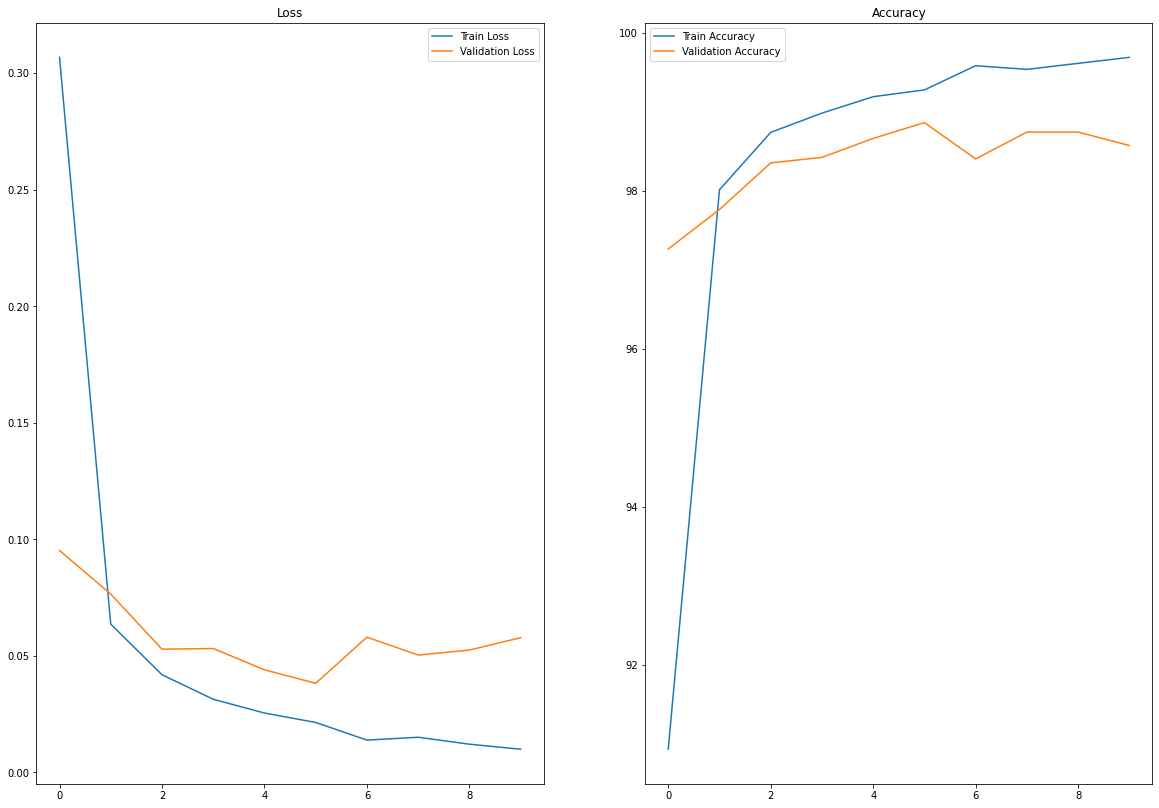

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


From the plots, we can see that after 5 epochs, there is a significant difference in the train accuracy and the validation accuracty and the train loss and validation loss : This means that the model tends to overfit after 5 epochs. SO lets train the model just for 5 epochs in the future to keep the train and validation accuracies and losses as close as possible

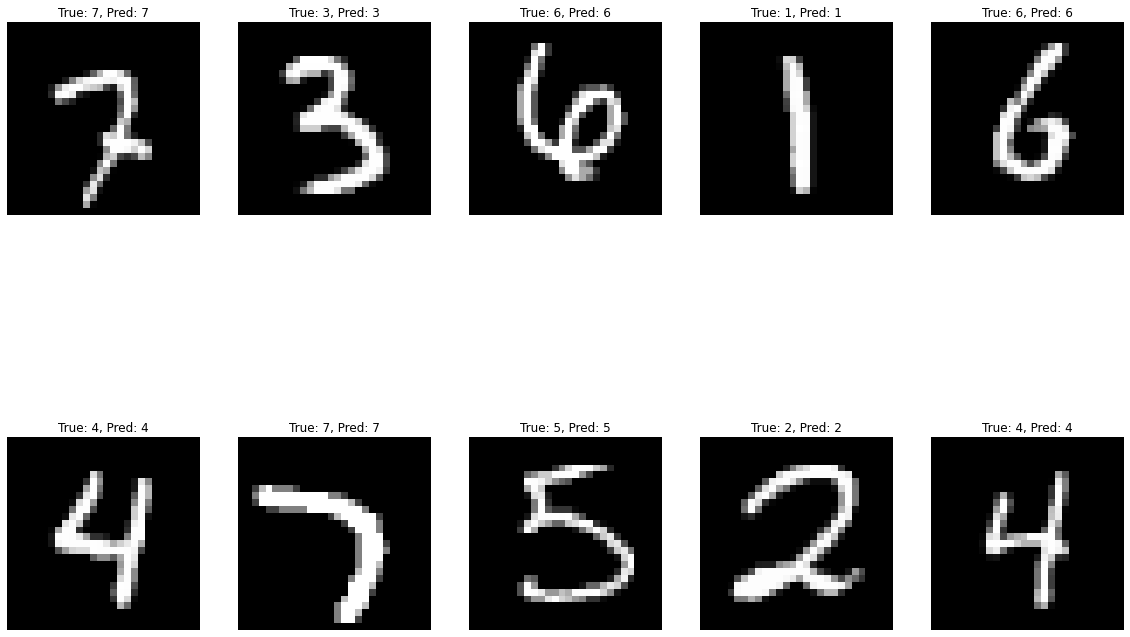

In [168]:
import random

def visualize_predictions(model, test_loader):
    model.eval()
    x, y = next(iter(test_loader))
    output = model(x)
    pred = output.argmax(dim=1, keepdim=True)
    fig = plt.figure(figsize=(20,14))
    for i in range(10):
        idx = random.randint(0, len(x)-1)
        img, true_label = x[idx], y[idx].item()
        pred_label = pred[idx].item()
        img = img.squeeze(0)  
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')

visualize_predictions(model, test_loader)


Batch Normalisation

In [169]:
class neuralnet_BN(nn.Module):
    def __init__(self,input_channels=1, conv1_out_channels=32, conv2_out_channels=32, fc1_out_features=500, num_classes=10):
        super(neuralnet_BN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=conv1_out_channels,kernel_size=3,stride=1,padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=conv1_out_channels,out_channels=conv2_out_channels,kernel_size=3,stride=1,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(conv2_out_channels * 7 * 7, fc1_out_features)  
        self.fc2 = nn.Linear(fc1_out_features, fc1_out_features)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
    def forward(self,x):
        x = self.maxpool1(F.relu(self.batch_norm1(self.conv1(x))))  
        x = self.maxpool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [170]:
model_bn =neuralnet_BN()
optimizer = optim.Adam(model_bn.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(model,train_loader,optimizer,epoch):
    model.train()
    train_loss = 0
    correct_predictions = 0
    for batch_number, (x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = output.argmax(dim=1, keepdim=True)
        correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct_predictions / len(train_loader.dataset)
    return avg_loss, accuracy


def valid(model,val_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

def test(model,test_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    print(f'Test Loss: {avg_loss:.2f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy
            




In [171]:
epochs= 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy=[]

for epoch in range(epochs):
    train_loss, train_acc = train(model_bn,train_loader, optimizer, epoch)
    val_loss, val_acc = valid(model_bn, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.2f}, Val Loss {val_loss:.2f}, Train Acc {train_acc:.2f}, Val Acc {val_acc:.2f}')
    



Epoch 1: Train Loss 0.13, Val Loss 0.11, Train Acc 96.13, Val Acc 96.70
Epoch 2: Train Loss 0.05, Val Loss 0.05, Train Acc 98.45, Val Acc 98.55
Epoch 3: Train Loss 0.03, Val Loss 0.05, Train Acc 98.91, Val Acc 98.41
Epoch 4: Train Loss 0.03, Val Loss 0.06, Train Acc 99.14, Val Acc 98.37
Epoch 5: Train Loss 0.02, Val Loss 0.05, Train Acc 99.33, Val Acc 98.76
Epoch 6: Train Loss 0.02, Val Loss 0.05, Train Acc 99.43, Val Acc 98.63
Epoch 7: Train Loss 0.01, Val Loss 0.04, Train Acc 99.54, Val Acc 98.94
Epoch 8: Train Loss 0.01, Val Loss 0.05, Train Acc 99.54, Val Acc 98.77
Epoch 9: Train Loss 0.01, Val Loss 0.05, Train Acc 99.63, Val Acc 98.84
Epoch 10: Train Loss 0.01, Val Loss 0.04, Train Acc 99.65, Val Acc 99.07


In [172]:
test_accuracy_bn = test(model_bn, test_loader)
test_accuracy = test(model,test_loader)
print("With batch norm accuracy",test_accuracy_bn,"Without batch norm test accuracy",test_accuracy)

Test Loss: 0.04, Test Accuracy: 99.07%
Test Loss: 0.06, Test Accuracy: 98.57%
With batch norm accuracy (0.04050096898608436, 99.07) Without batch norm test accuracy (0.05772314198176298, 98.57)


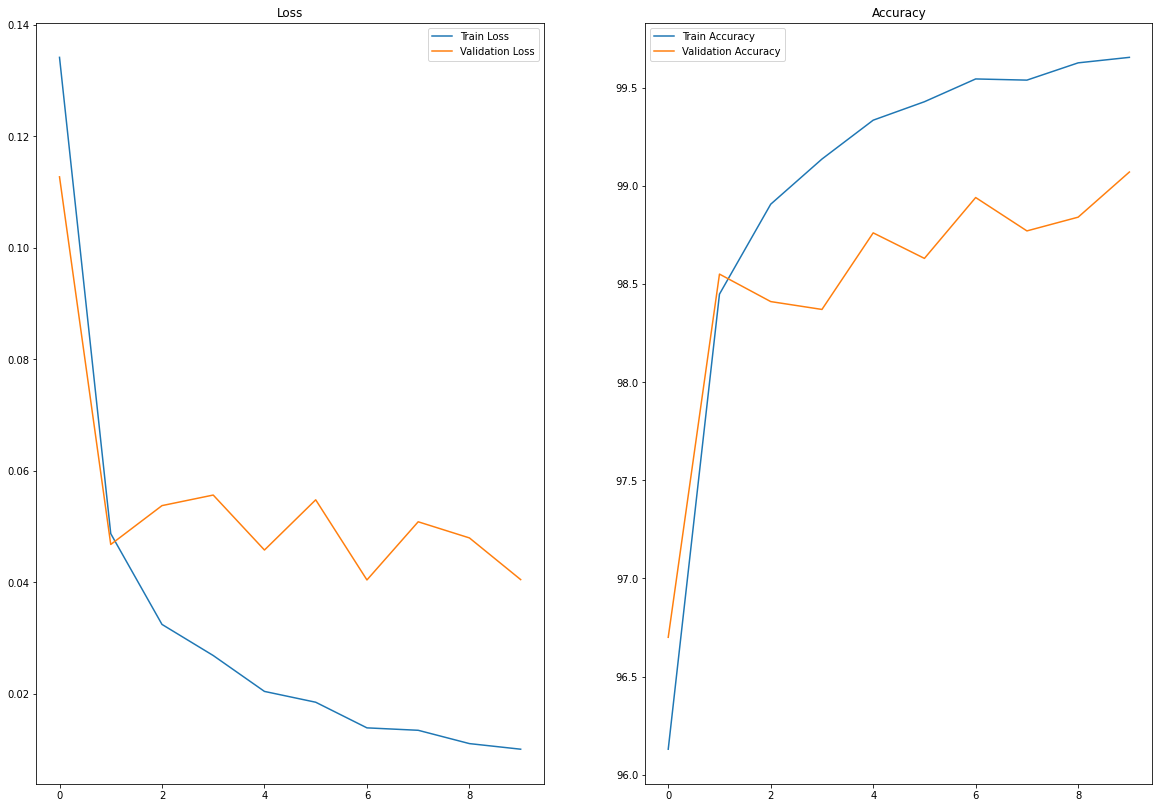

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


Comparison of with and without Batch normalisation:

In [190]:
model = neuralnet()

In [191]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(model,train_loader,optimizer,epoch):
    model.train()
    train_loss = 0
    correct_predictions = 0
    for batch_number, (x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = output.argmax(dim=1, keepdim=True)
        correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct_predictions / len(train_loader.dataset)
    return avg_loss, accuracy


def valid(model,val_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

def test(model,test_loader):
    model.eval()
    val_loss =0
    correct_predictions = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output,y).item()
            val_loss +=loss
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(y.view_as(predictions)).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct_predictions / len(val_loader.dataset)
    print(f'Test Loss: {avg_loss:.2f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy
            




In [192]:
epochs= 5
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy=[]

for epoch in range(epochs):
    train_loss, train_acc = train(model,train_loader, optimizer, epoch)
    val_loss, val_acc = valid(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.2f}, Val Loss {val_loss:.2f}, Train Acc {train_acc:.2f}, Val Acc {val_acc:.2f}')
    



Epoch 1: Train Loss 0.31, Val Loss 0.09, Train Acc 90.96, Val Acc 97.29
Epoch 2: Train Loss 0.07, Val Loss 0.07, Train Acc 97.98, Val Acc 97.68
Epoch 3: Train Loss 0.04, Val Loss 0.06, Train Acc 98.62, Val Acc 98.13
Epoch 4: Train Loss 0.03, Val Loss 0.06, Train Acc 98.94, Val Acc 98.30
Epoch 5: Train Loss 0.02, Val Loss 0.07, Train Acc 99.19, Val Acc 98.10


In [193]:
test_accuracy_bn = test(model_bn, test_loader)
test_accuracy = test(model,test_loader)
print("With batch norm accuracy",test_accuracy_bn,"Without batch norm test accuracy",test_accuracy)

Test Loss: 0.04, Test Accuracy: 99.07%
Test Loss: 0.07, Test Accuracy: 98.10%
With batch norm accuracy (0.04050096898608436, 99.07) Without batch norm test accuracy (0.06678615937641211, 98.1)


#Question 2

Visualising filters and layers

Visualising the conv1 filter 

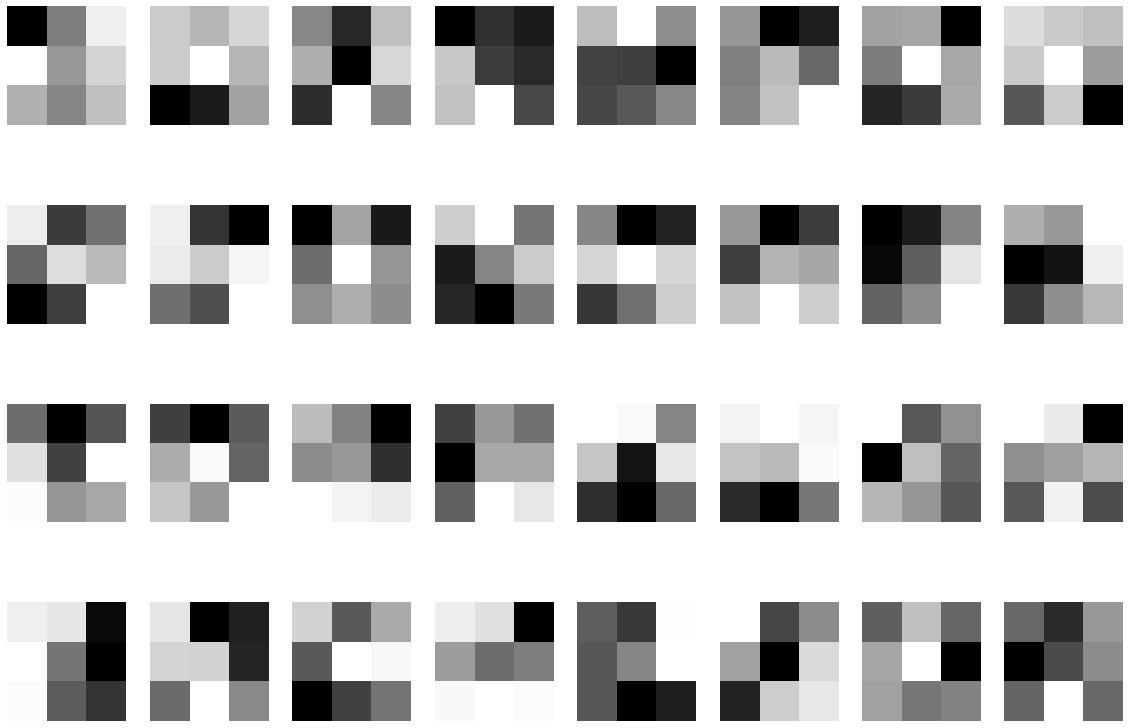

In [194]:
filters = model.conv1.weight.data
fig, axs = plt.subplots(4, 8, figsize=(20, 14))
for i, ax in enumerate(axs.flat):
    ax.imshow(filters[i, 0, :, :], cmap='gray')
    ax.axis('off')
plt.show()

Visualising conv2 filter

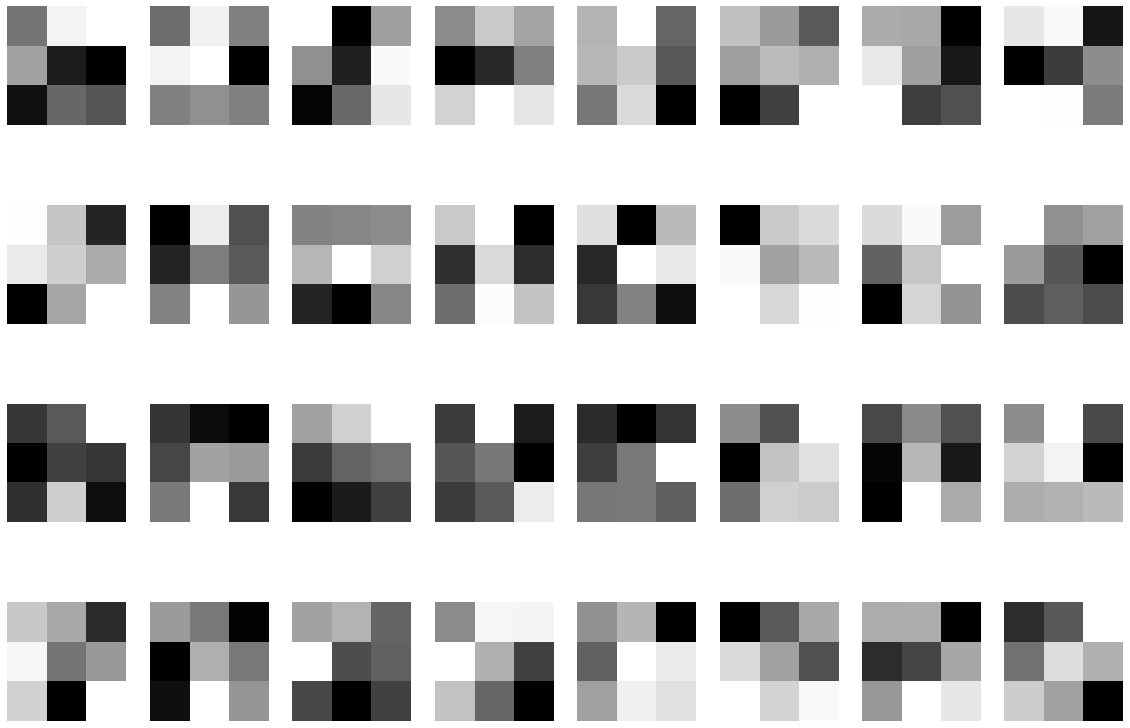

In [195]:
filters = model.conv2.weight.data
fig, axs = plt.subplots(4, 8, figsize=(20, 14))
for i, ax in enumerate(axs.flat):
    ax.imshow(filters[i, 0, :, :], cmap='gray')
    ax.axis('off')
plt.show()

Visualising the activations of an image at conv layers 1 and 2

In [196]:
example_img, _ = next(iter(test_loader))
example_img = example_img[0]


In [197]:
def visualize_activations(model, image):
    image = image.unsqueeze(0)
    activation_maps = []
    def hook_fn(module, input, output):
        activation_maps.append(output)
    model.conv1.register_forward_hook(hook_fn)
    model.conv2.register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        model(image)
    for i, activations in enumerate(activation_maps):
        activations = activations.cpu().numpy()[0]
        fig, axs = plt.subplots(4, 8, figsize=(20, 14))
        for j, ax in enumerate(axs.flat):
            ax.imshow(activations[j], cmap='gray')
            ax.axis('off')
        plt.suptitle(f'Activations of conv{i+1}')
        plt.show()

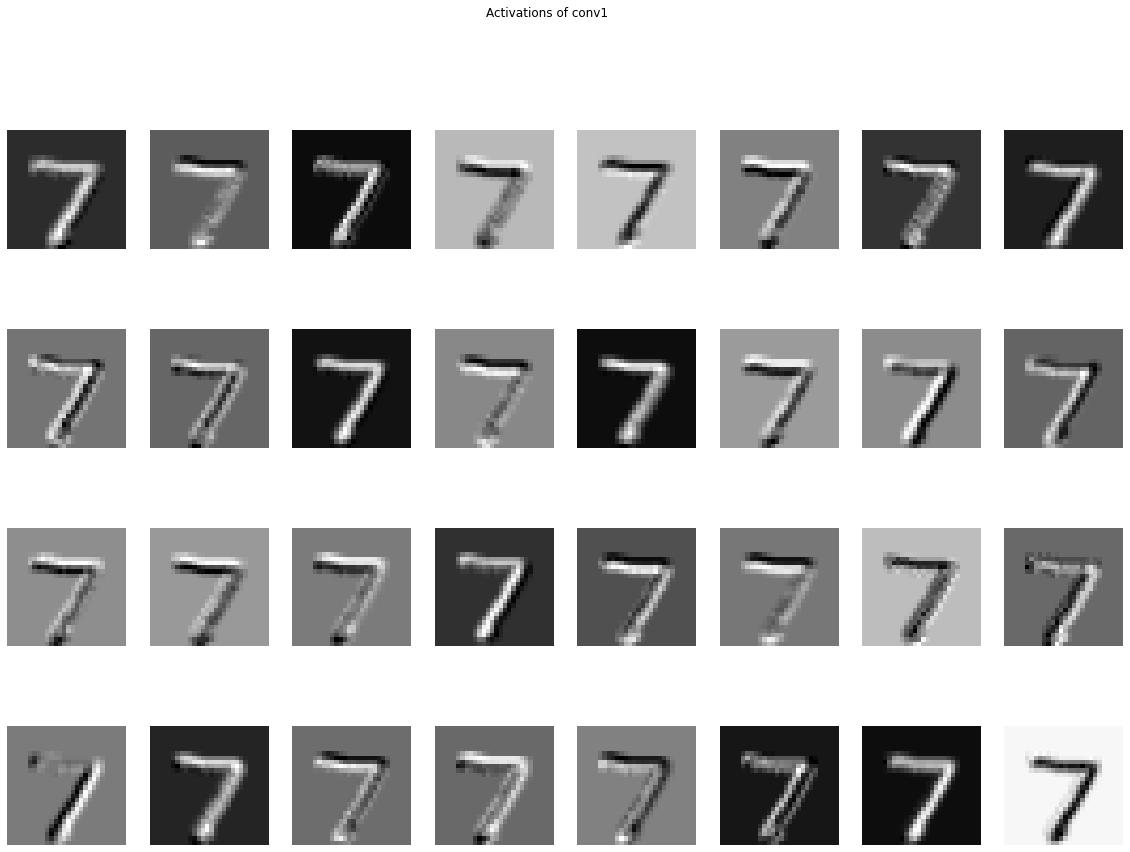

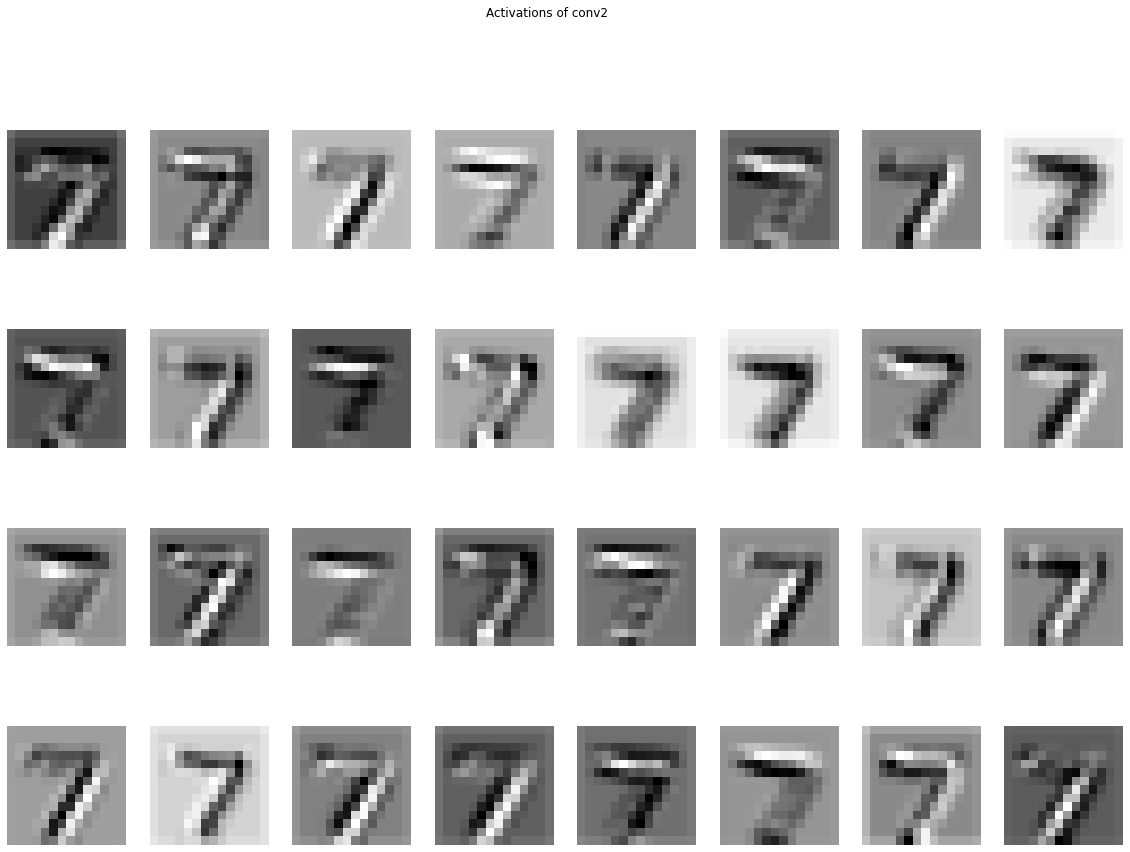

In [198]:
visualize_activations(model, example_img)

From the above images on activations and the visualization of the convolution layers suggest that after the first activation - the background seems more suppressed. and the edges and the foreground - especially edges are more prominent. So this means the first convolution layer might be some sort of high frequency feature capturing or an edge detection.
The second activation layer shows prominent BLURRING, meaning that the second convolution layer leads to blurring.
The outputs of the conv layer 1 should be some sort of edge detection filters, but they need not be the edge detection filters along x and y direction, rather they are the edge detection filters under other directions


Occulision

In [199]:
import numpy as np

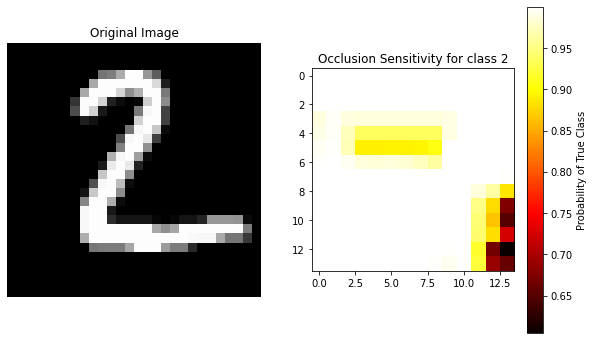

In [200]:

def sensitivity_occlusion(neural_net, img, label, patch_size=5, step=1):
    neural_net.eval()
    img = img.unsqueeze(0)
    pred_output = neural_net(img)
    predicted_class = torch.argmax(pred_output).item()

    img_height, img_width = img.shape[2], img.shape[3]
    sensitivity_map = np.zeros((img_height - patch_size + 1, img_width - patch_size + 1))
    
    for y in range(0, img_height - patch_size + 1, step):
        for x in range(0, img_width - patch_size + 1, step):
            altered_img = img.clone()
            altered_img[:, :, y:y+patch_size, x:x+patch_size] = 0 
            altered_output = neural_net(altered_img)
            class_prob = torch.softmax(altered_output, dim=1)
            sensitivity_map[y, x] = class_prob[0, predicted_class].item()

    return sensitivity_map, predicted_class


def plot_occlusion_heatmap(heatmap, image, title="Occlusion Sensitivity"):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Probability of True Class')
    plt.title(title)
    plt.show()

sample_image, label = next(iter(test_loader))  
sample_image = sample_image[1]  
occluder_size=15
heatmap, predicted_class = sensitivity_occlusion(model, sample_image, label, occluder_size)

plot_occlusion_heatmap(heatmap, sample_image, title=f"Occlusion Sensitivity for class {predicted_class}")


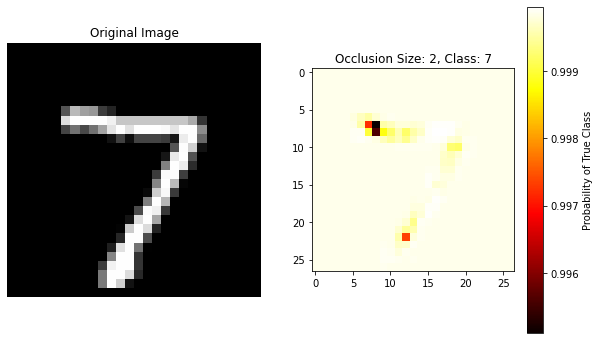

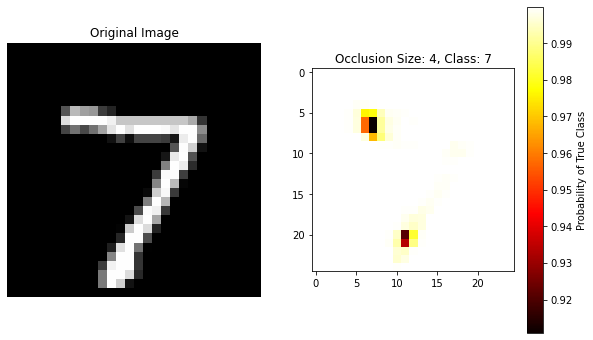

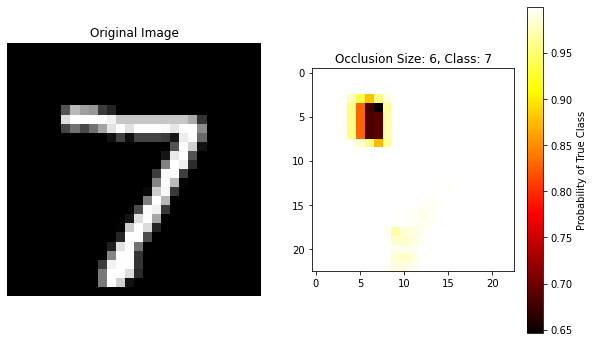

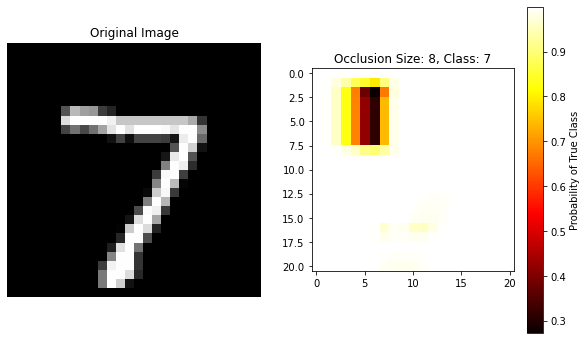

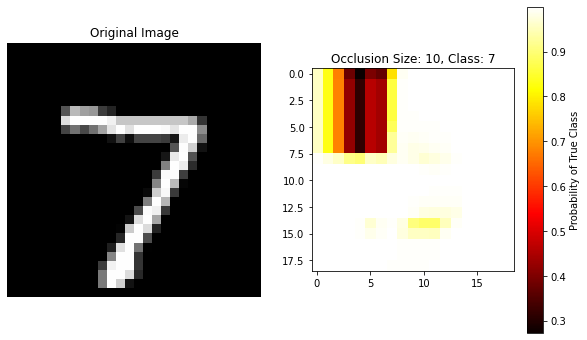

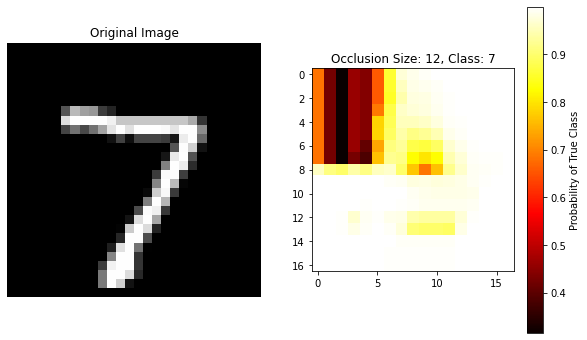

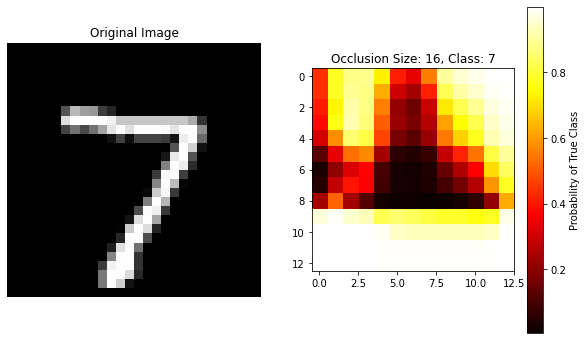

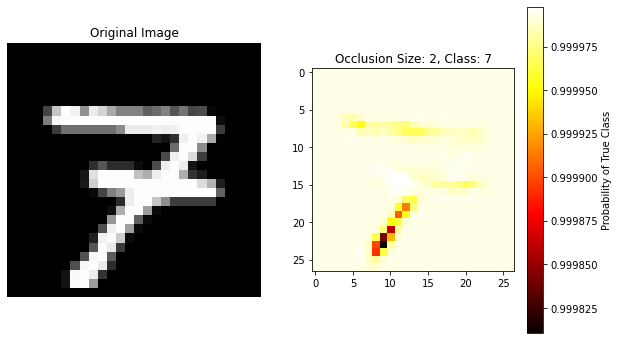

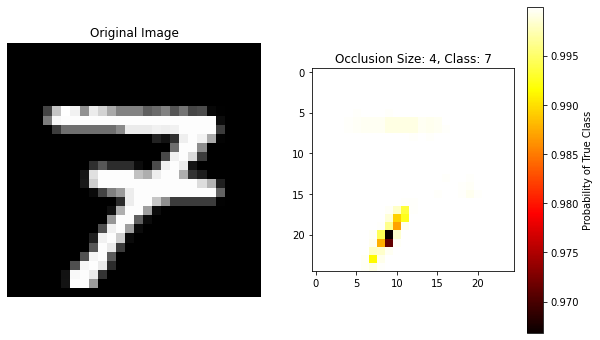

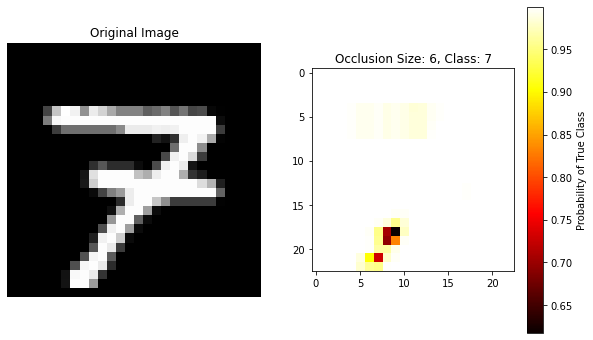

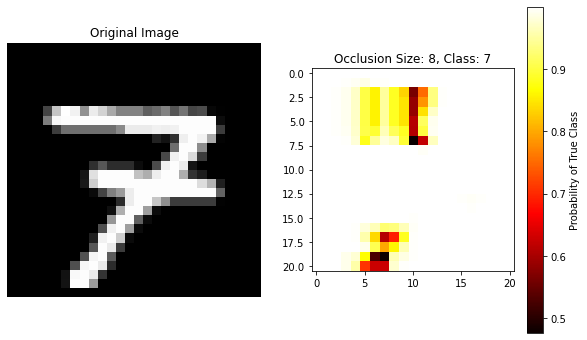

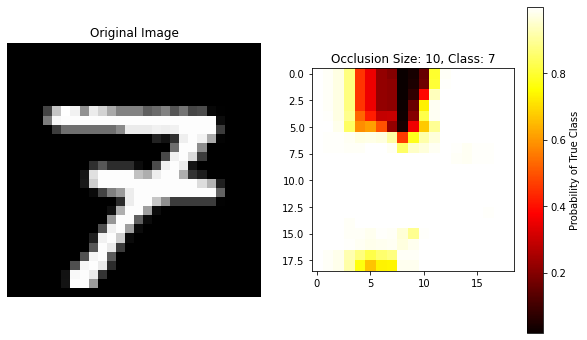

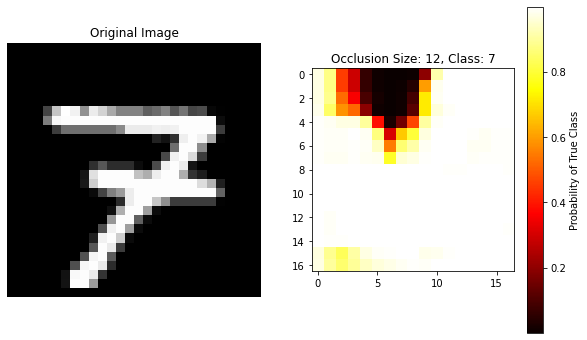

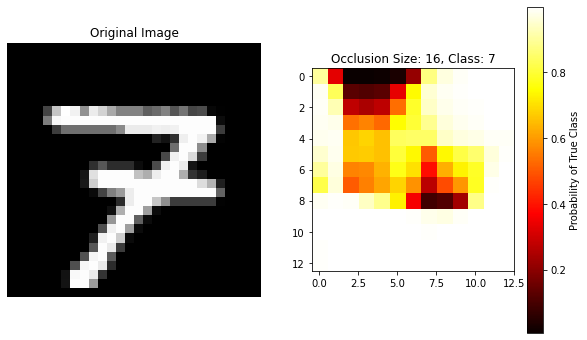

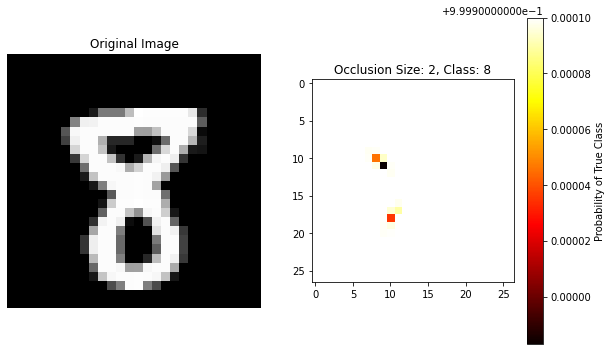

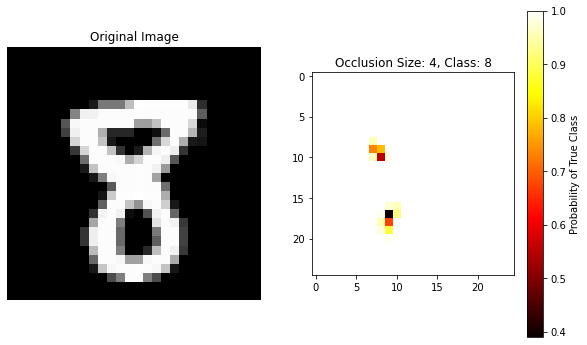

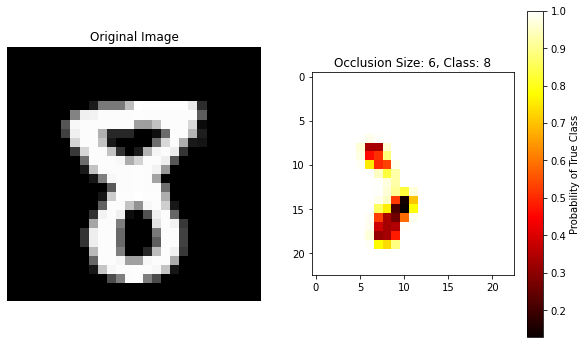

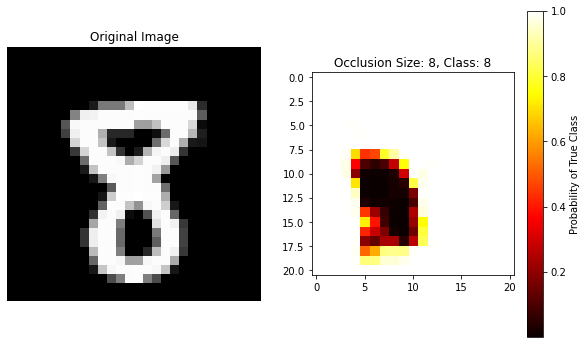

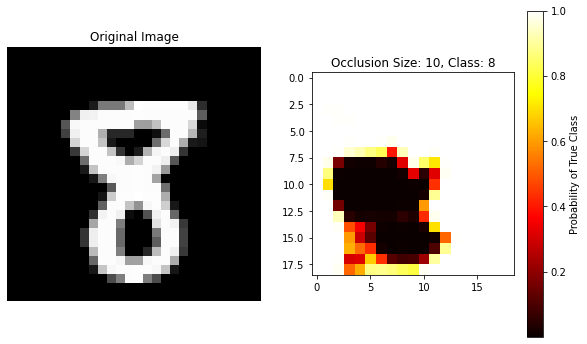

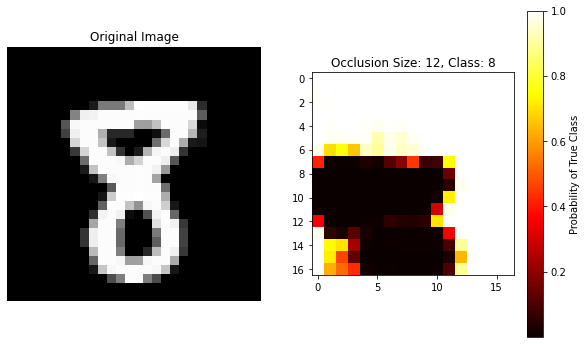

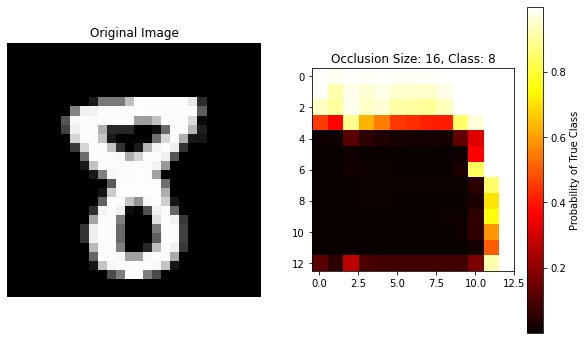

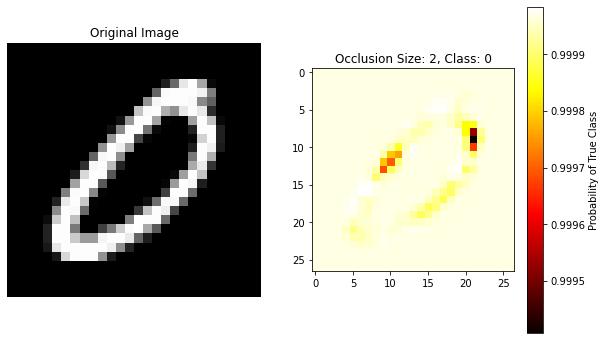

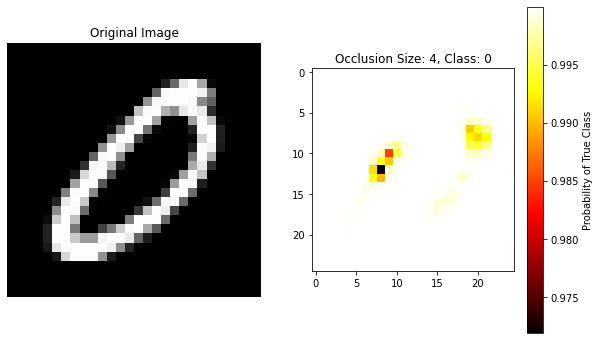

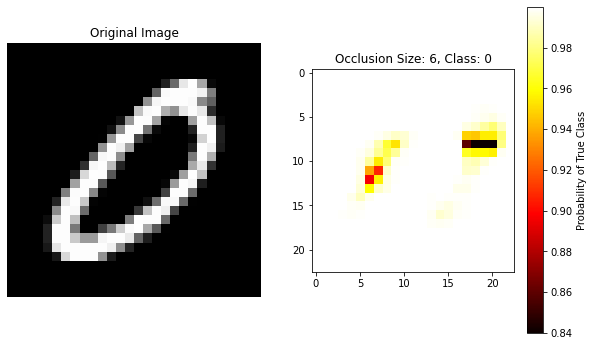

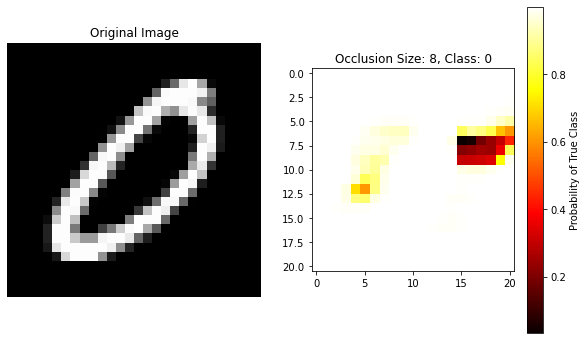

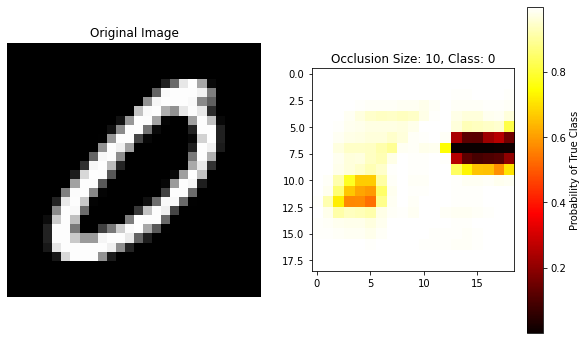

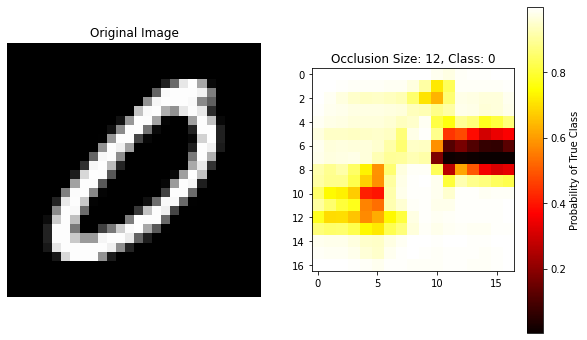

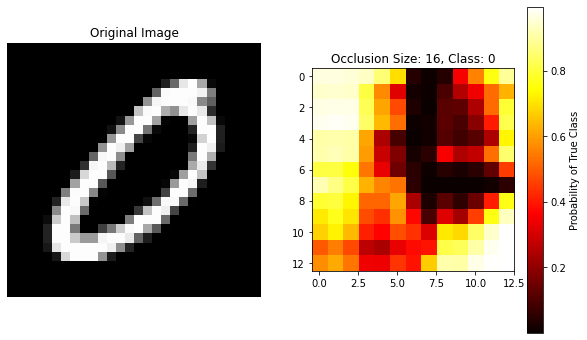

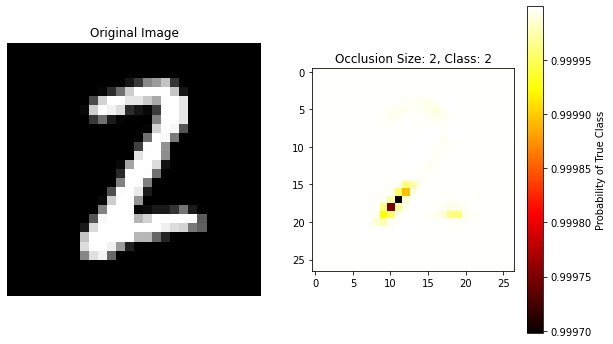

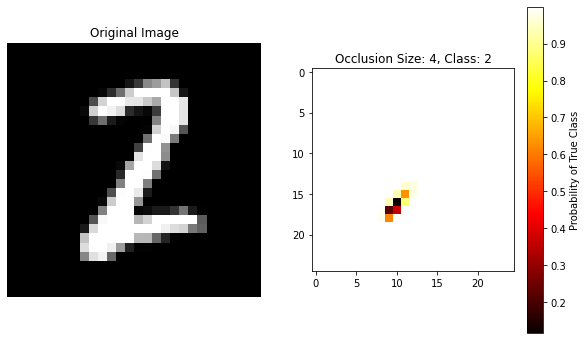

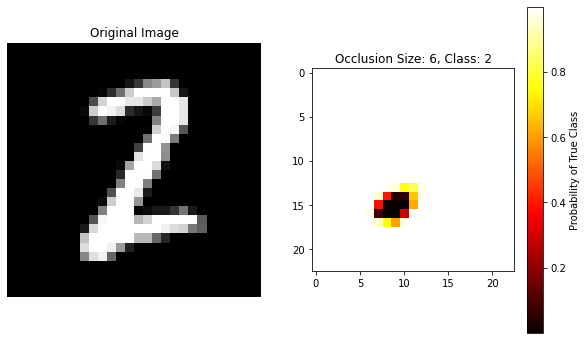

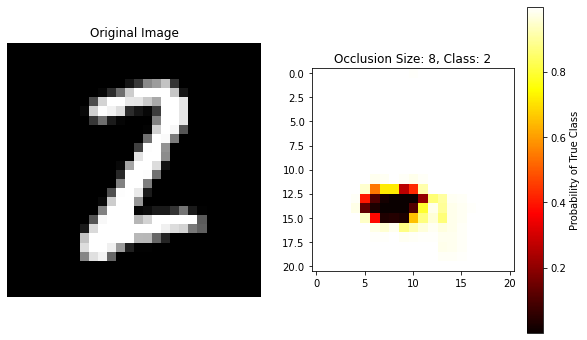

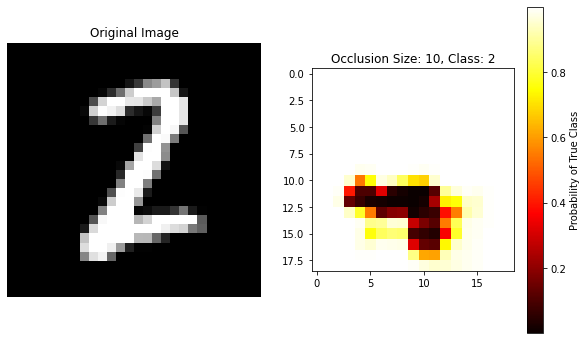

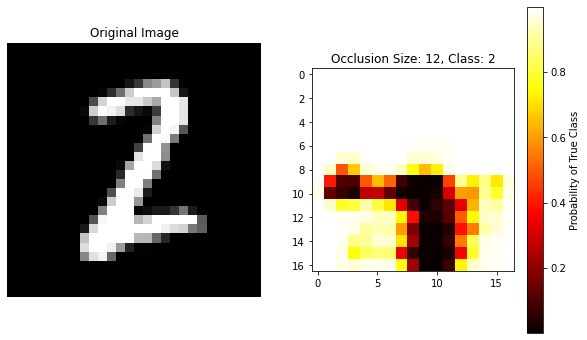

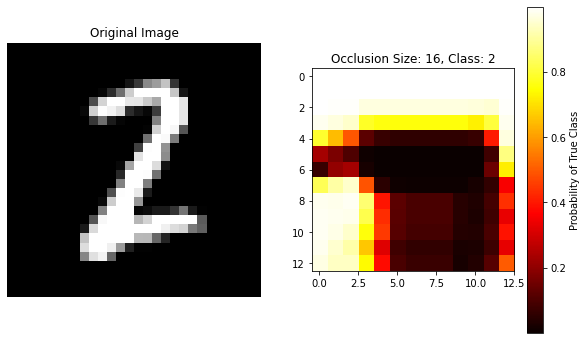

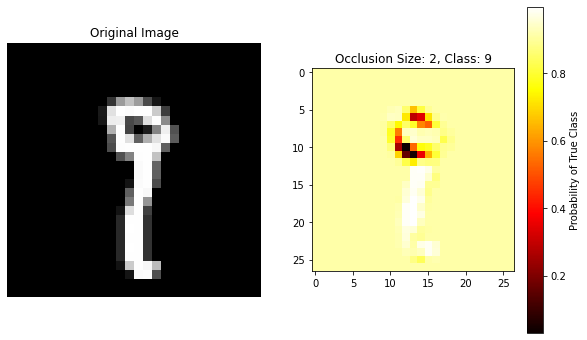

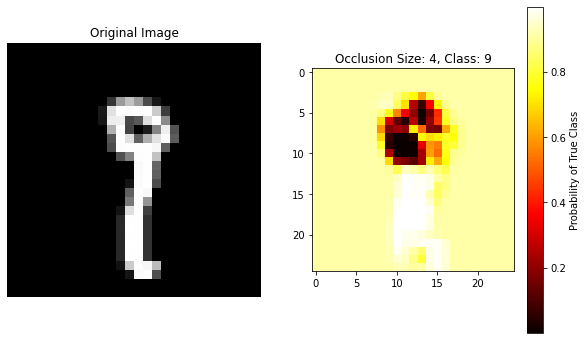

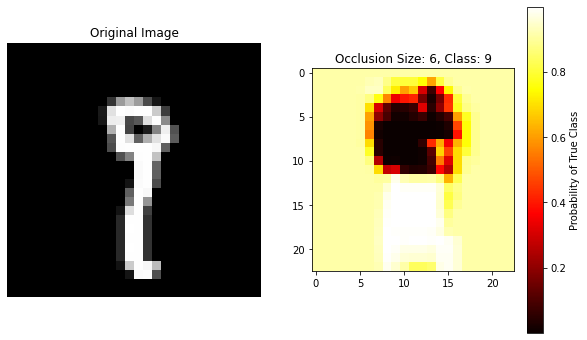

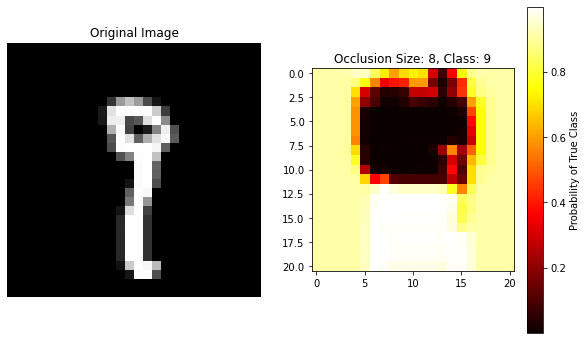

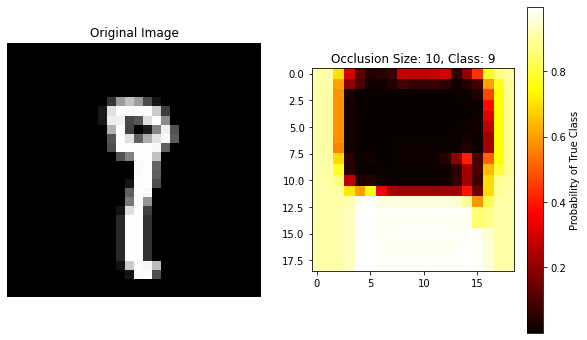

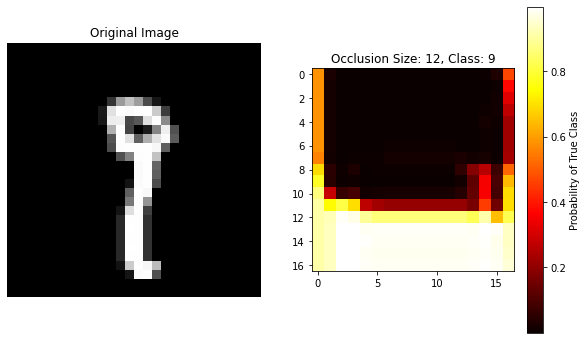

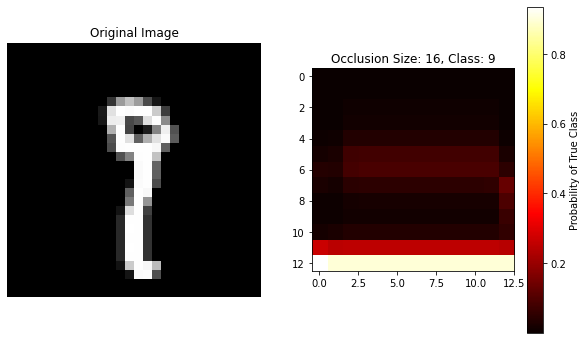

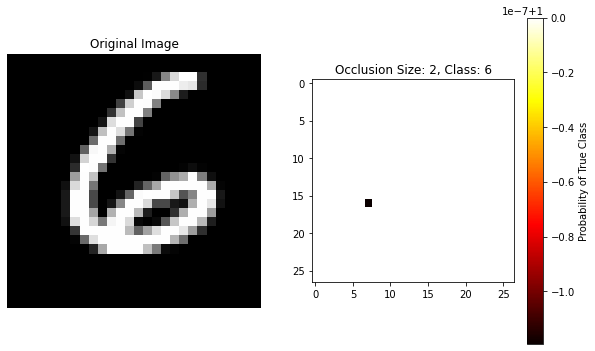

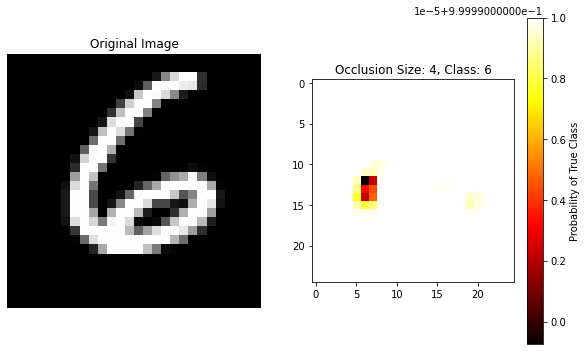

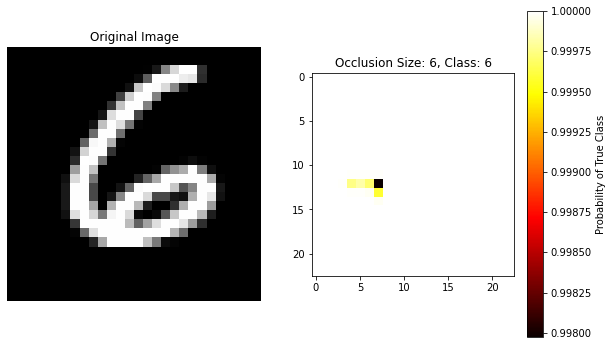

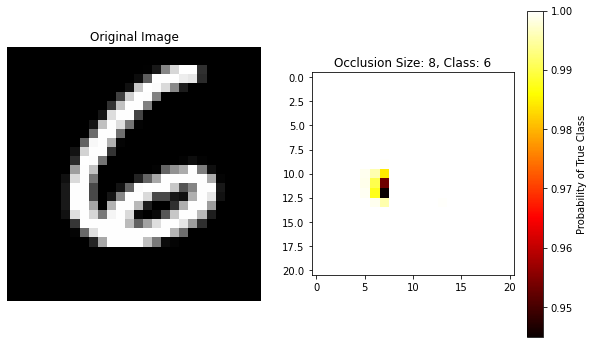

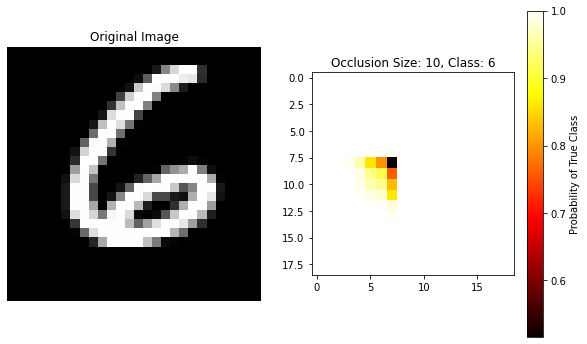

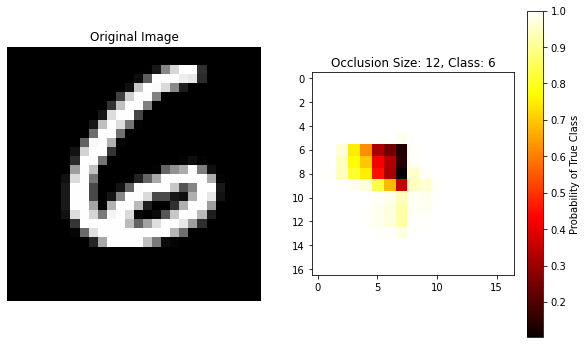

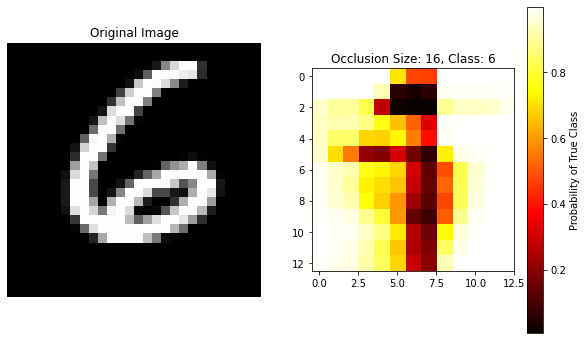

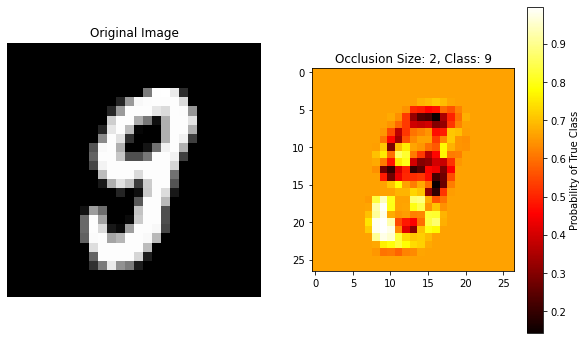

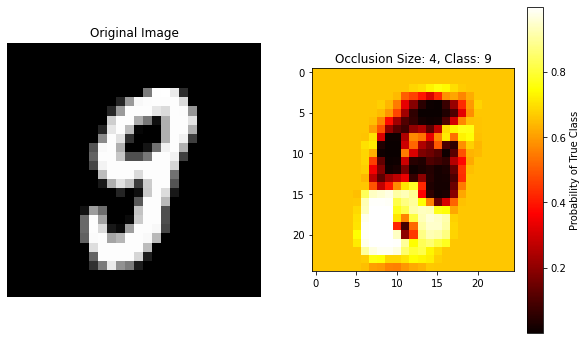

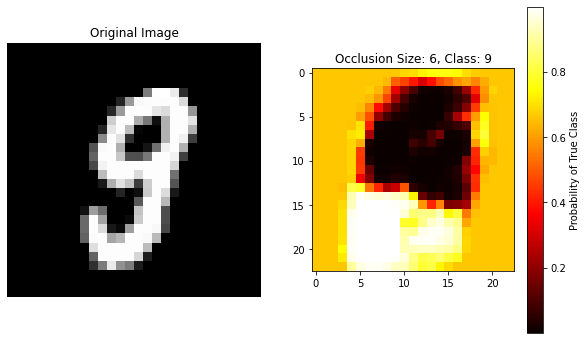

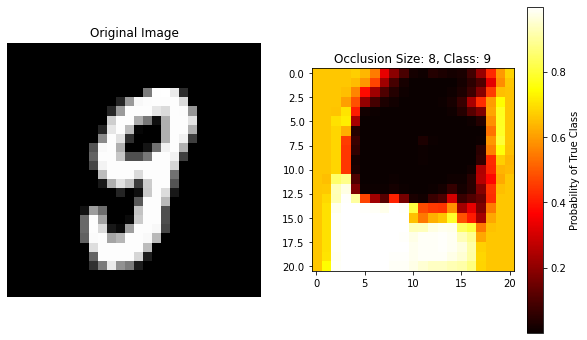

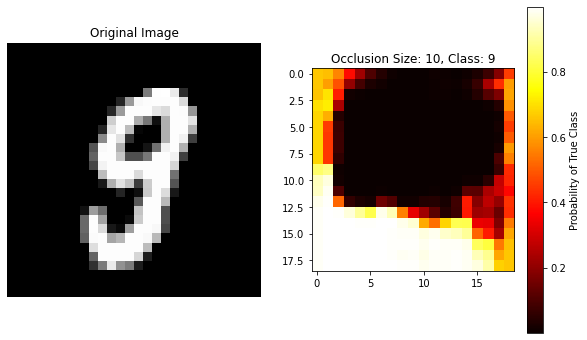

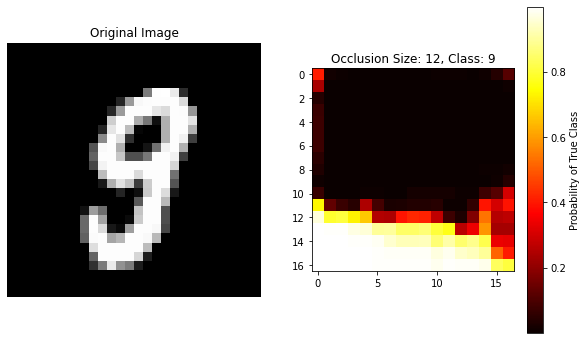

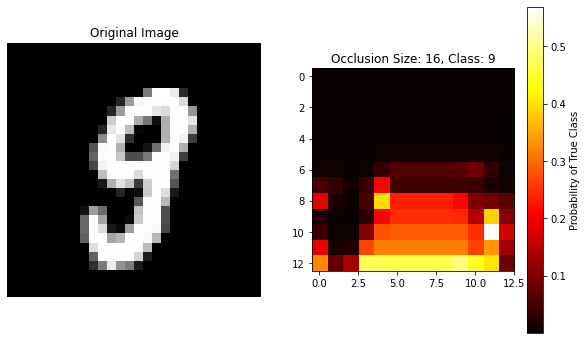

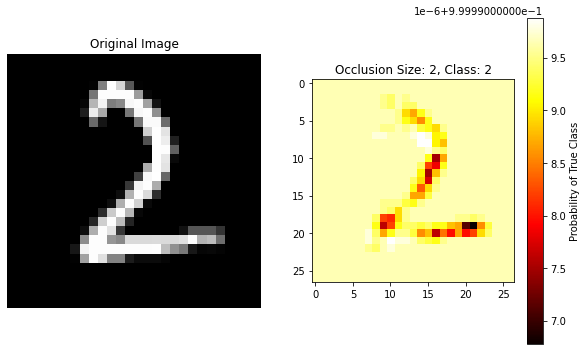

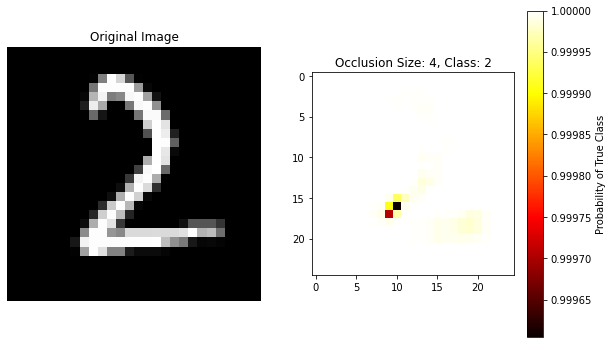

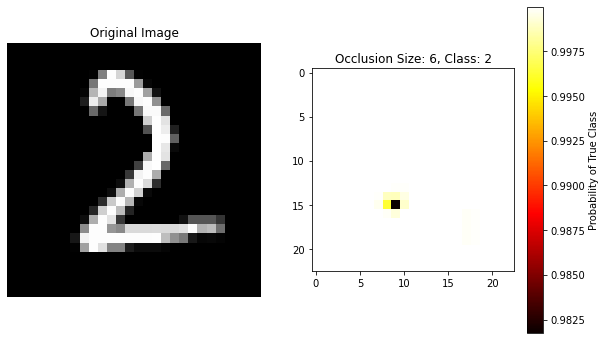

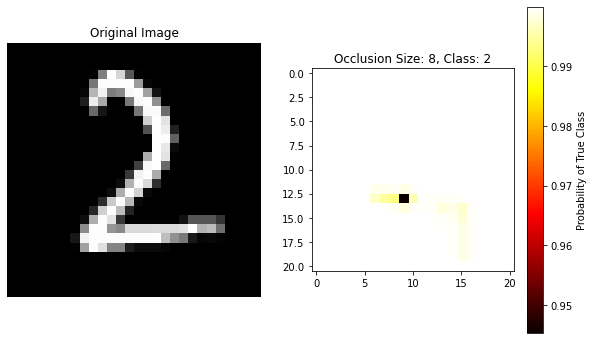

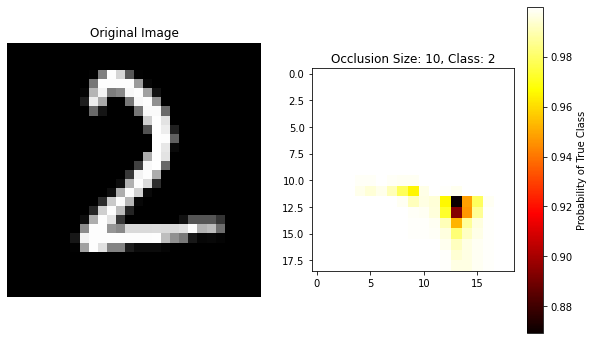

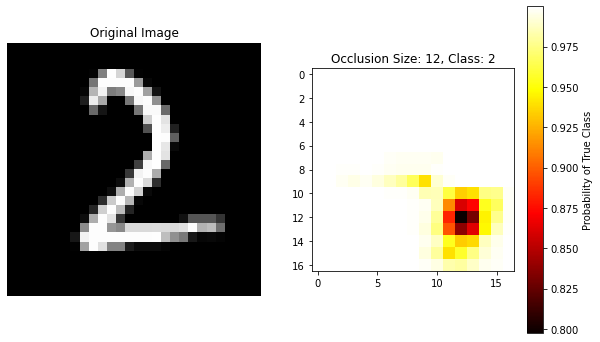

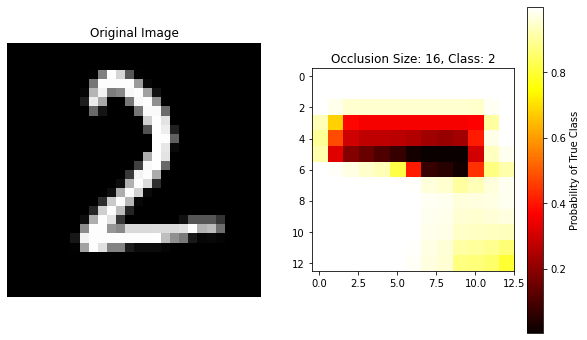

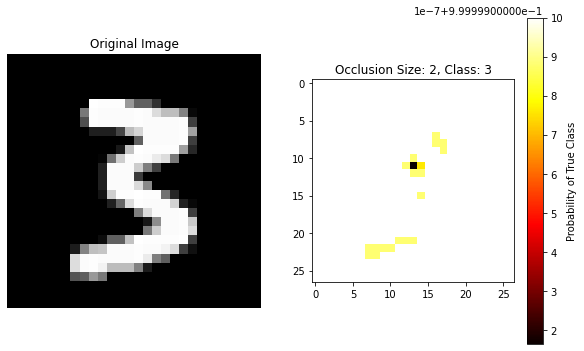

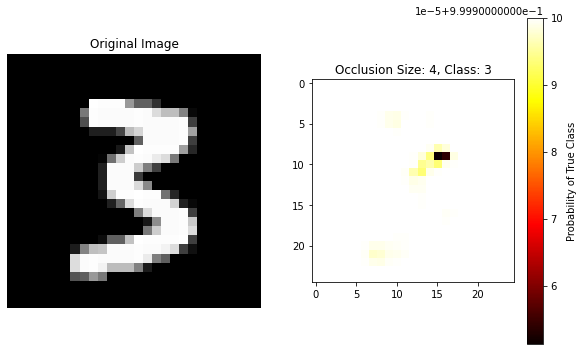

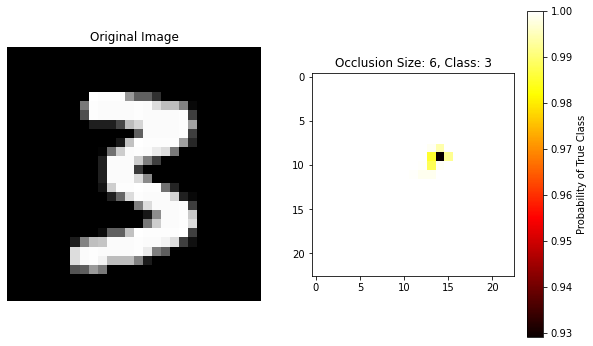

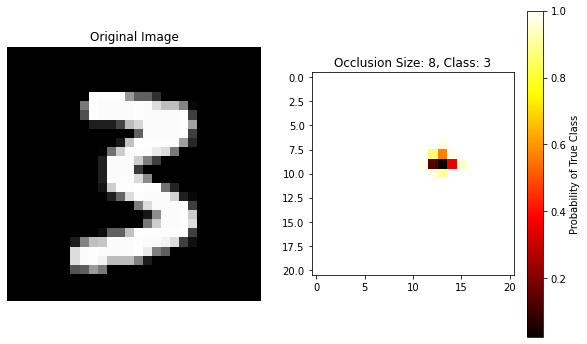

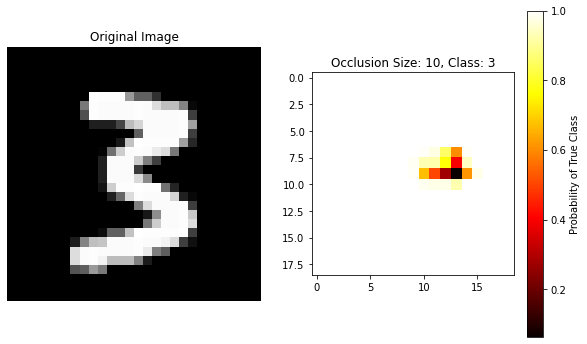

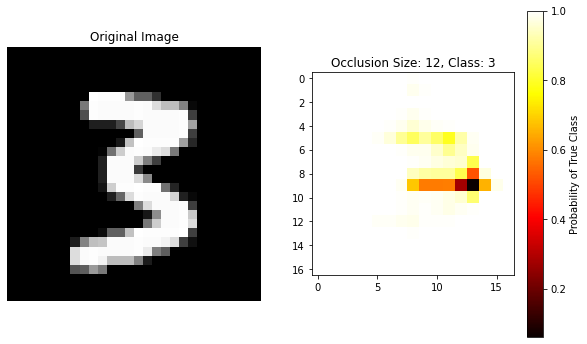

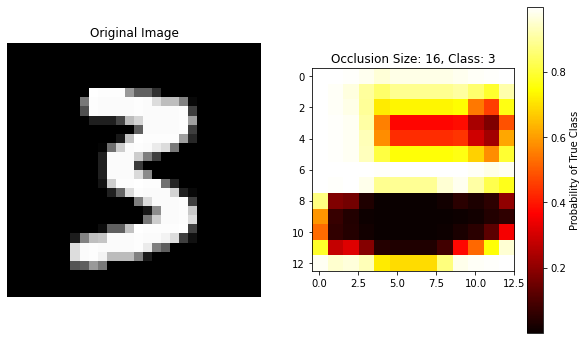

In [201]:

def analyze_occlusion_for_images(model, data_loader, occlusion_sizes=[2, 4, 6], num_images=5):
    images_analyzed = 0
    
    for sample_image, label in data_loader:
        if images_analyzed >= num_images:
            break 
        sample_image = sample_image[0]  
        for occluder_size in occlusion_sizes:
            heatmap, predicted_class = sensitivity_occlusion(model, sample_image, label, occluder_size)
            plot_occlusion_heatmap(heatmap, sample_image, title=f"Occlusion Size: {occluder_size}, Class: {predicted_class}")
        
        images_analyzed += 1


analyze_occlusion_for_images(model, test_loader, occlusion_sizes=[2,4,6,8,10,12,16], num_images=10)


#Question 3

Non Targeted Attack

Predicted class: 0, Confidence in target class: 0.9483, Target class: 0
Predicted class: 1, Confidence in target class: 0.9204, Target class: 1
Predicted class: 2, Confidence in target class: 0.9096, Target class: 2
Predicted class: 3, Confidence in target class: 0.9641, Target class: 3
Predicted class: 4, Confidence in target class: 0.9723, Target class: 4
Predicted class: 5, Confidence in target class: 0.8393, Target class: 5
Predicted class: 6, Confidence in target class: 0.9568, Target class: 6
Predicted class: 7, Confidence in target class: 0.9635, Target class: 7
Predicted class: 8, Confidence in target class: 0.9112, Target class: 8
Predicted class: 9, Confidence in target class: 0.9488, Target class: 9


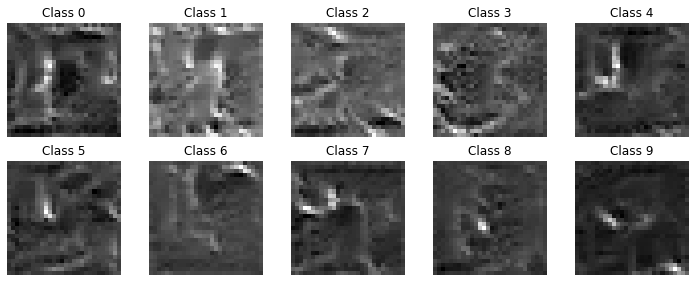

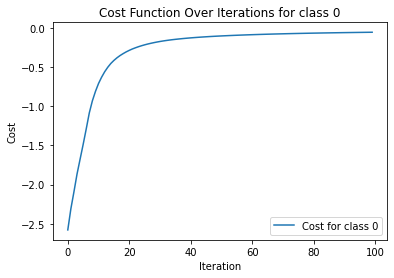

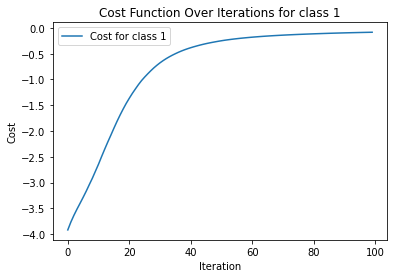

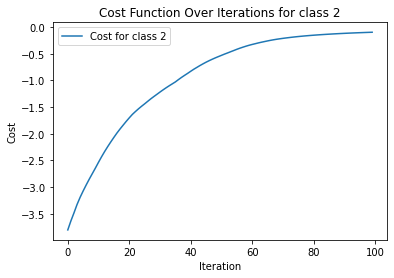

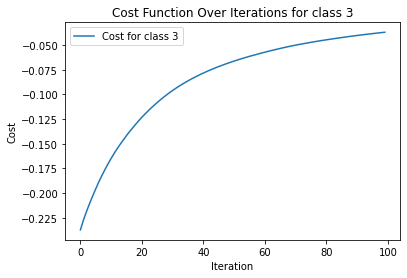

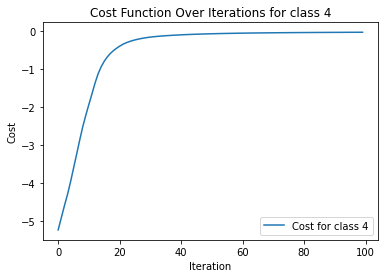

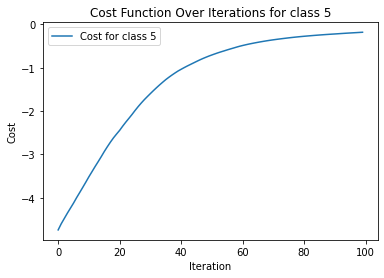

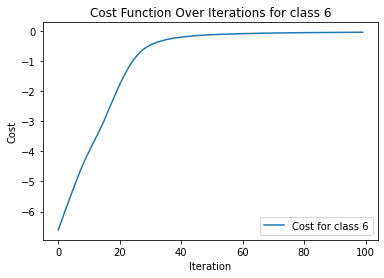

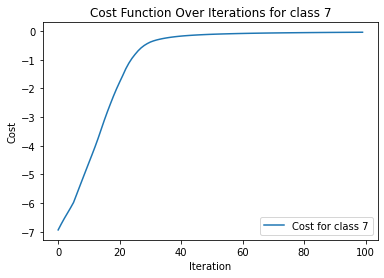

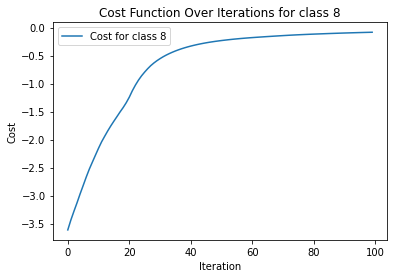

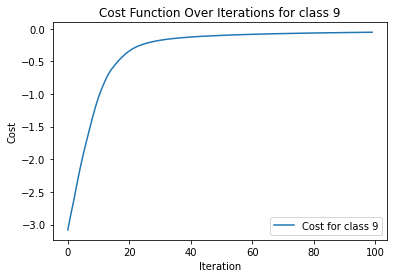

In [202]:
def plot_cost(cost_history, target_class):
    plt.plot(cost_history, label=f'Cost for class {target_class}')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title(f'Cost Function Over Iterations for class {target_class}')
    plt.legend()
    plt.show()

def create_adversarial_sample(neural_net, class_target, lr=0.01, num_steps=100):
    neural_net.eval()
    noise = np.random.normal(loc=128, scale=1, size=(1, 1, 28, 28))
    noise_image = torch.tensor(noise, dtype=torch.float32) / 255.0
    img_tensor = noise_image.clone().detach().requires_grad_(True)
    cost_history = []
    
    for step in range(num_steps):
        preds = neural_net(img_tensor)
        loss = preds[0, class_target]
        cost_history.append(loss.item())
        neural_net.zero_grad()
        loss.backward()
        img_tensor.data += lr * img_tensor.grad.data
        img_tensor.grad.data.zero_()
    
    img_tensor.data = torch.clamp(img_tensor.data, 0, 1)
    return img_tensor, cost_history

def show_adversarial_examples(neural_net, lr=0.01, num_steps=200):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.ravel()
    cost_histories = {}

    for target_class in range(10):
        modified_img, cost_history = create_adversarial_sample(neural_net, class_target=target_class, lr=lr, num_steps=num_steps)
        img_array = modified_img.detach().numpy().squeeze()

        adversarial_sample = modified_img.detach()
        with torch.no_grad():
            output = neural_net(adversarial_sample)

        probability = nn.Softmax(dim=1)(output)
        predicted_label = torch.argmax(probability).item()
        target_confidence = probability[0, target_class].item()

        print(f"Predicted class: {predicted_label}, Confidence in target class: {target_confidence:.4f}, Target class: {target_class}")

        axes[target_class].imshow(img_array, cmap='gray')
        axes[target_class].set_title(f'Class {target_class}')
        axes[target_class].axis('off')

 
        cost_histories[target_class] = cost_history

    plt.tight_layout()
    plt.show()

    return cost_histories

cost_histories = show_adversarial_examples(model, num_steps=100)


for target_class, cost_history in cost_histories.items():
    plot_cost(cost_history, target_class)


It is not always predicting the target class with higher confidence. For example target class 0 is being chosen with a confidence of 0.77, Most of them are chosen with a confidence of 0.85+.
Class 3 is chosen with the highest confidence of 0.94.

Lets try increasing the number of steps

Predicted class: 0, Confidence in target class: 0.9862, Target class: 0
Predicted class: 1, Confidence in target class: 0.9921, Target class: 1
Predicted class: 2, Confidence in target class: 0.9934, Target class: 2
Predicted class: 3, Confidence in target class: 0.9919, Target class: 3
Predicted class: 4, Confidence in target class: 0.9937, Target class: 4
Predicted class: 5, Confidence in target class: 0.9907, Target class: 5
Predicted class: 6, Confidence in target class: 0.9901, Target class: 6
Predicted class: 7, Confidence in target class: 0.9926, Target class: 7
Predicted class: 8, Confidence in target class: 0.9856, Target class: 8
Predicted class: 9, Confidence in target class: 0.9903, Target class: 9


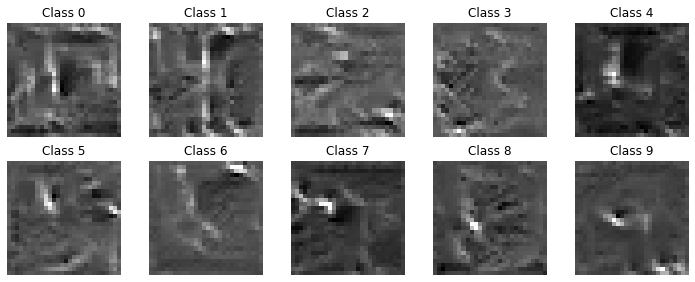

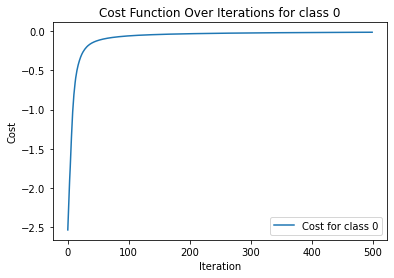

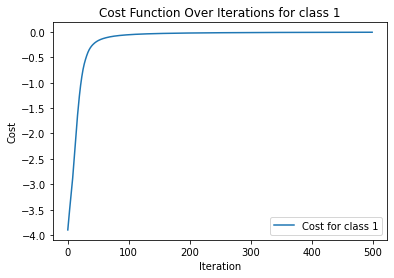

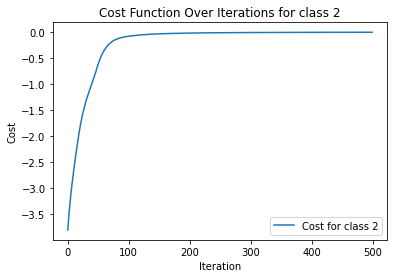

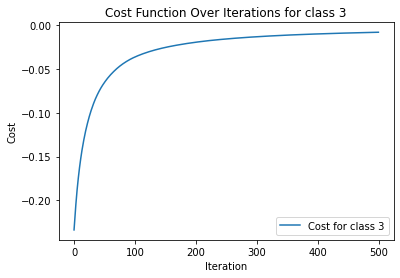

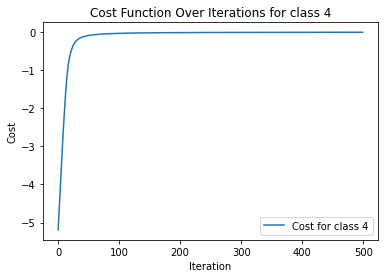

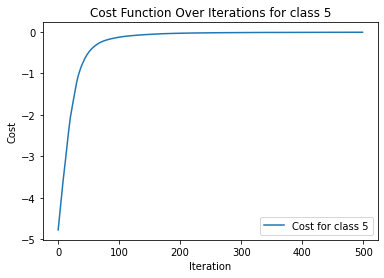

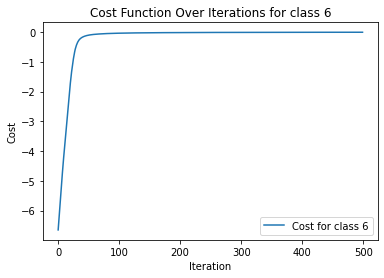

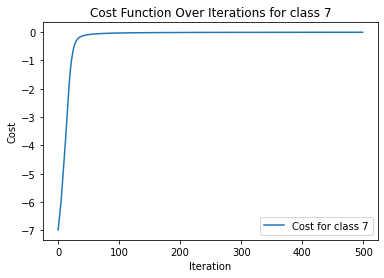

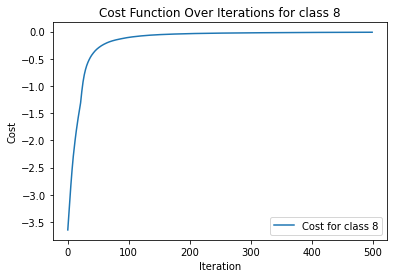

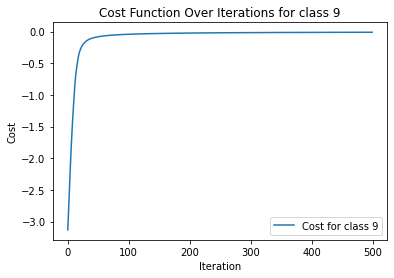

In [203]:
cost_histories = show_adversarial_examples(model, num_steps=500)


for target_class, cost_history in cost_histories.items():
    plot_cost(cost_history, target_class)

We see that, as we increase the number of steps to 200 and then to 500, the confidence values of predicting the classes also incrase. Now they are as high as 0.98. The generated images dont look exactly like the numbers, but we can see that there are very small features that look like derived similar to the numbers,  FOR example, the two ovals in the generated image for 8. They dont look exacly similar to the generated images, because, all the algorithm tries to do is to increase the logit values to increase the probabilities of the target class my modifing the image. The algorithm, therefore tries to modify the input images so that they have all the "features" of the target class that the model has "learnt" during its training. The objective function set, has not much control on the "similarity" of the generated image to the actual image. So, the image generated, may have a lot of "reconstructed" loss as it does not try to reconstruct the target class image, but it tries to maximise the similarity feature representation of the image with the target class at a higher dimension level - inside the neural network

Targeted Attack

Since the question paper has no information about what sort of input images should be passed onto a targetted attack, I did the following two cases below
1) Case 1: Input image and target image is same: and the target label is different, Ie the input image and target image are both the same from the MNIST dataset
2) Case 2: Input image is the gaussian noisy image - mean 128 and std dev 1. The target image is taken from the MNIST dataset and the target label is the label diffeerent from the target image

Case 1

In [206]:
def generate_custom_attack(neural_net, input_image, target_label, reg_coeff=0.0001, lr=0.01, num_steps=100):
    neural_net.eval()
    adv_tensor = input_image.clone().detach().requires_grad_(True)
    target_image = input_image
    for step in range(num_steps):
        predictions = neural_net(adv_tensor)
        similarity_loss = F.mse_loss(adv_tensor, target_image)
        total_loss = predictions[0, target_label] - reg_coeff * similarity_loss
        neural_net.zero_grad()
        total_loss.backward()
        adv_tensor.data += lr * adv_tensor.grad.data
        adv_tensor.grad.data.zero_()
    
    adv_tensor.data = torch.clamp(adv_tensor.data, 0, 1)
    return adv_tensor

def display_custom_attack(neural_net, input_image, target_label, lr=0.0001, num_steps=1000):
    modified_image = generate_custom_attack(neural_net, input_image, target_label, lr=lr, num_steps=num_steps)
    mod_image_np = modified_image.detach().numpy().squeeze()
    
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.squeeze().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mod_image_np, cmap='gray')
    plt.title(f'Adversarial Image (Class {target_label})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def create_adversarial_examples_grid(neural_net, data_loader, step_size=0.01, num_steps=100):
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    
    for orig_label in range(10):
        input_image, _ = data_loader.dataset[orig_label]
        input_image = input_image.unsqueeze(0)  
        
        for target_label in range(10):
            adv_image = generate_custom_attack(neural_net, input_image, target_label, lr=step_size, num_steps=num_steps)
            adv_image_np = adv_image.detach().numpy().squeeze()

            axes[orig_label, target_label].imshow(adv_image_np, cmap='gray')
            axes[orig_label, target_label].set_title(f'Original: {_} -> Target: {target_label}', fontsize=8)
            axes[orig_label, target_label].axis('off')

    plt.tight_layout()
    plt.show()


create_adversarial_examples_grid(model, test_loader, step_size=0.01, num_steps=500)


Case 2

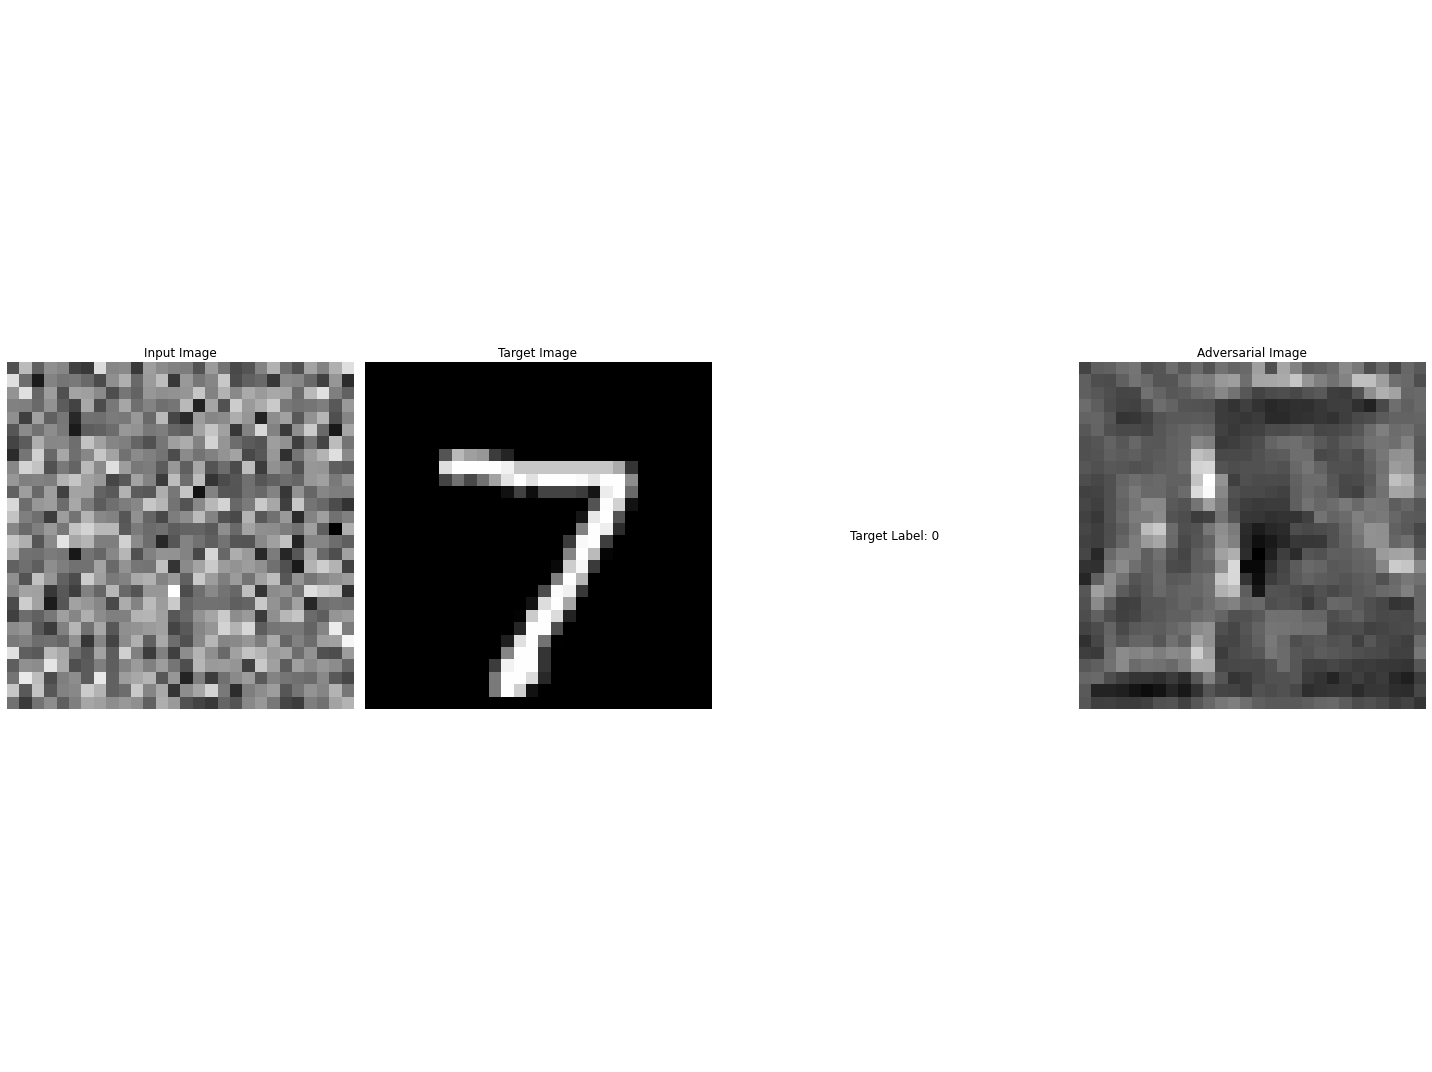

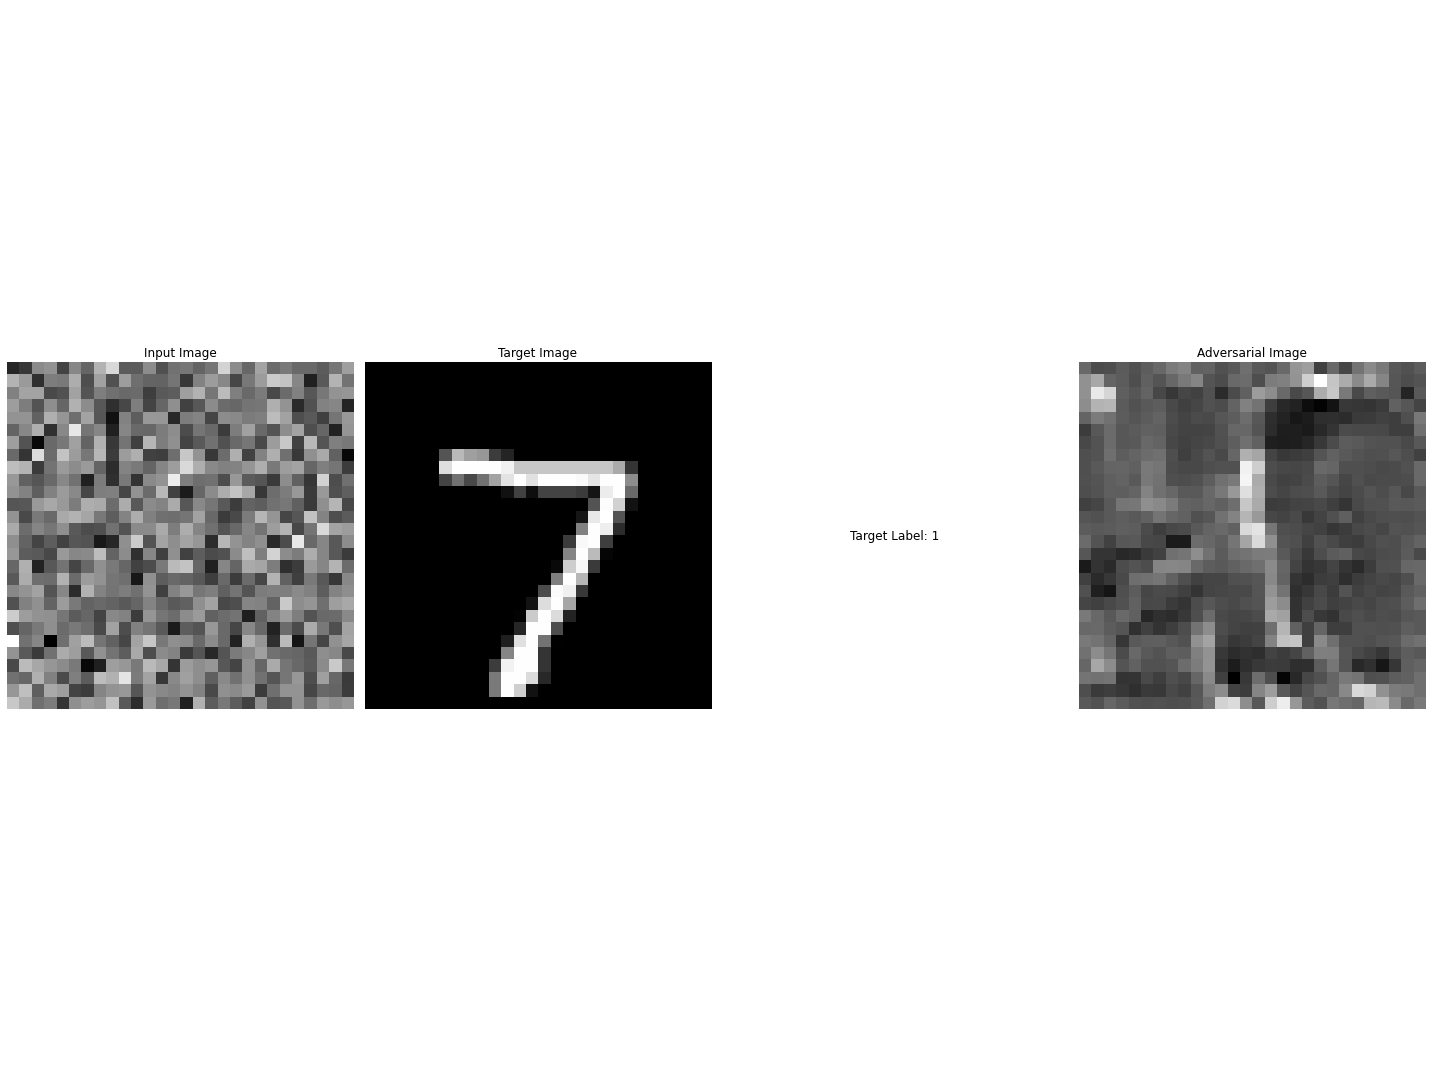

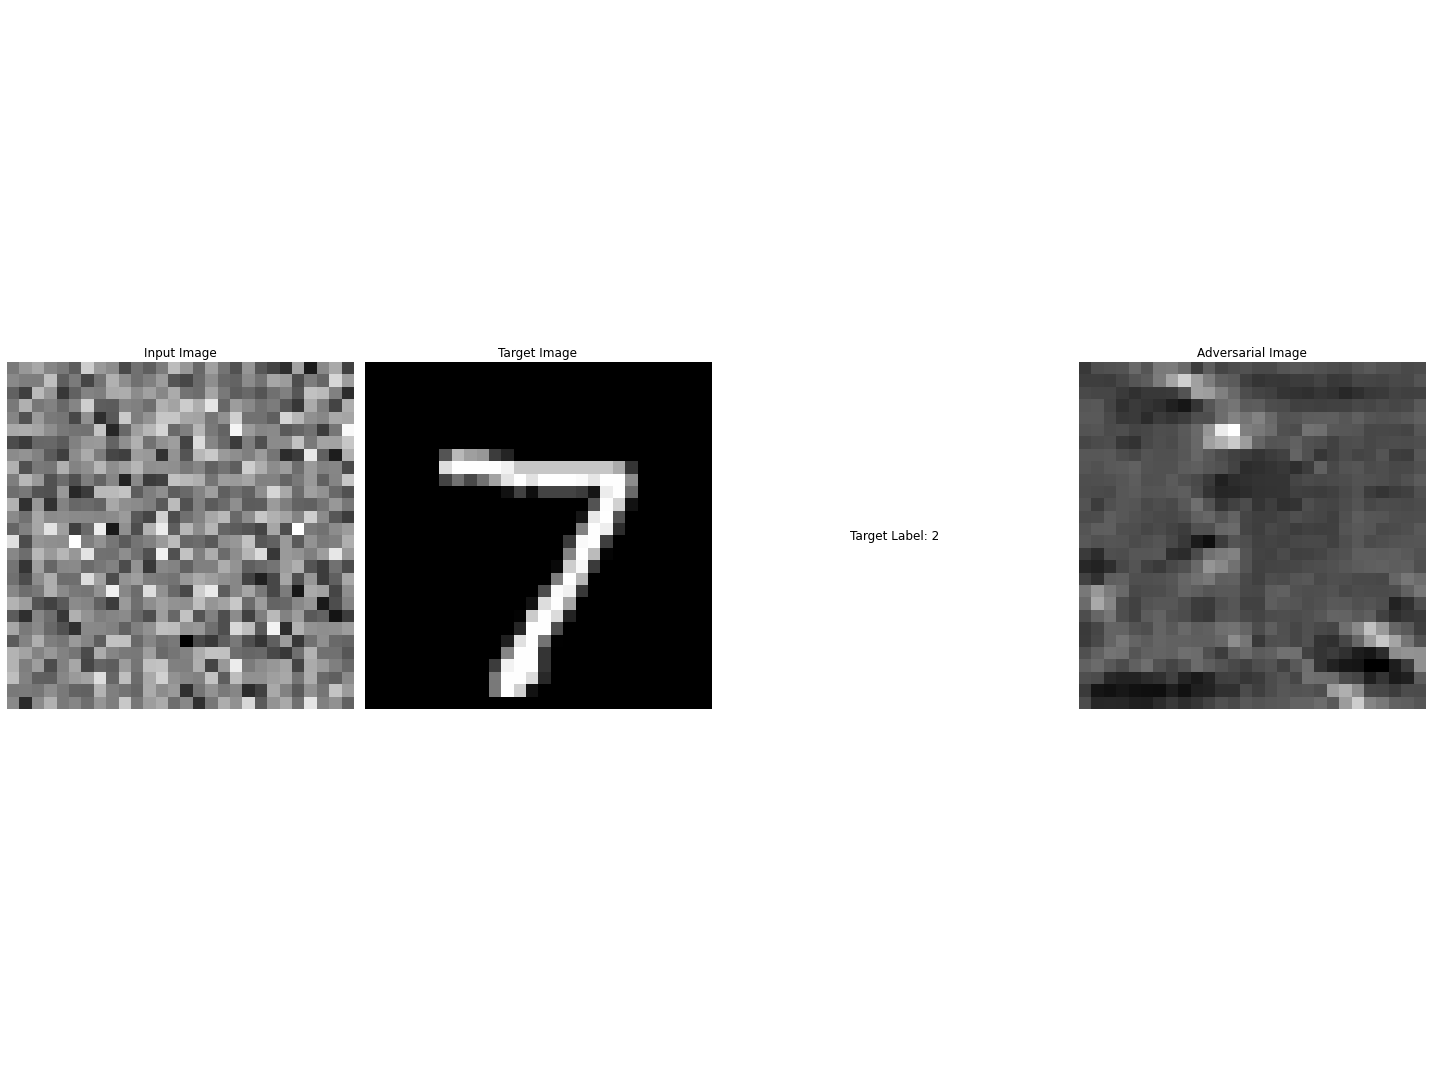

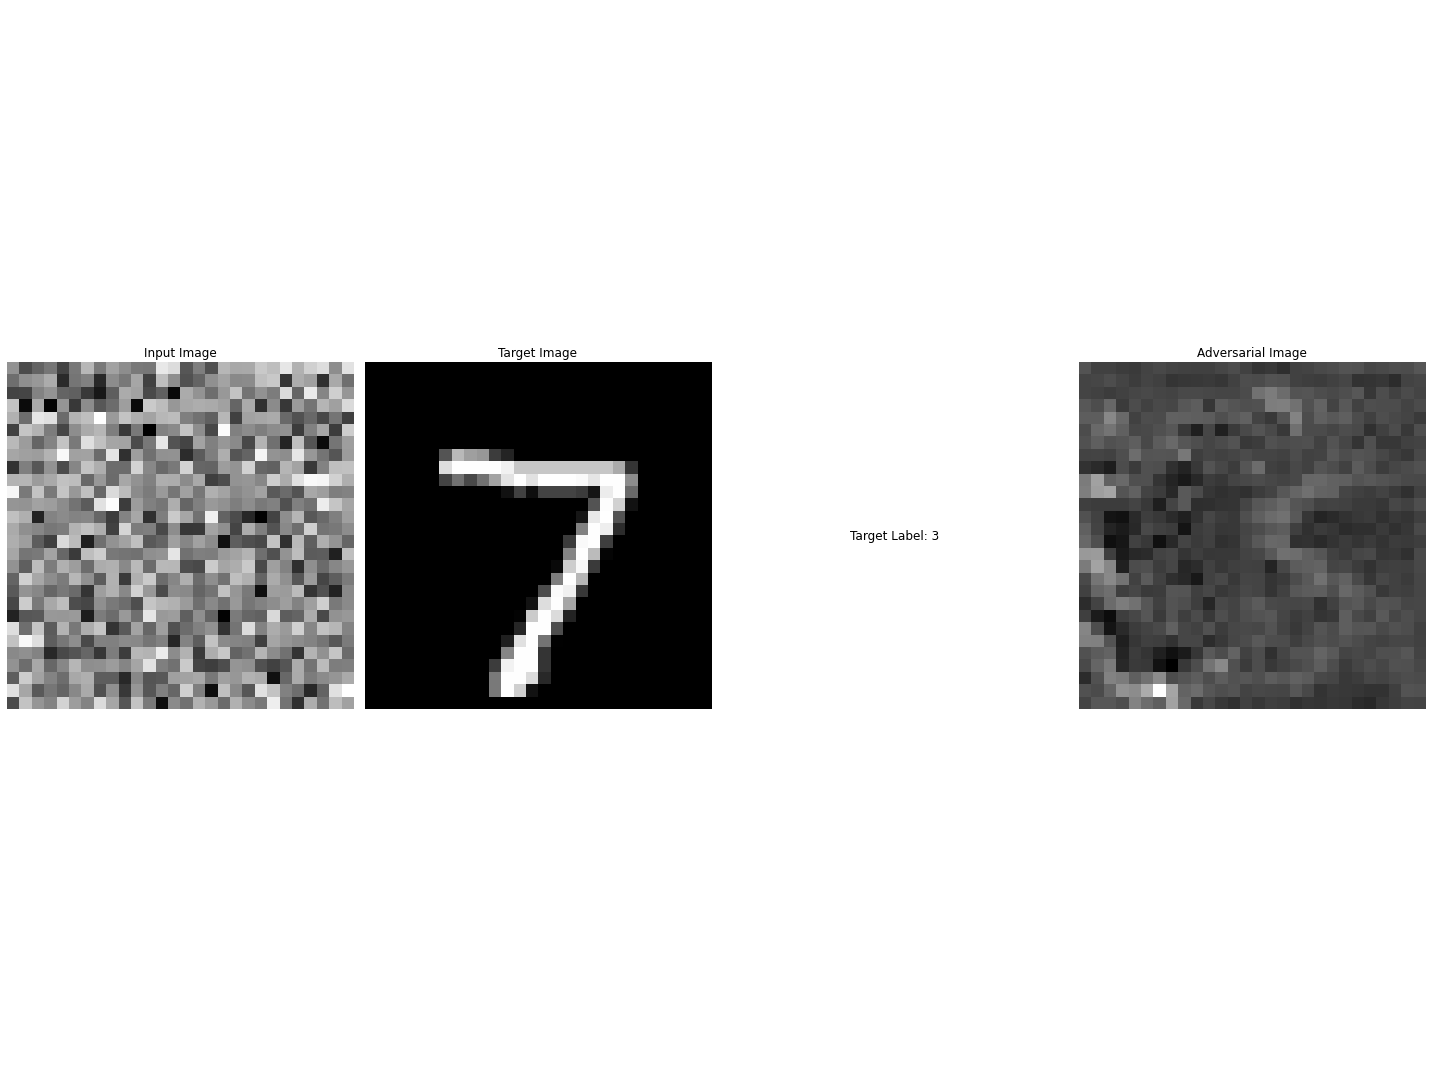

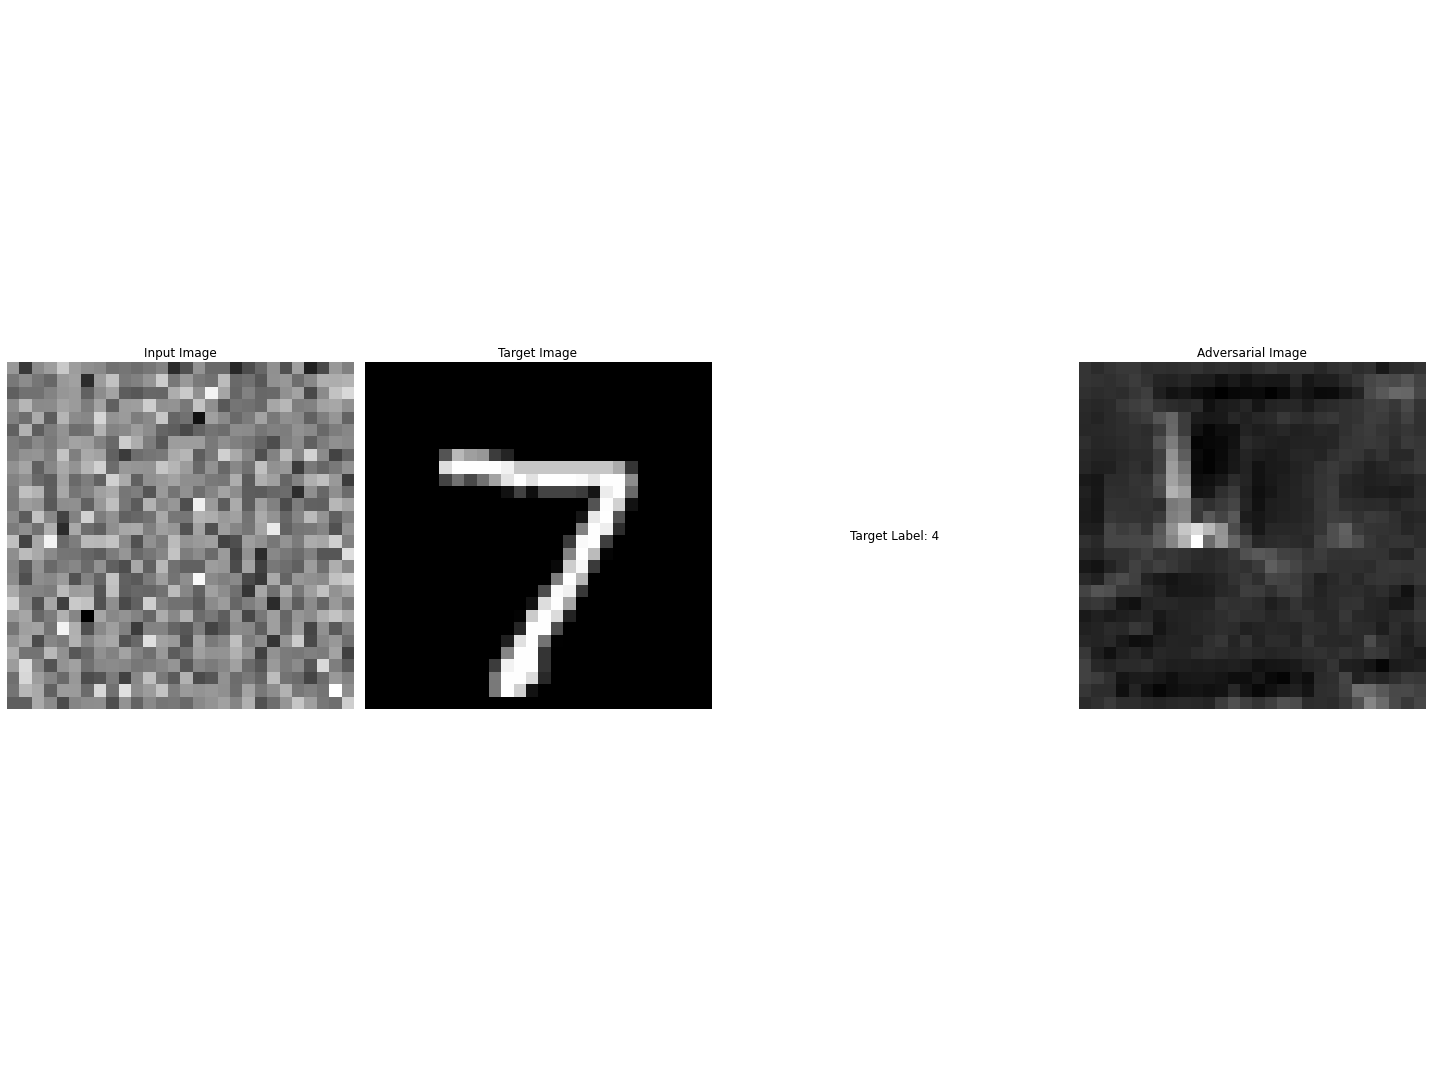

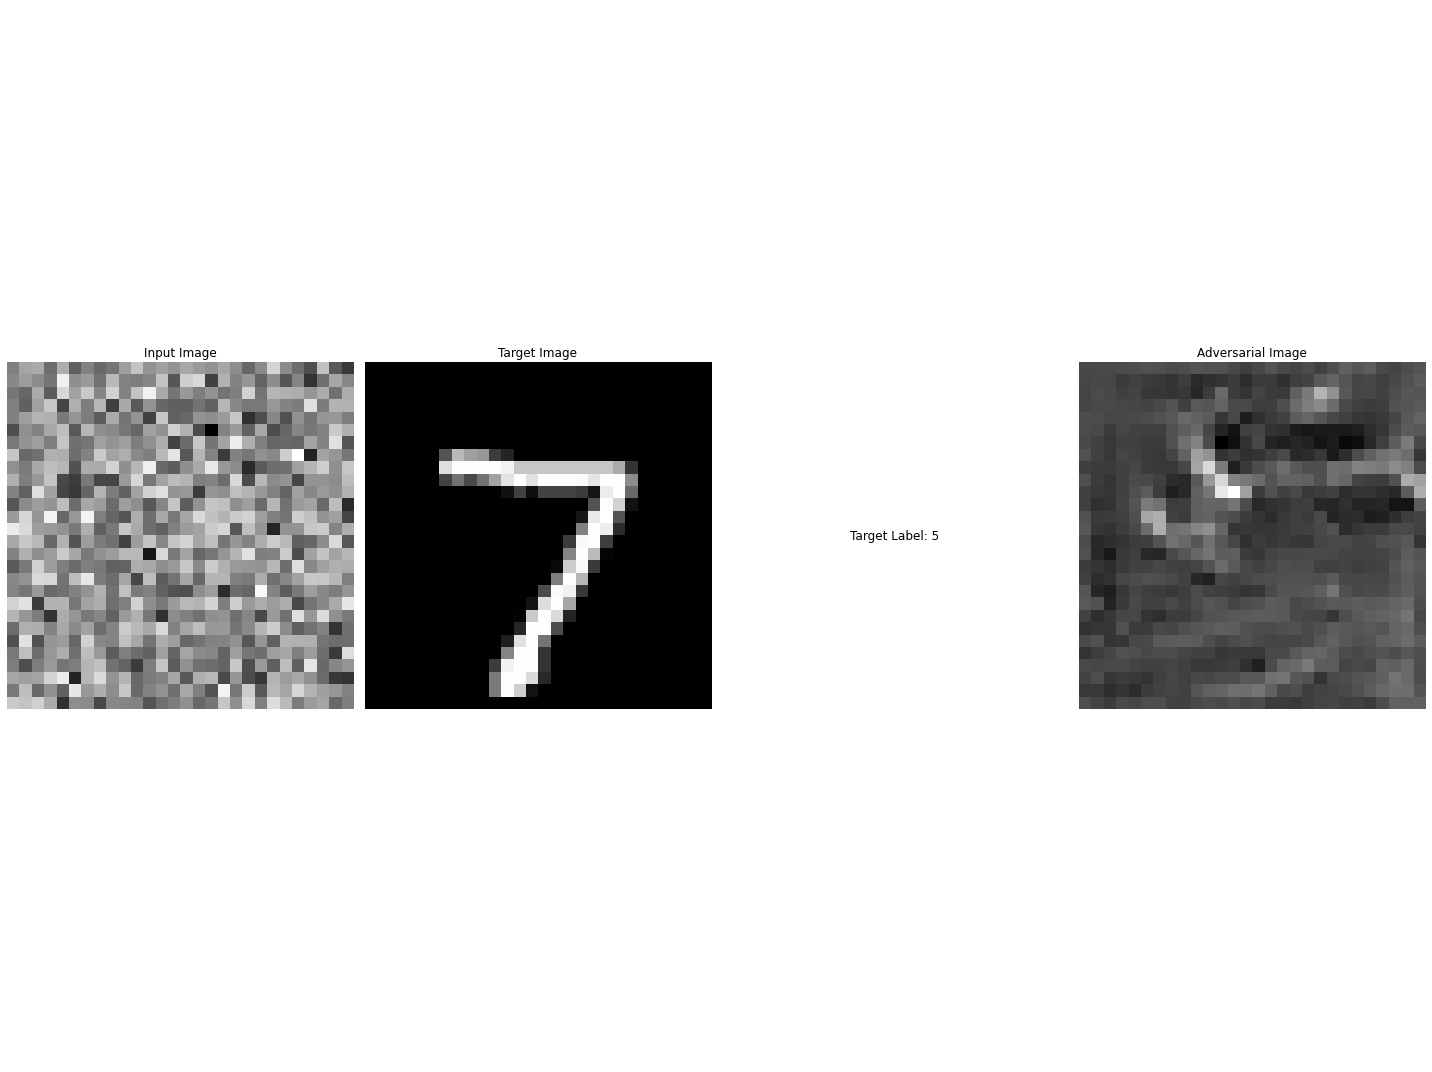

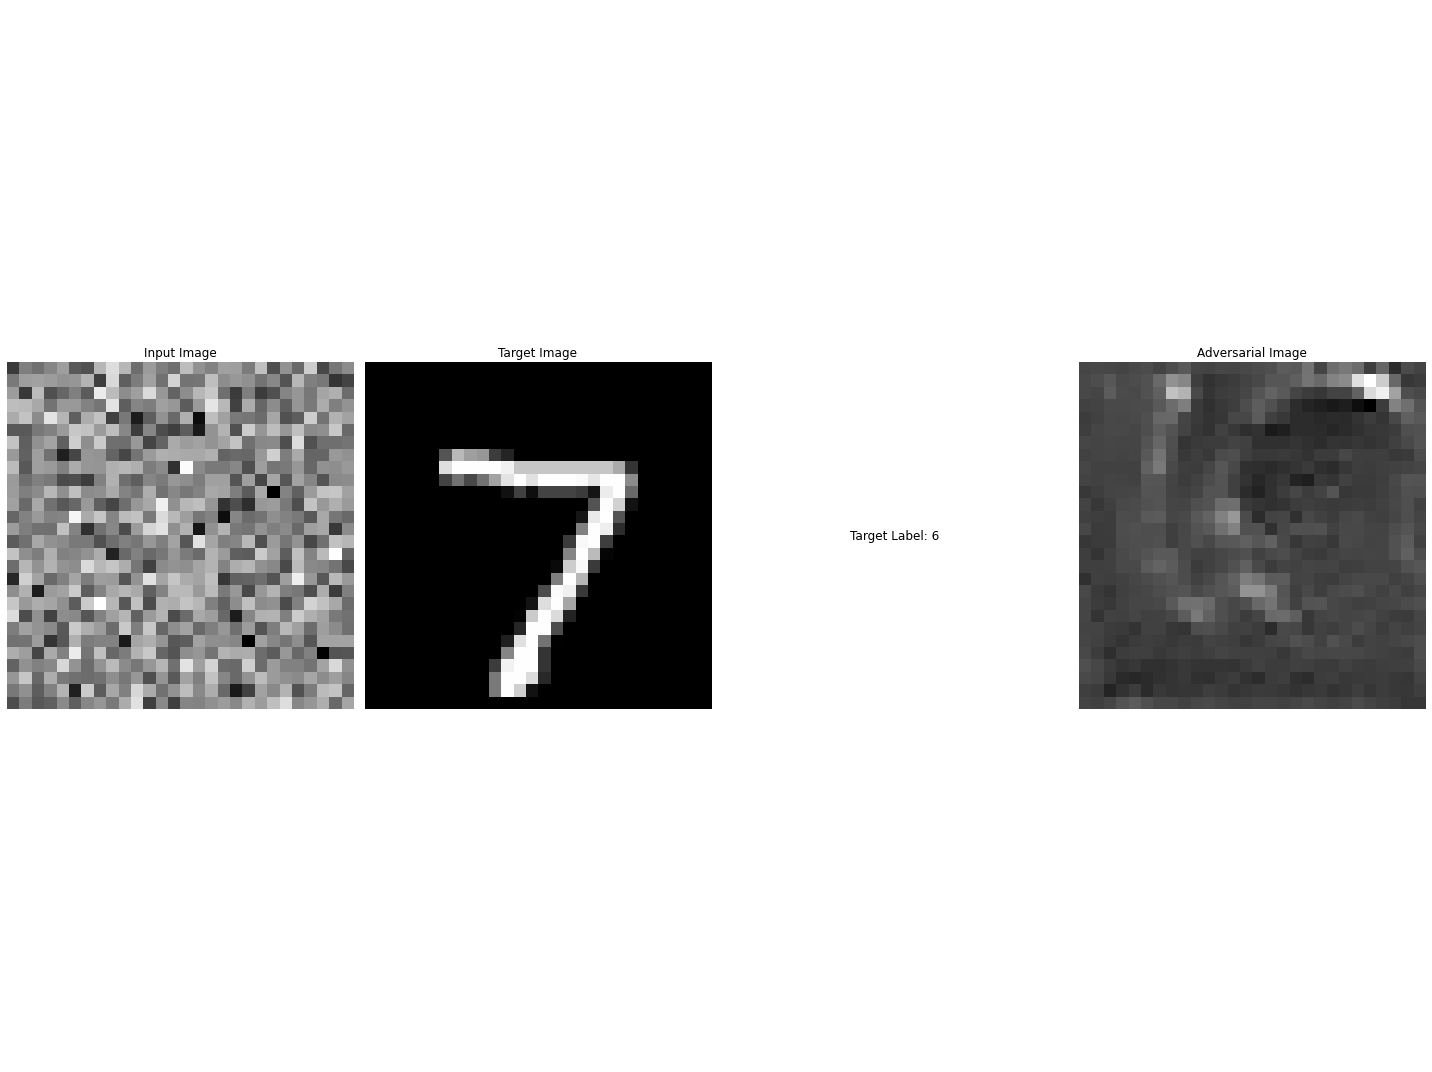

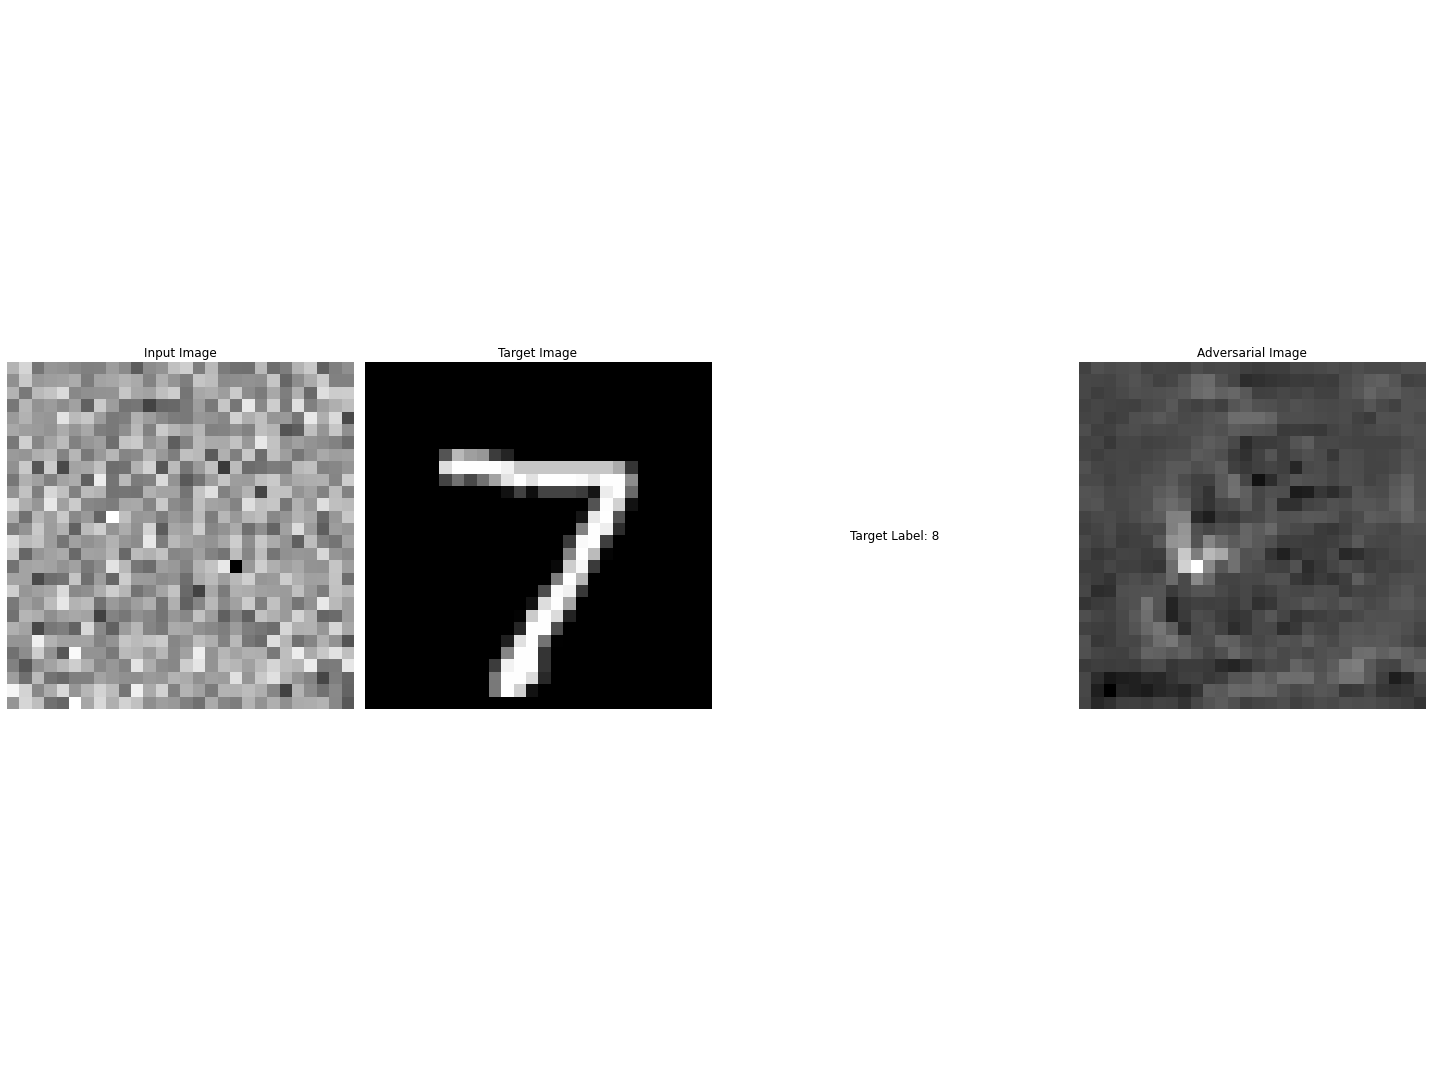

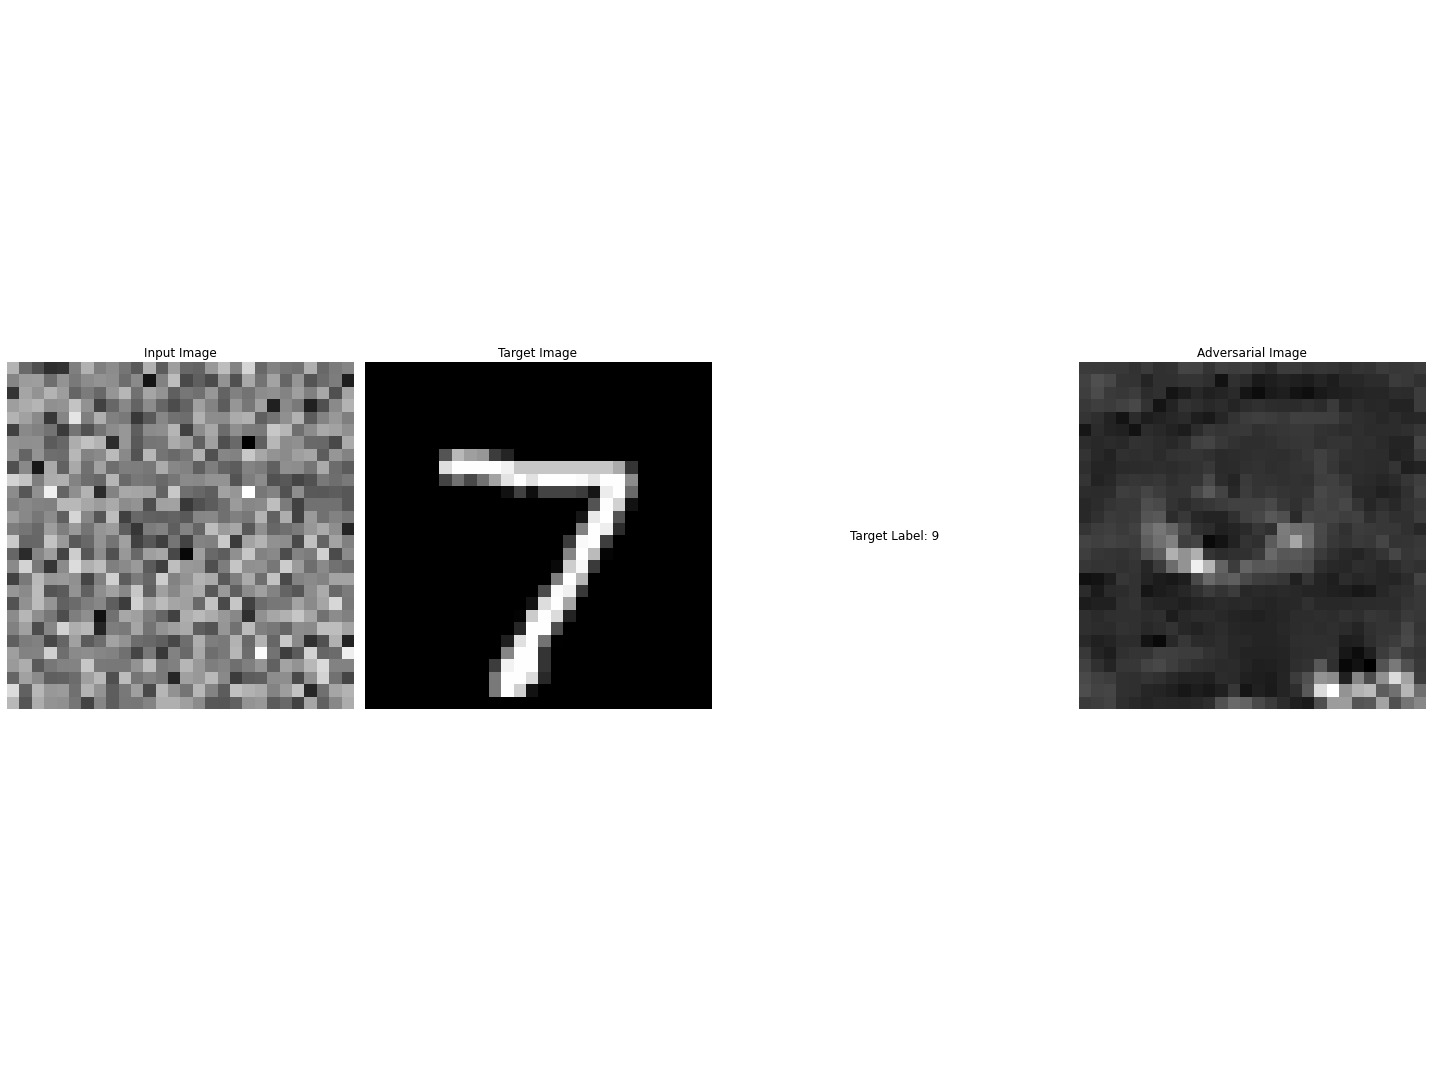

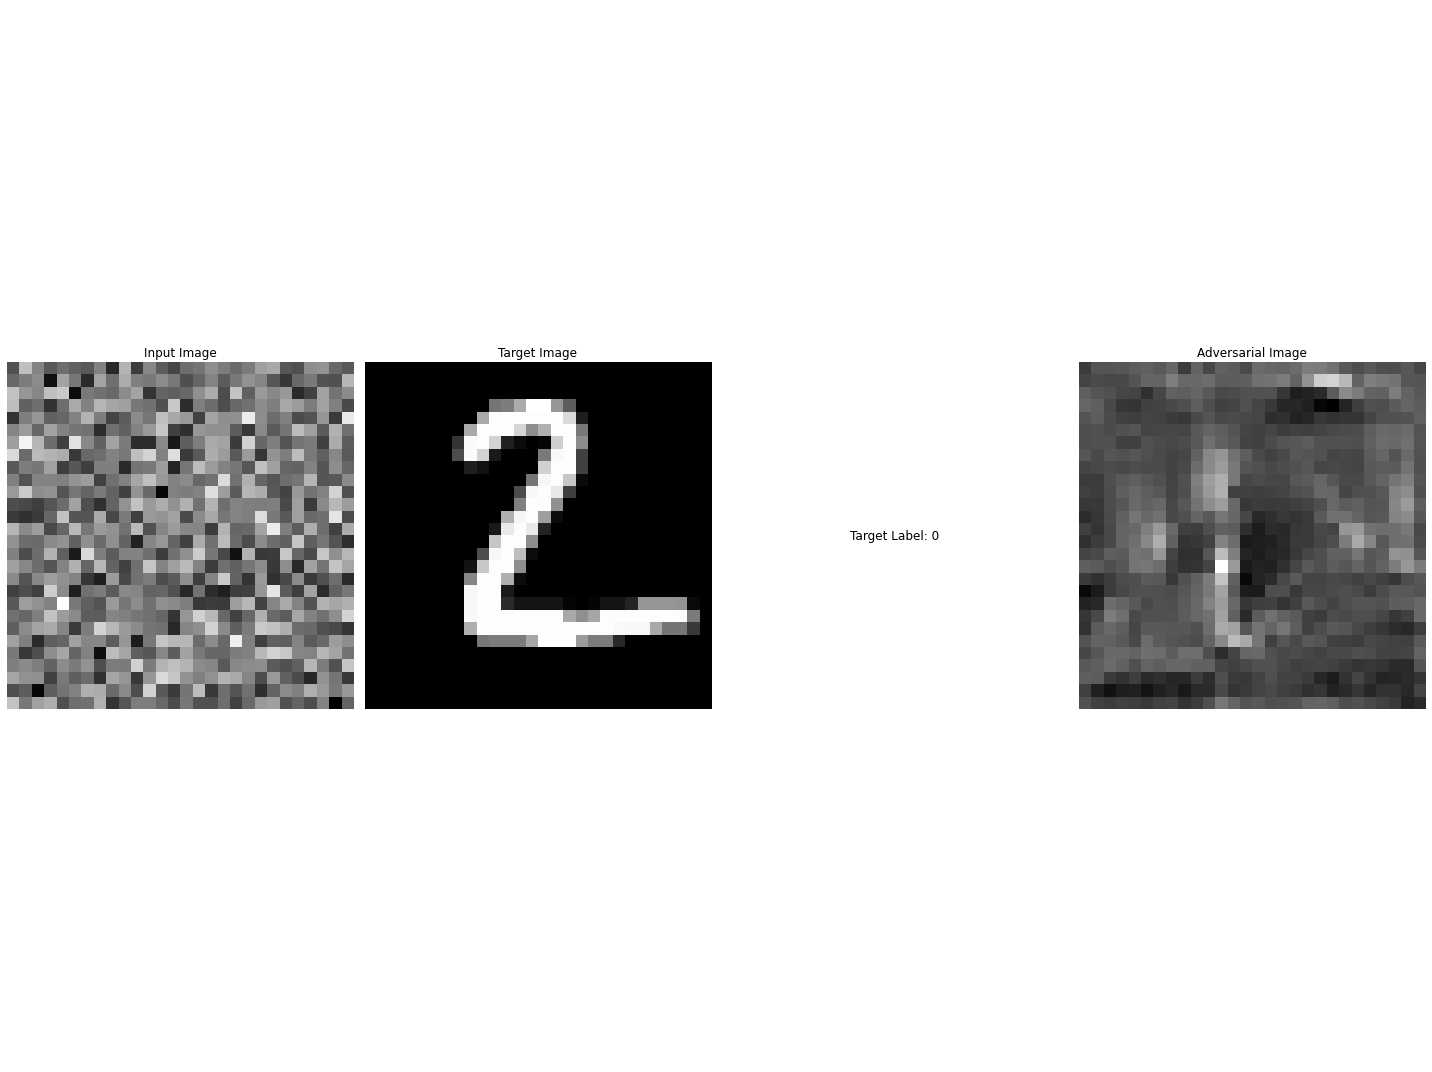

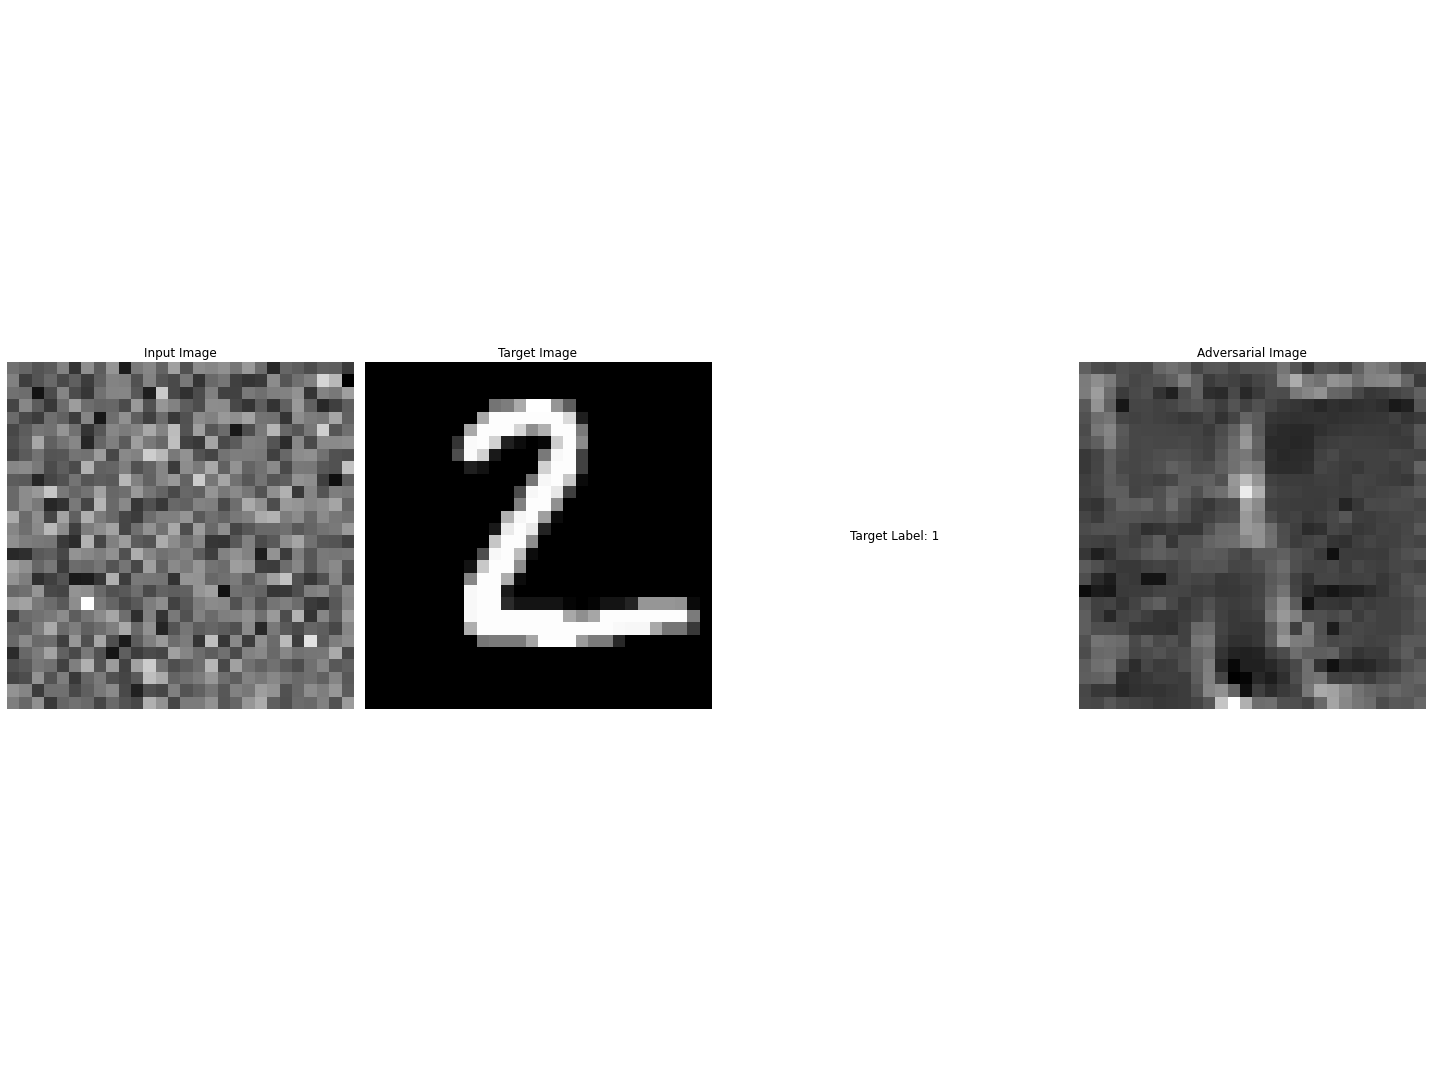

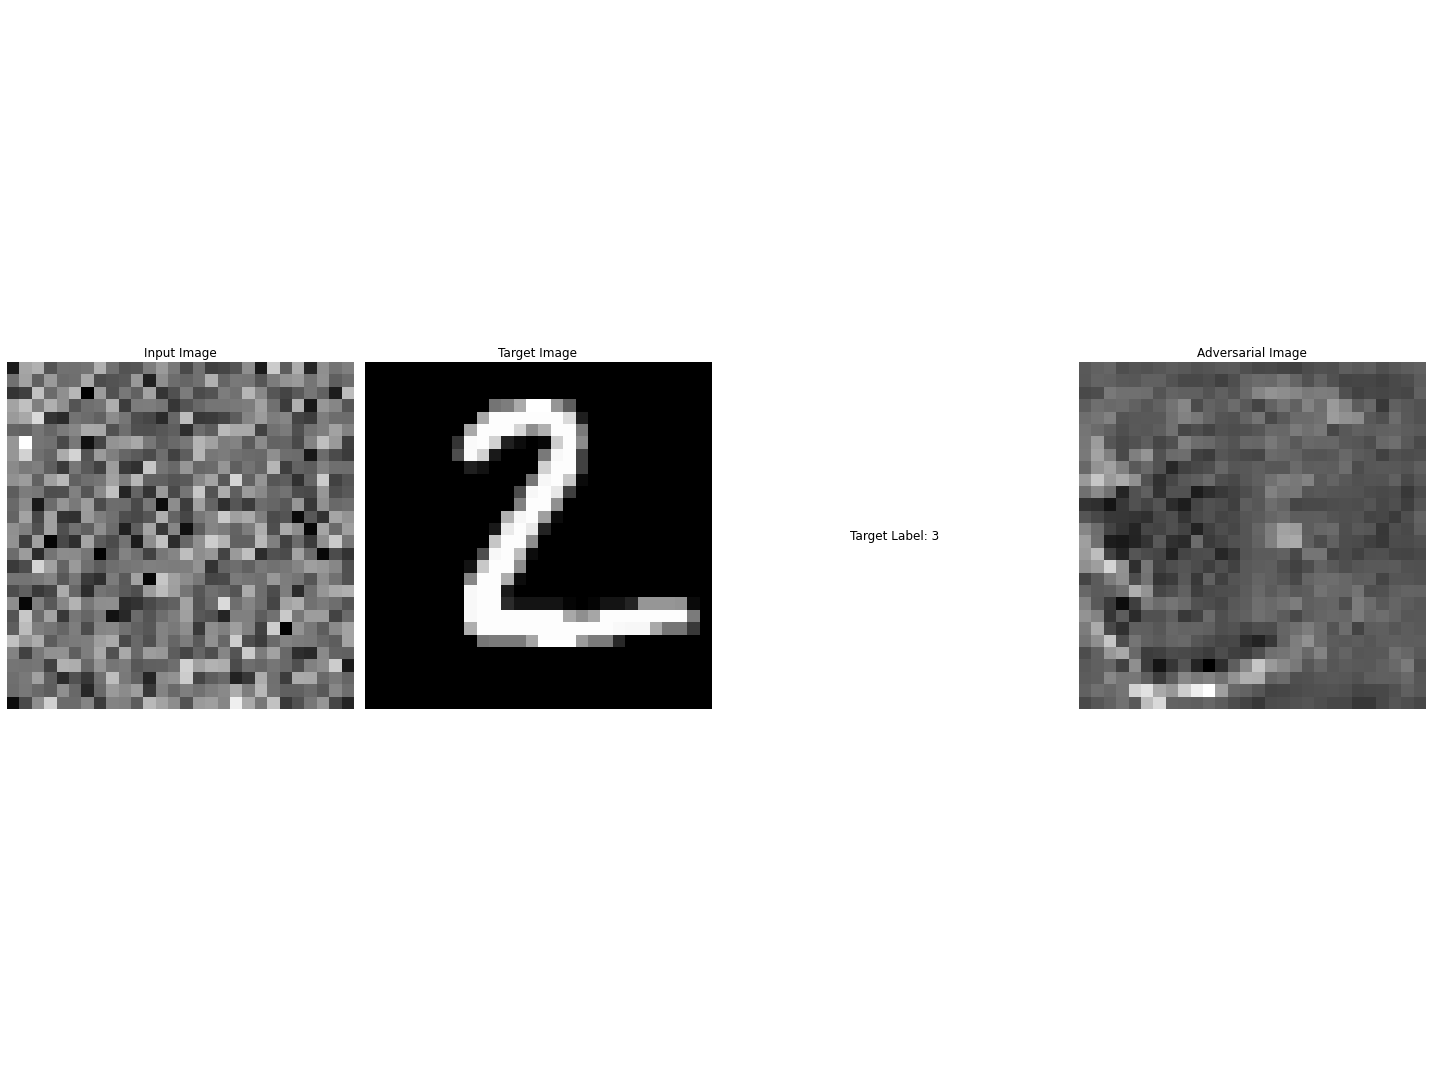

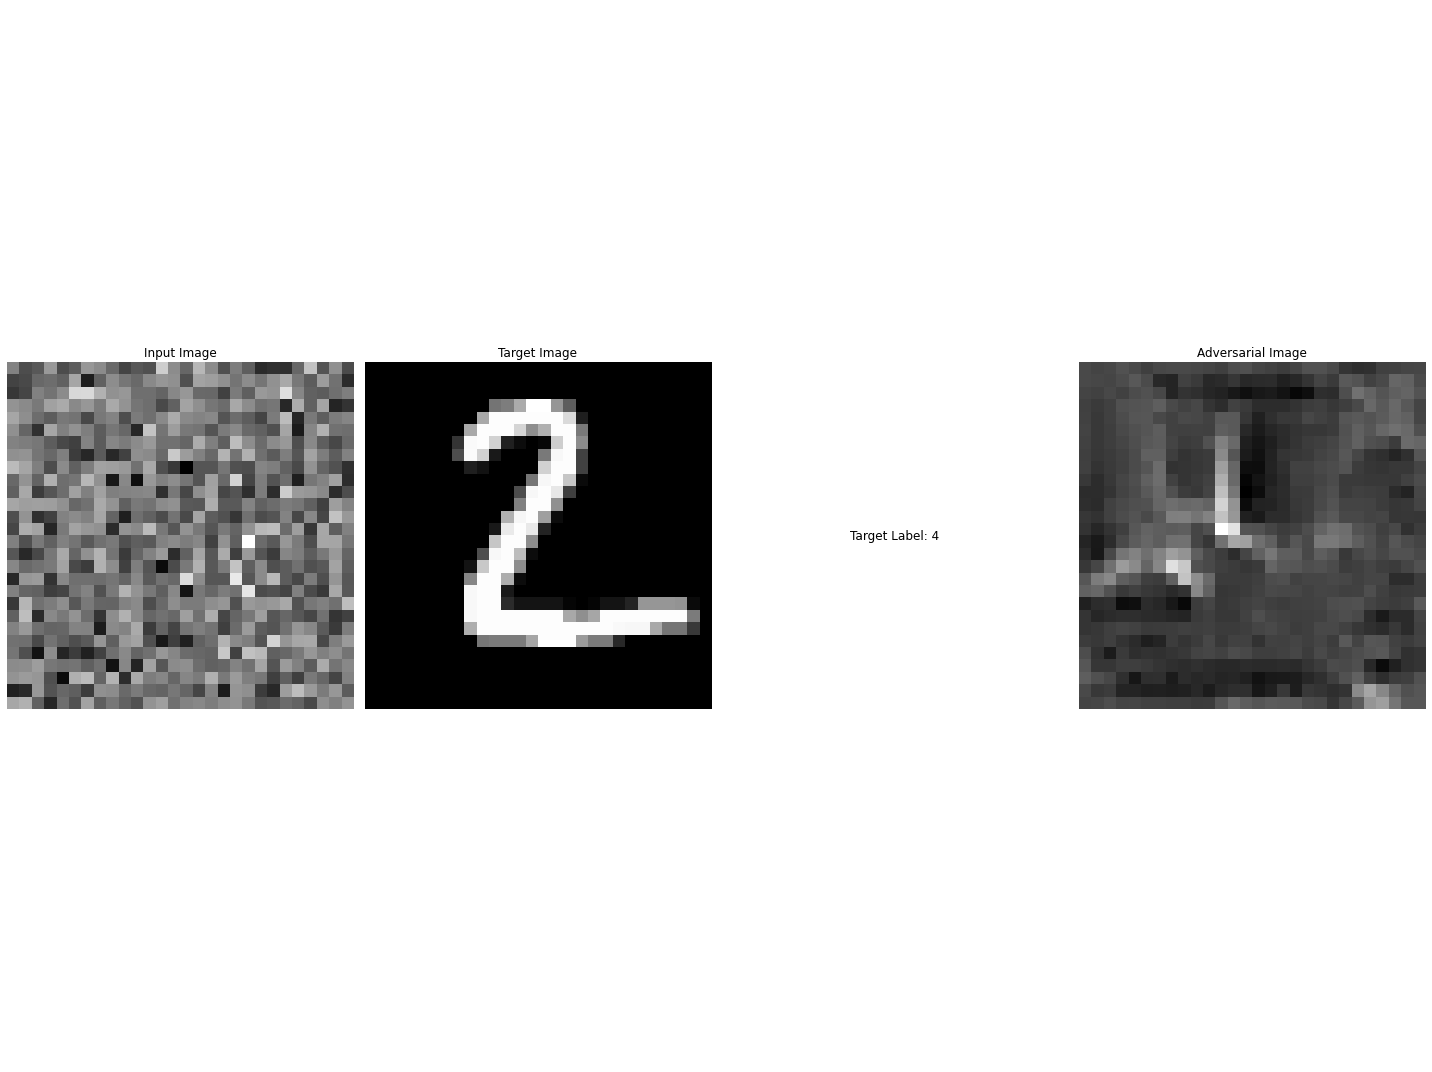

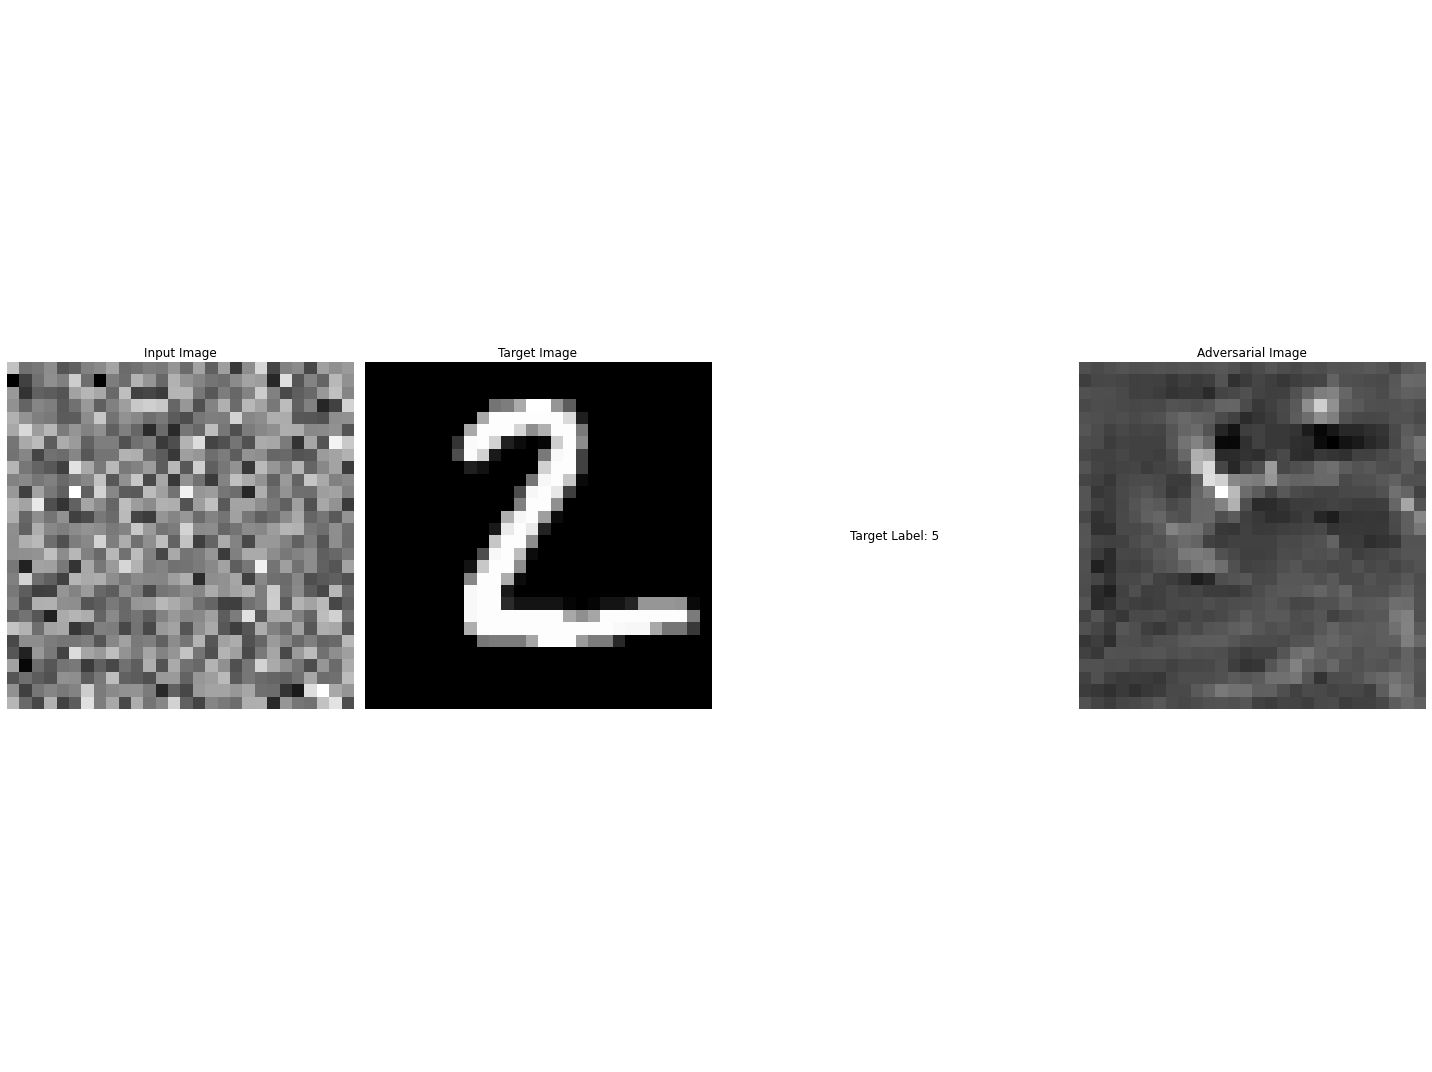

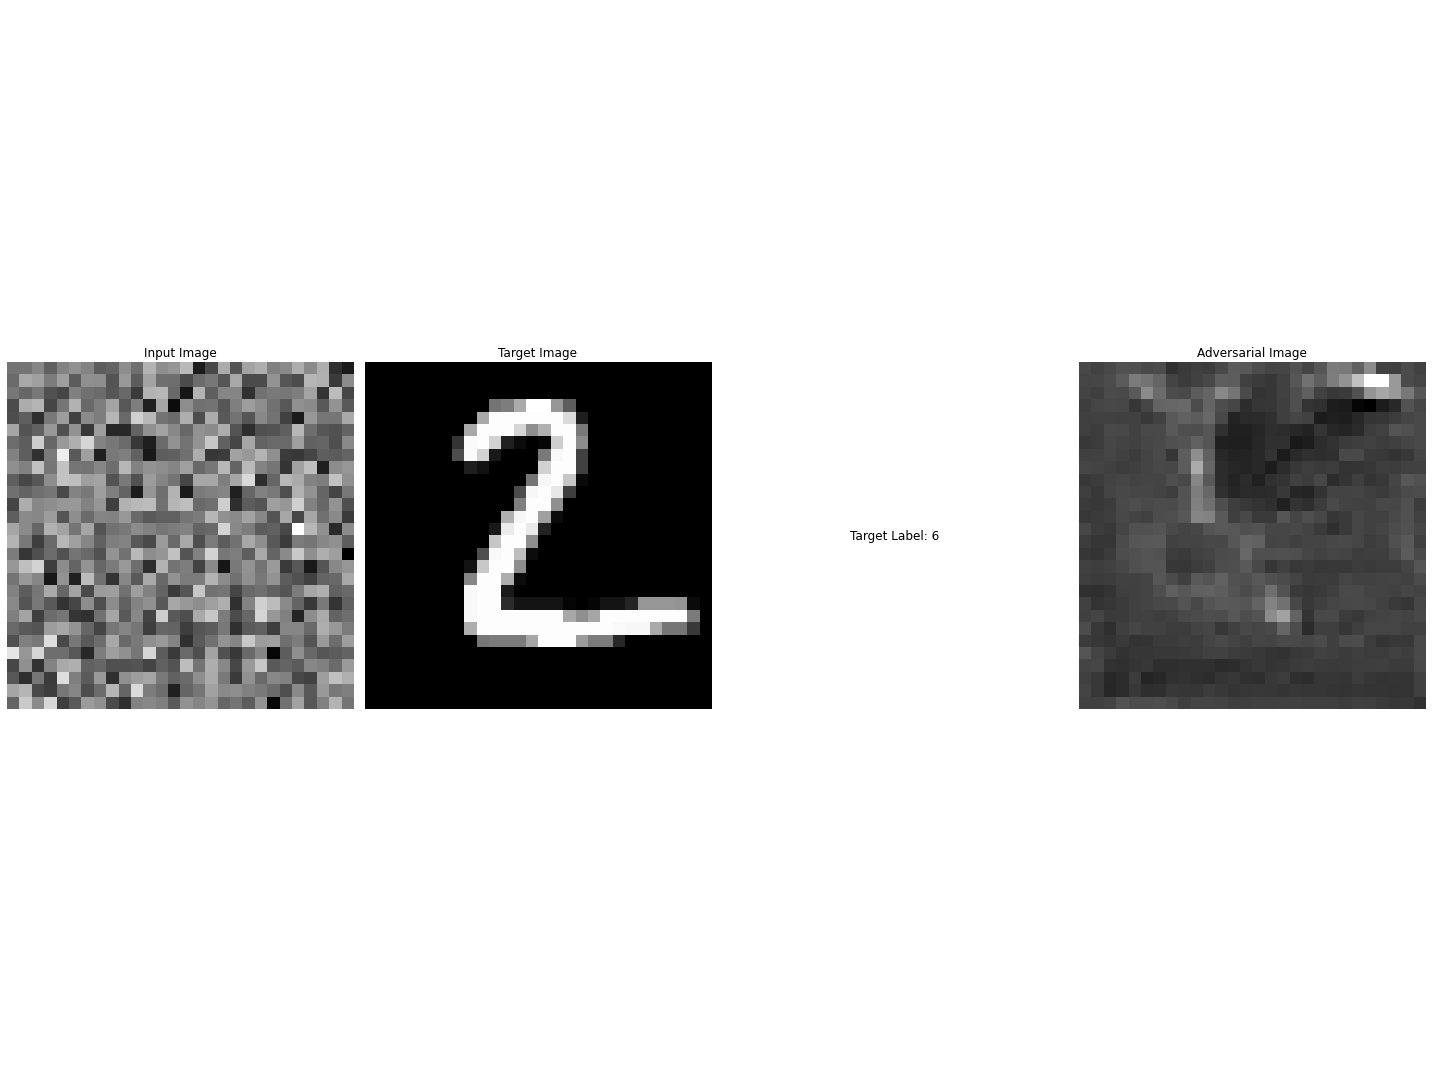

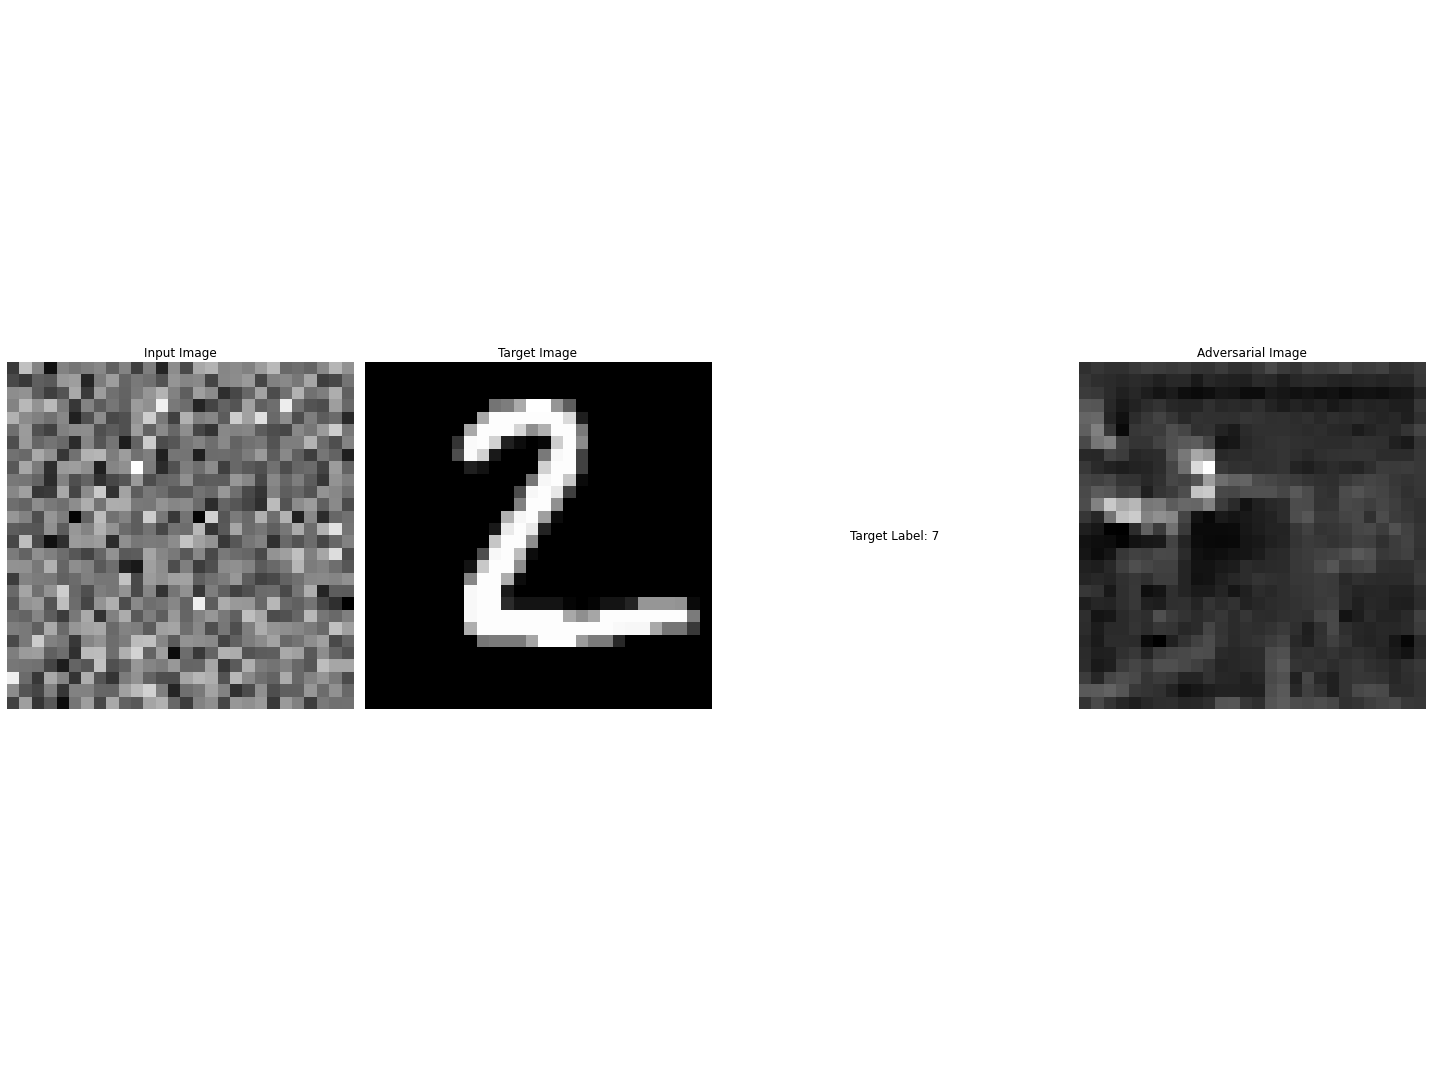

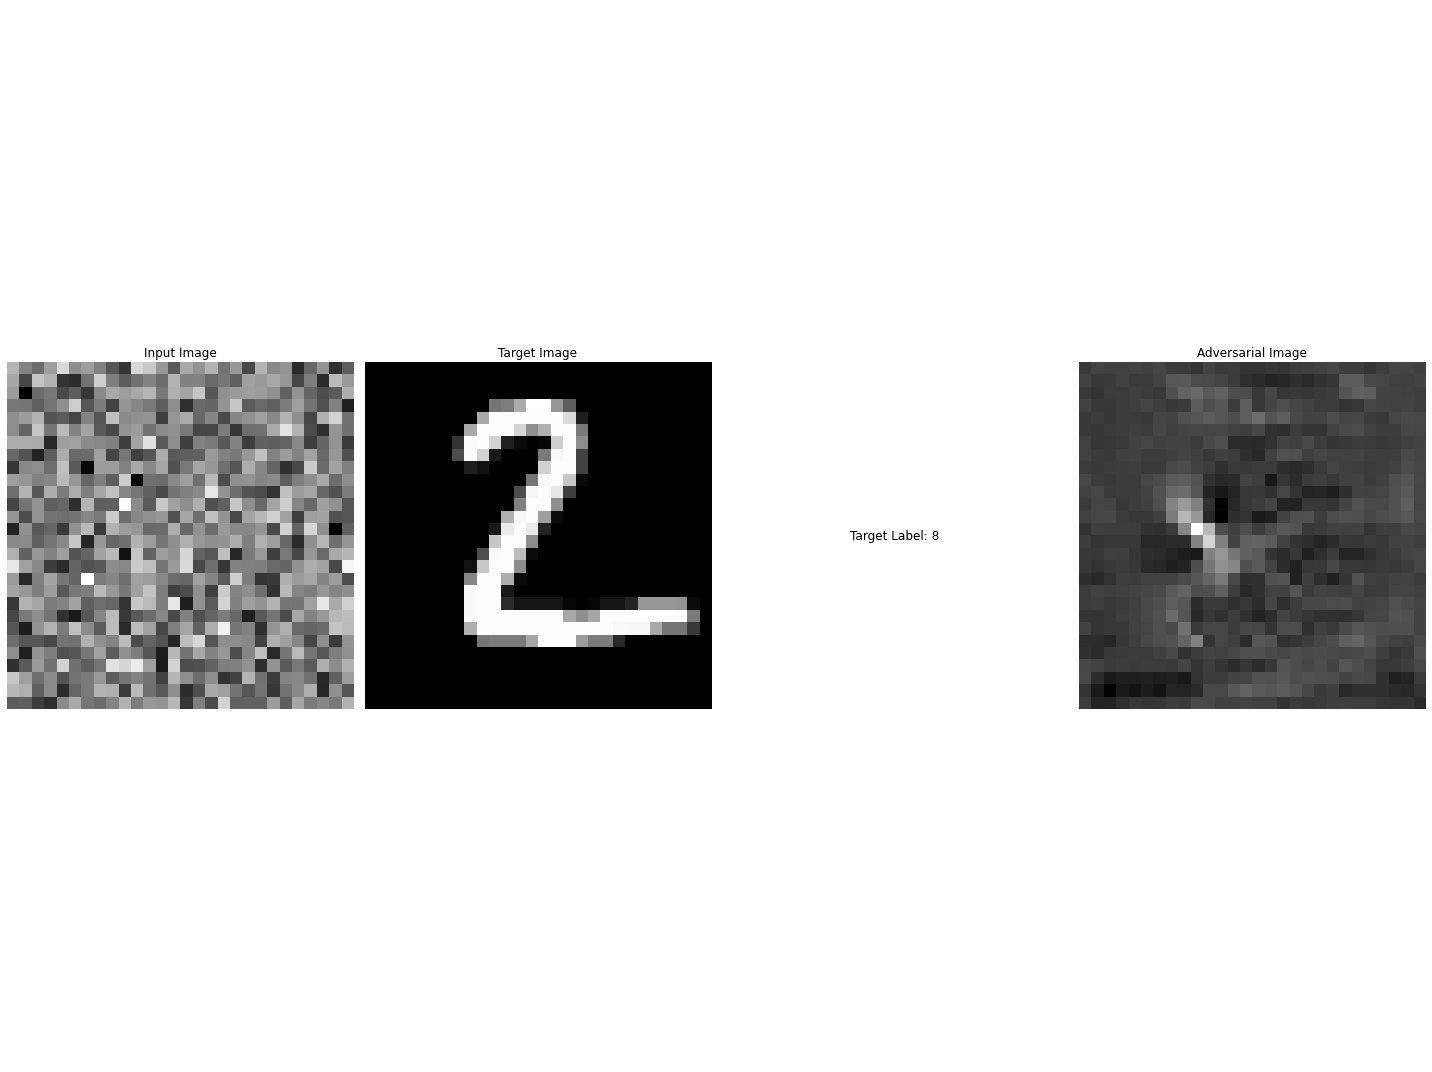

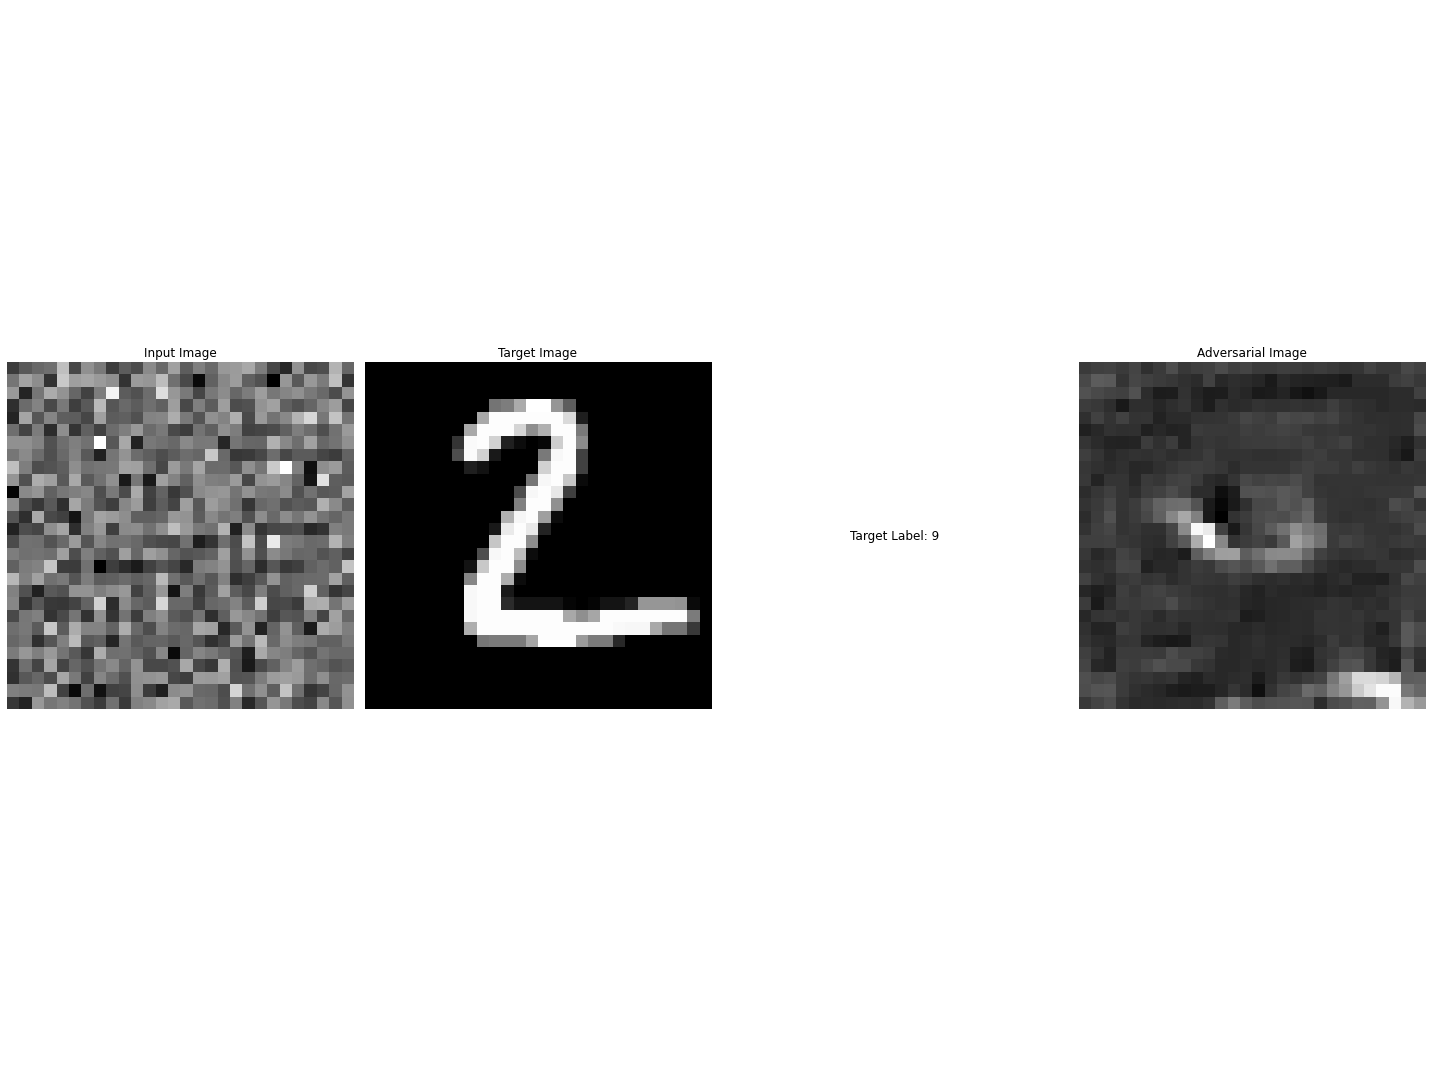

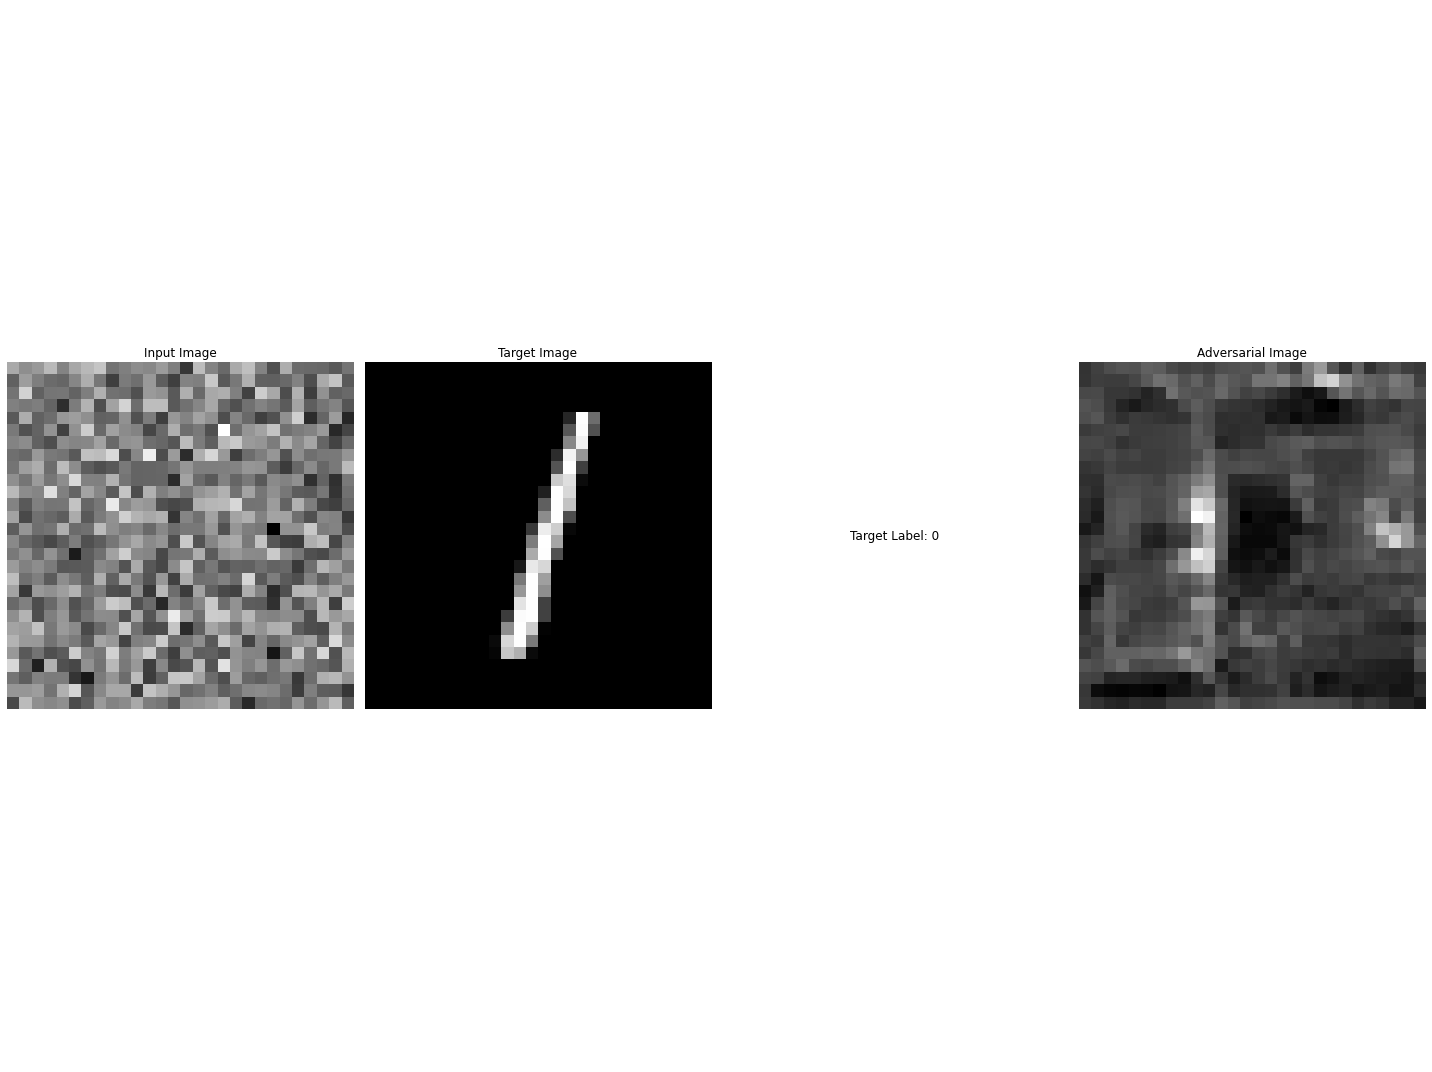

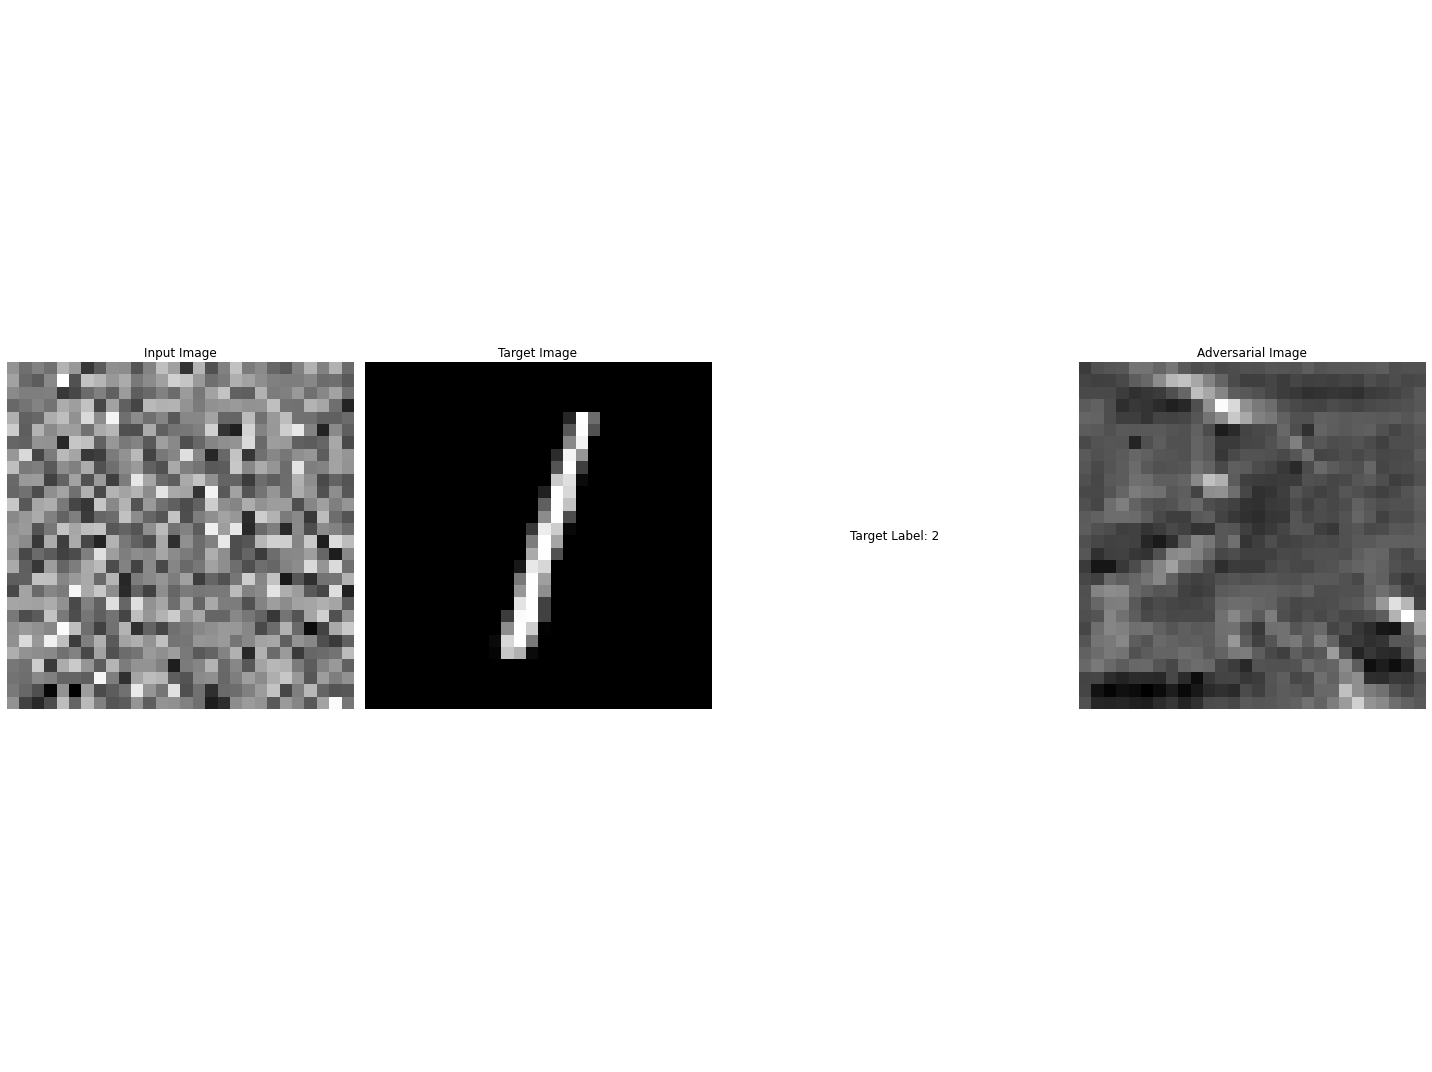

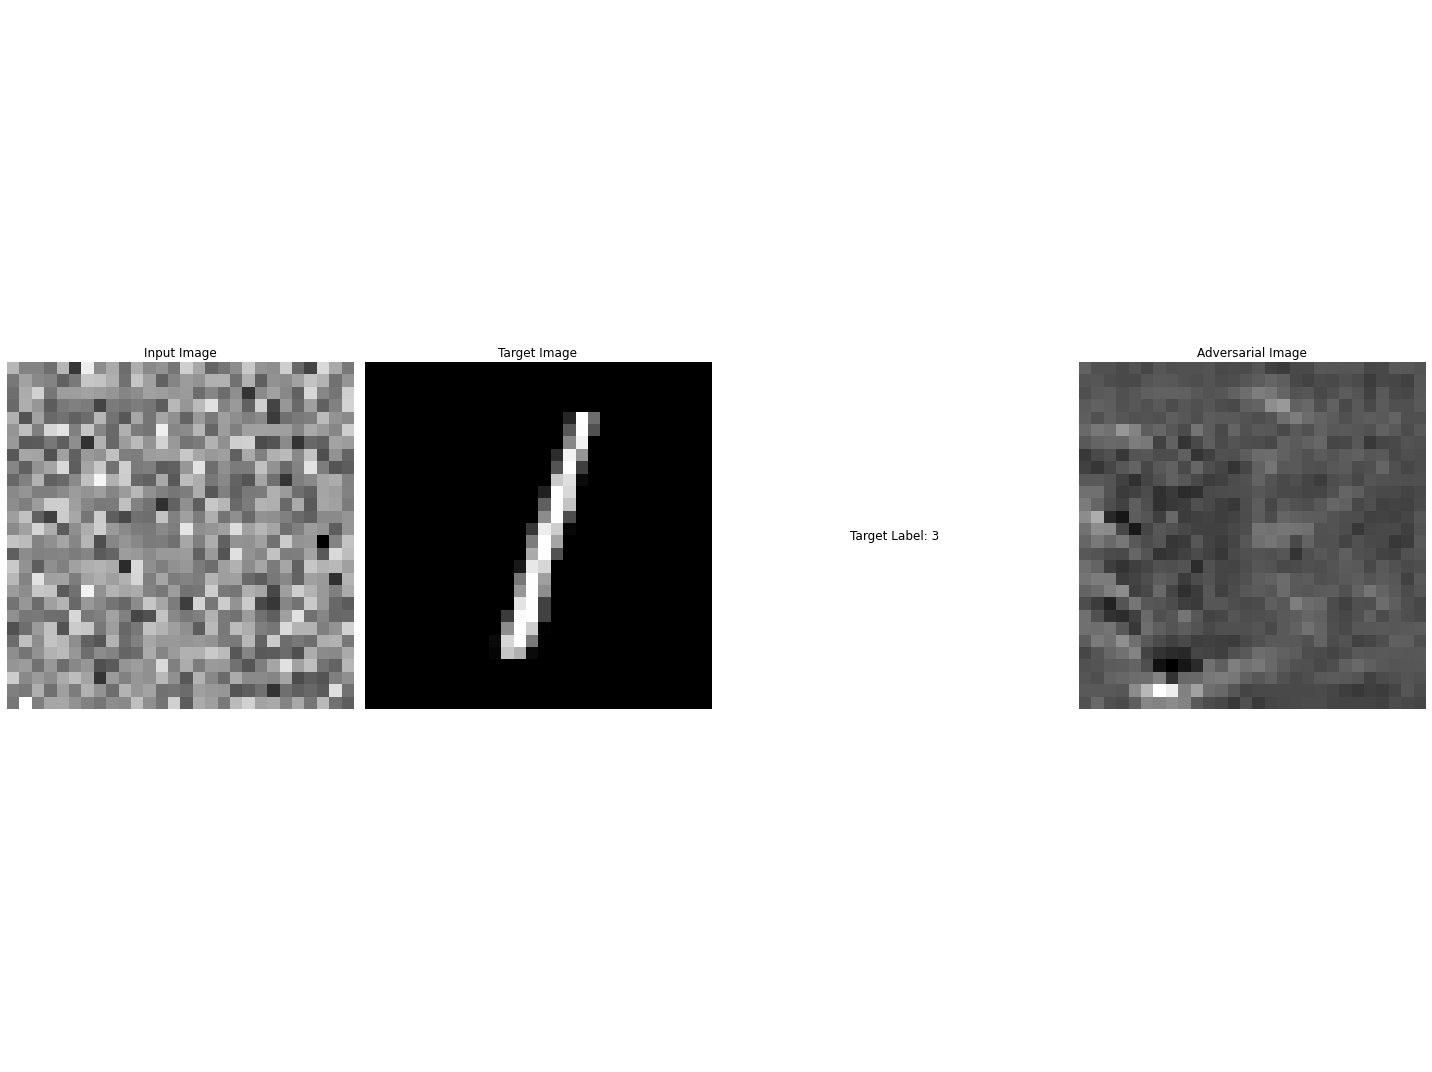

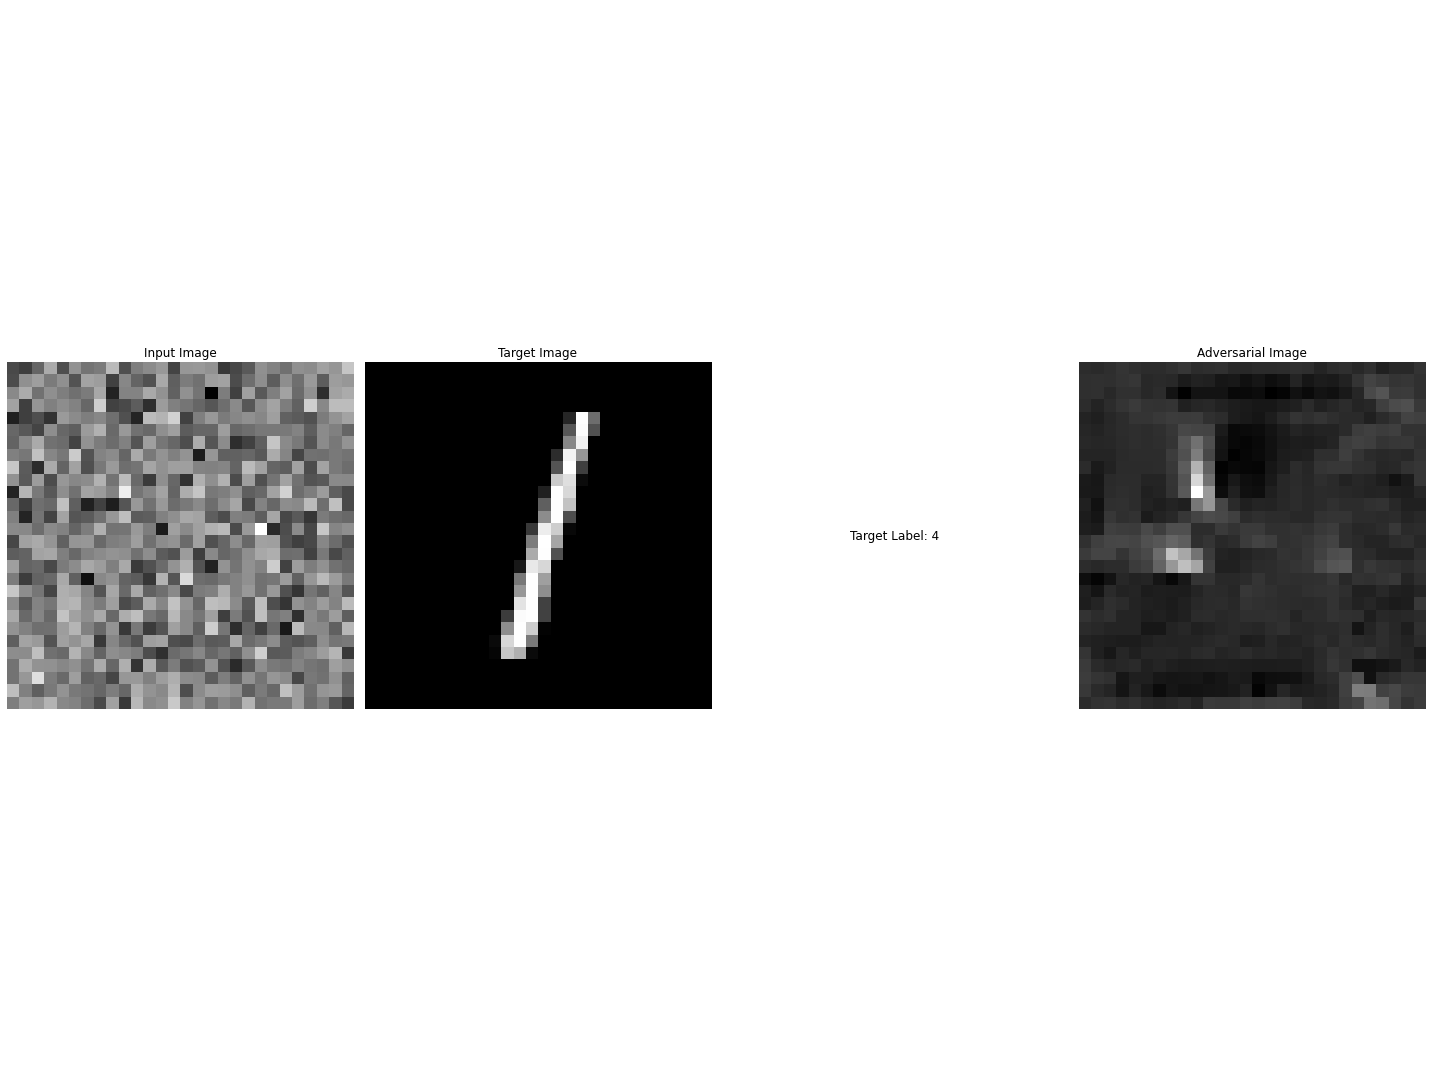

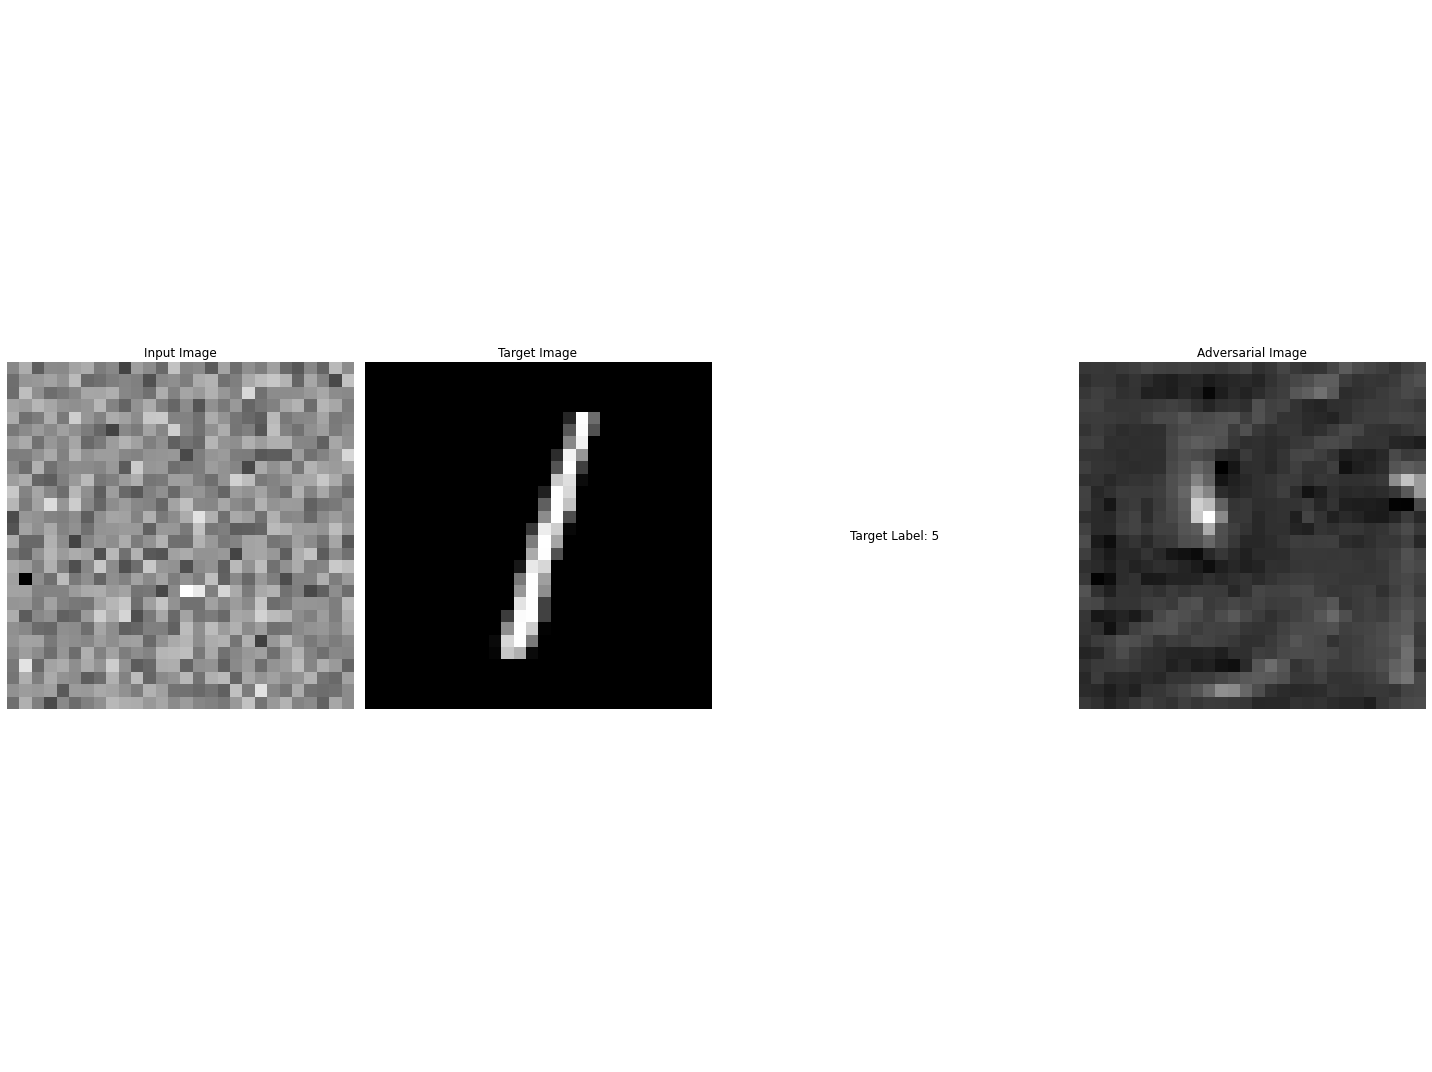

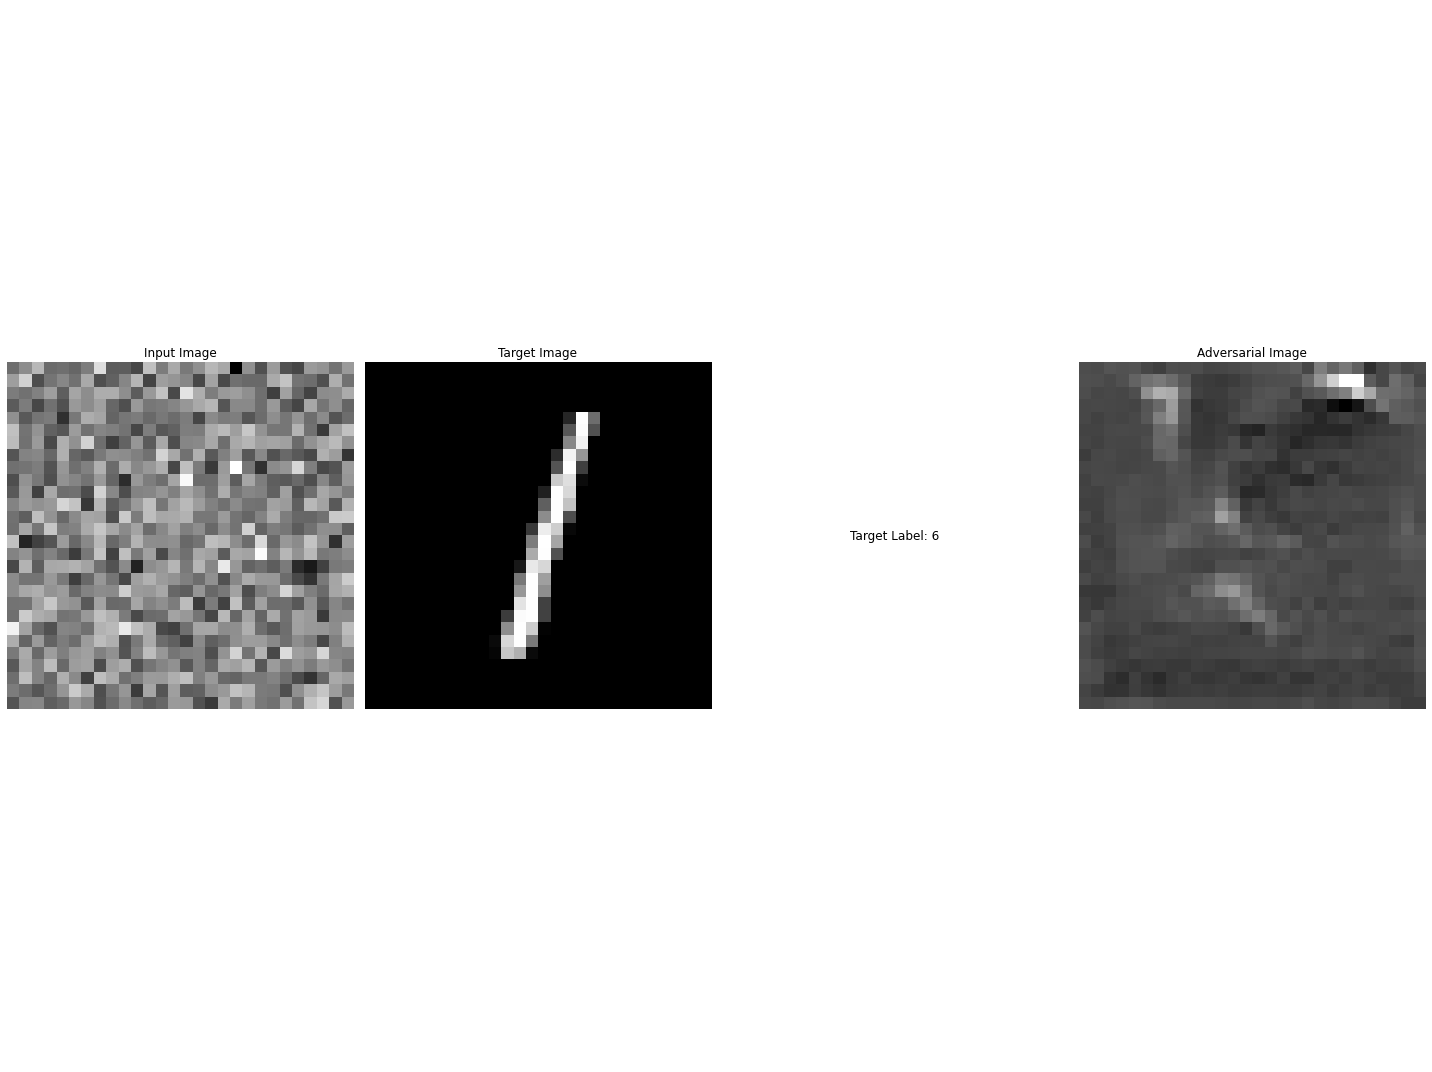

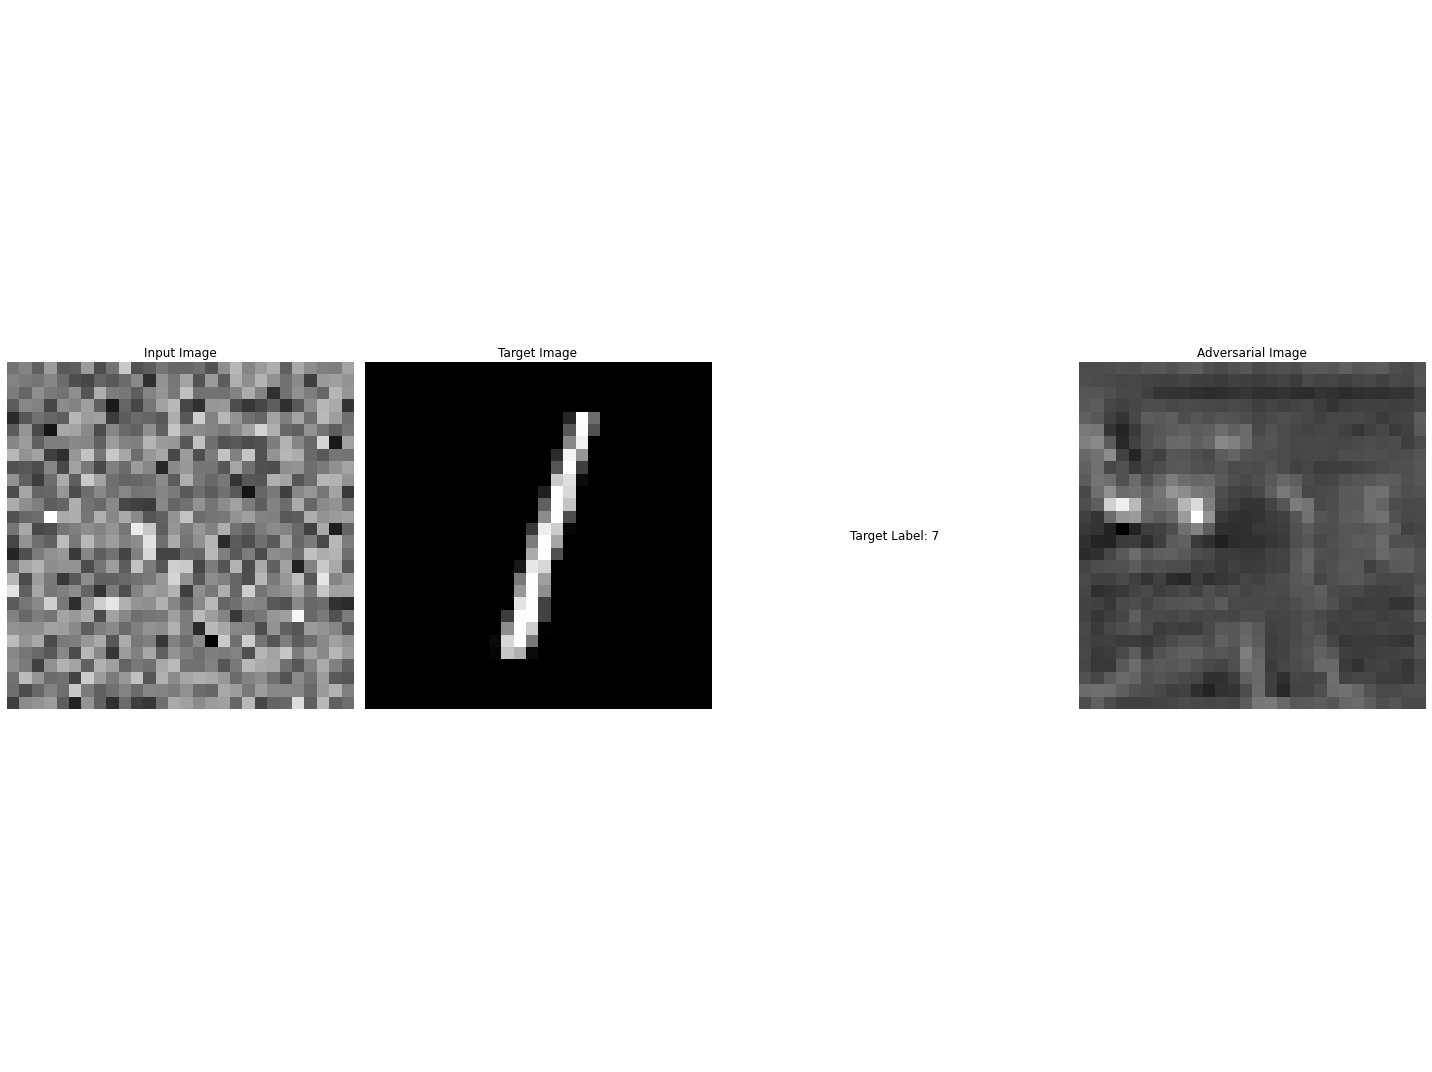

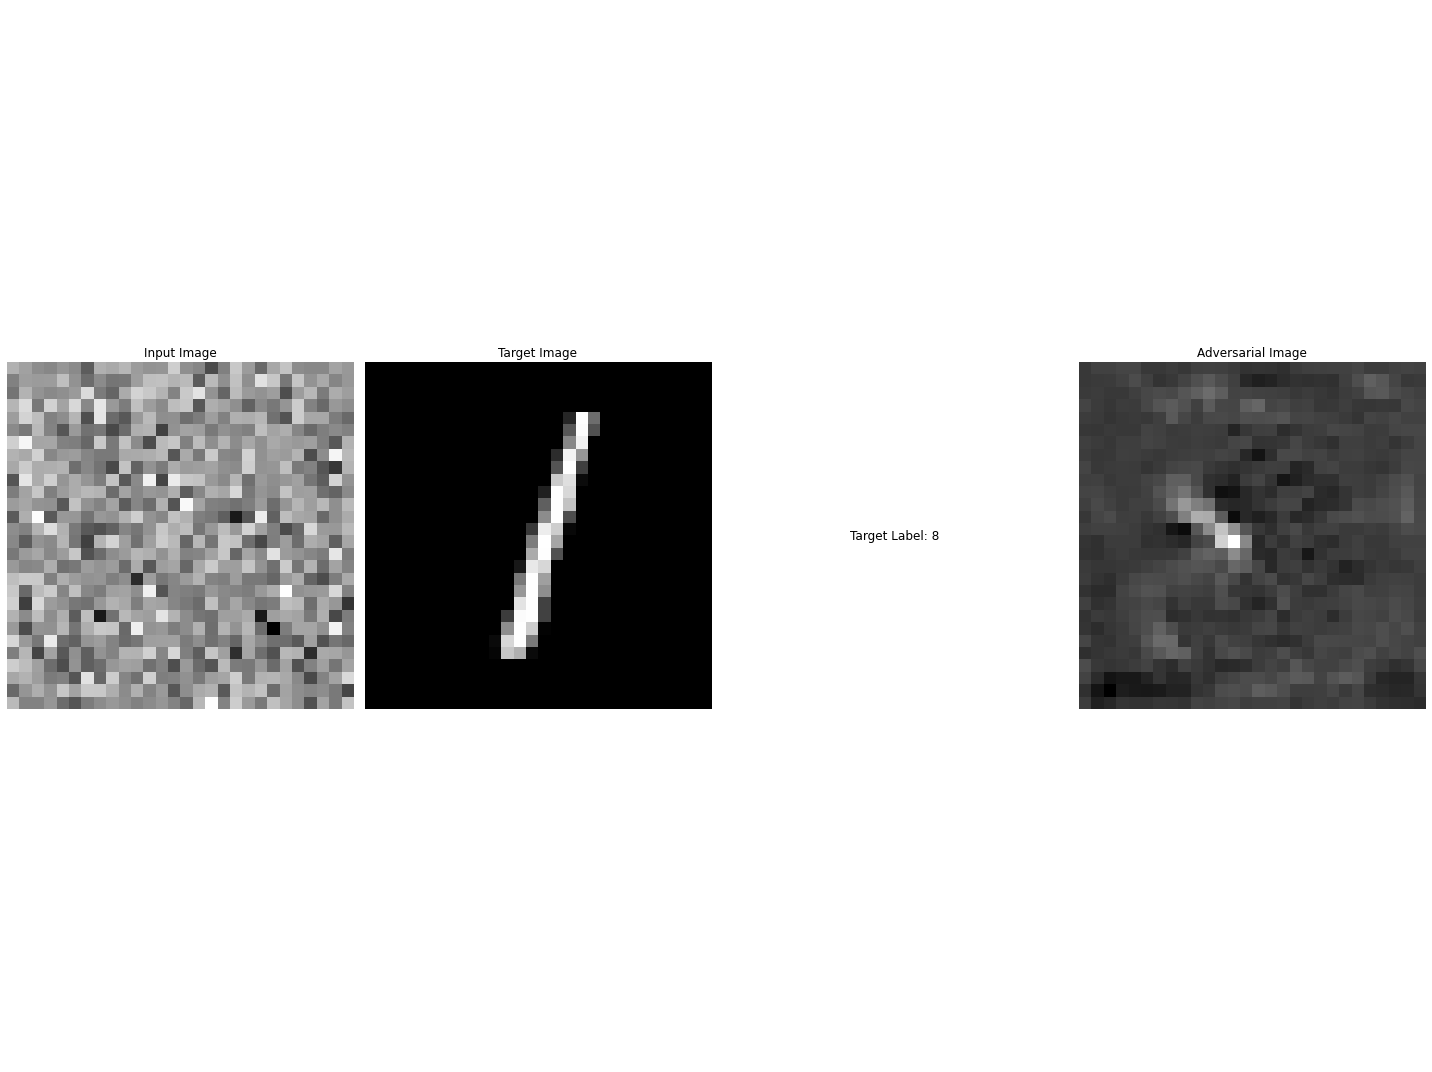

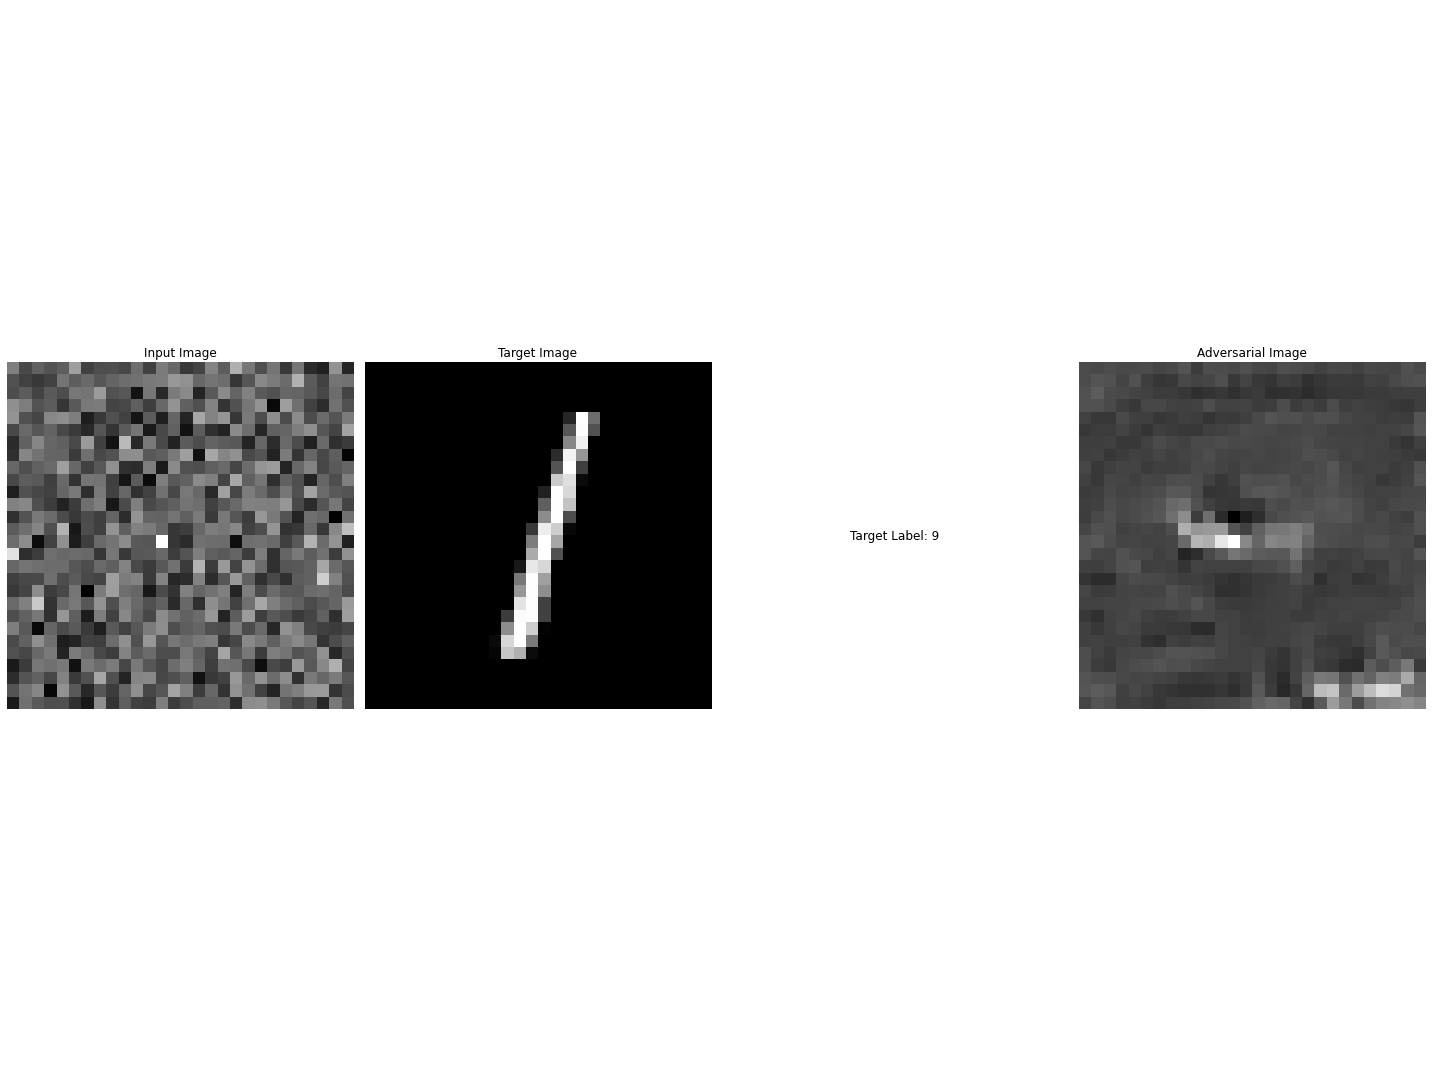

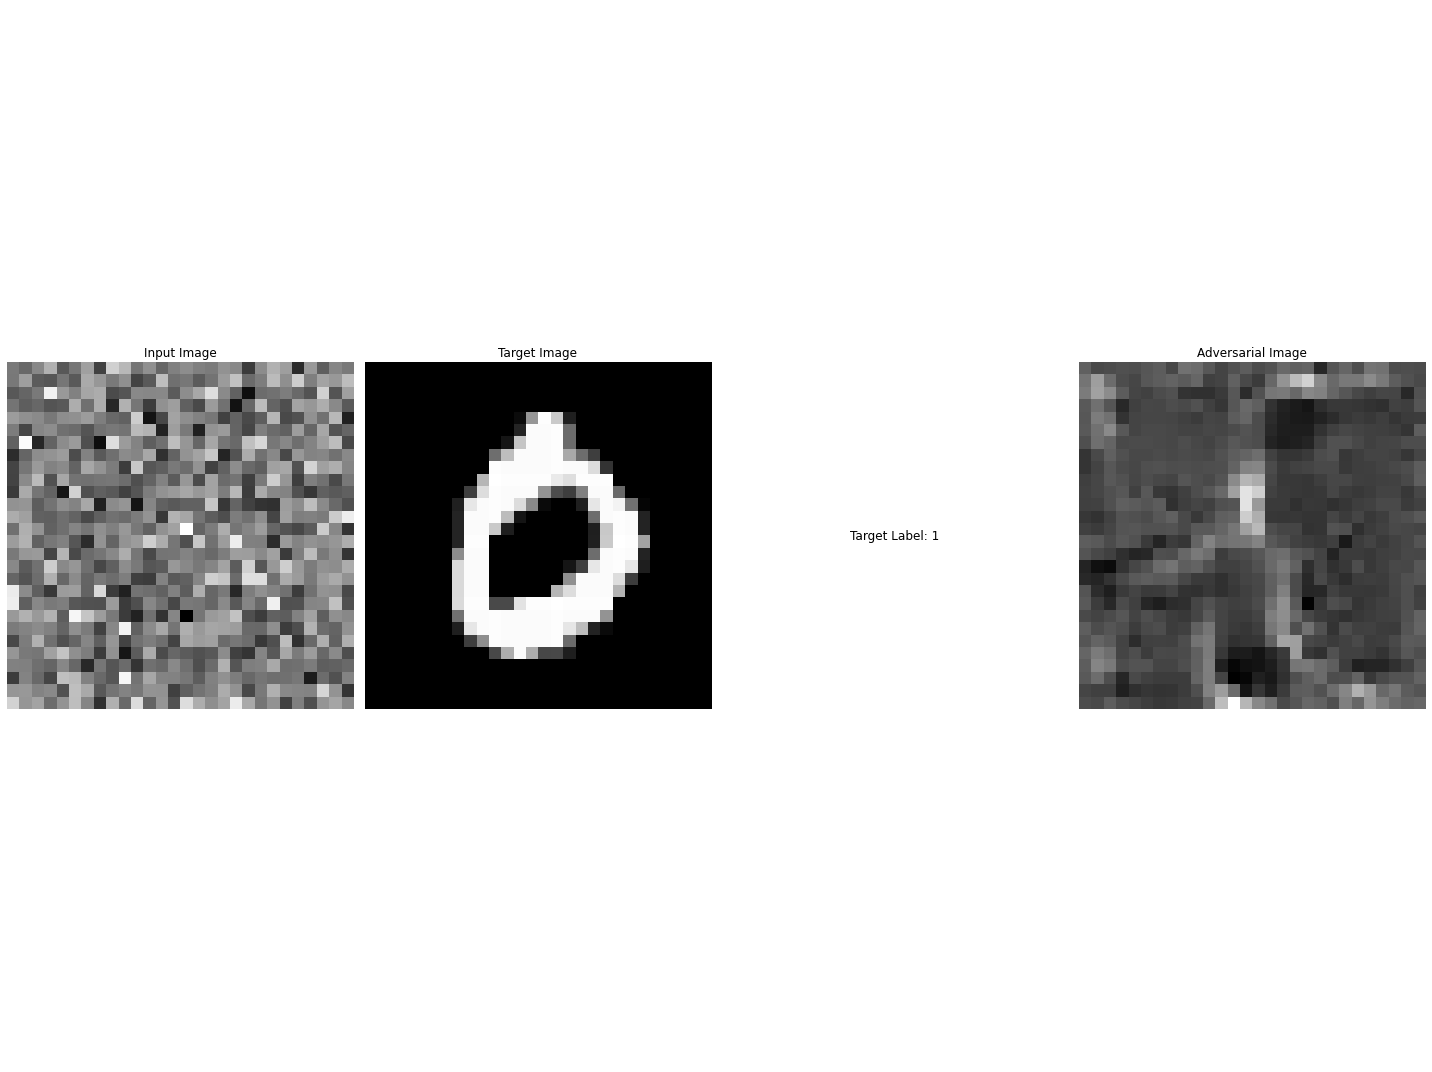

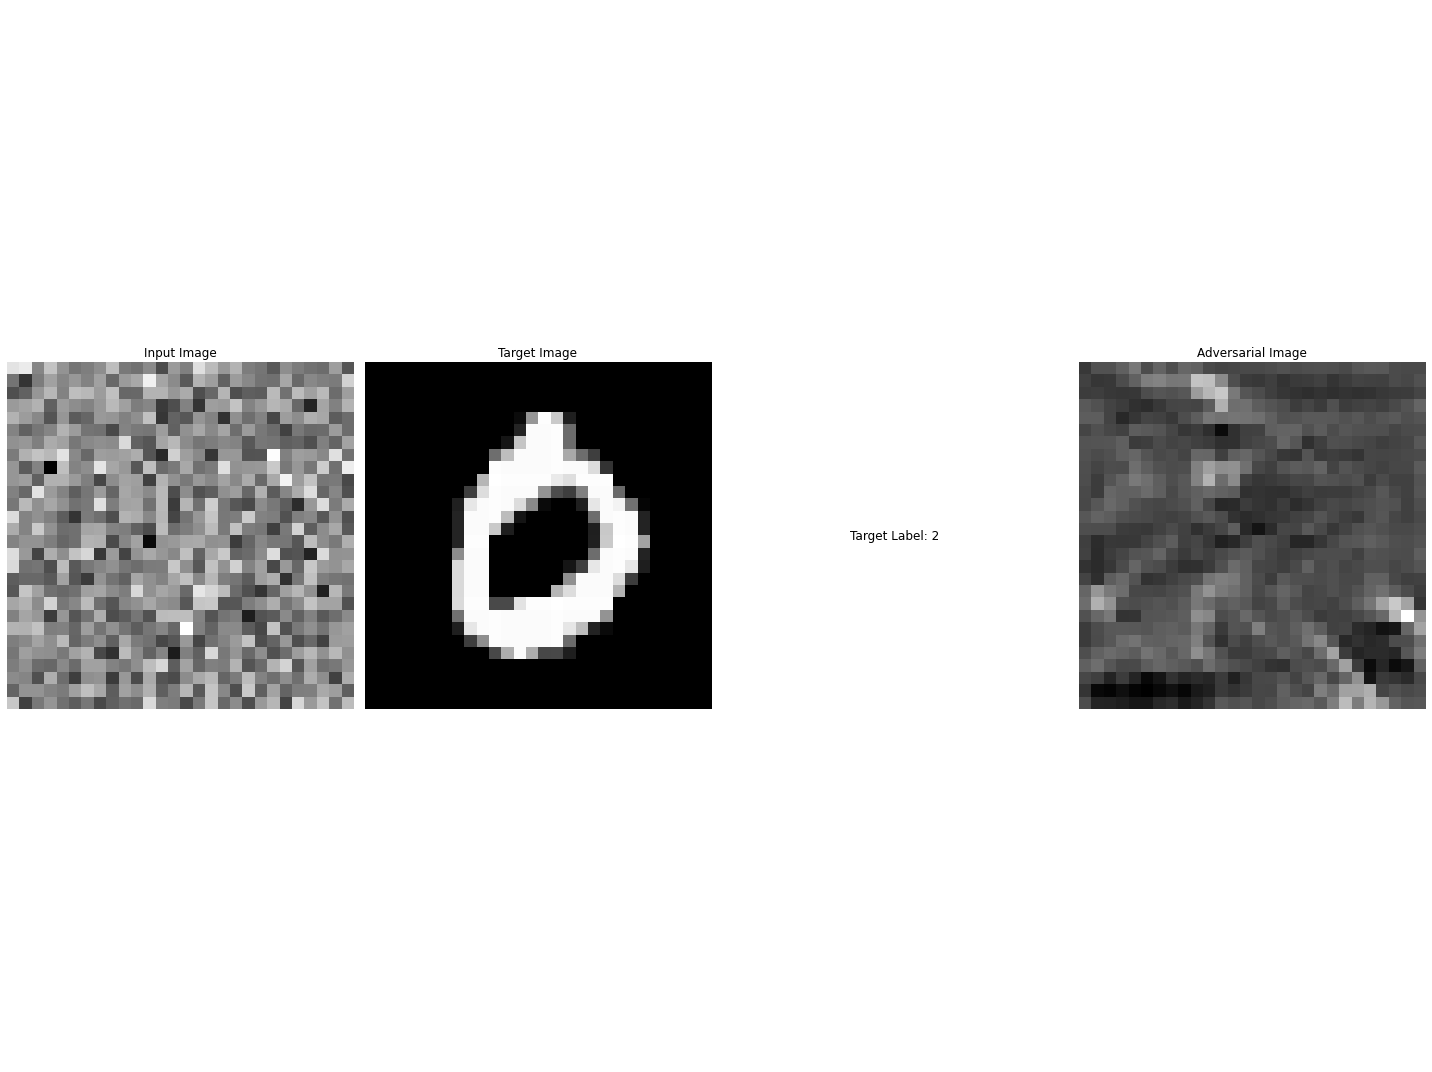

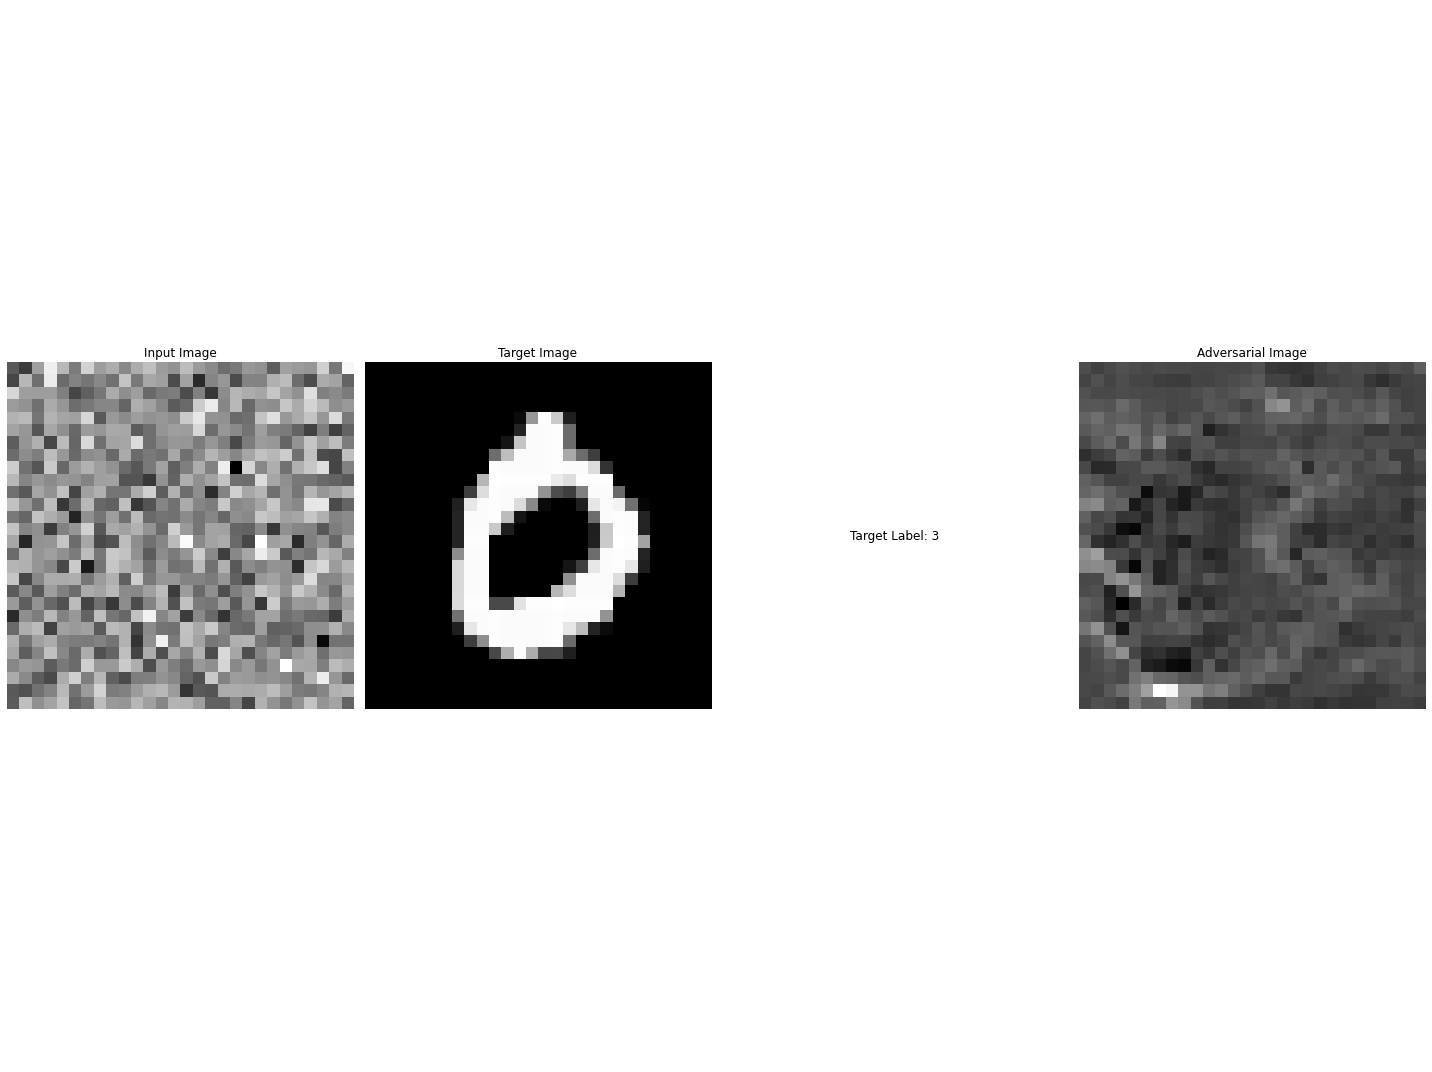

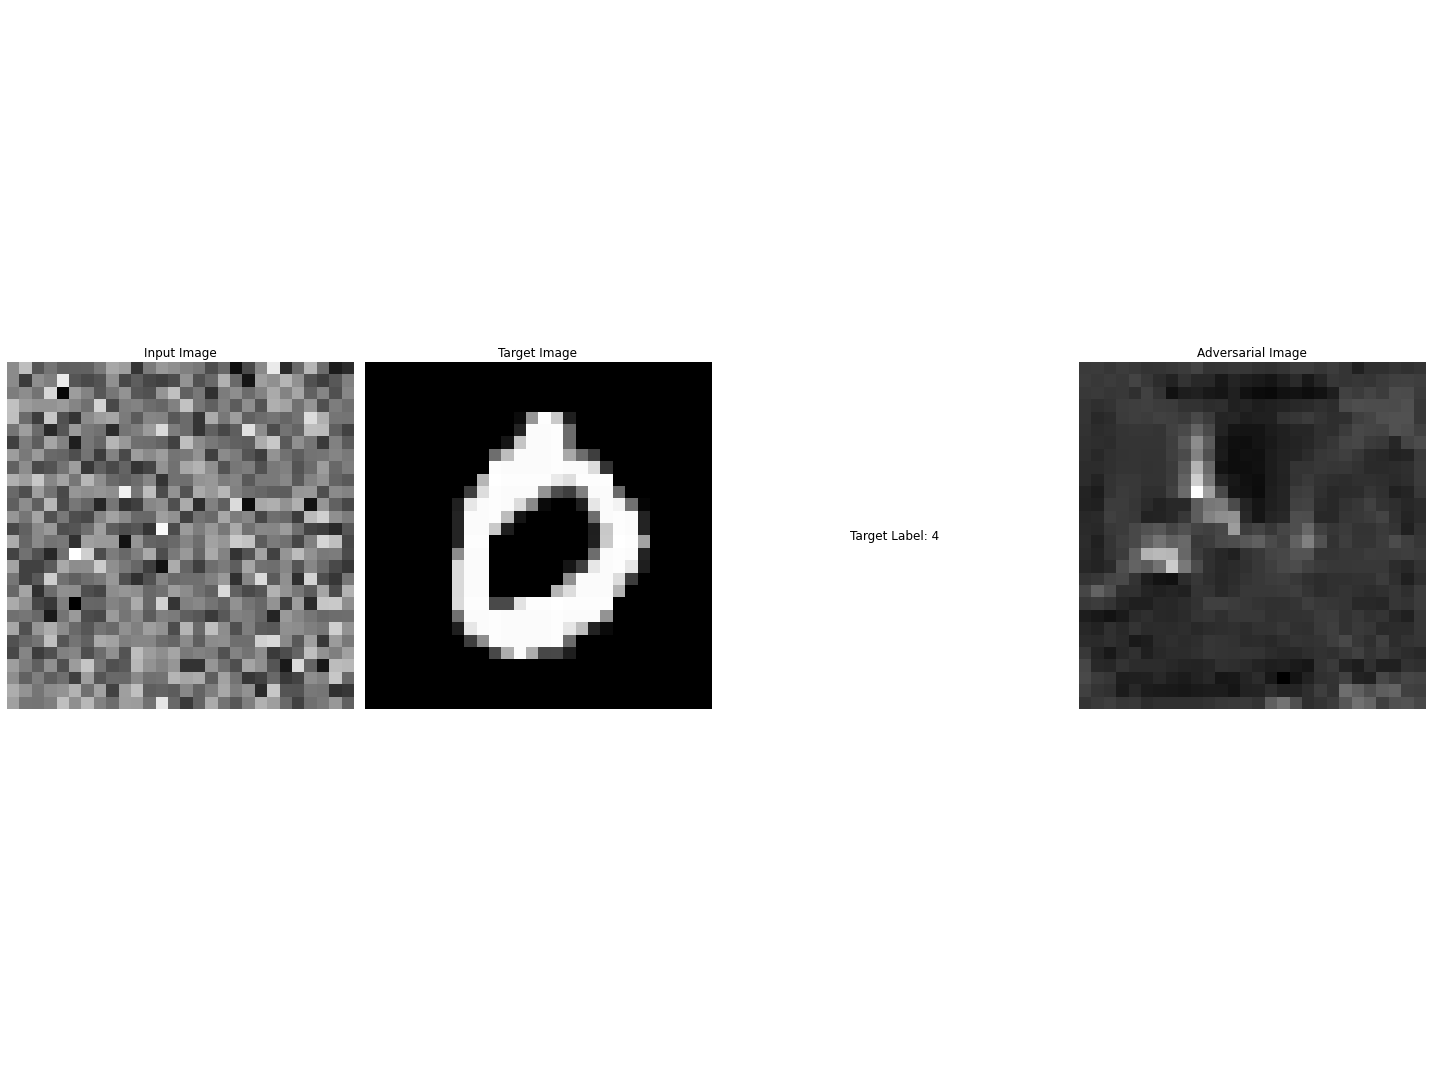

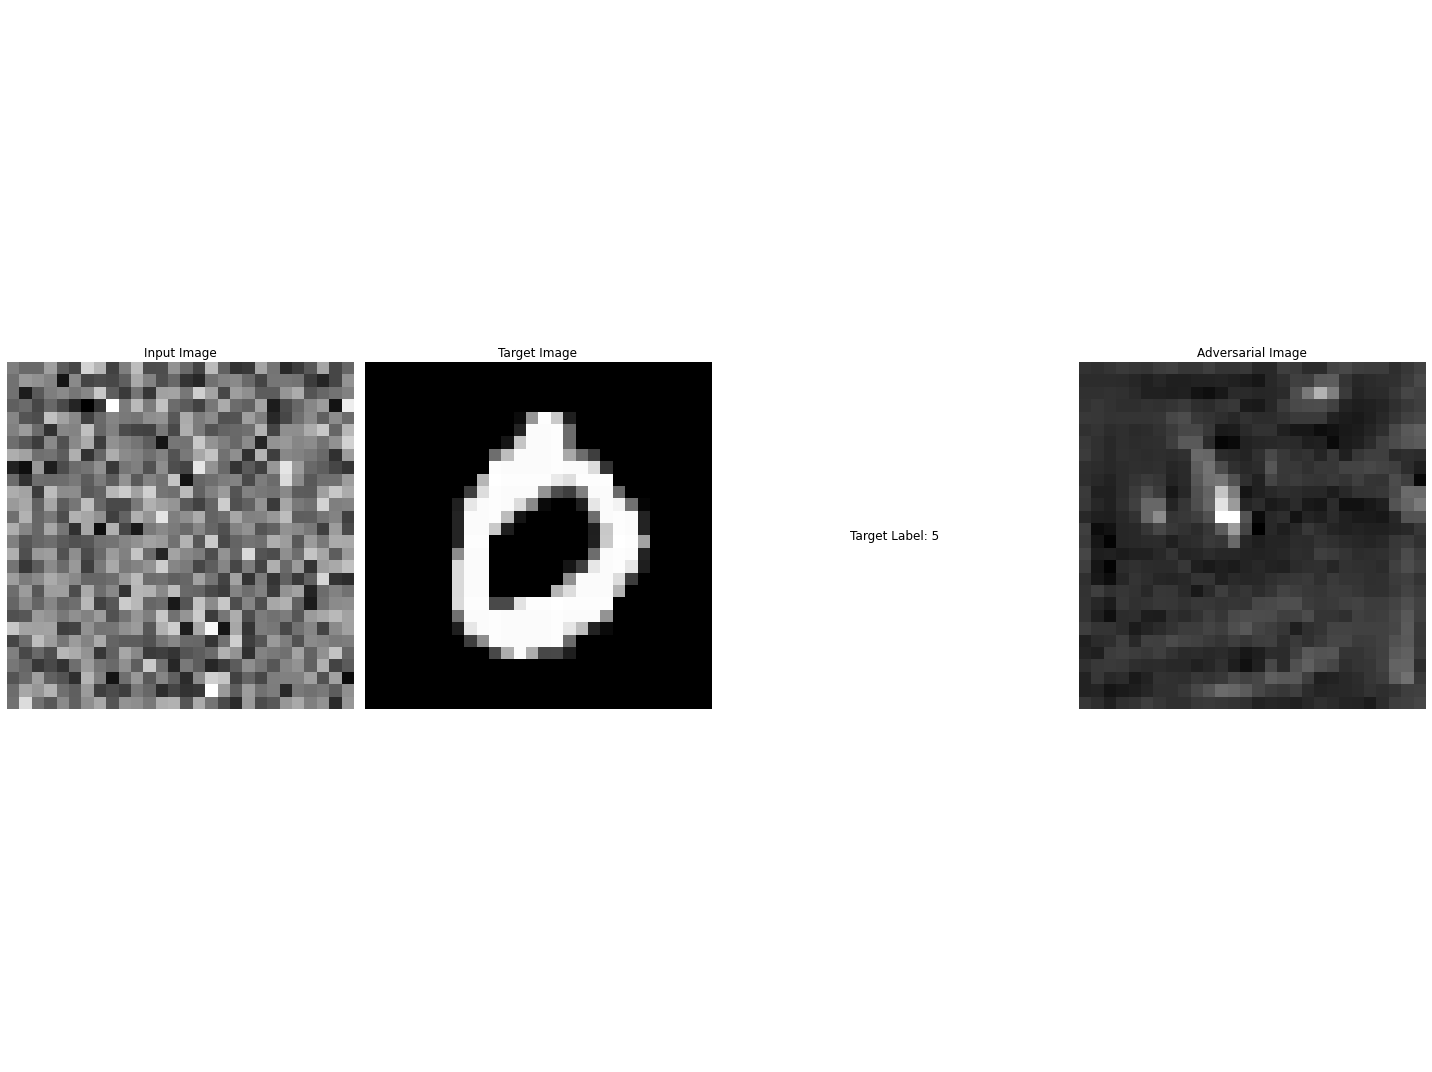

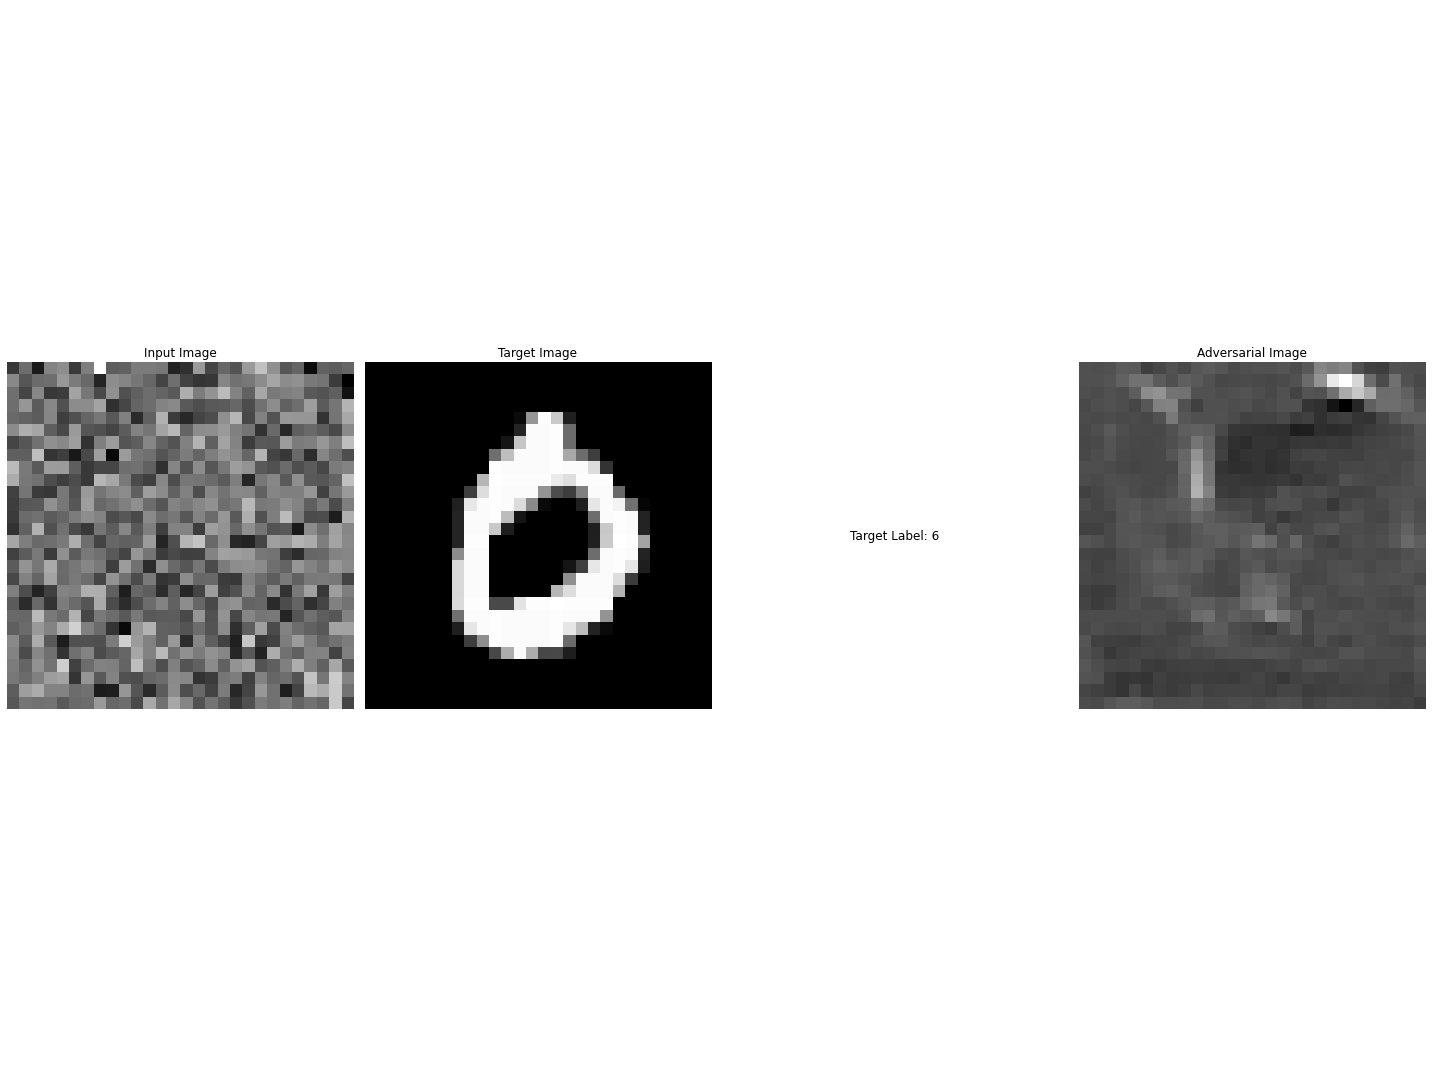

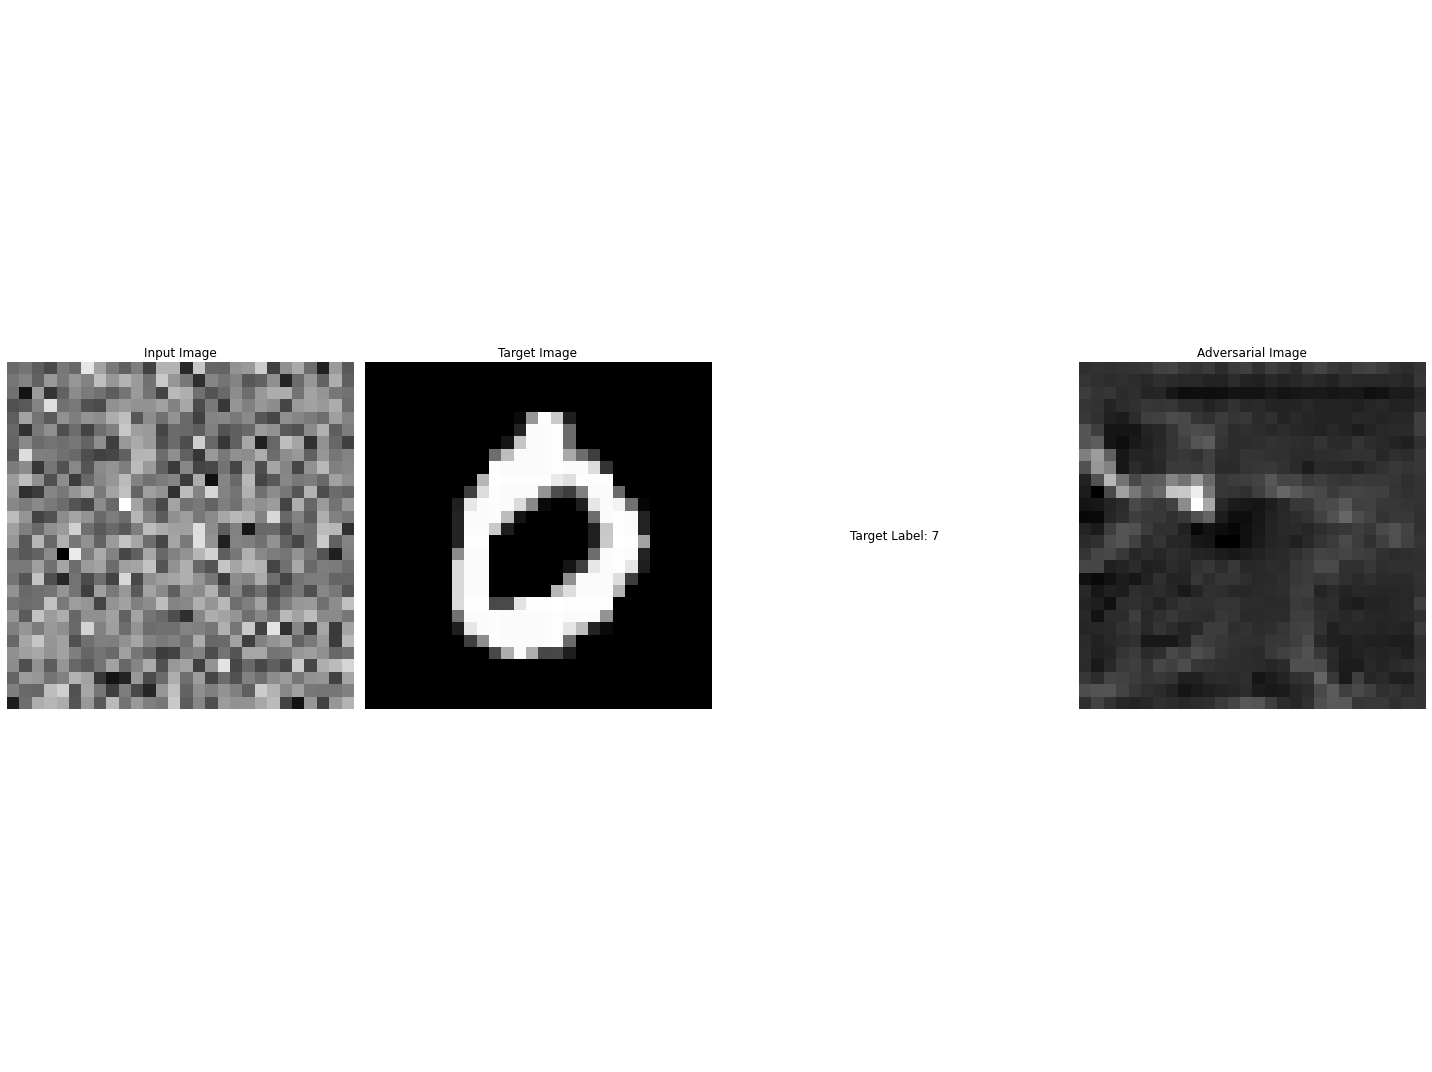

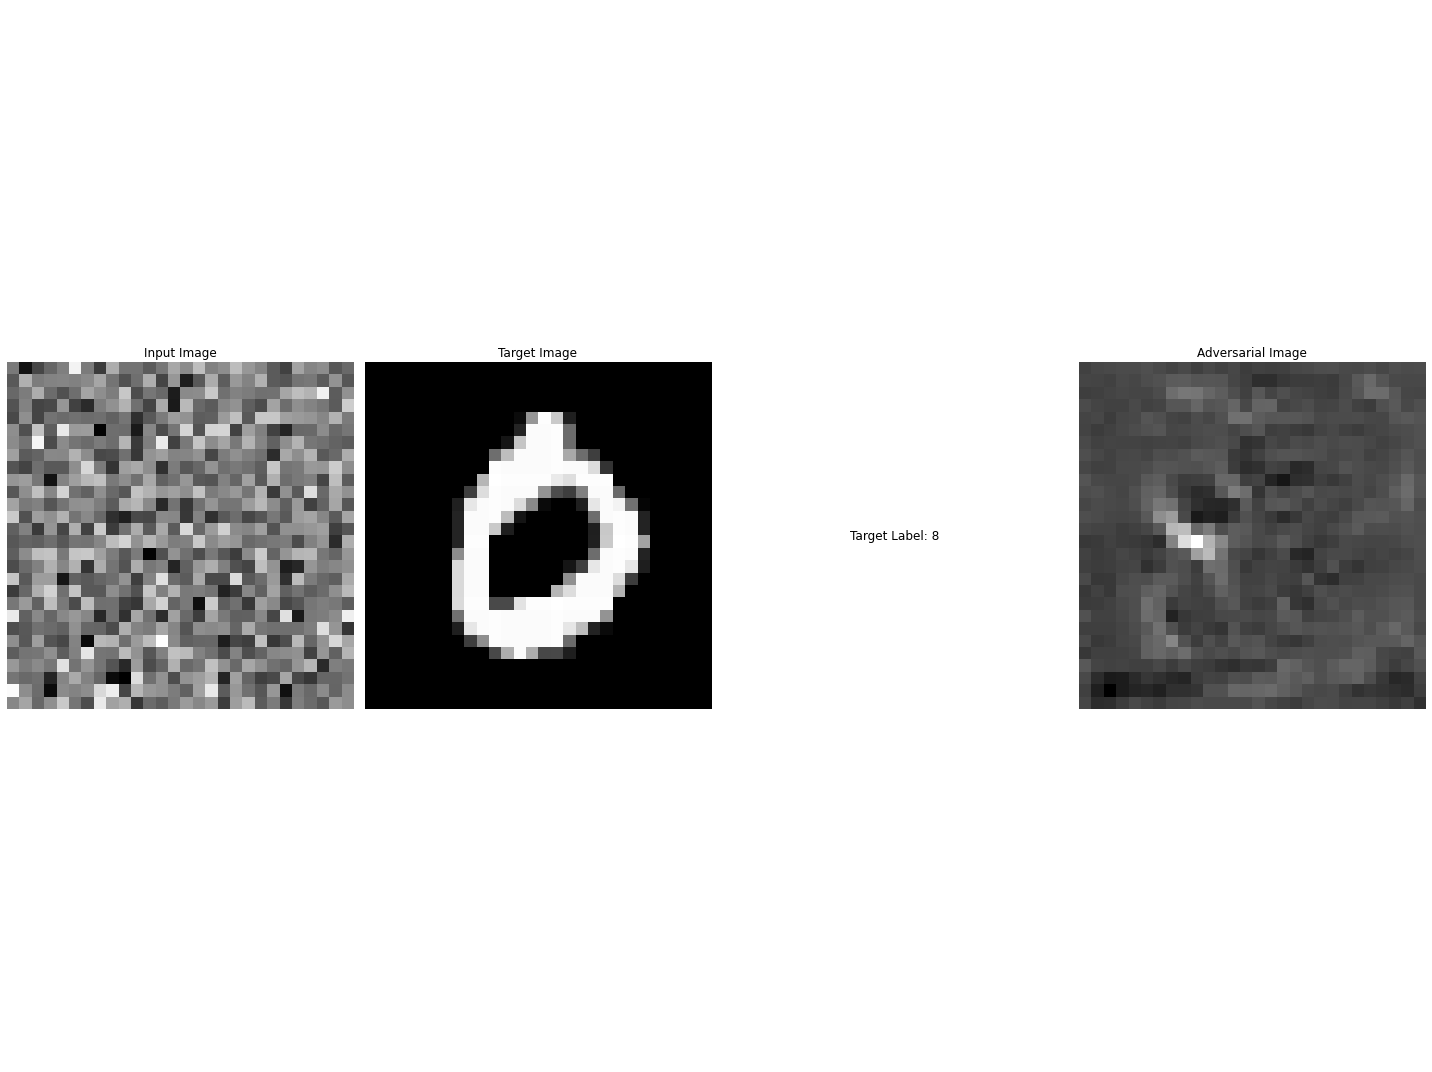

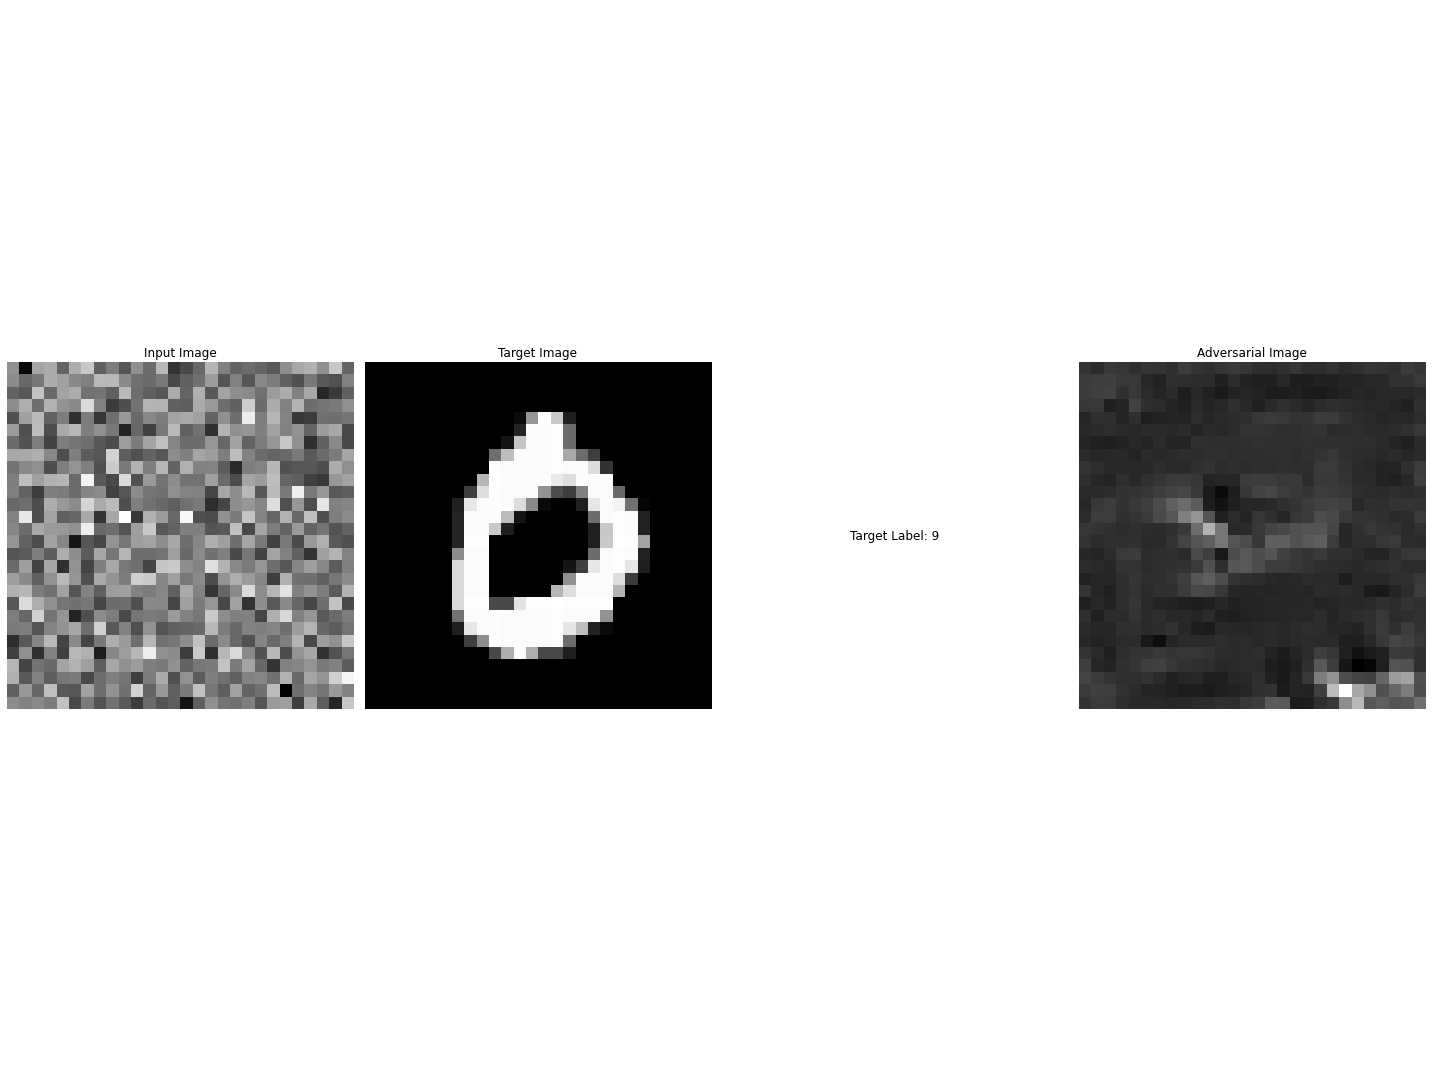

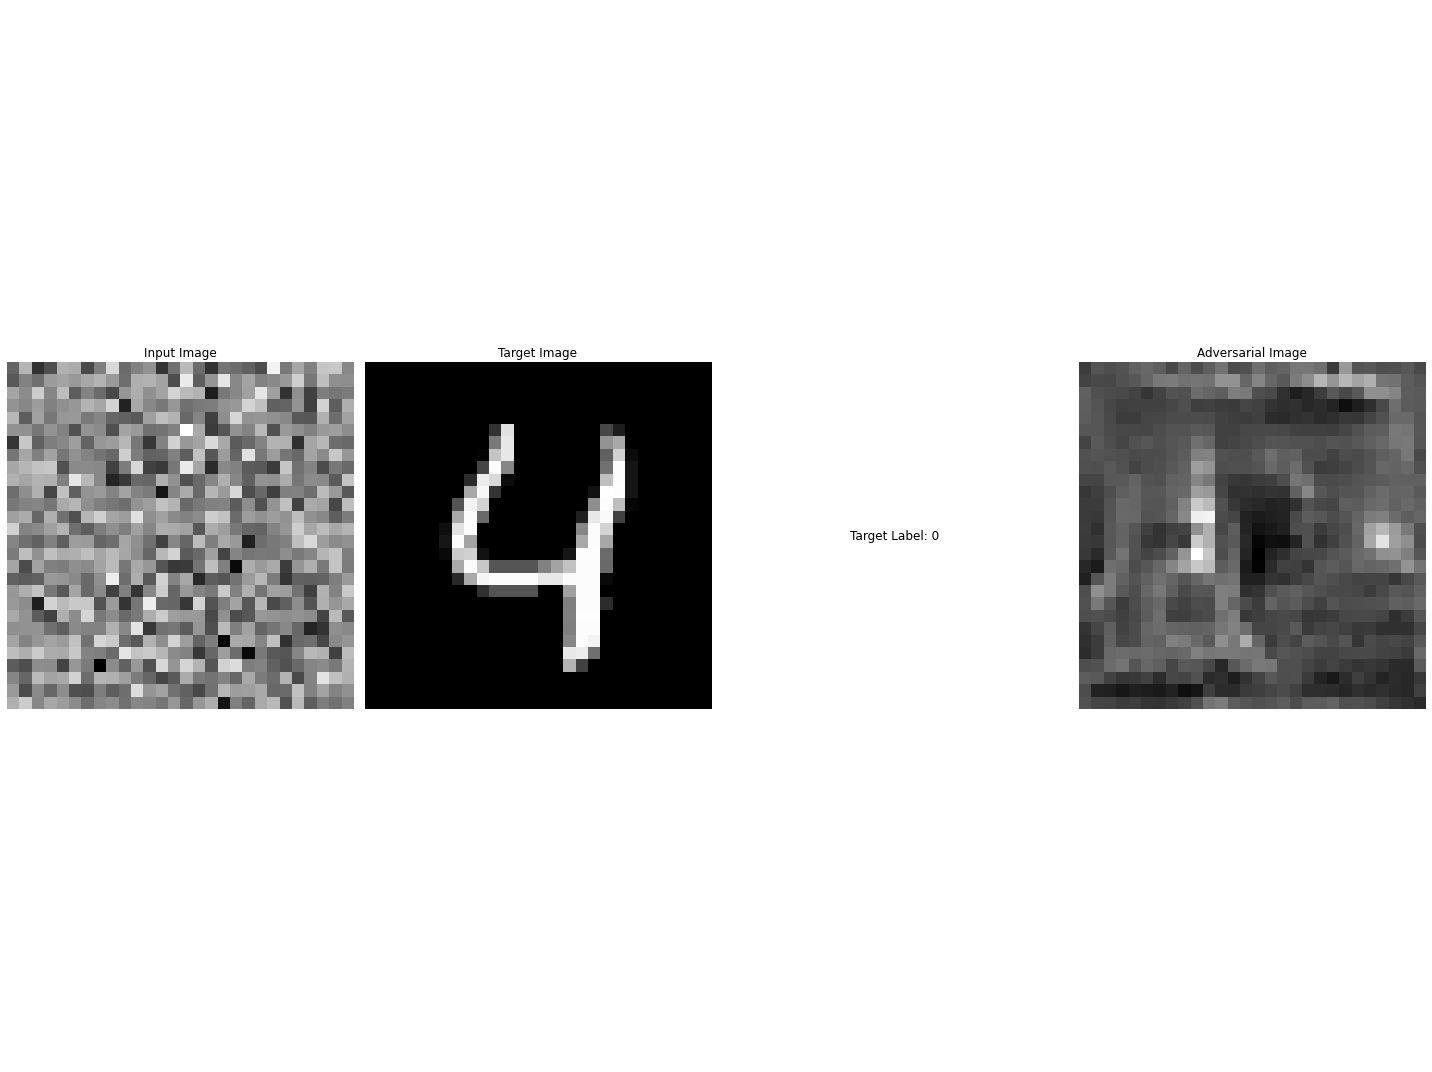

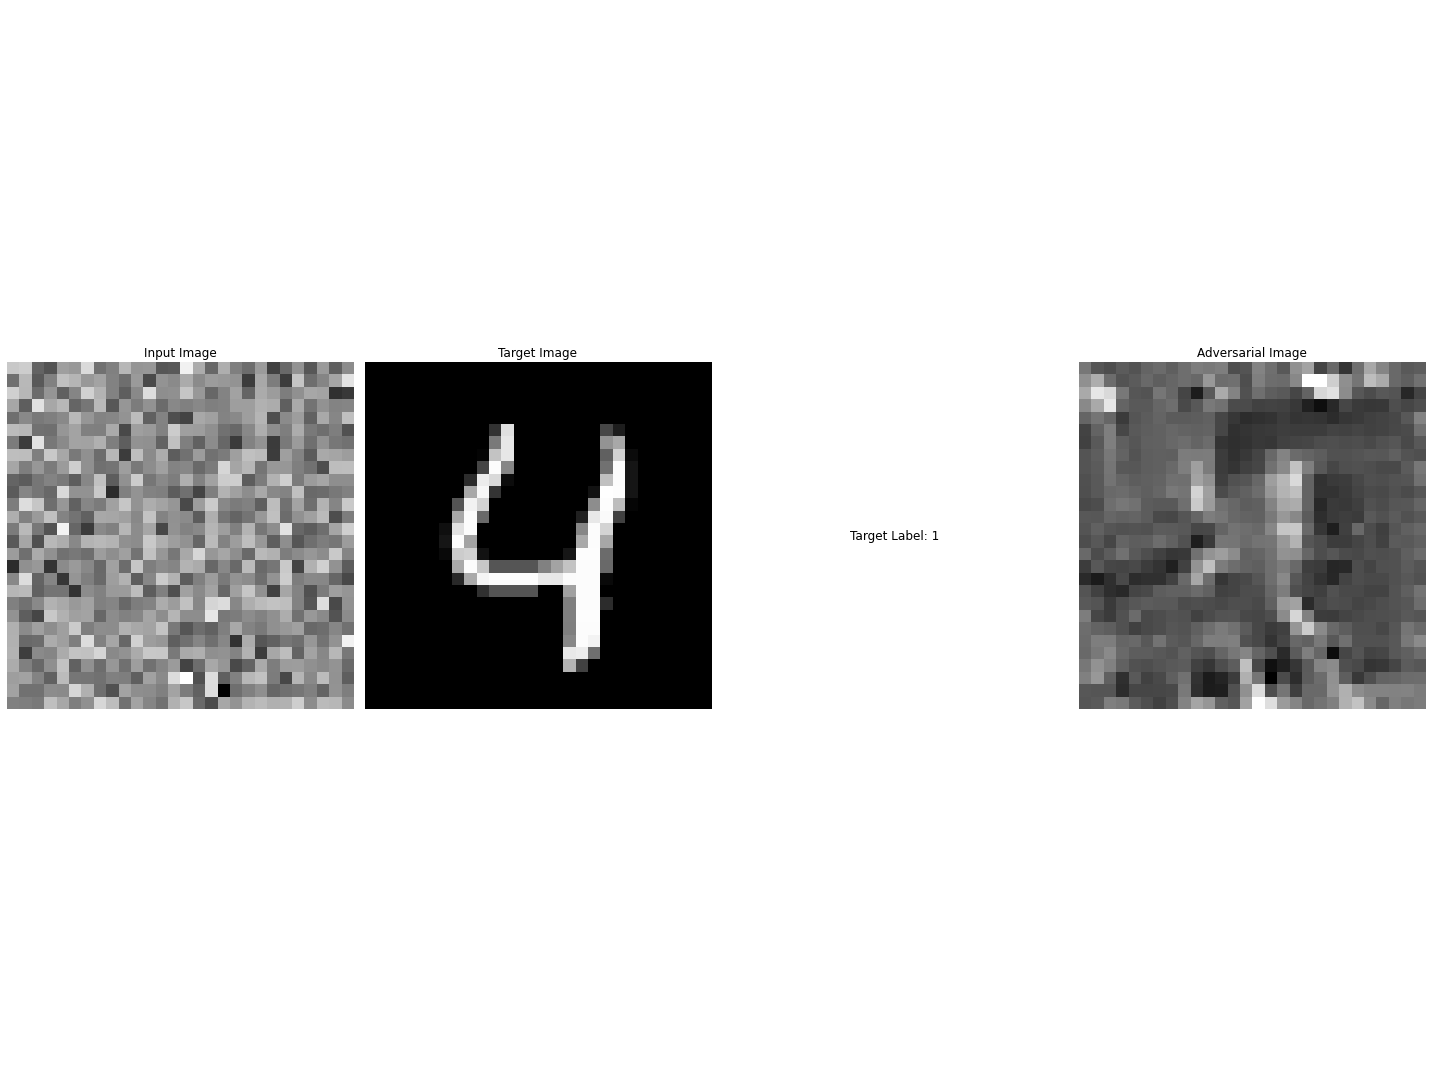

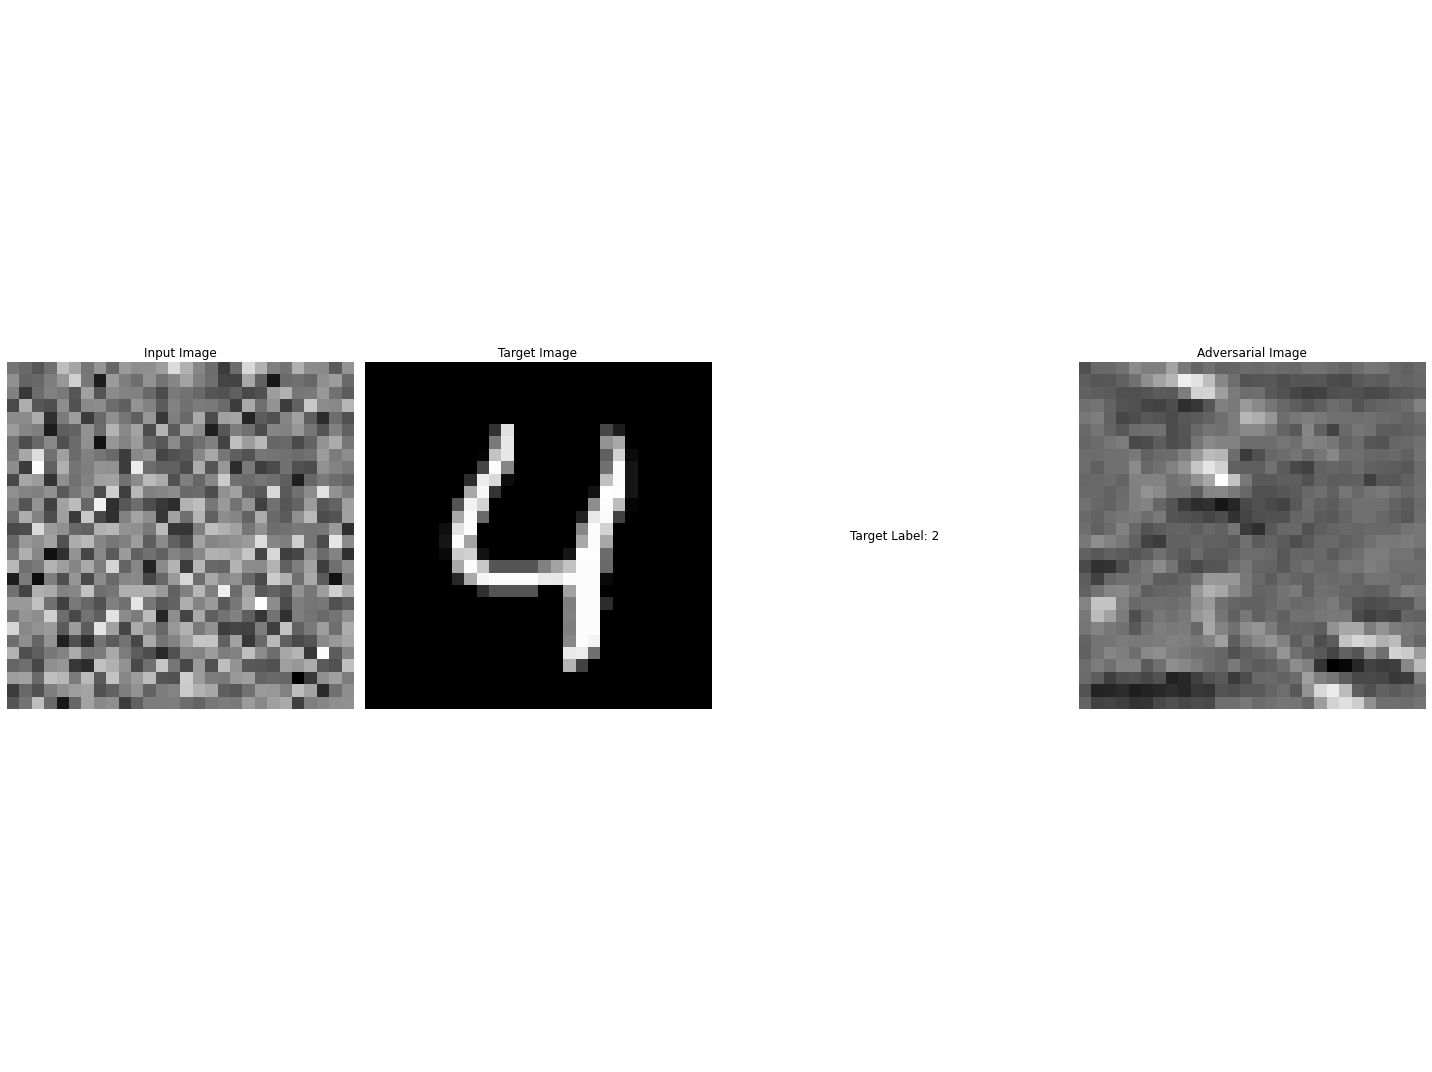

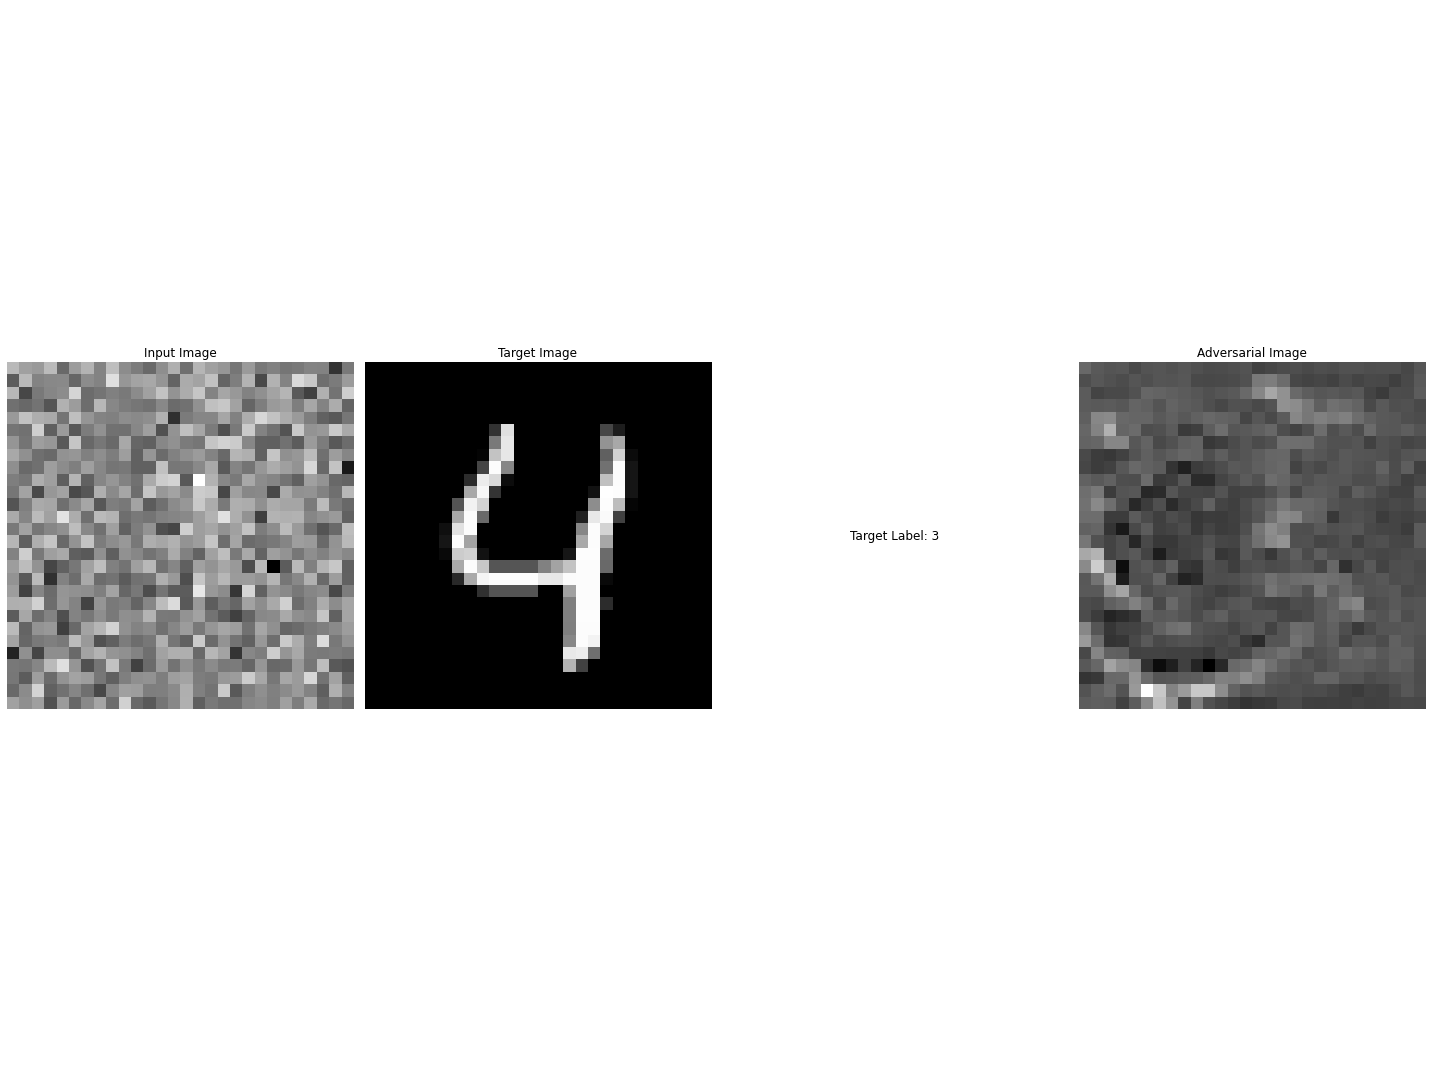

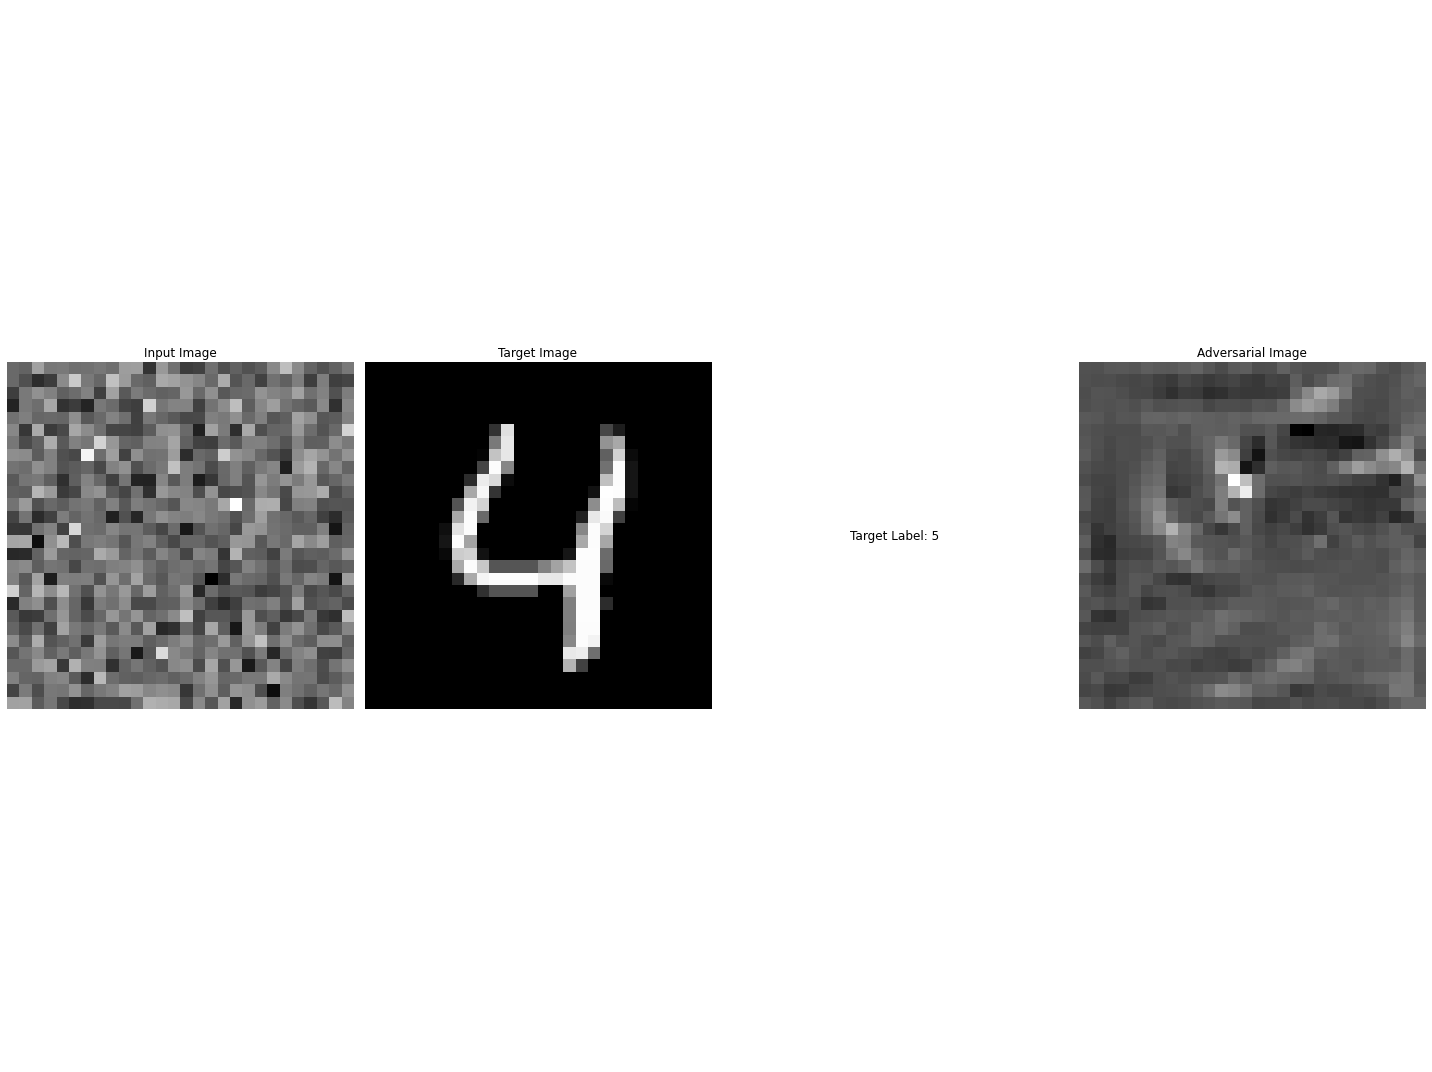

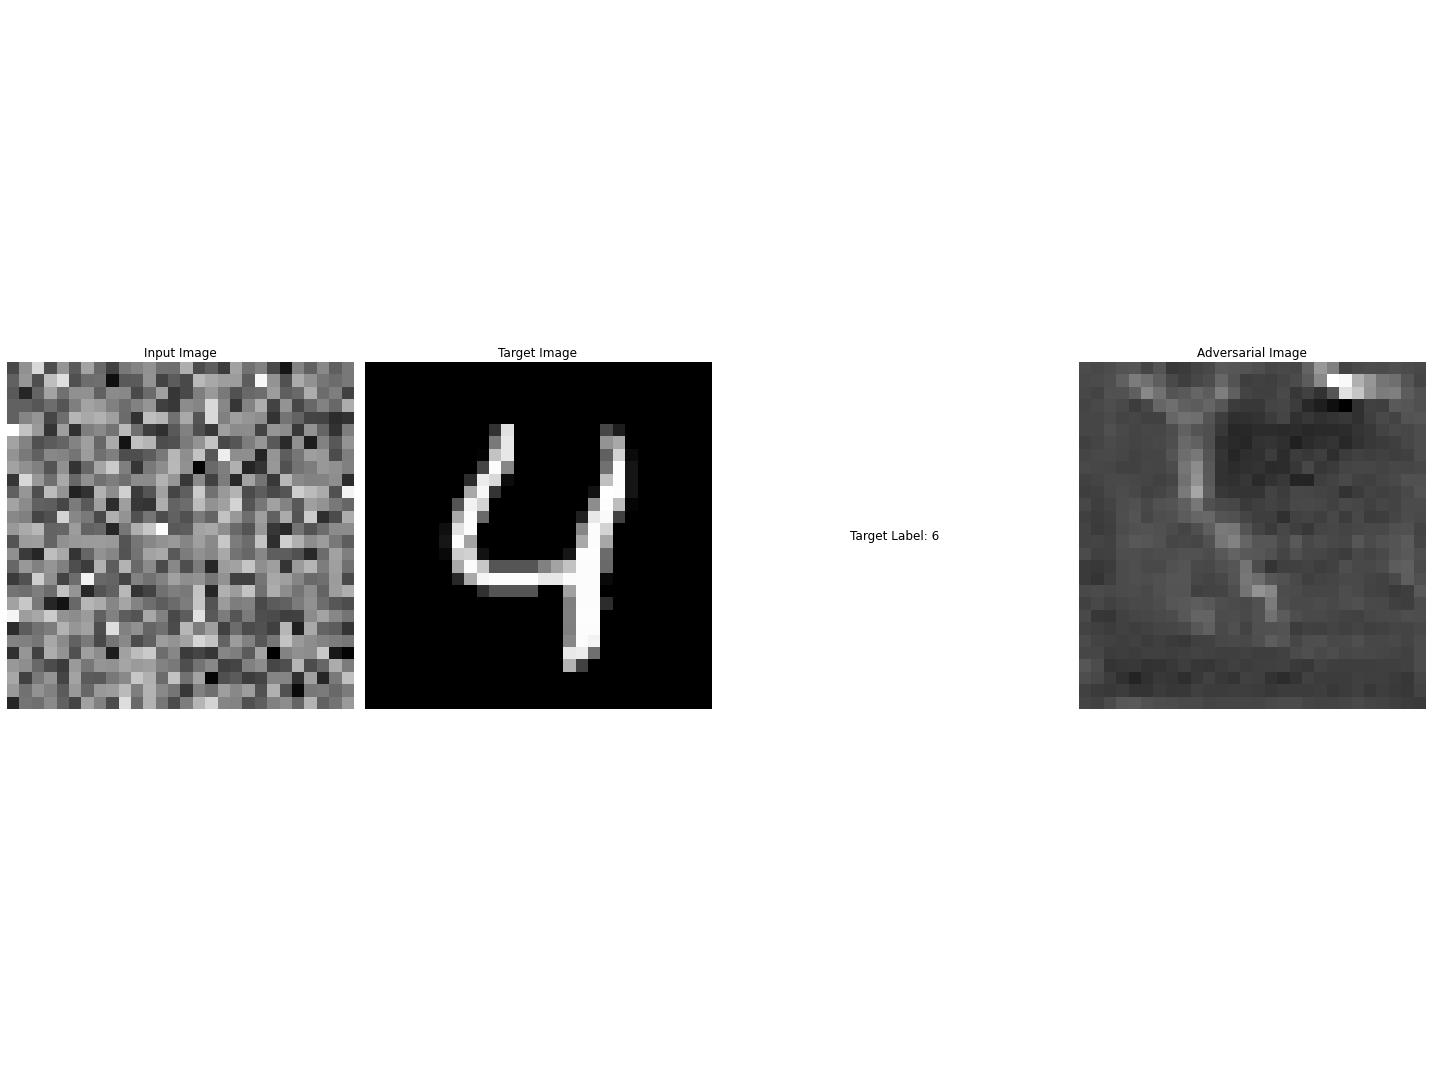

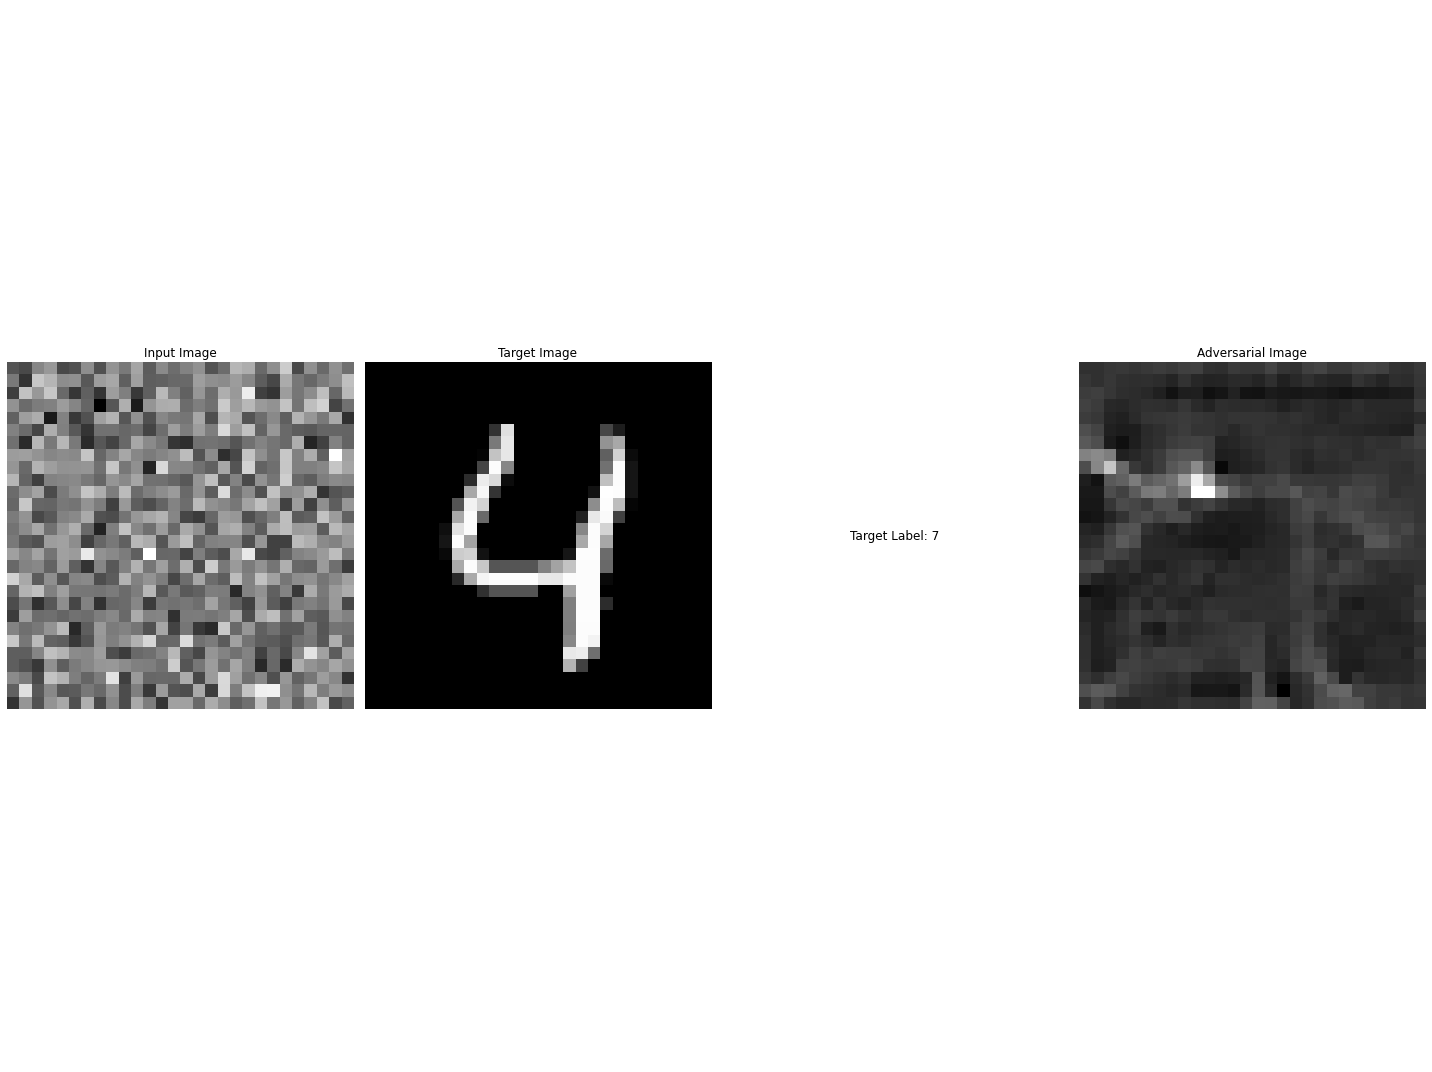

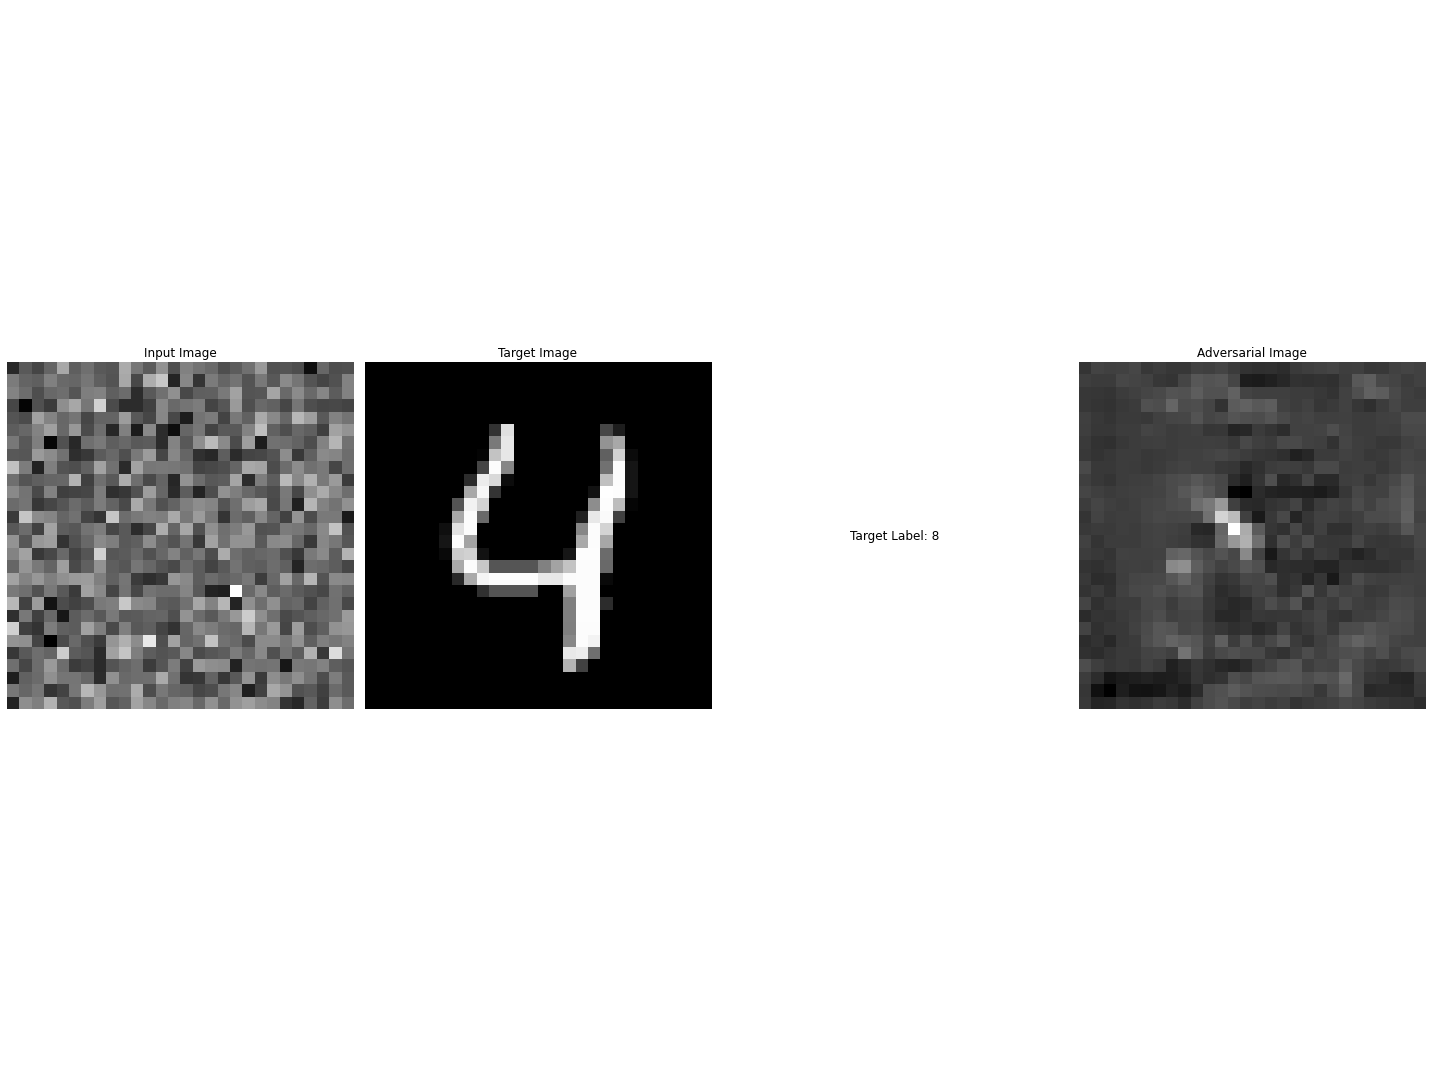

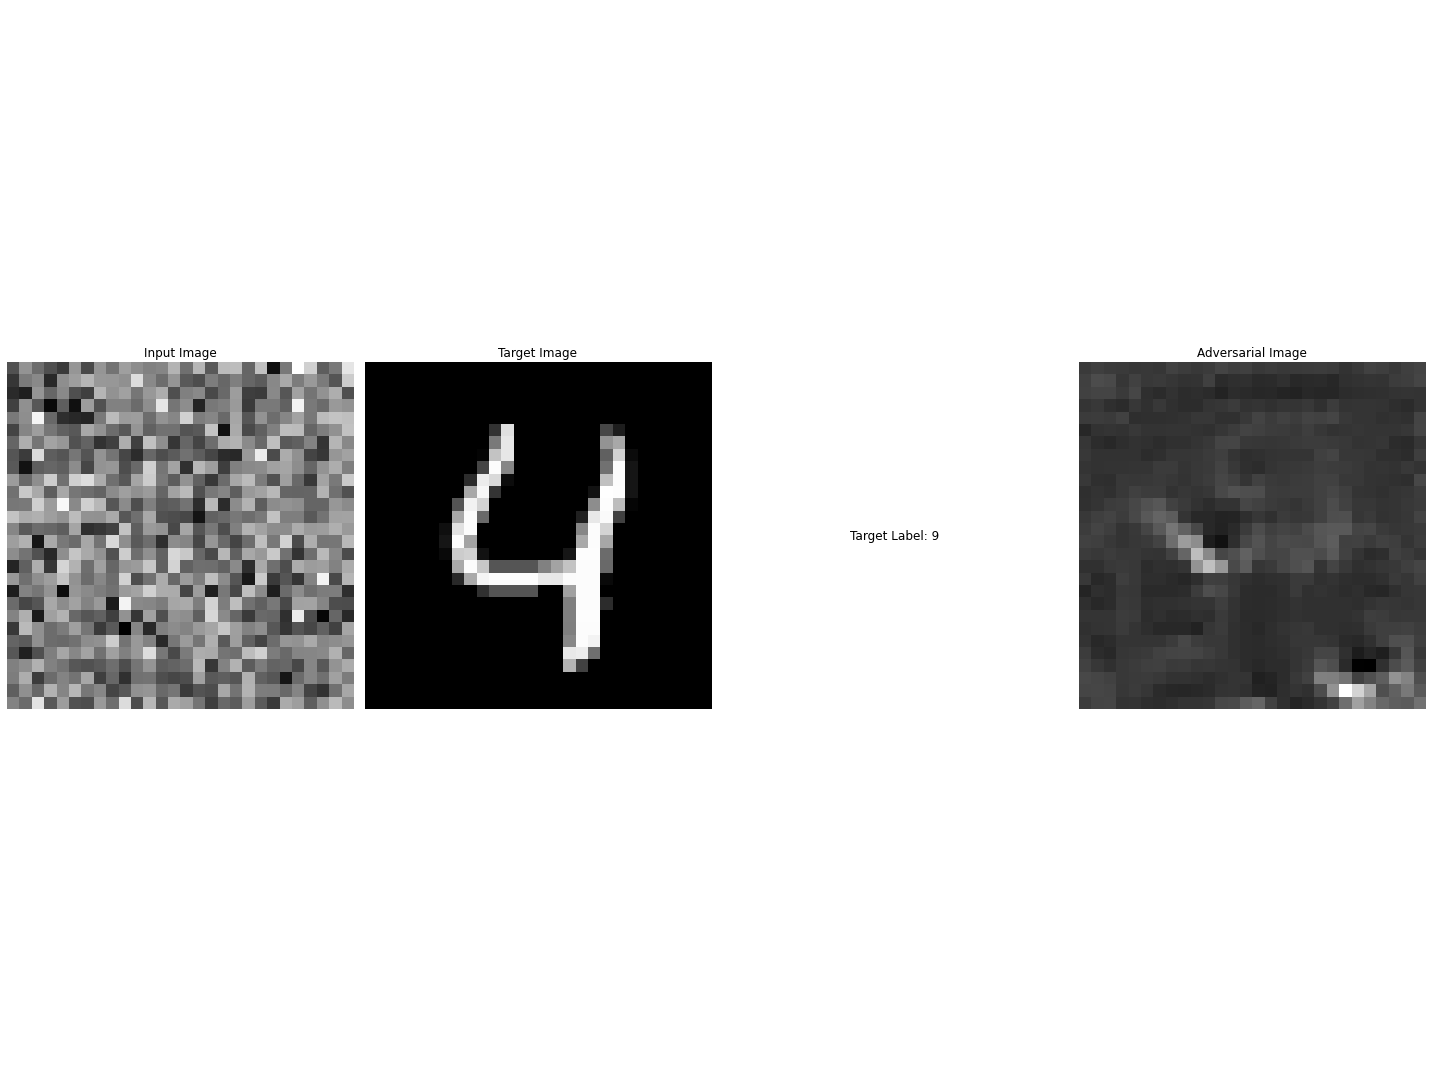

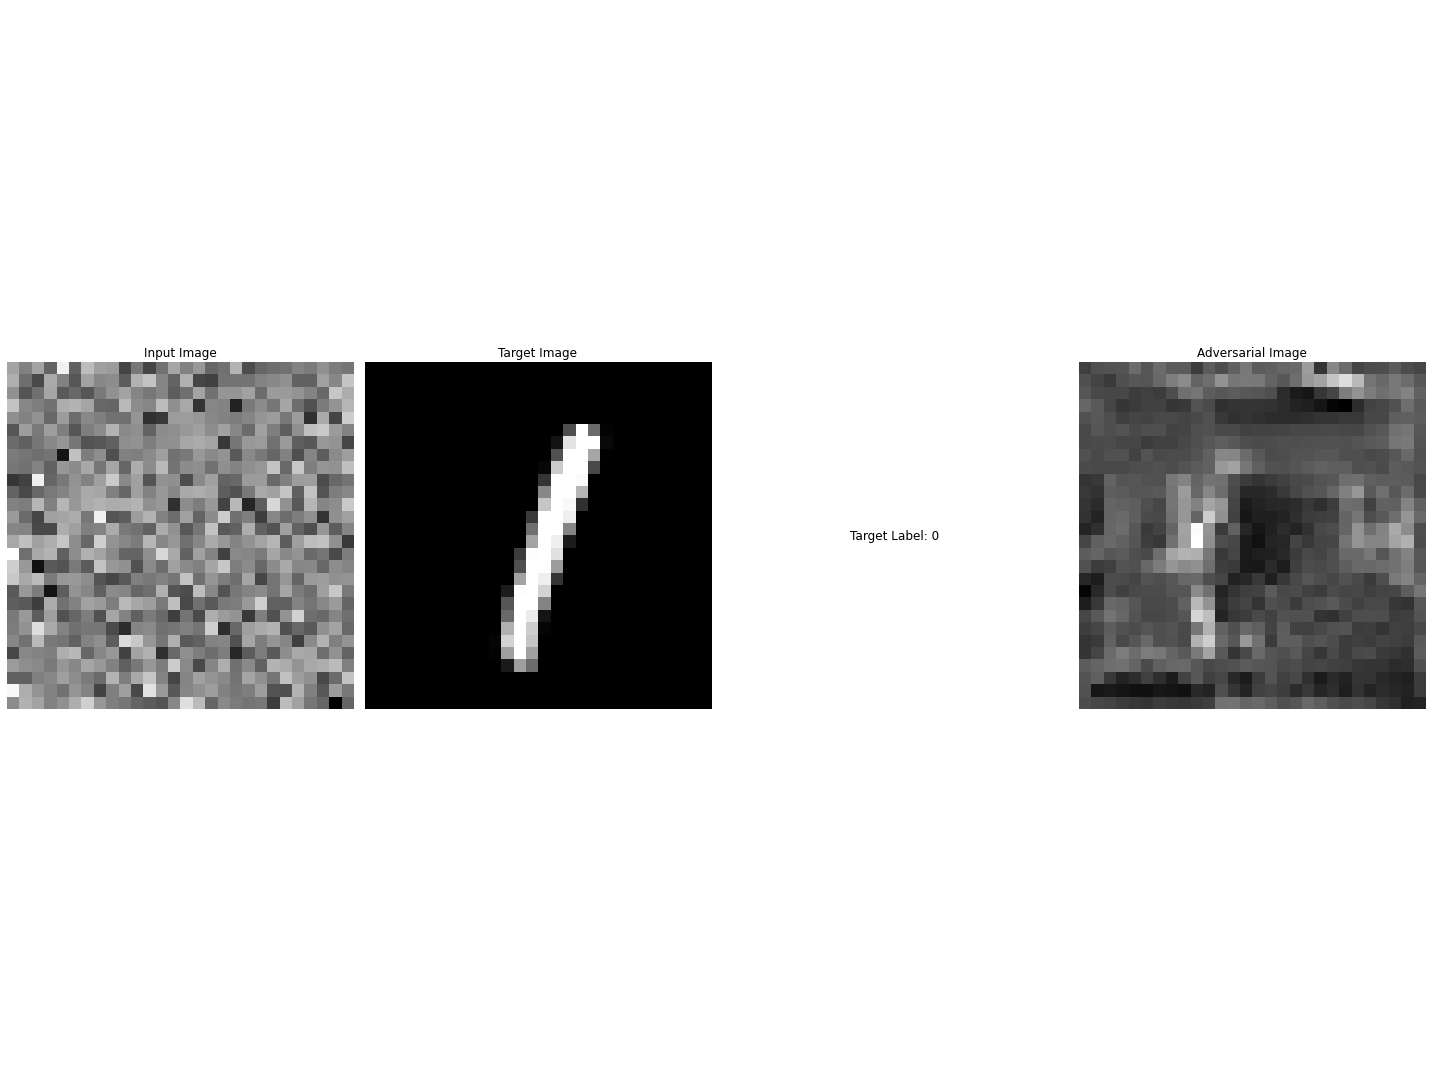

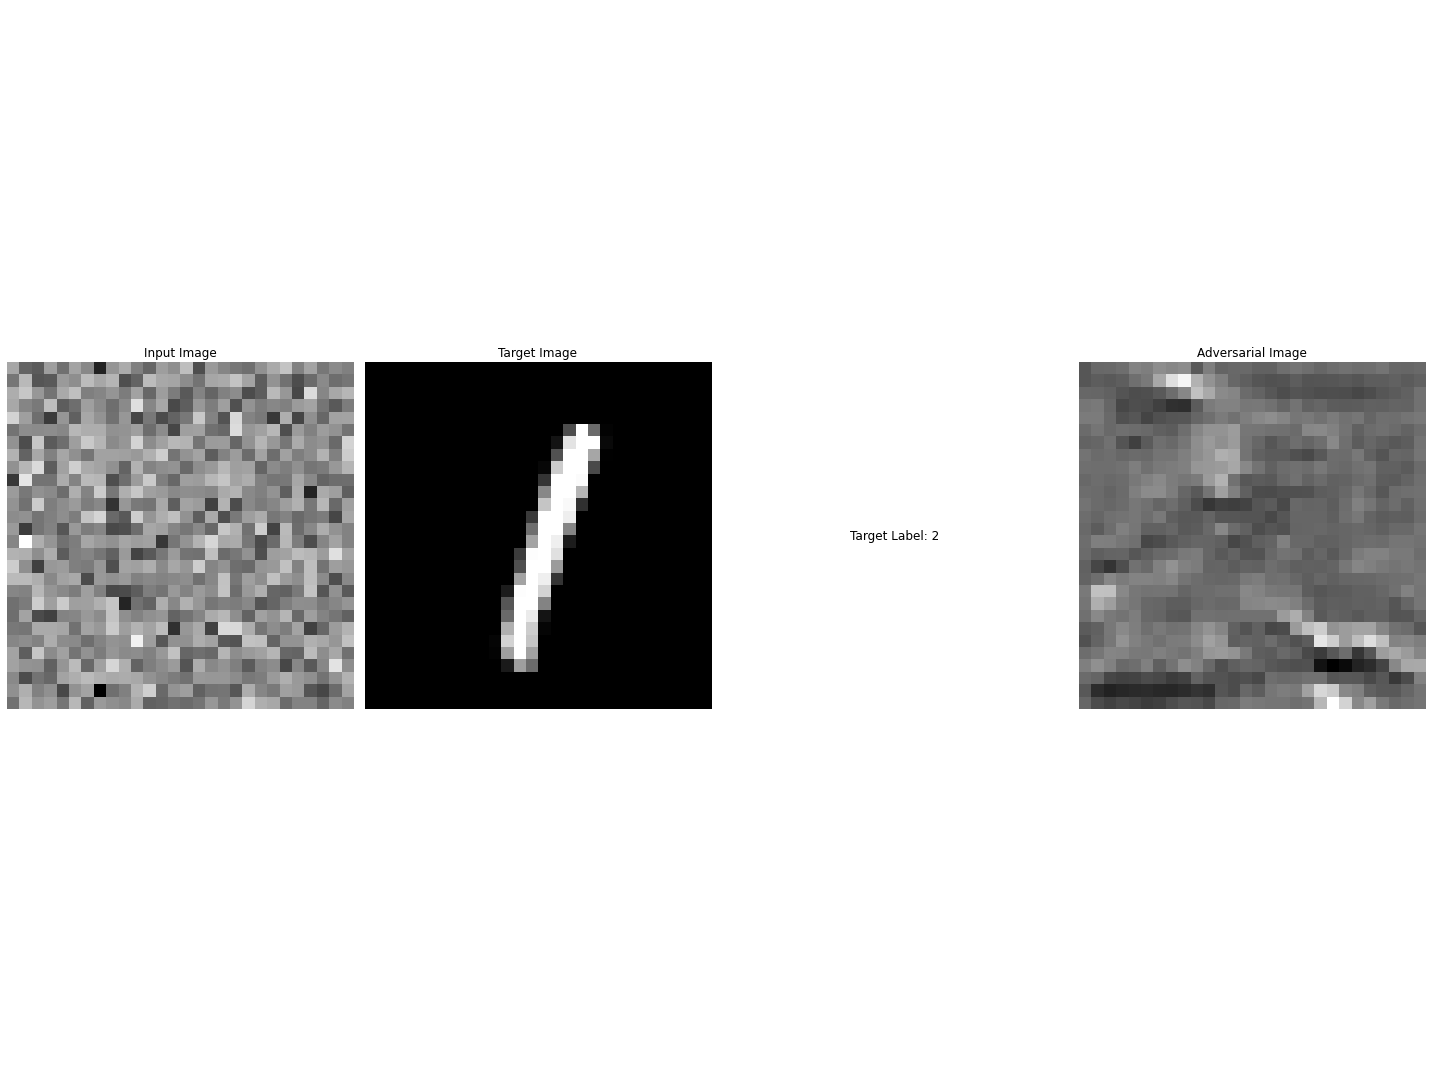

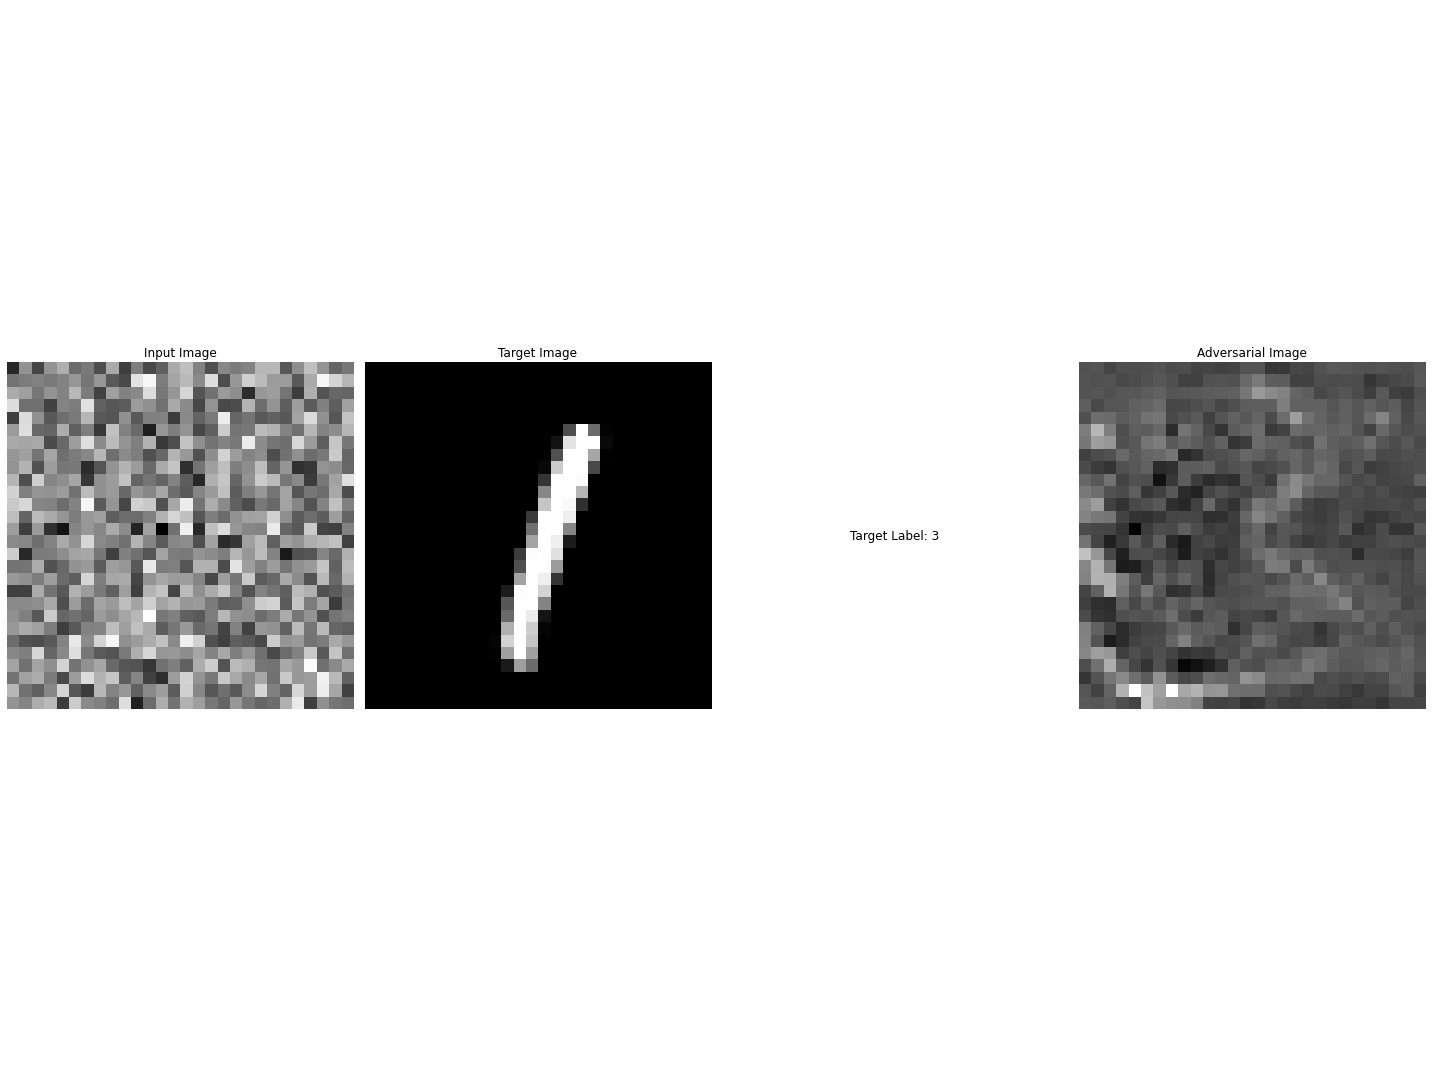

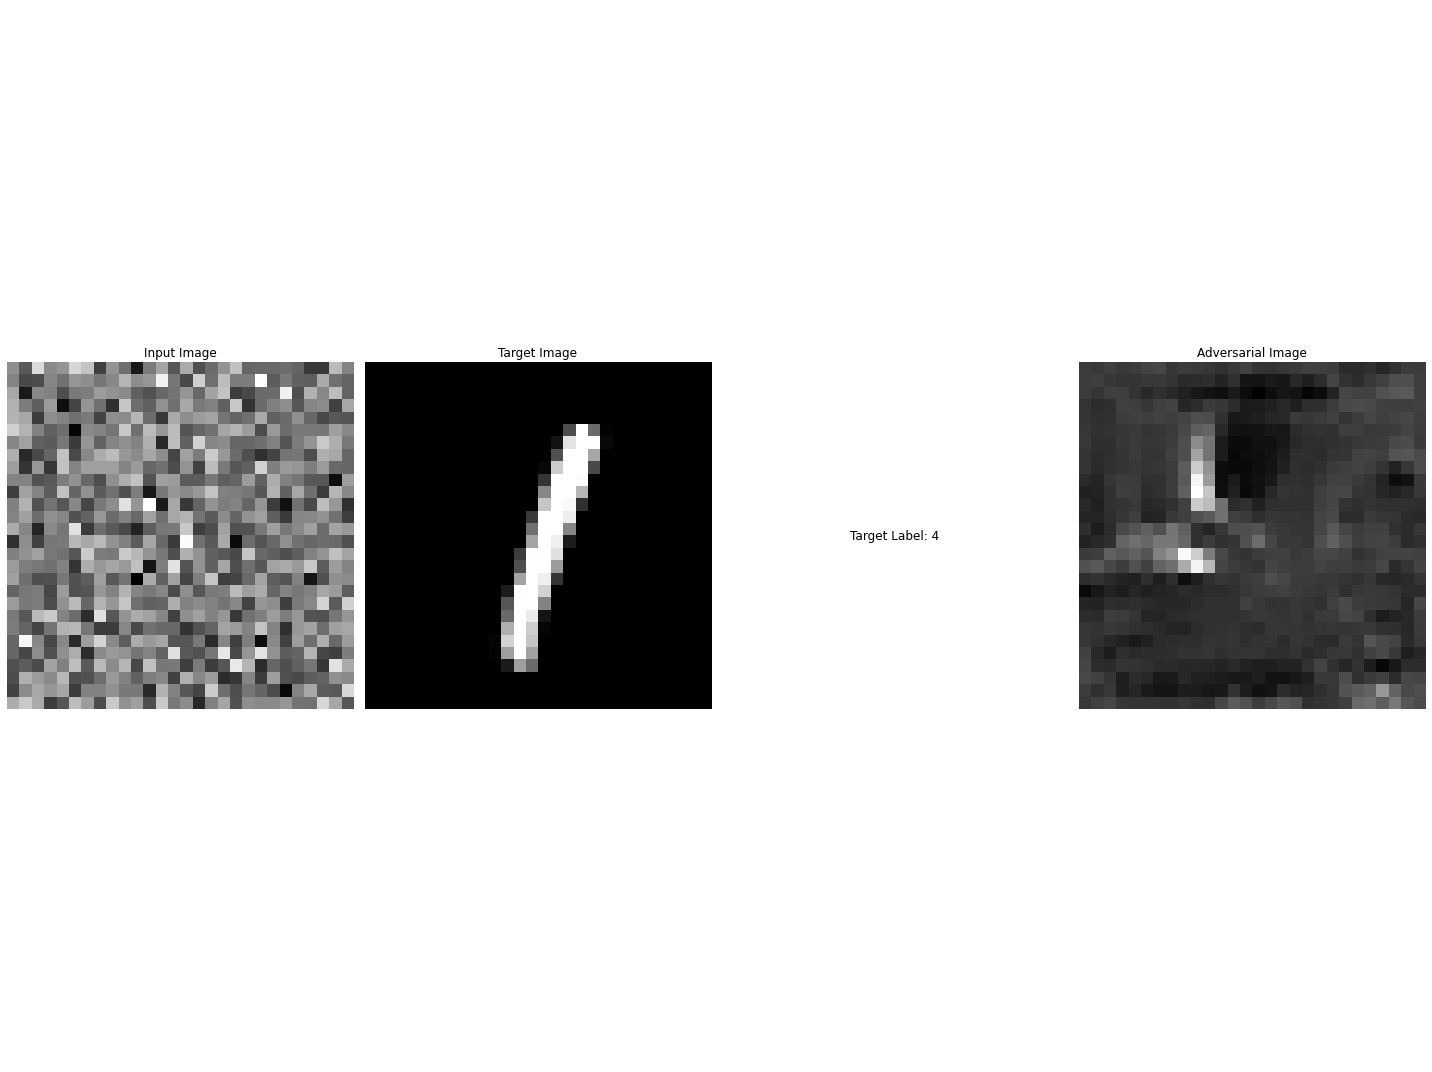

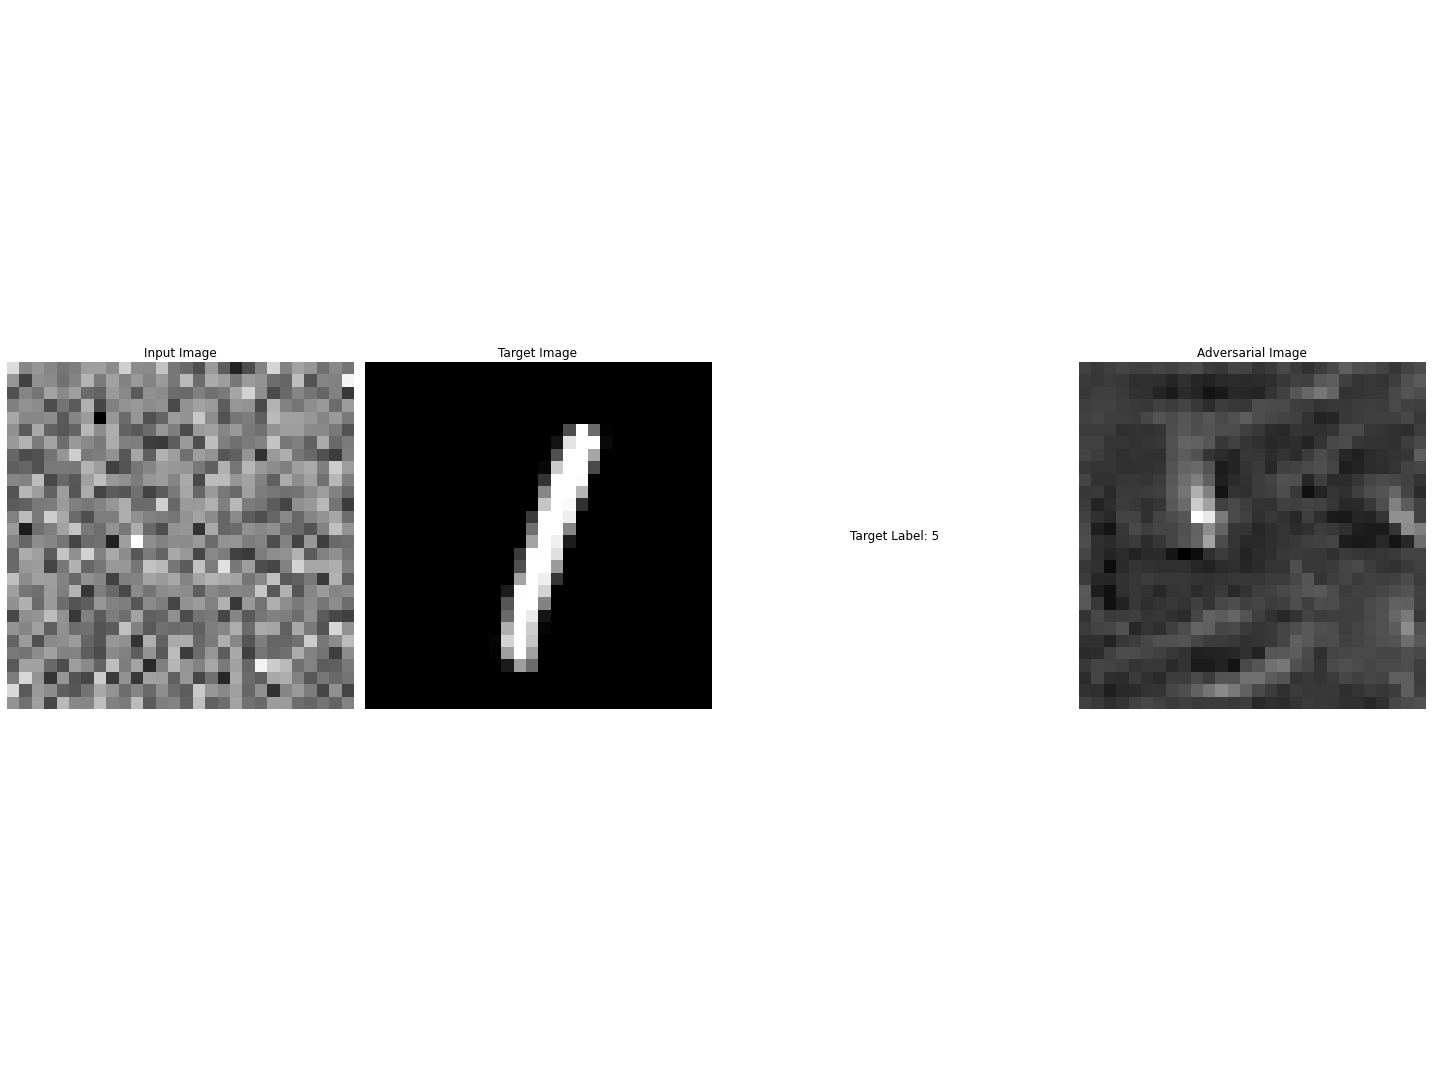

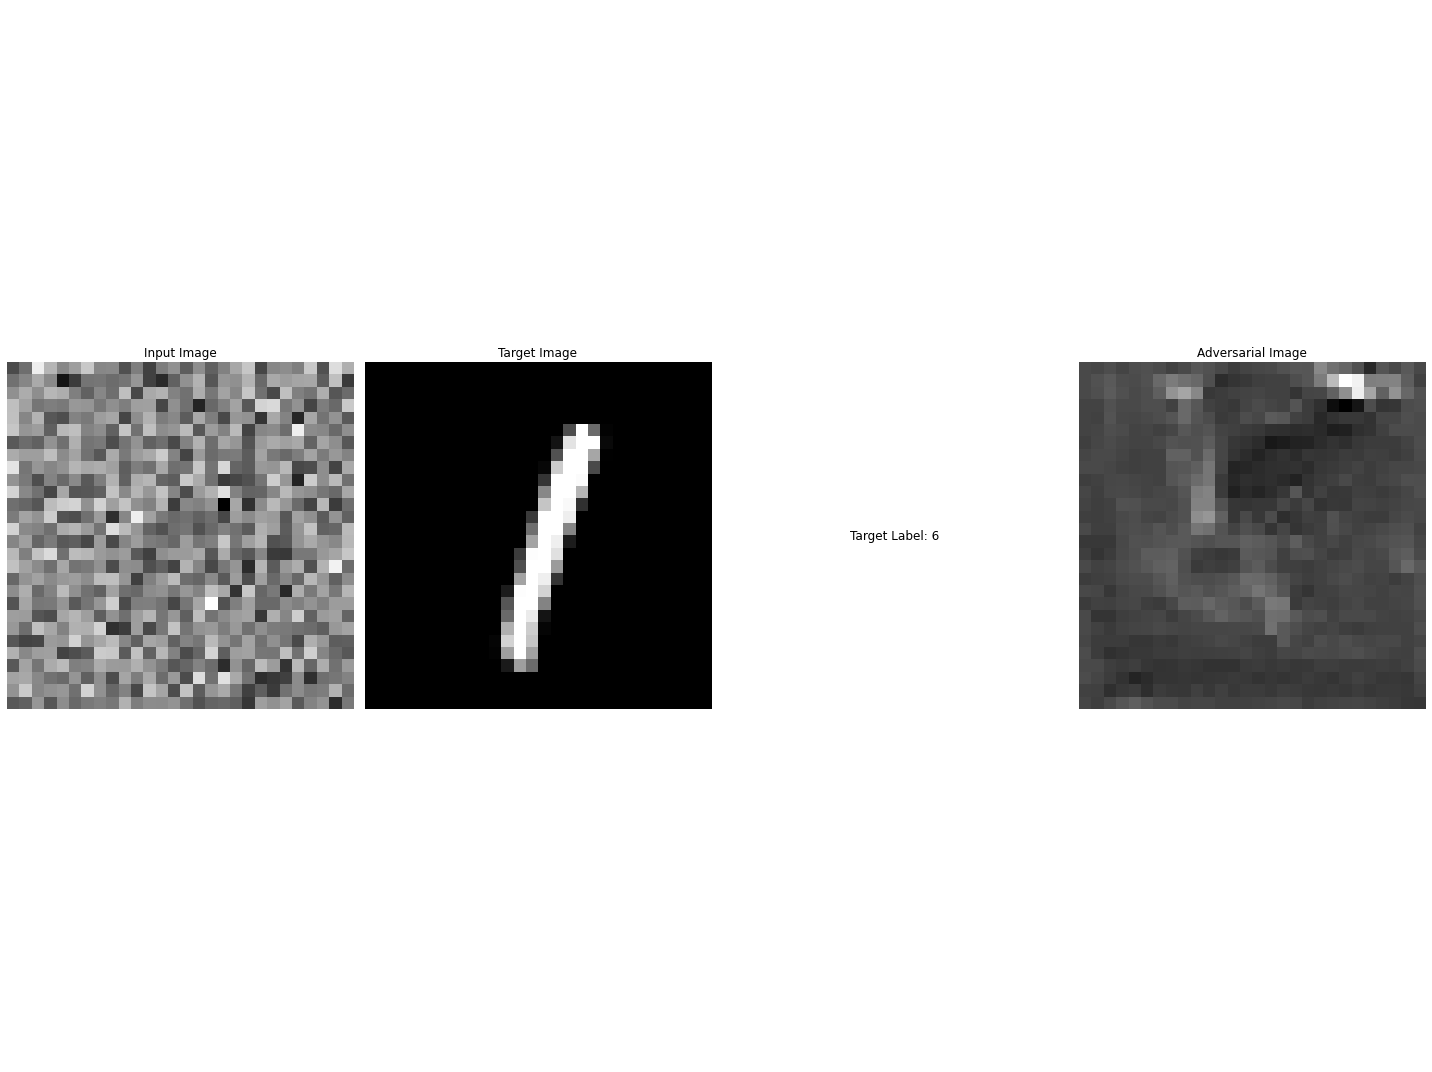

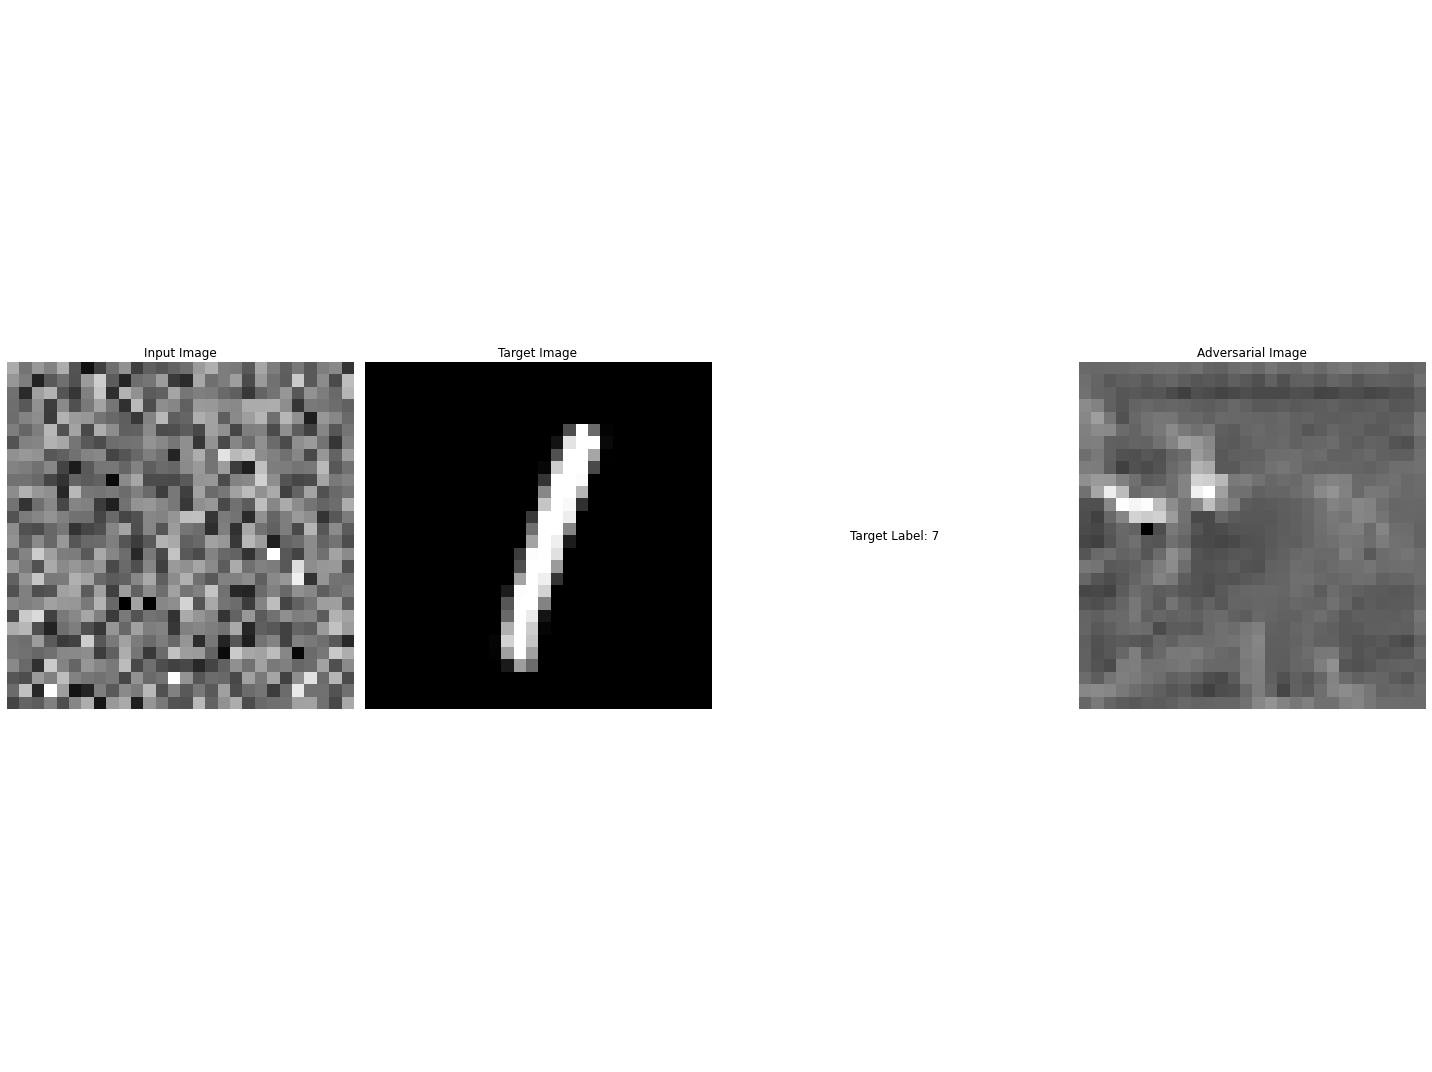

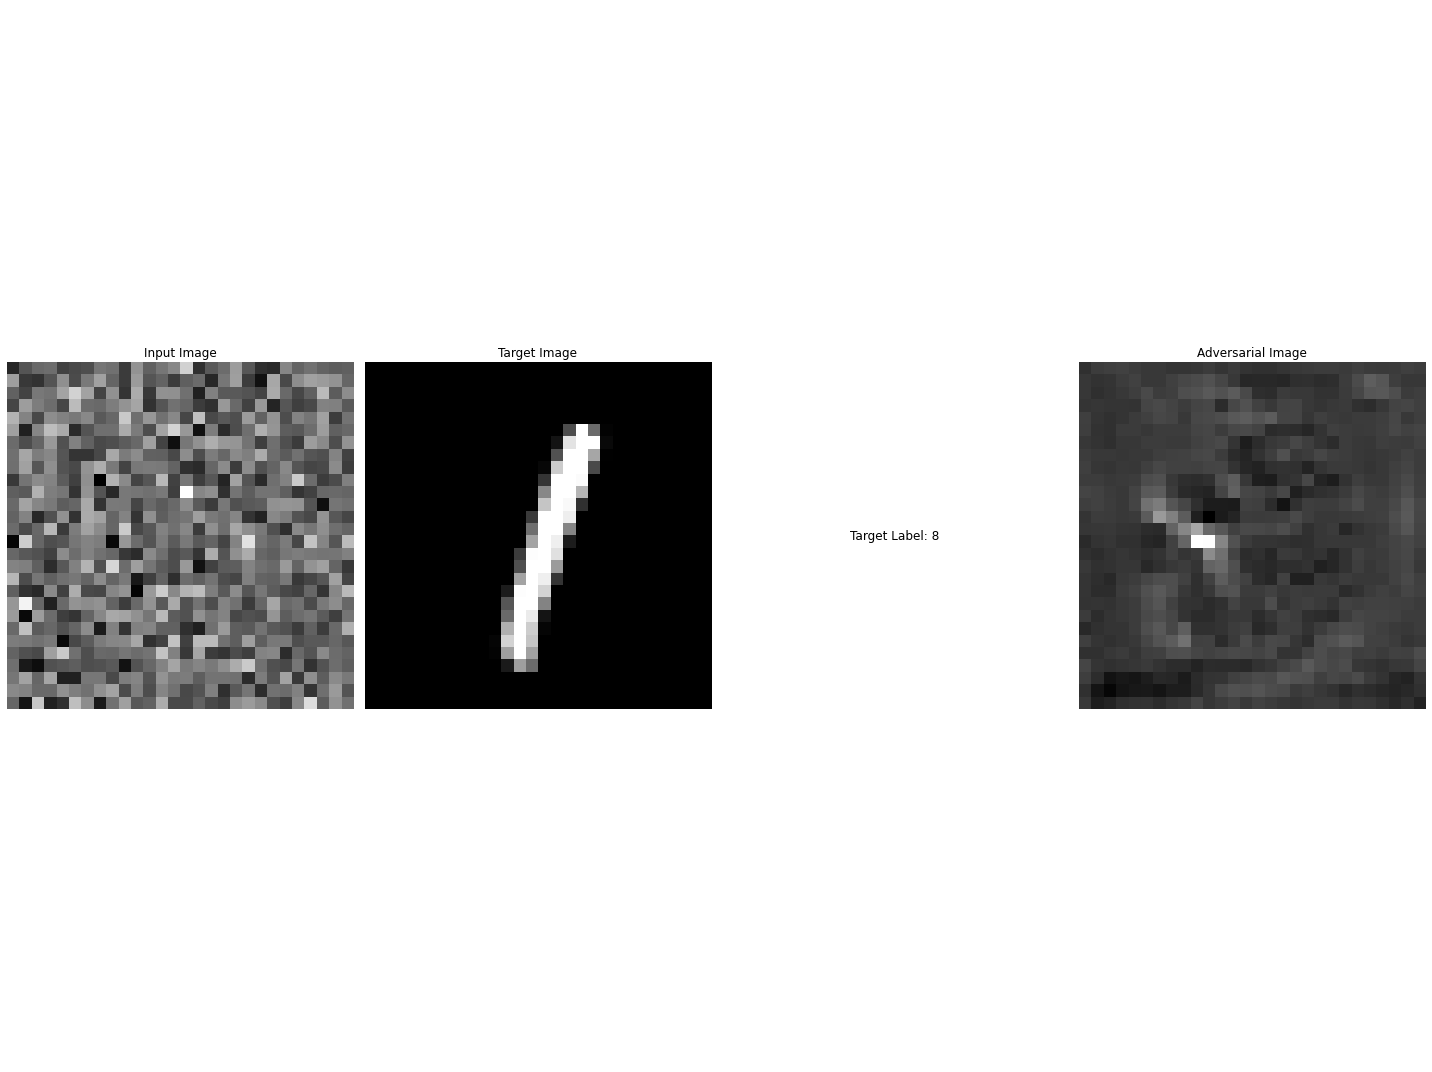

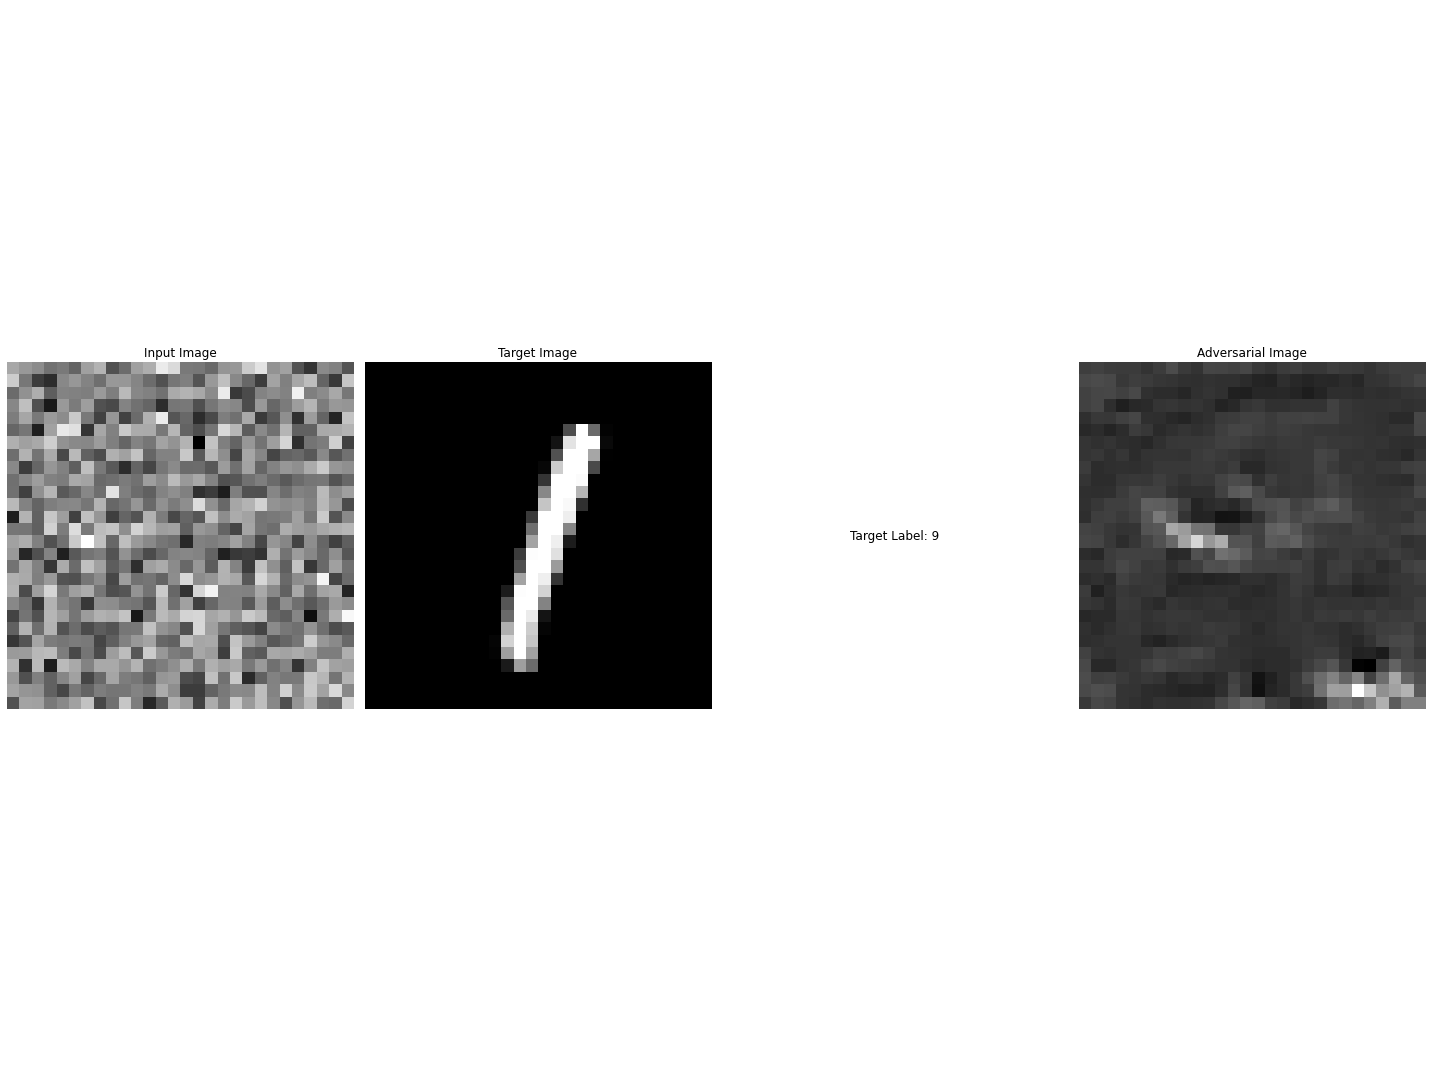

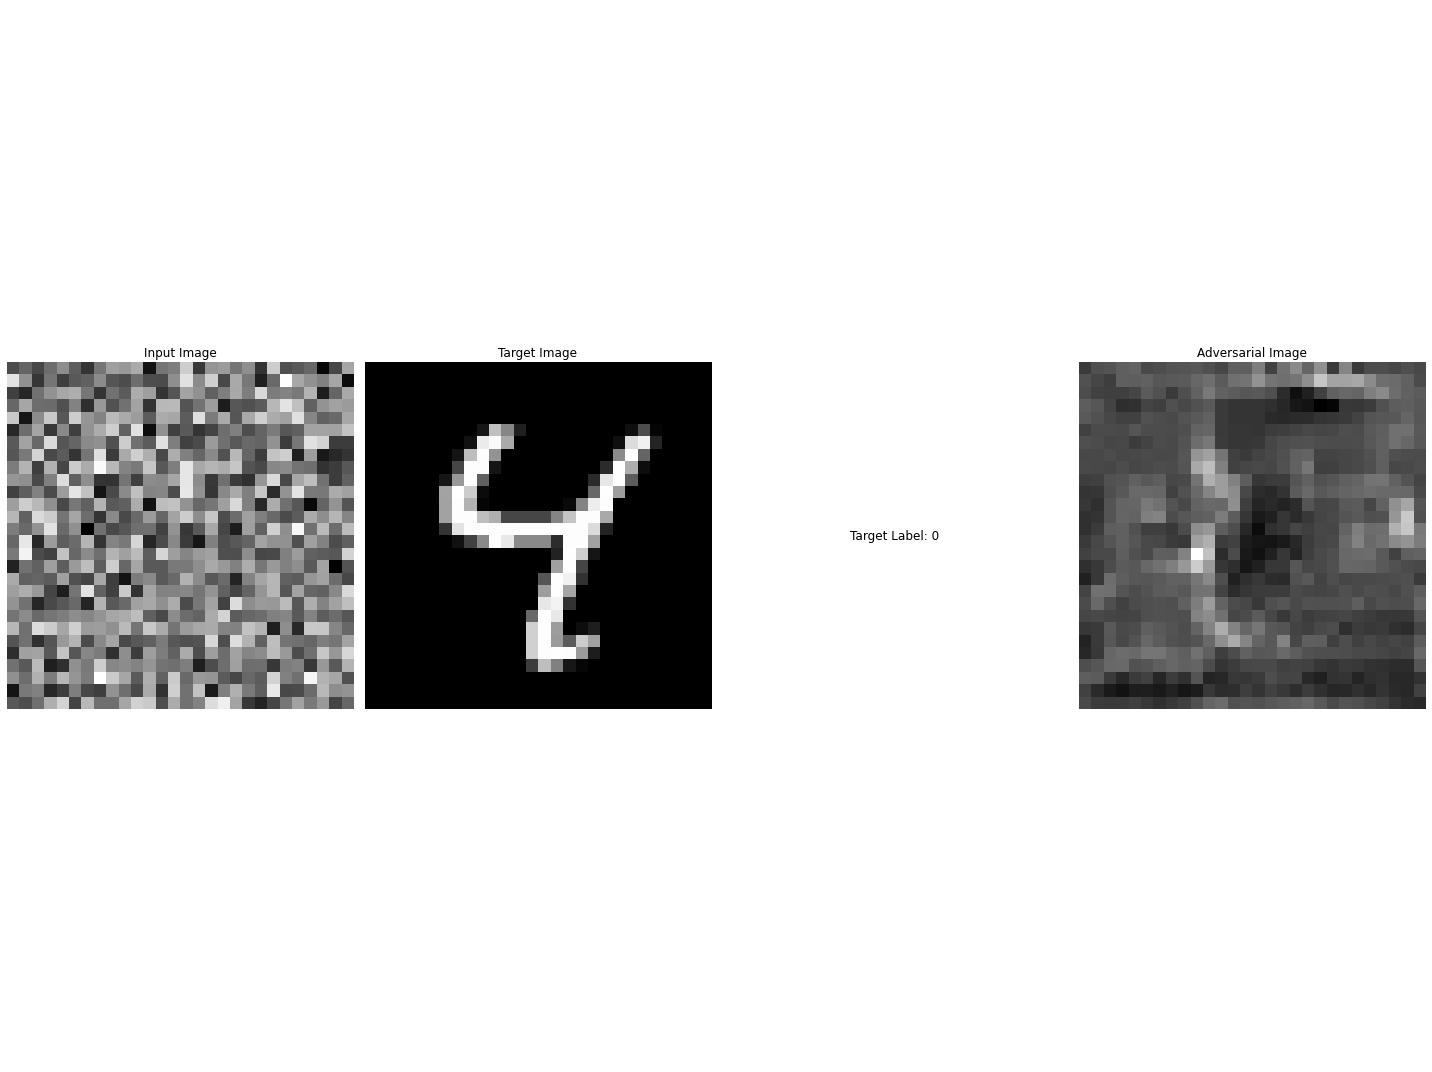

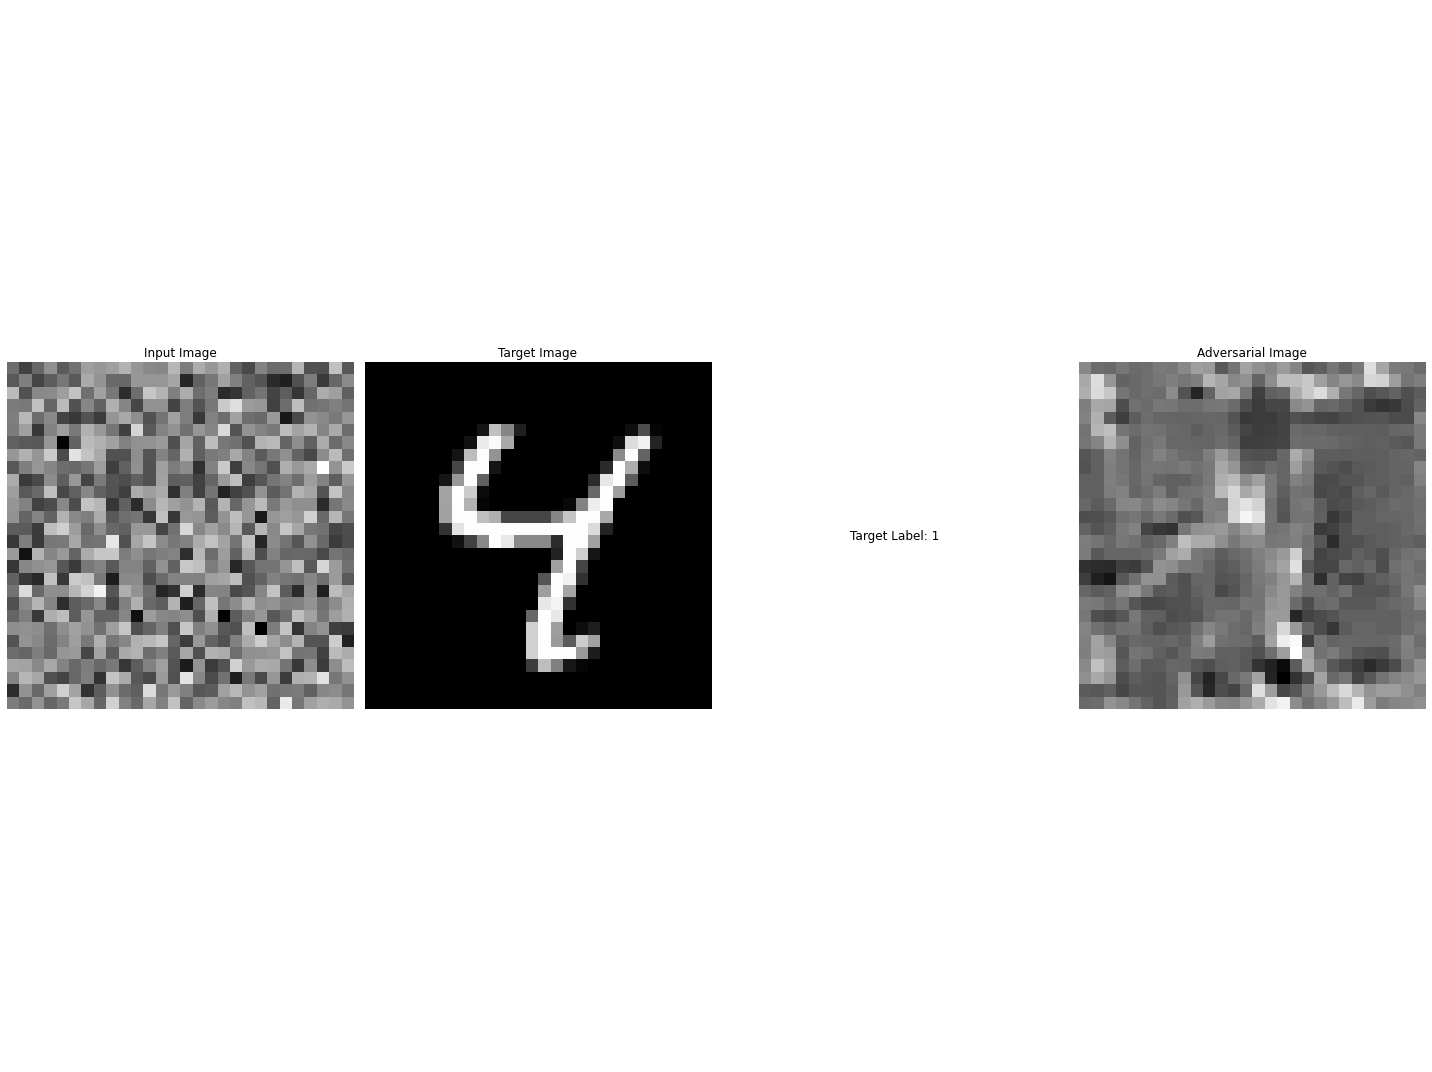

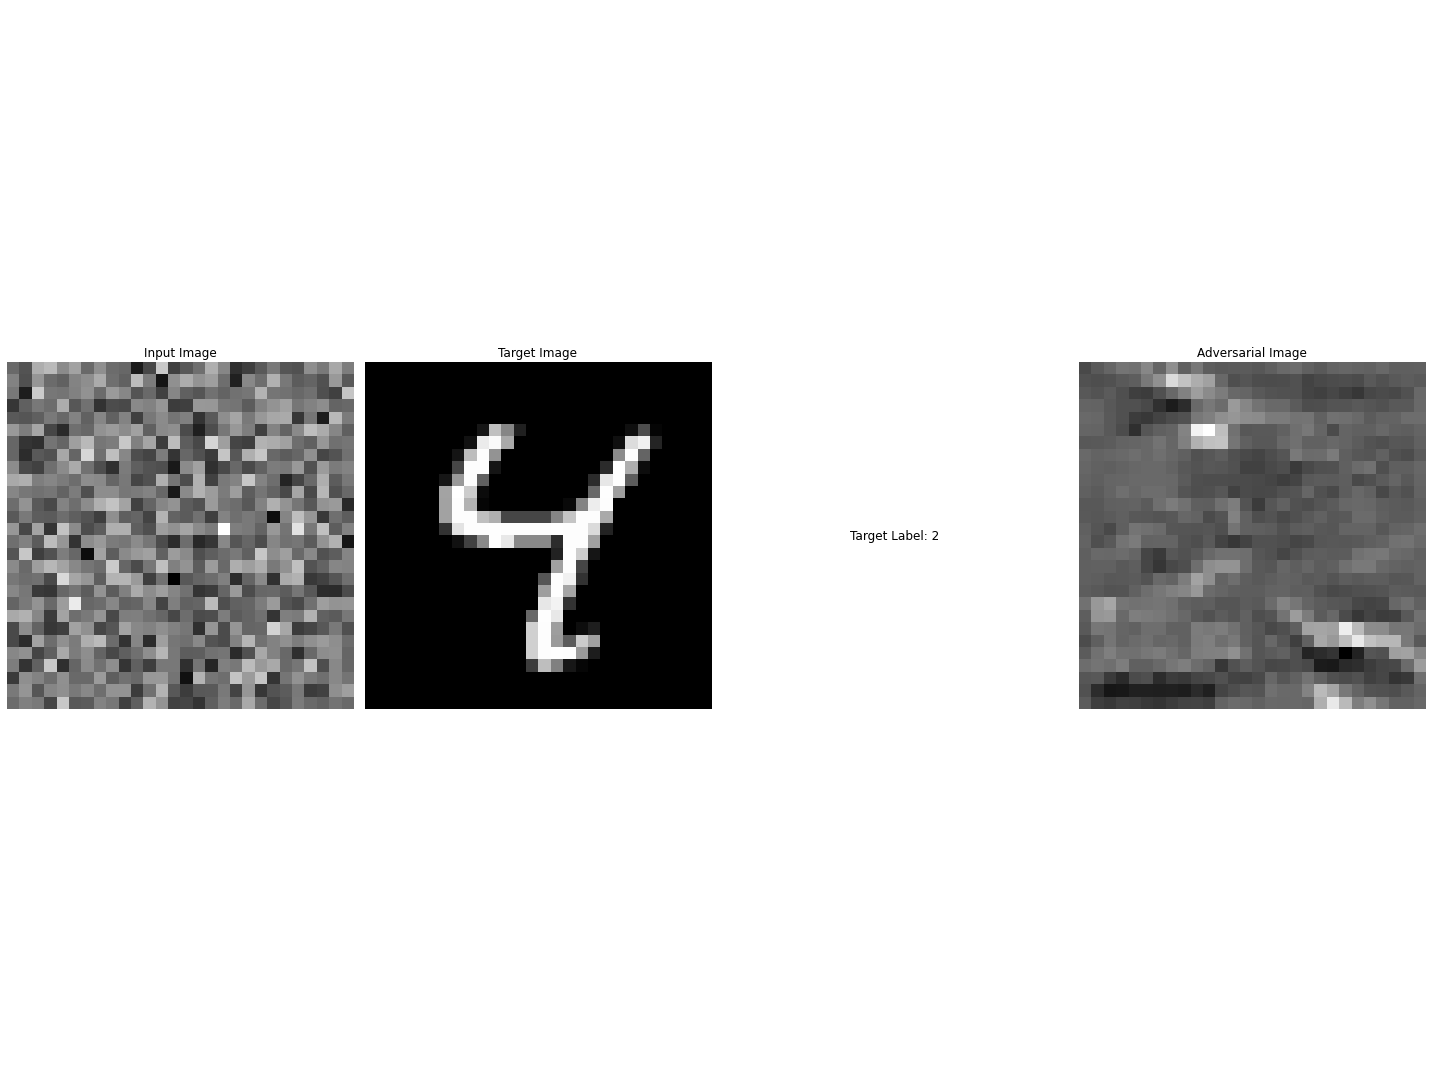

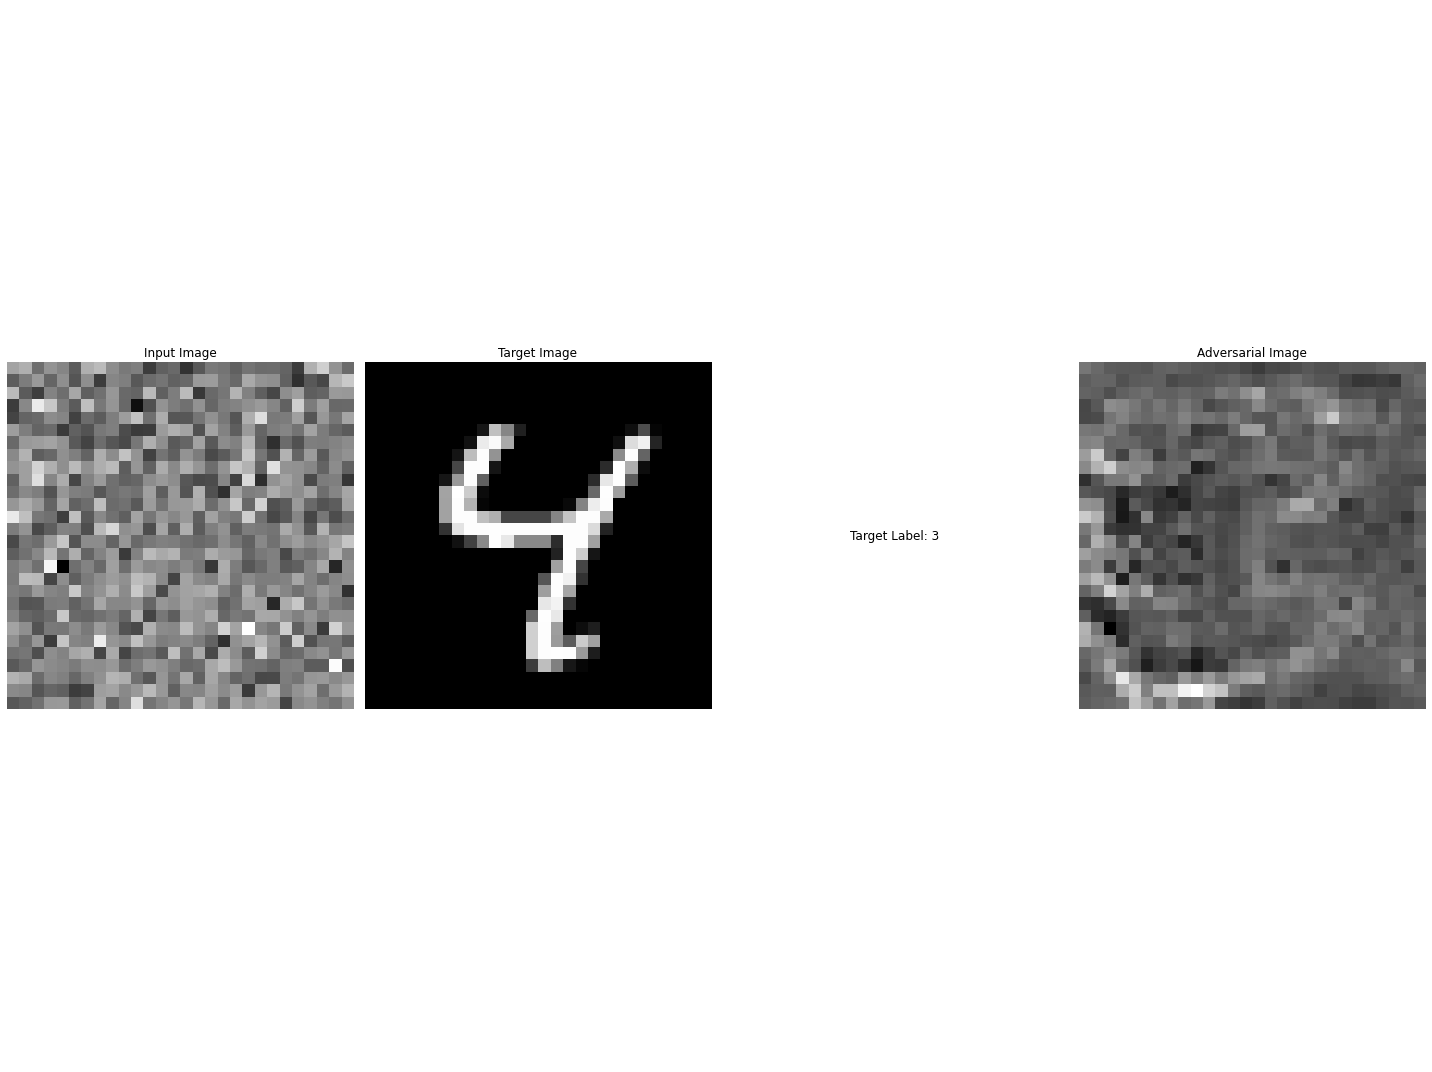

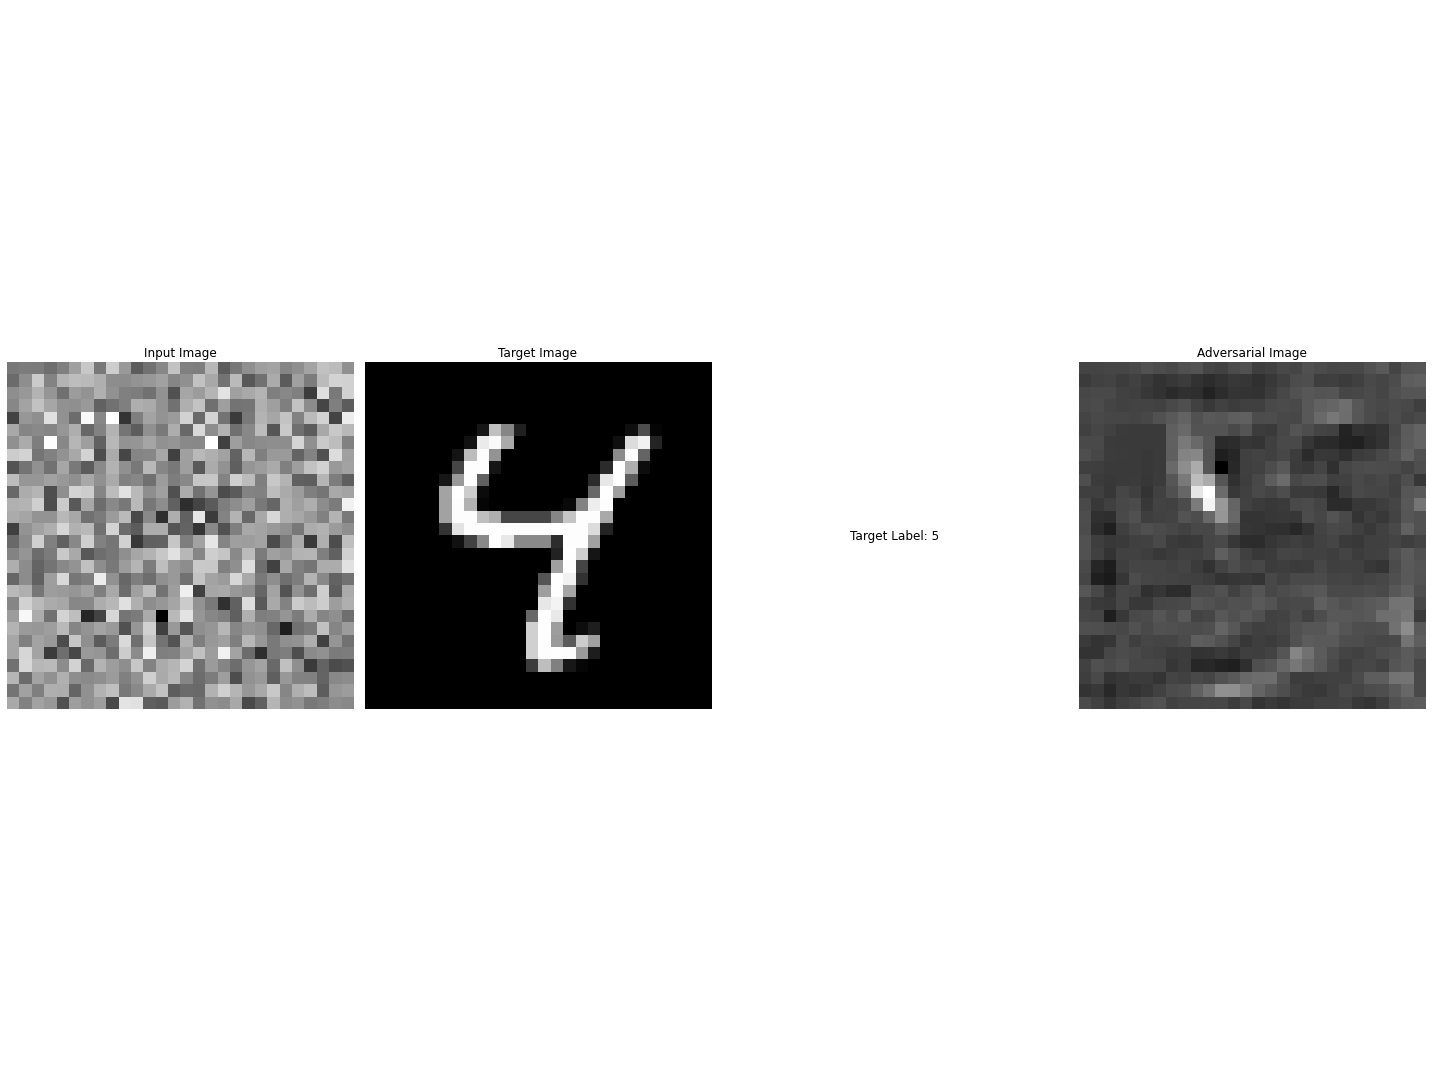

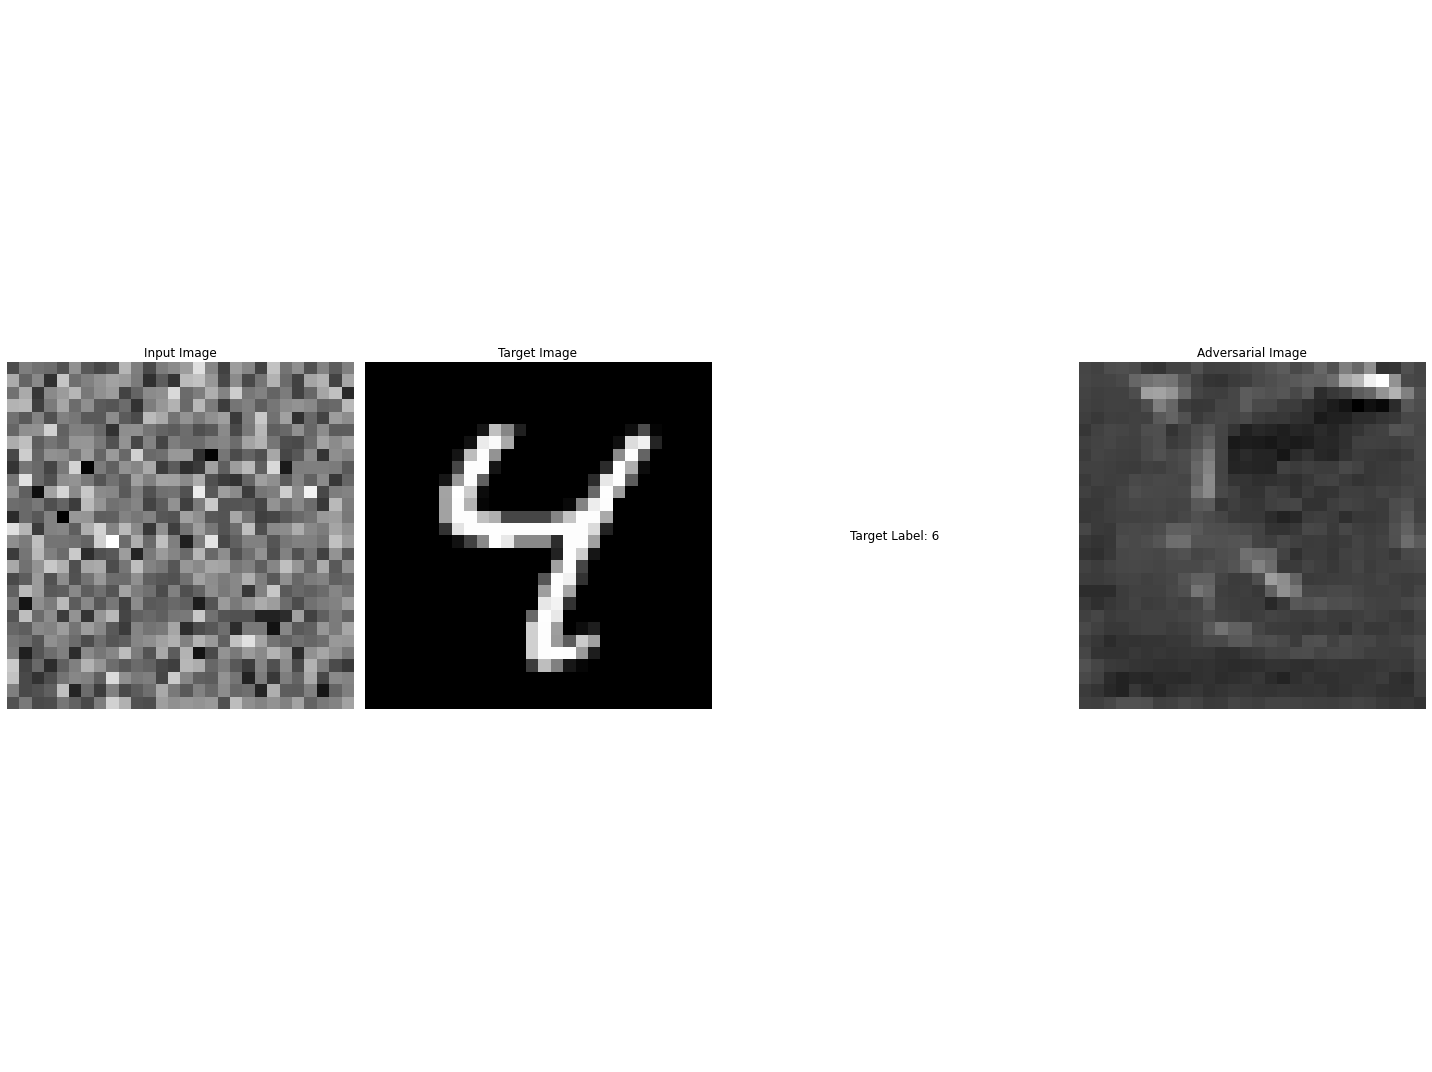

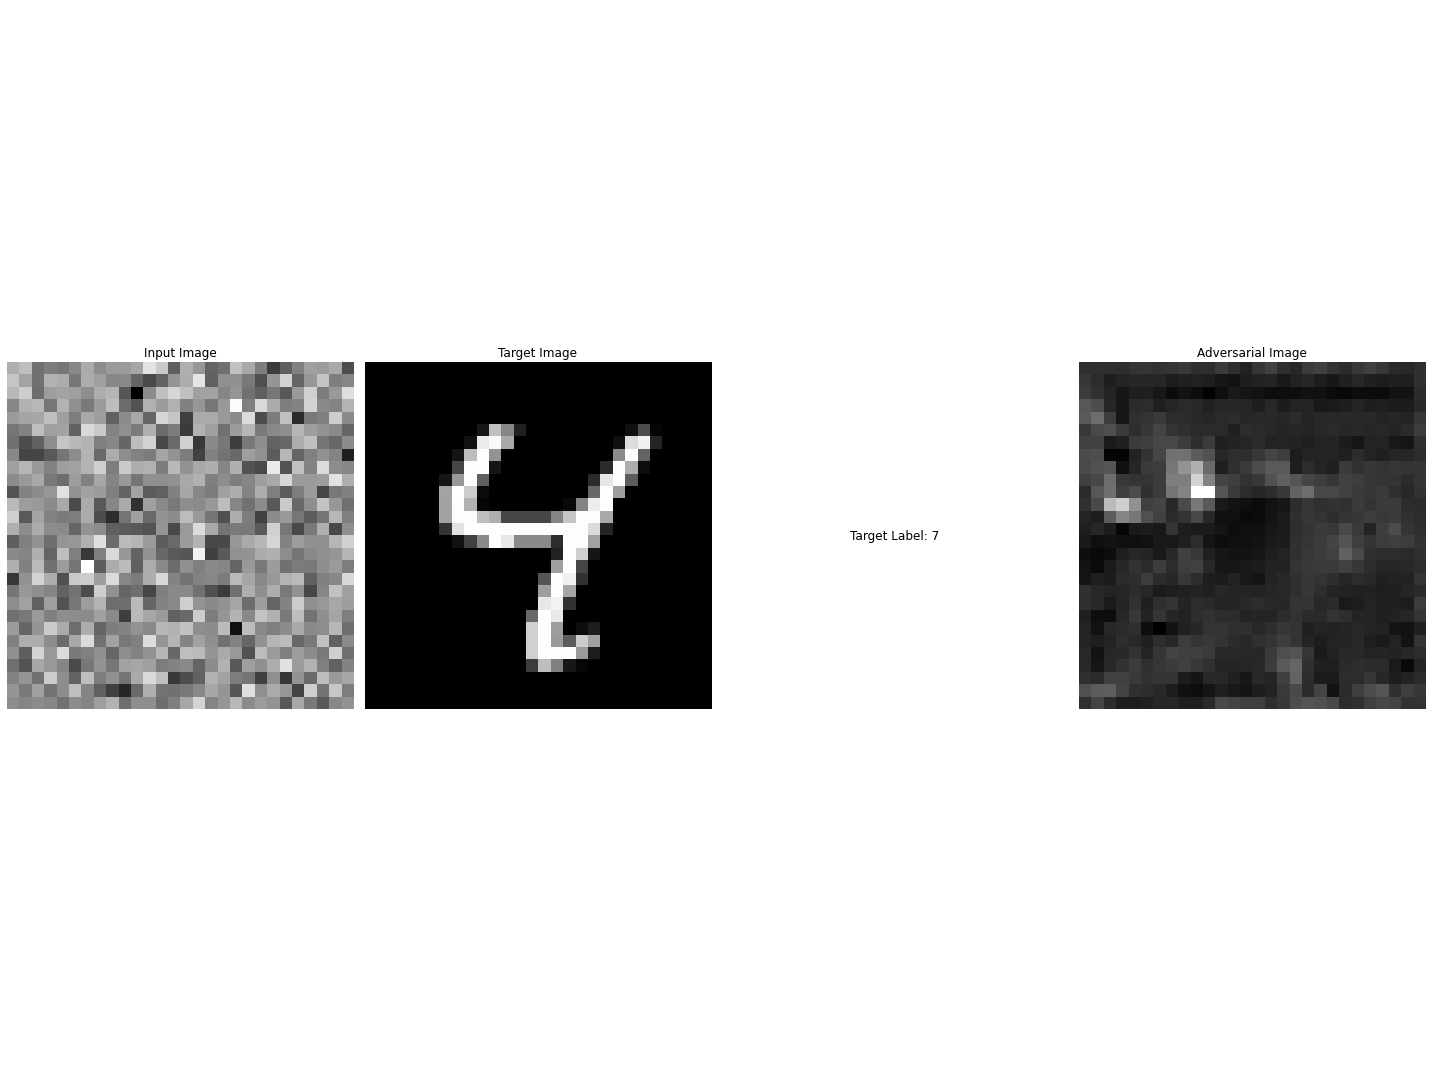

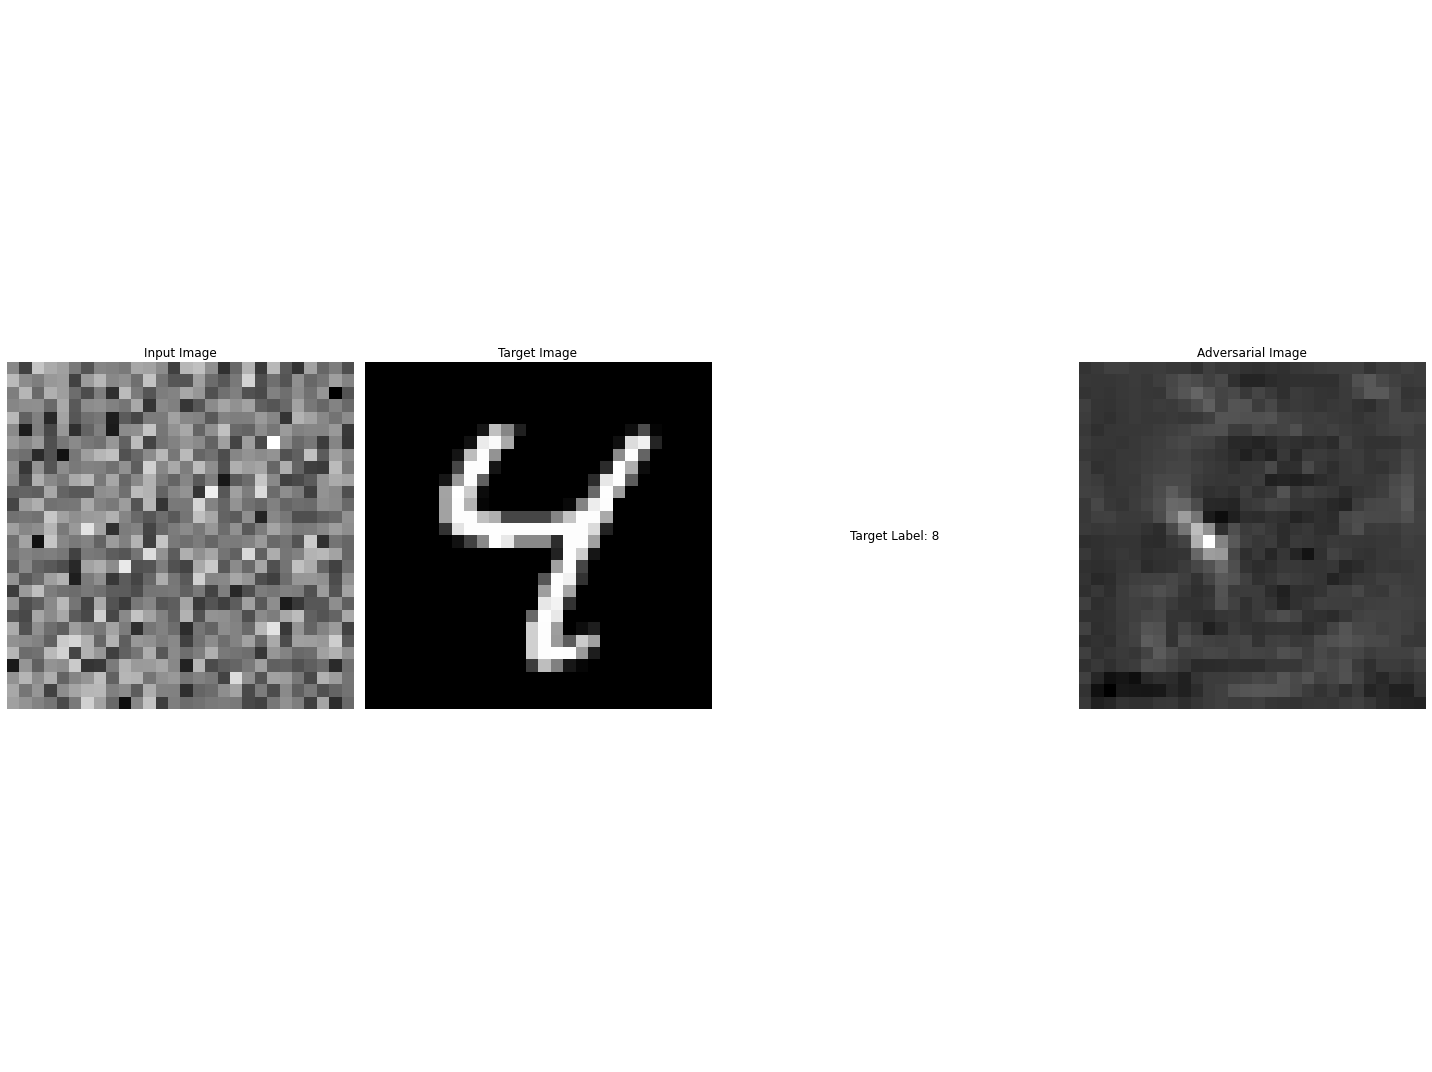

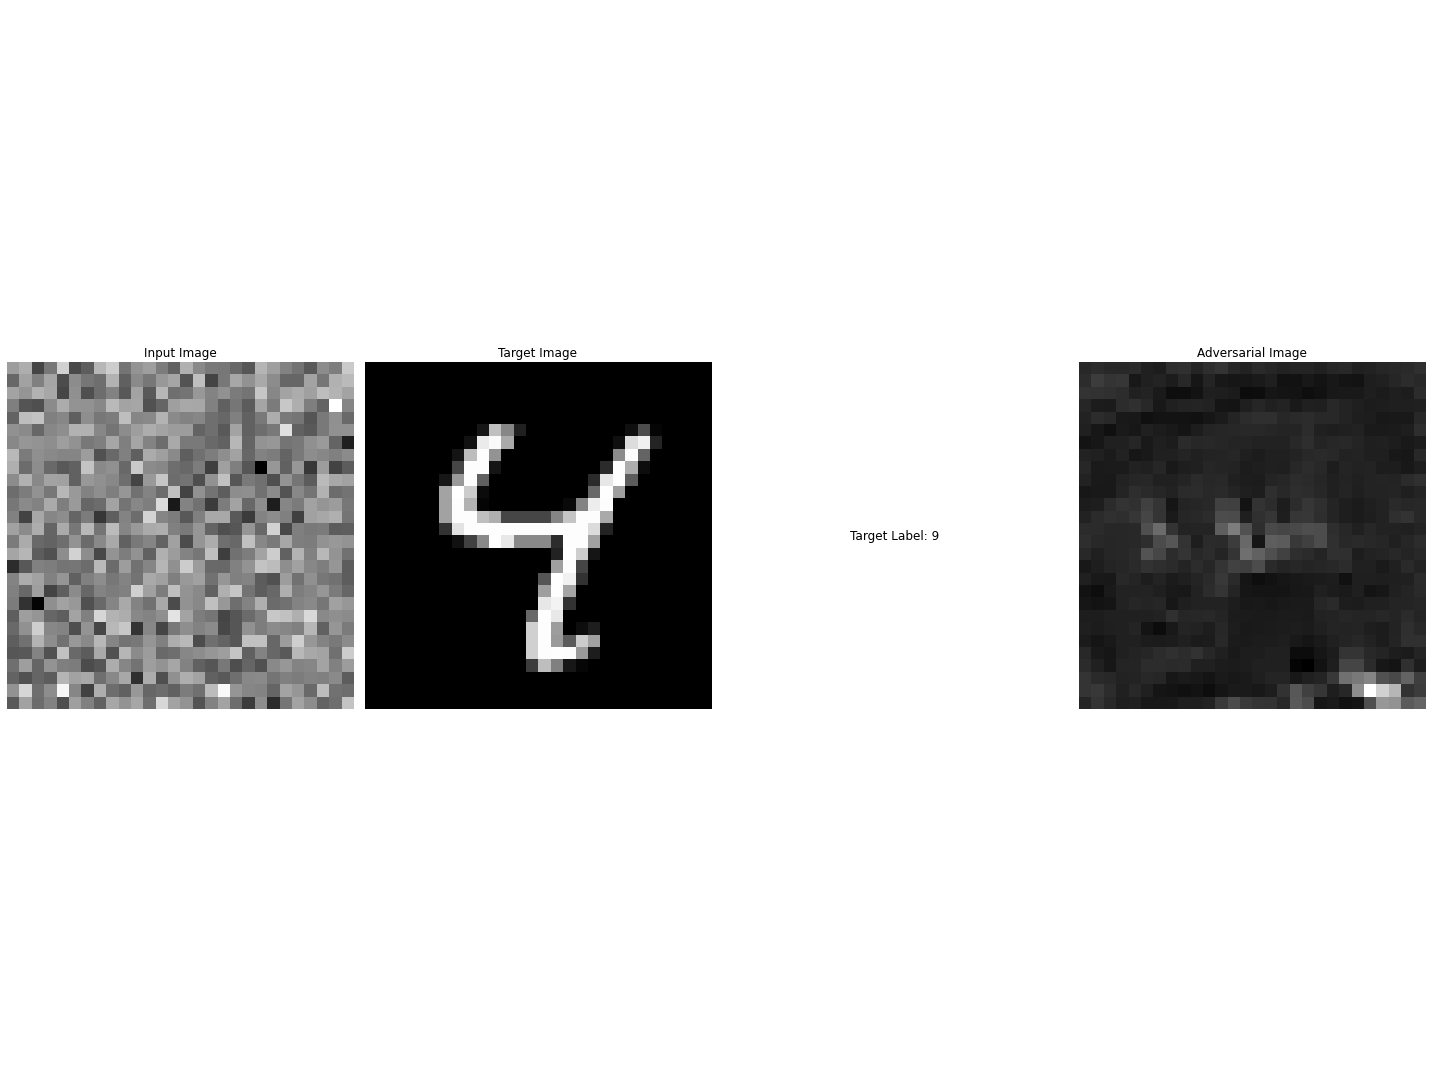

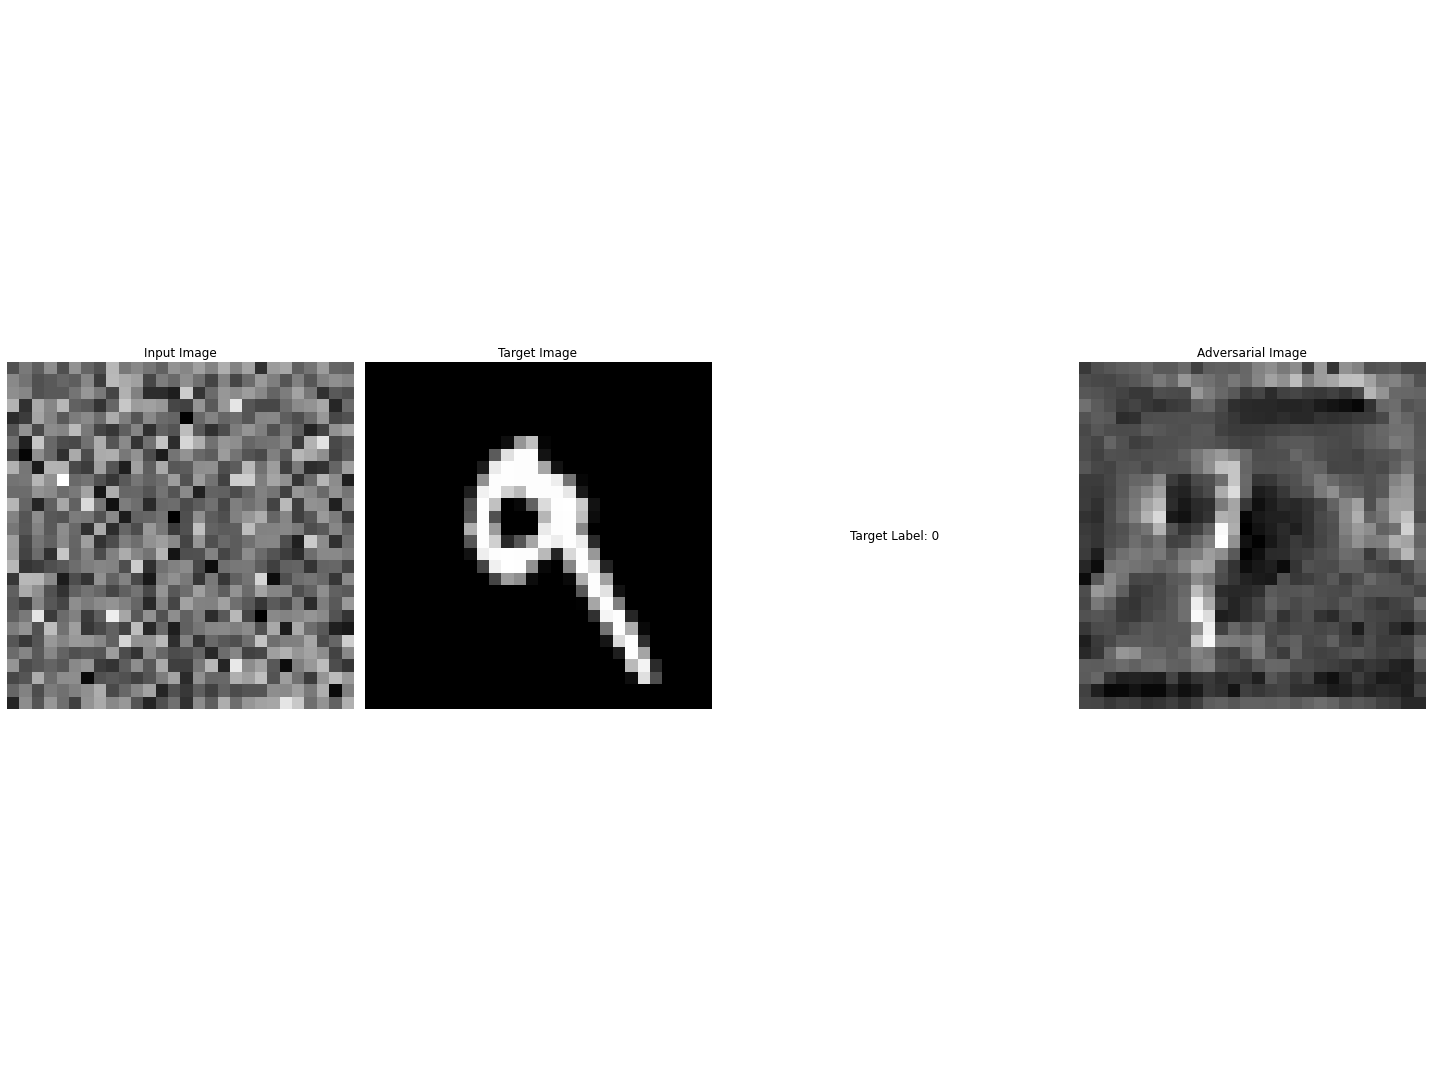

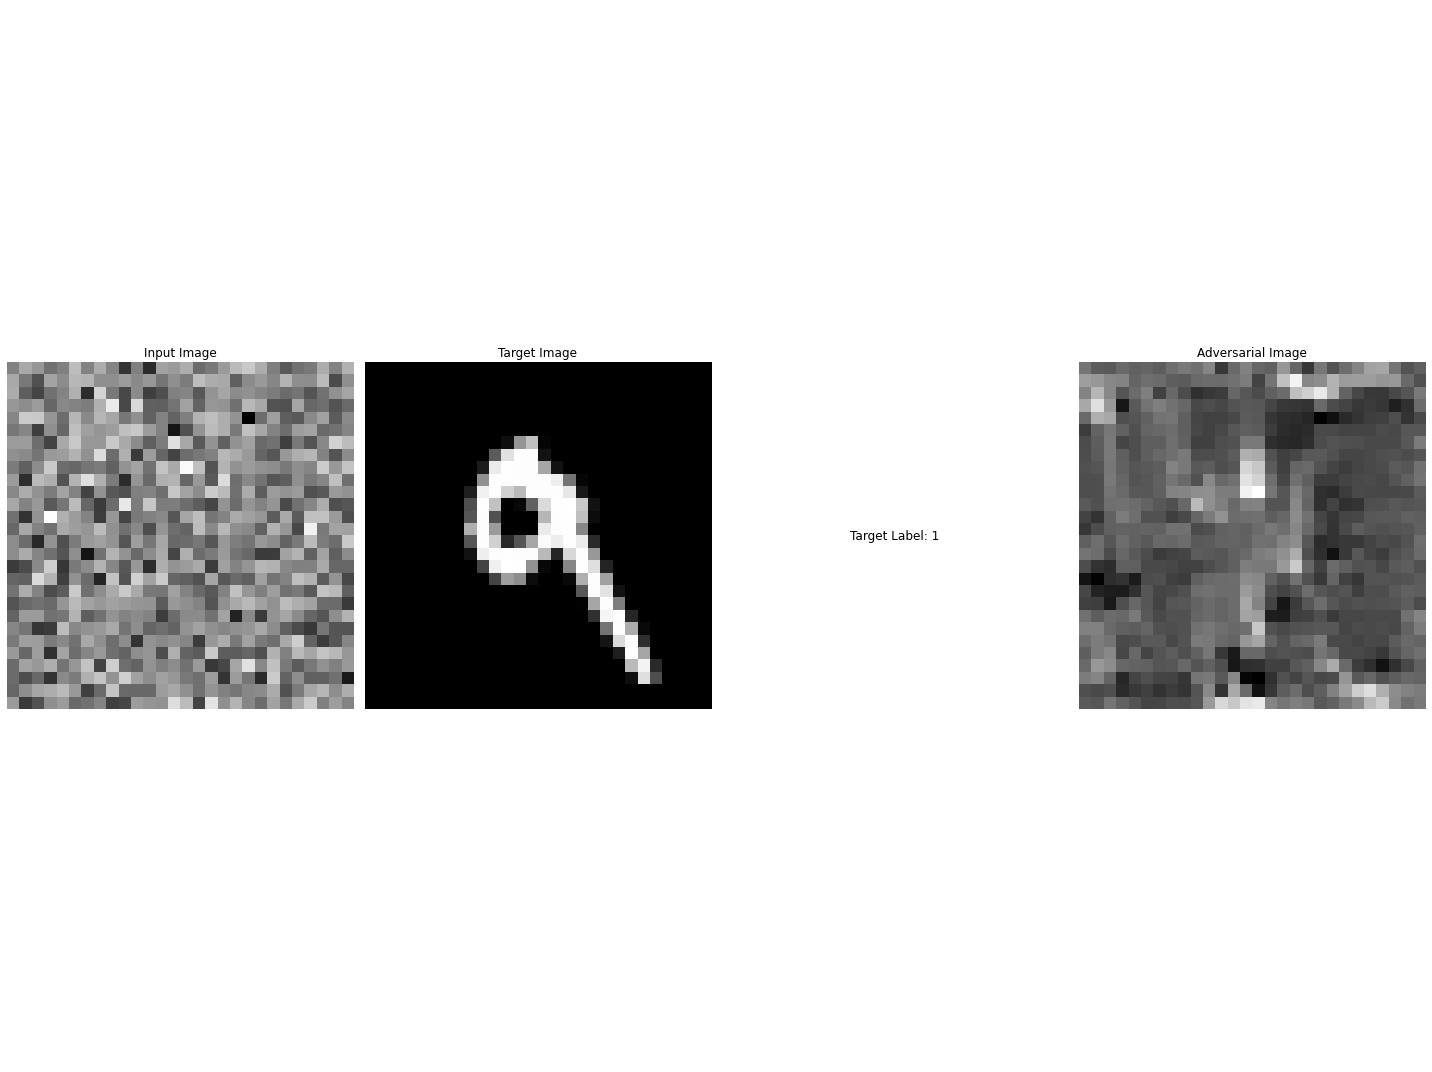

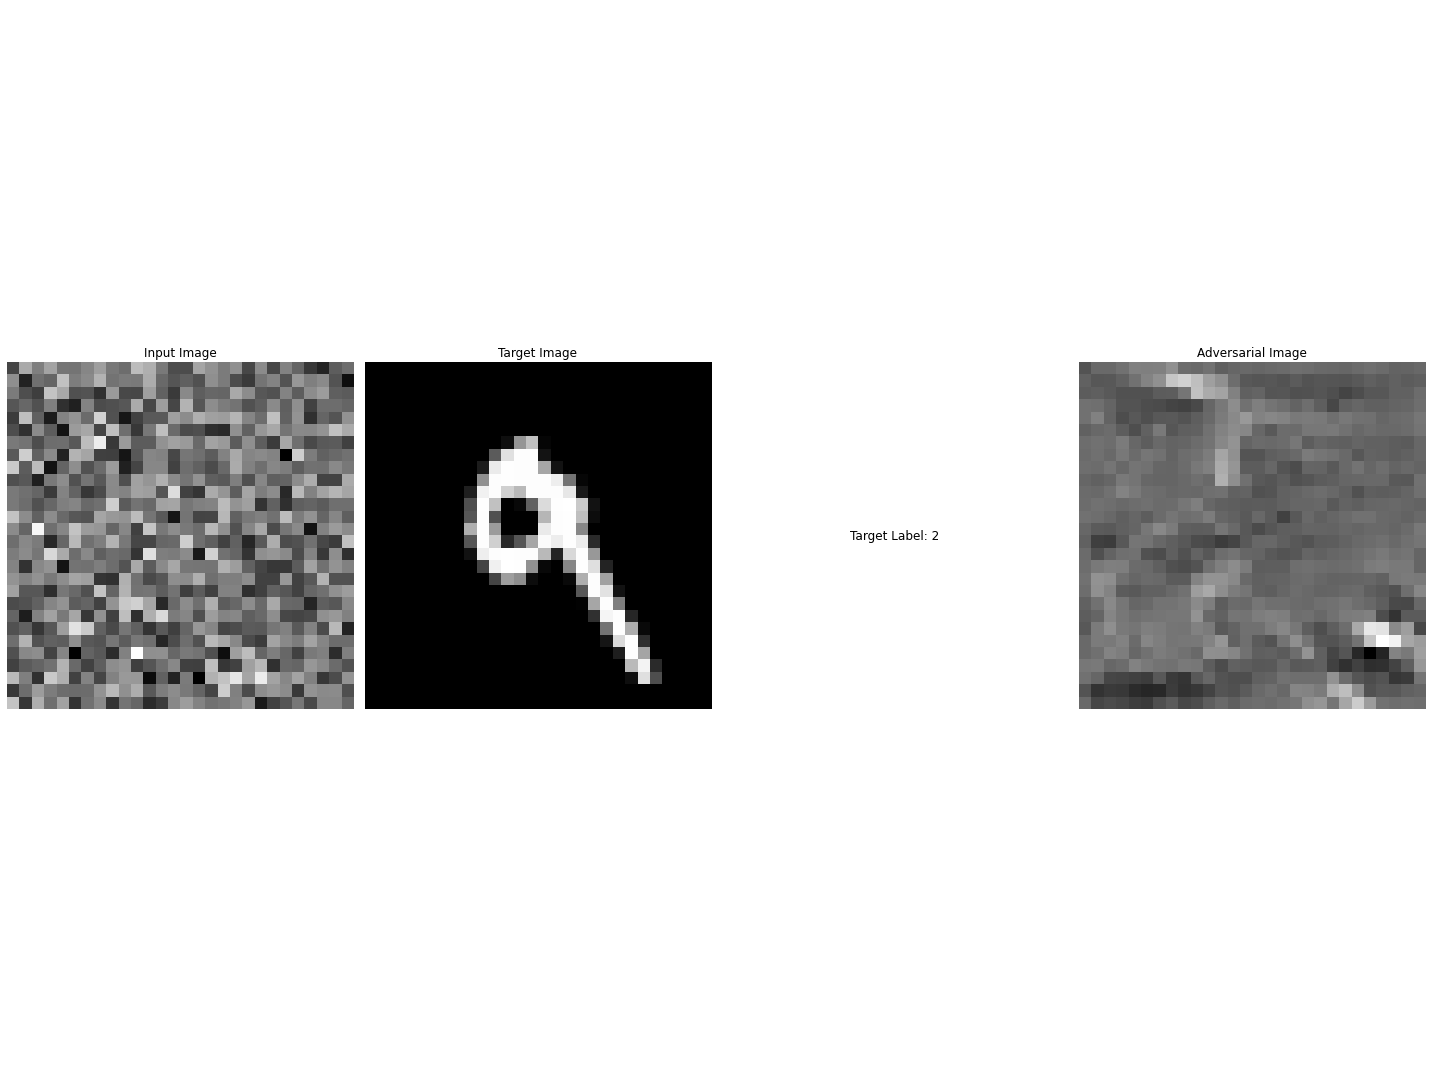

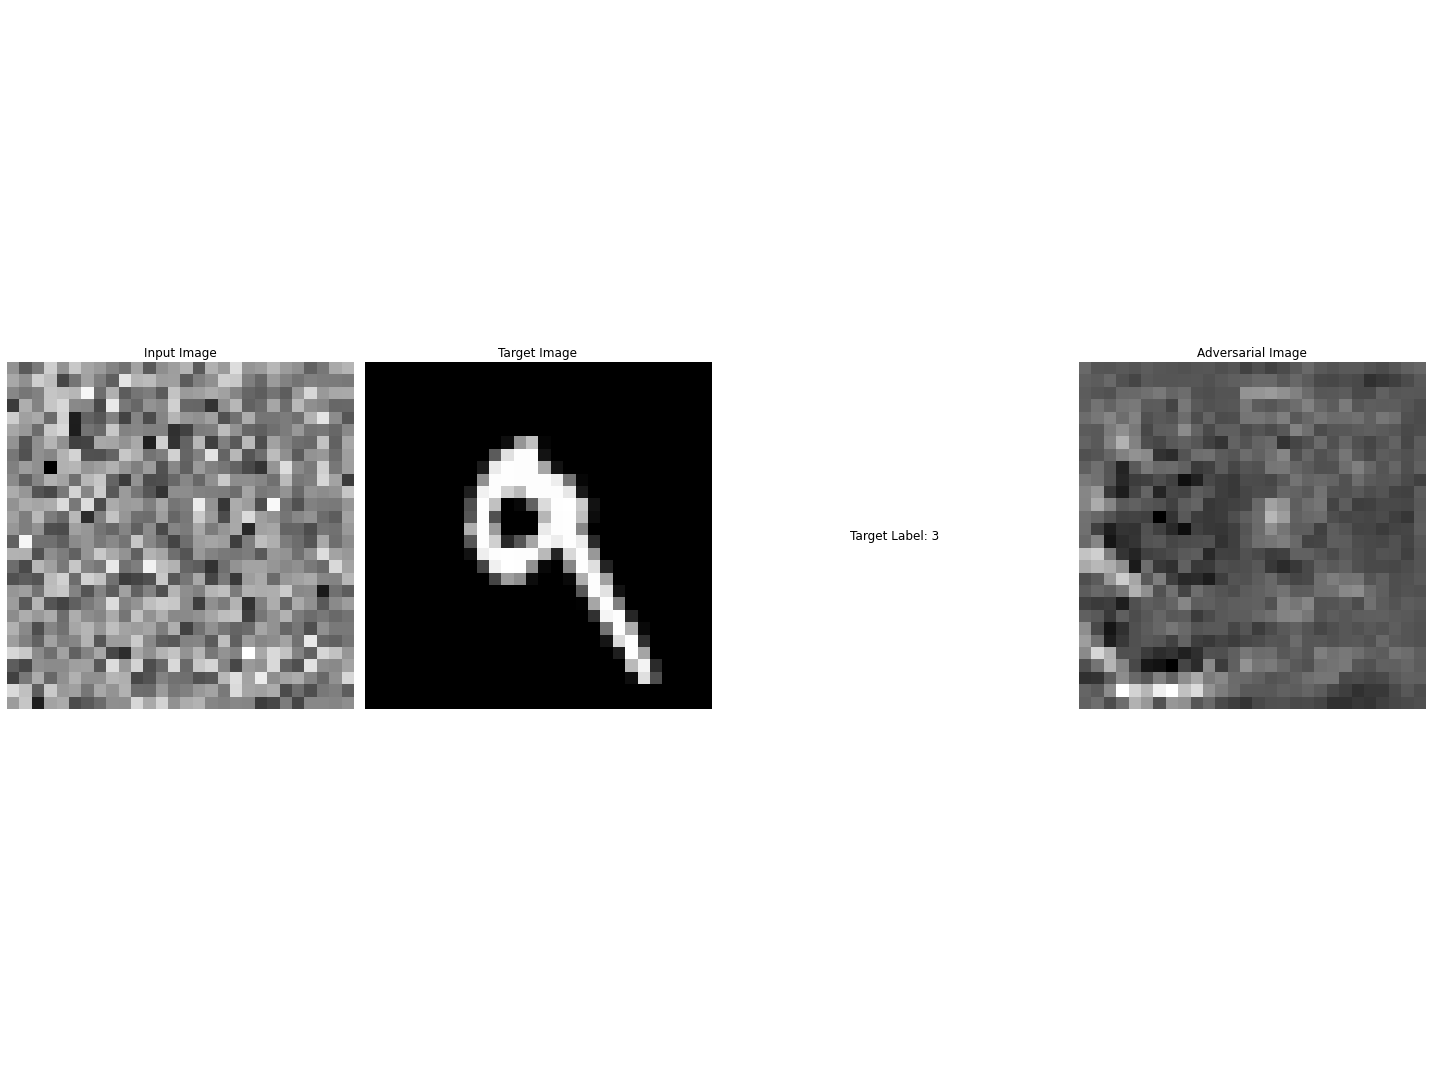

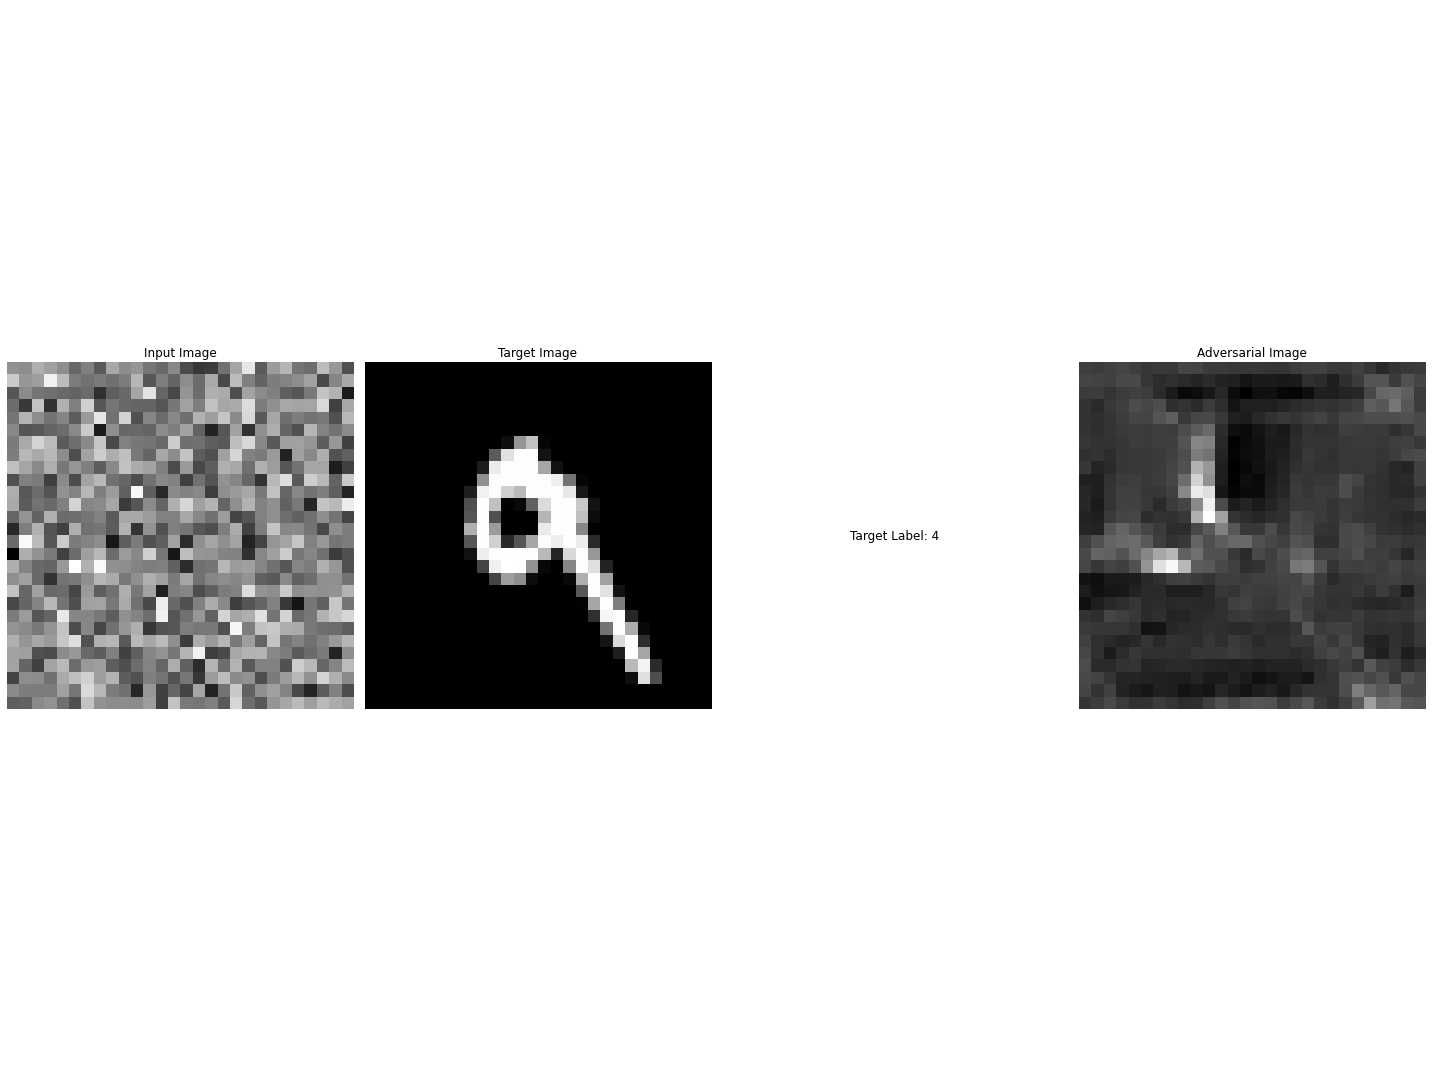

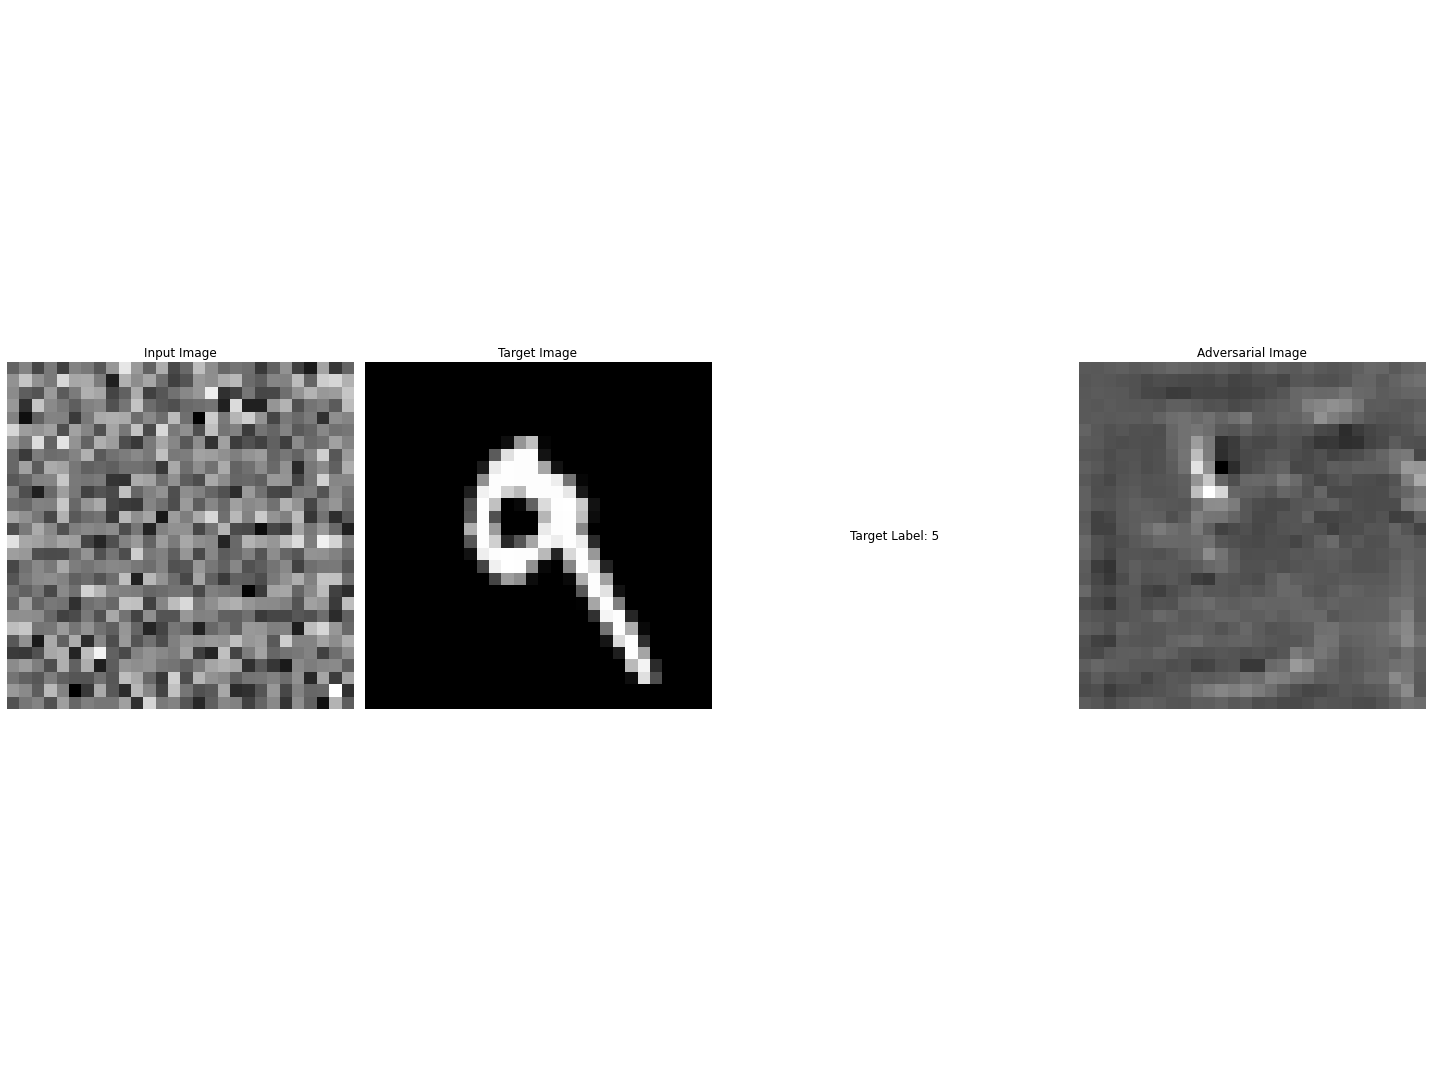

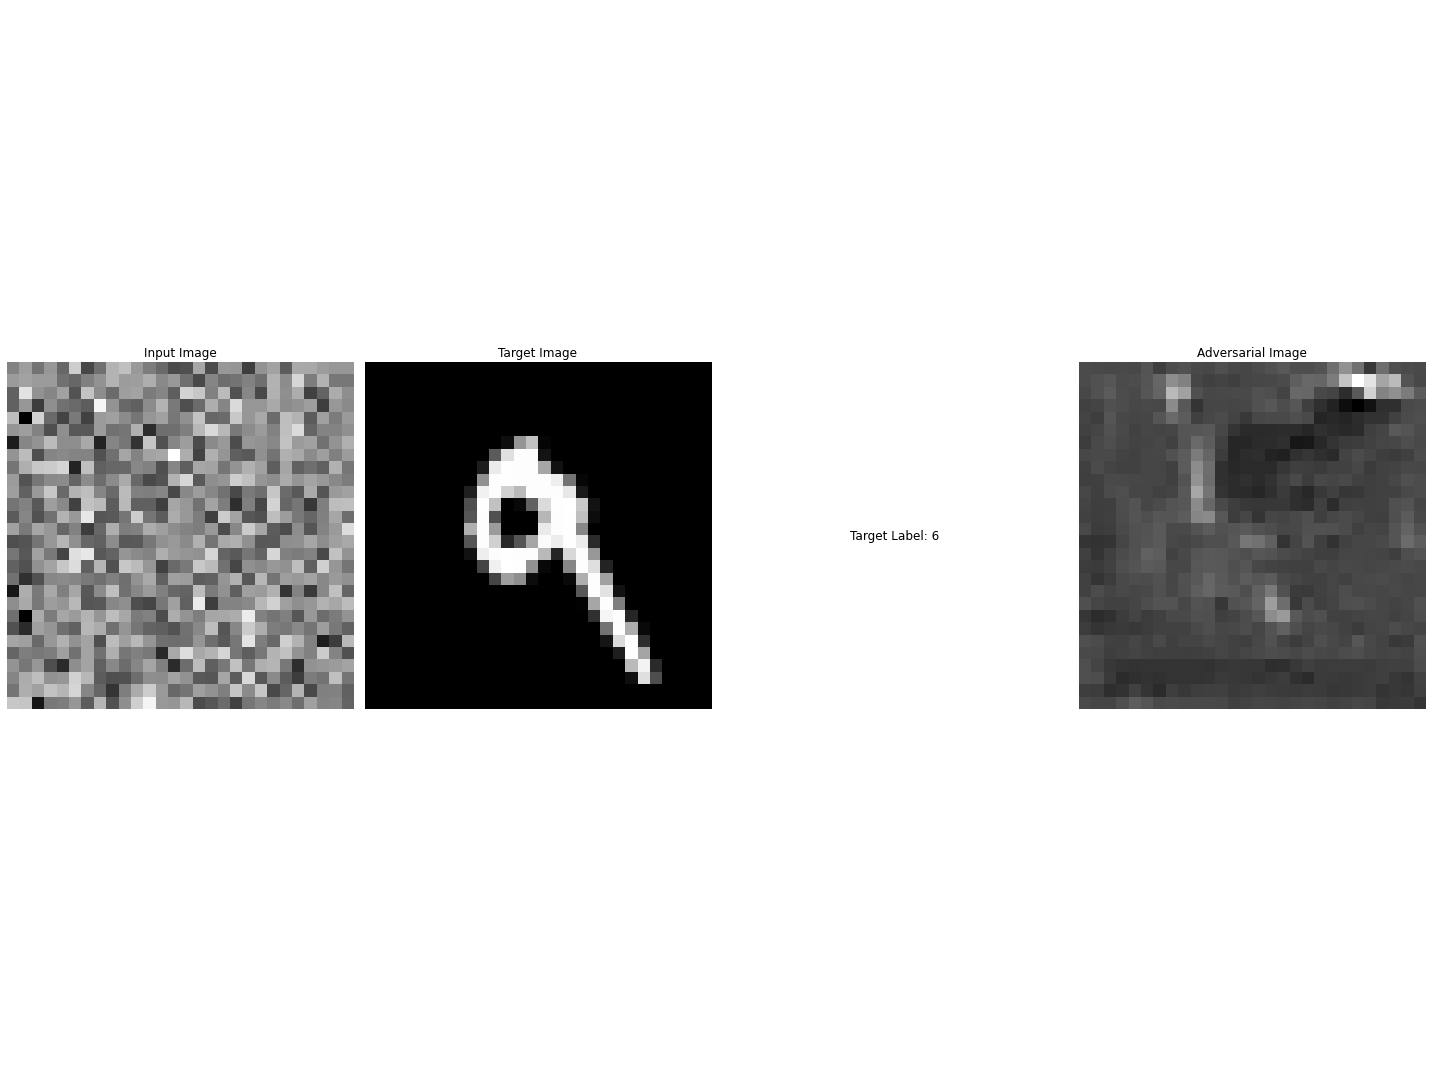

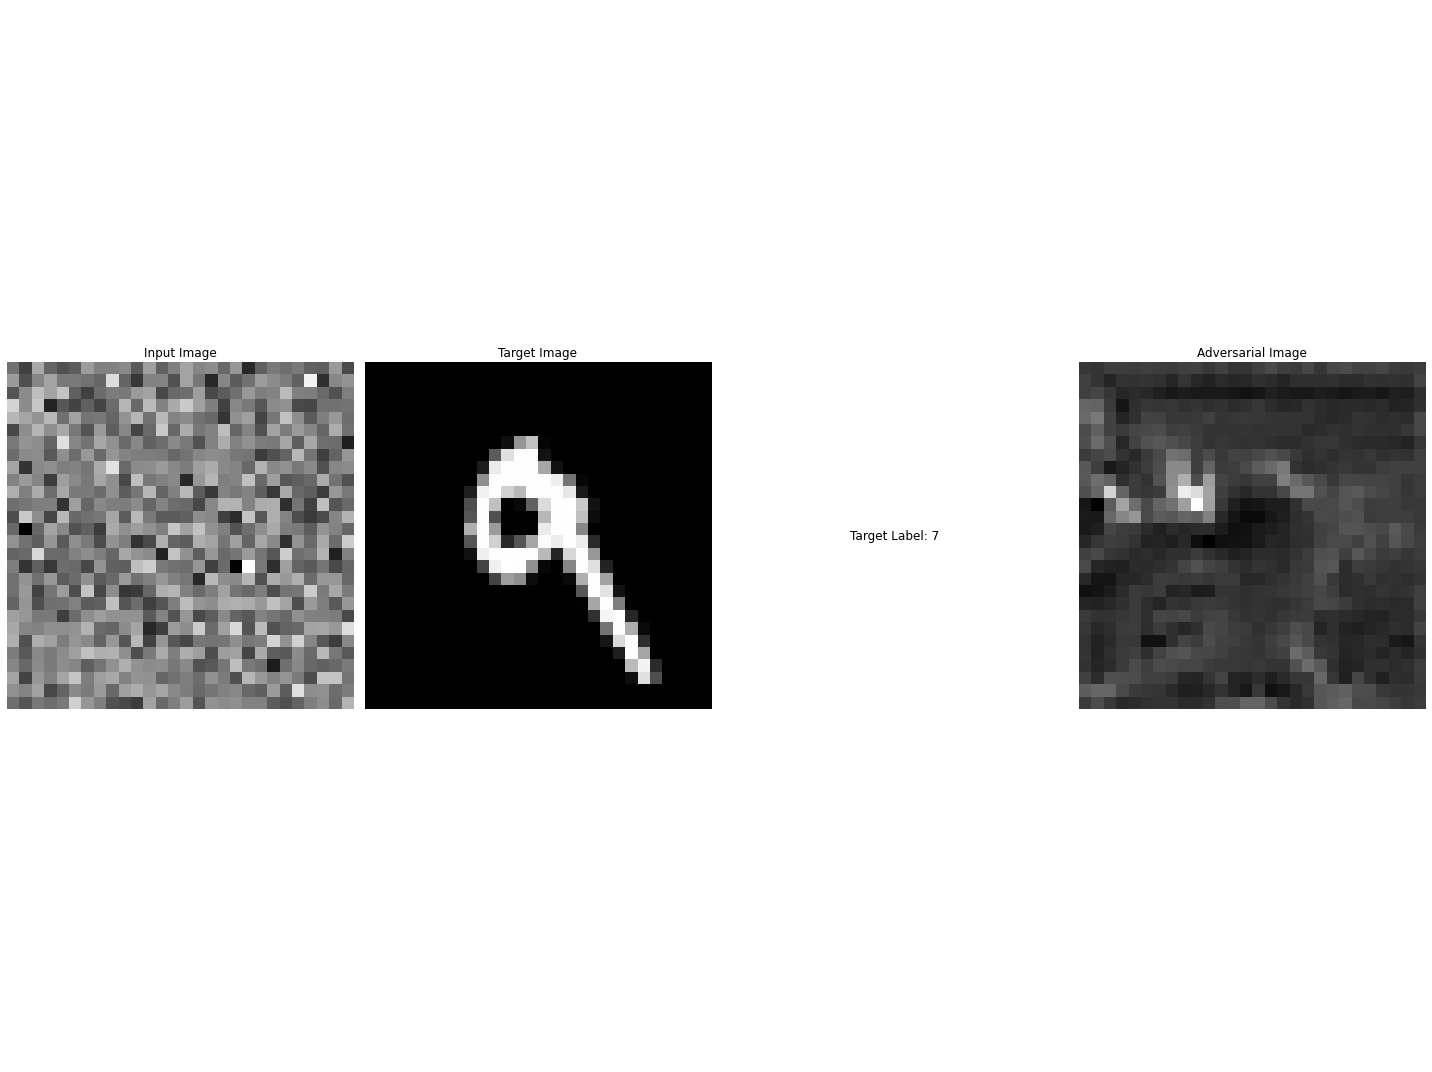

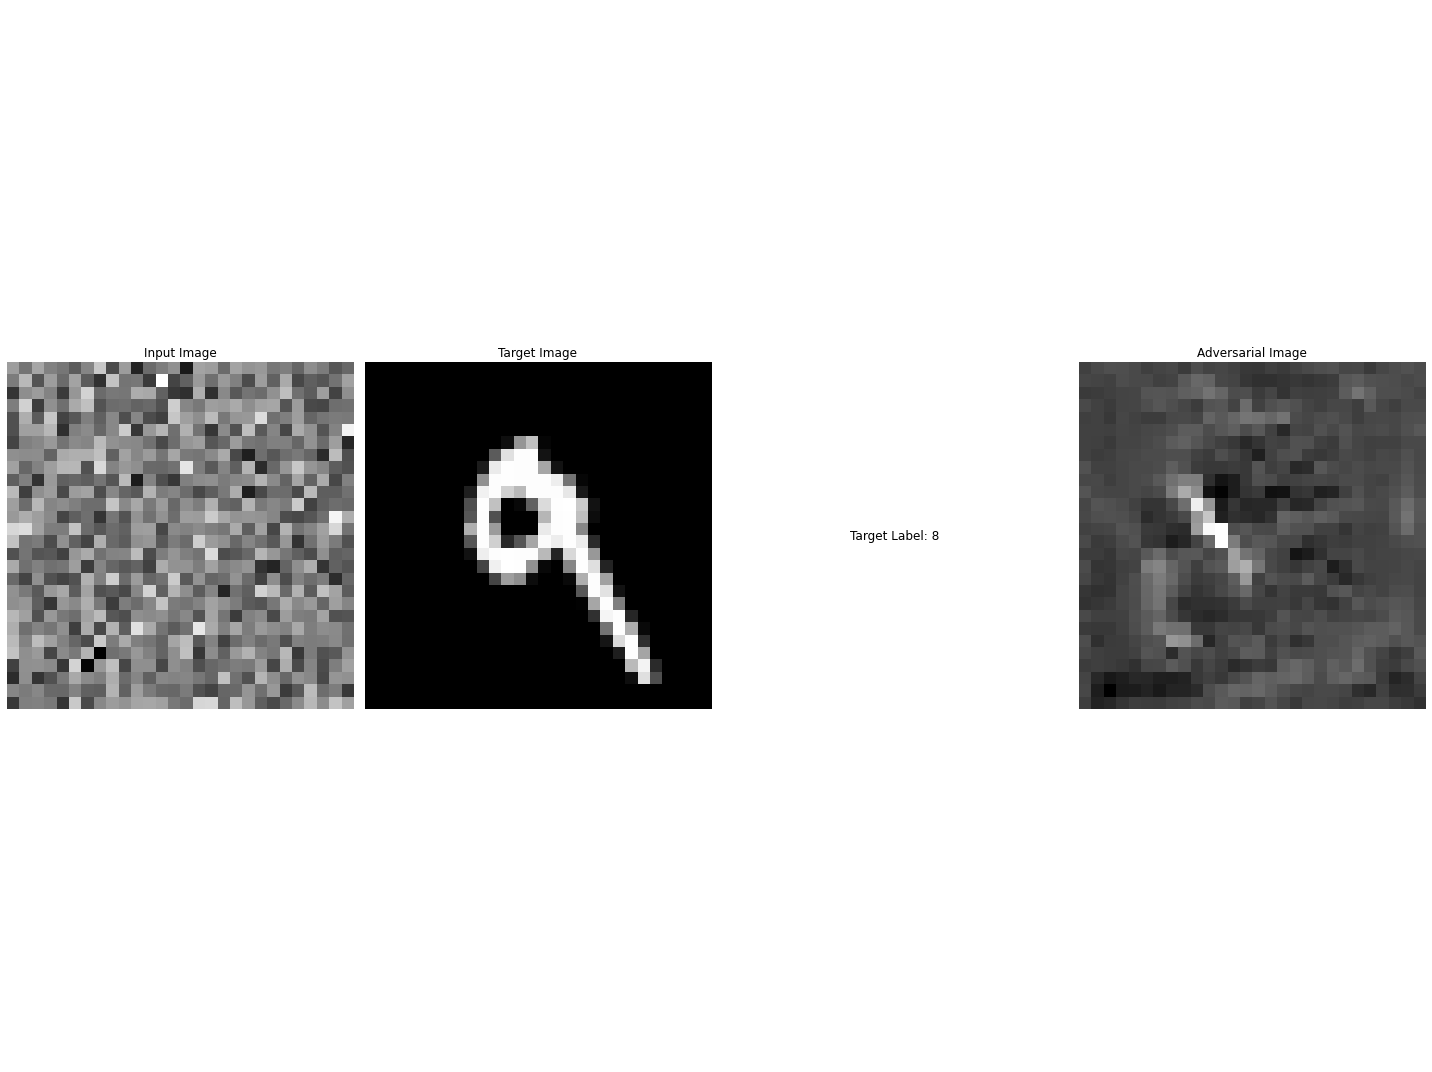

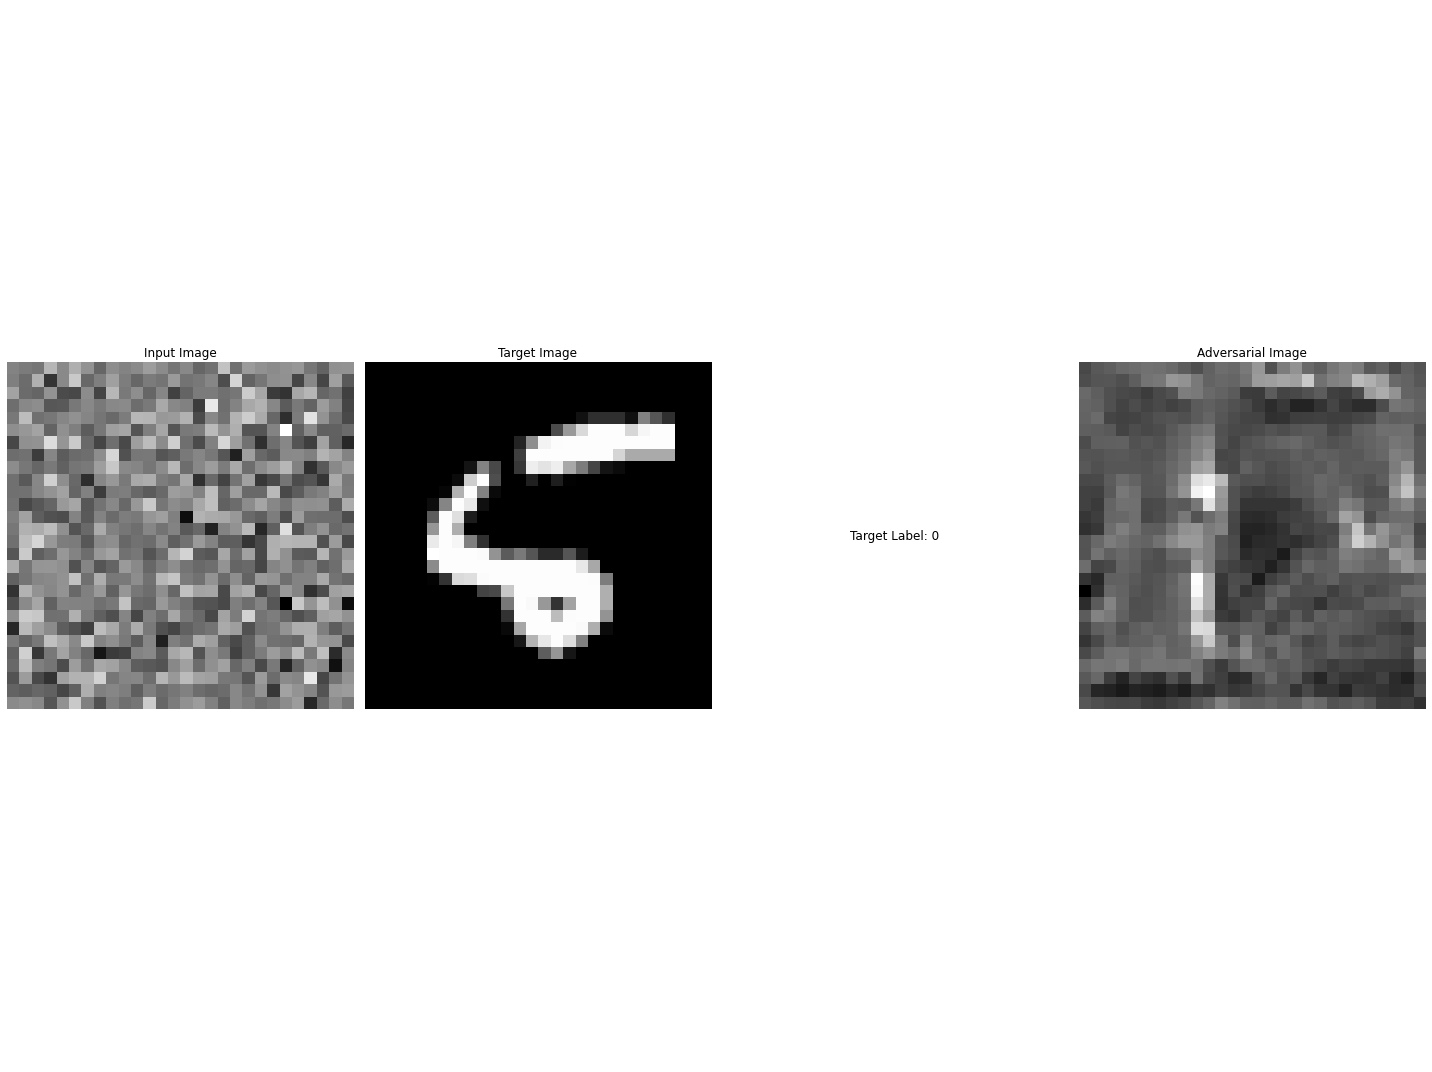

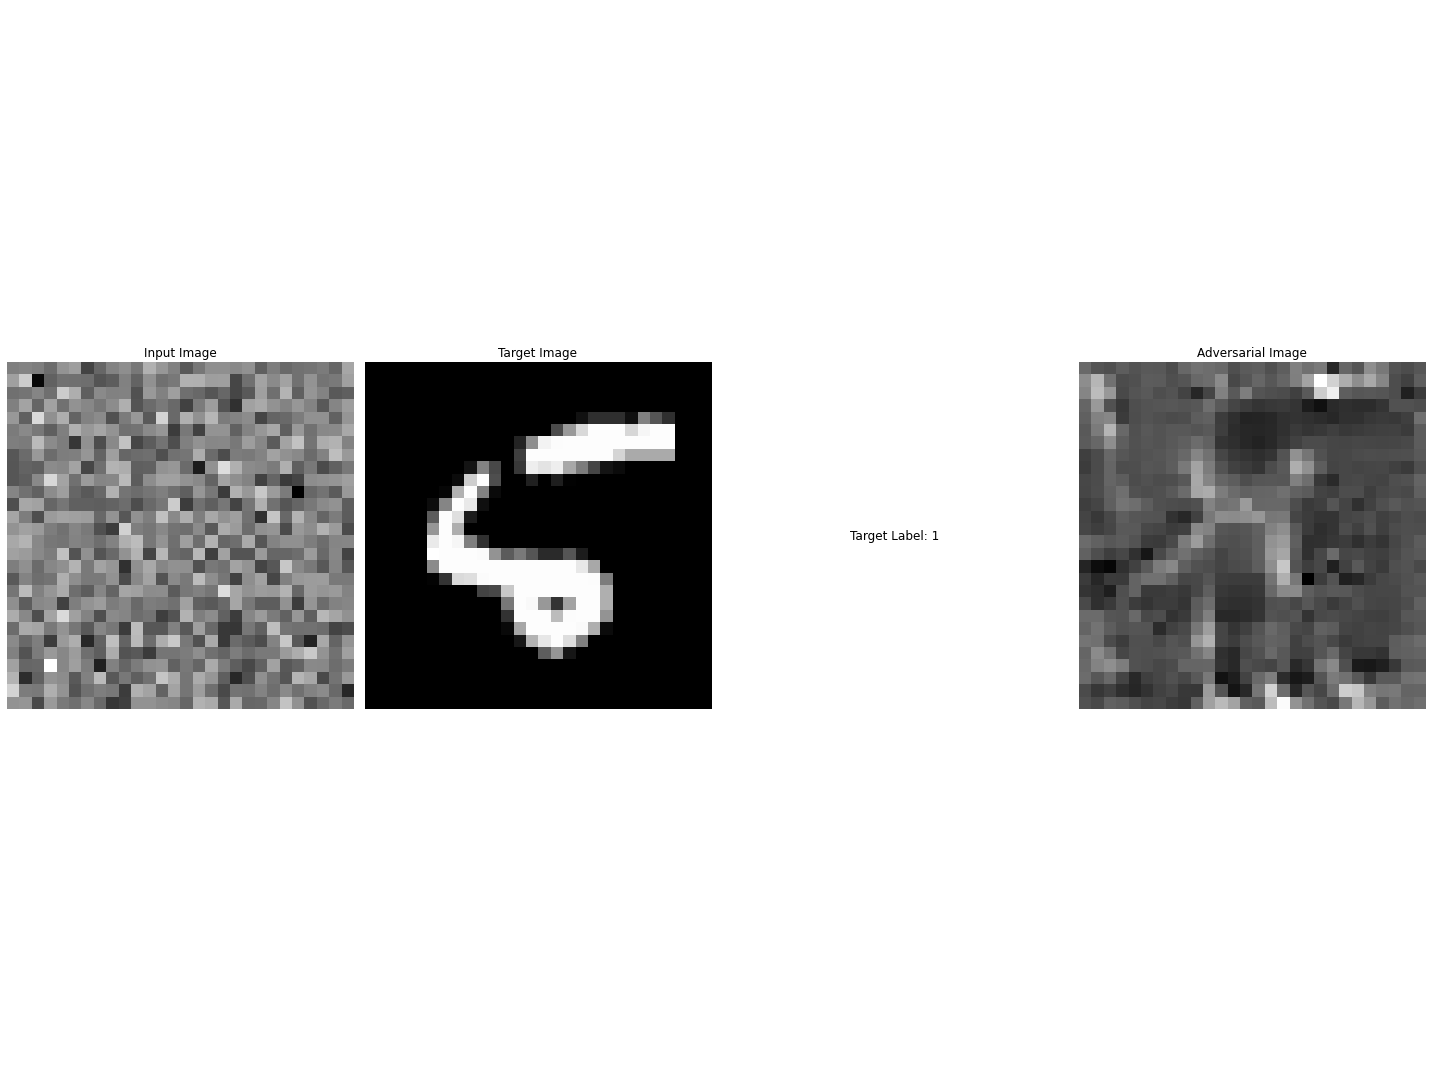

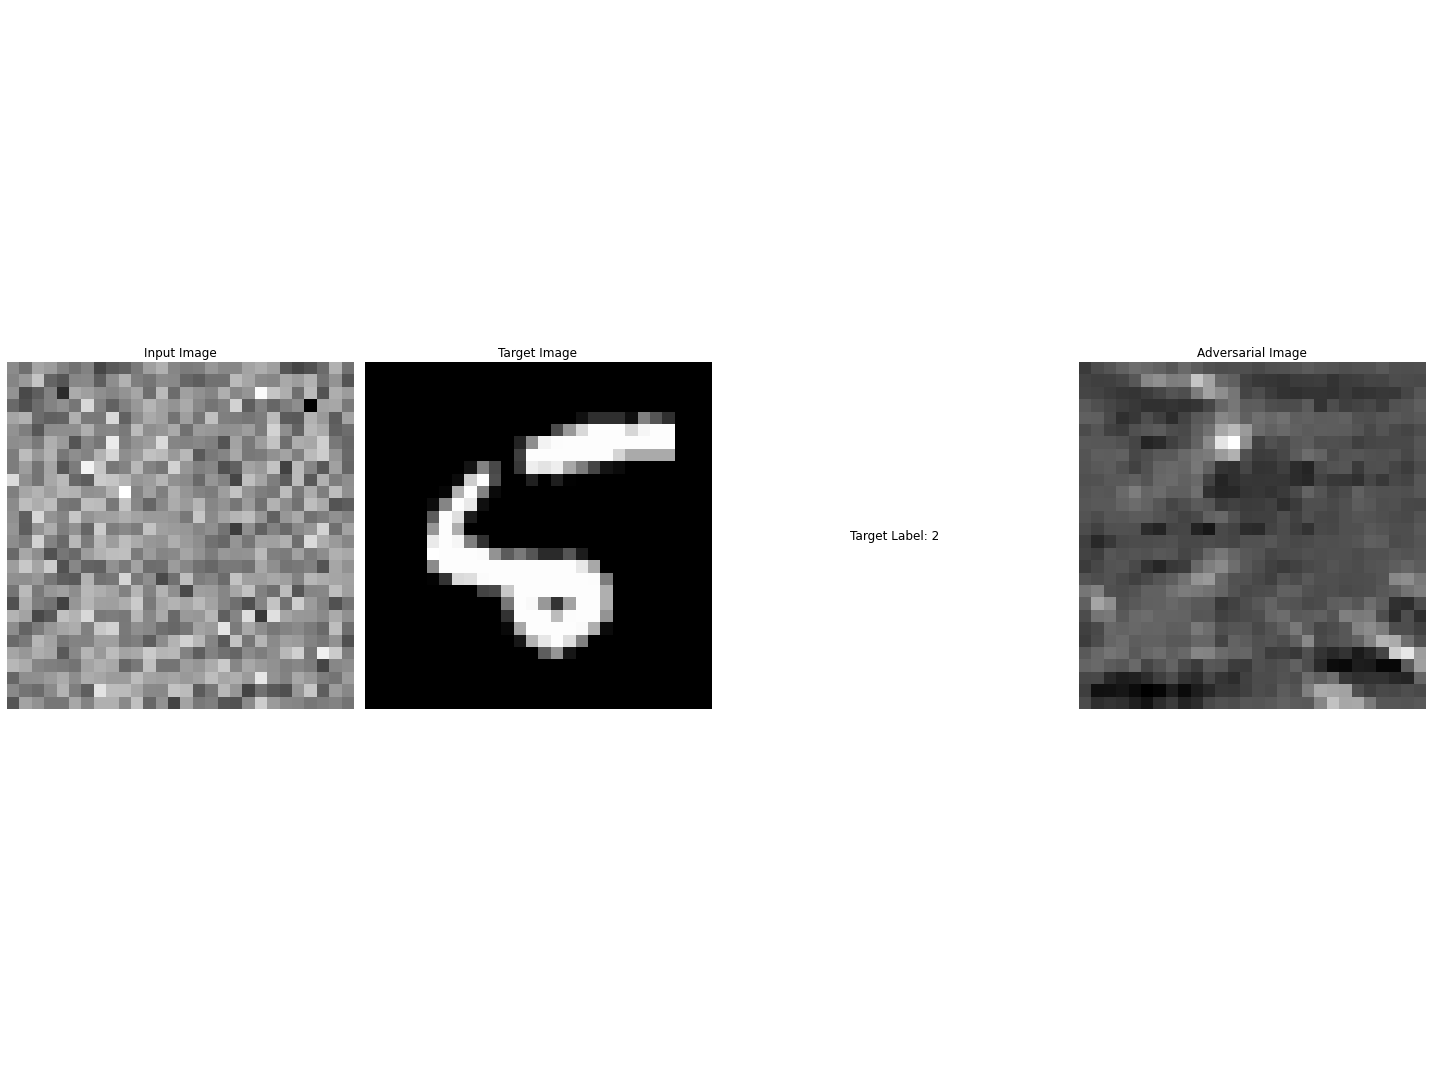

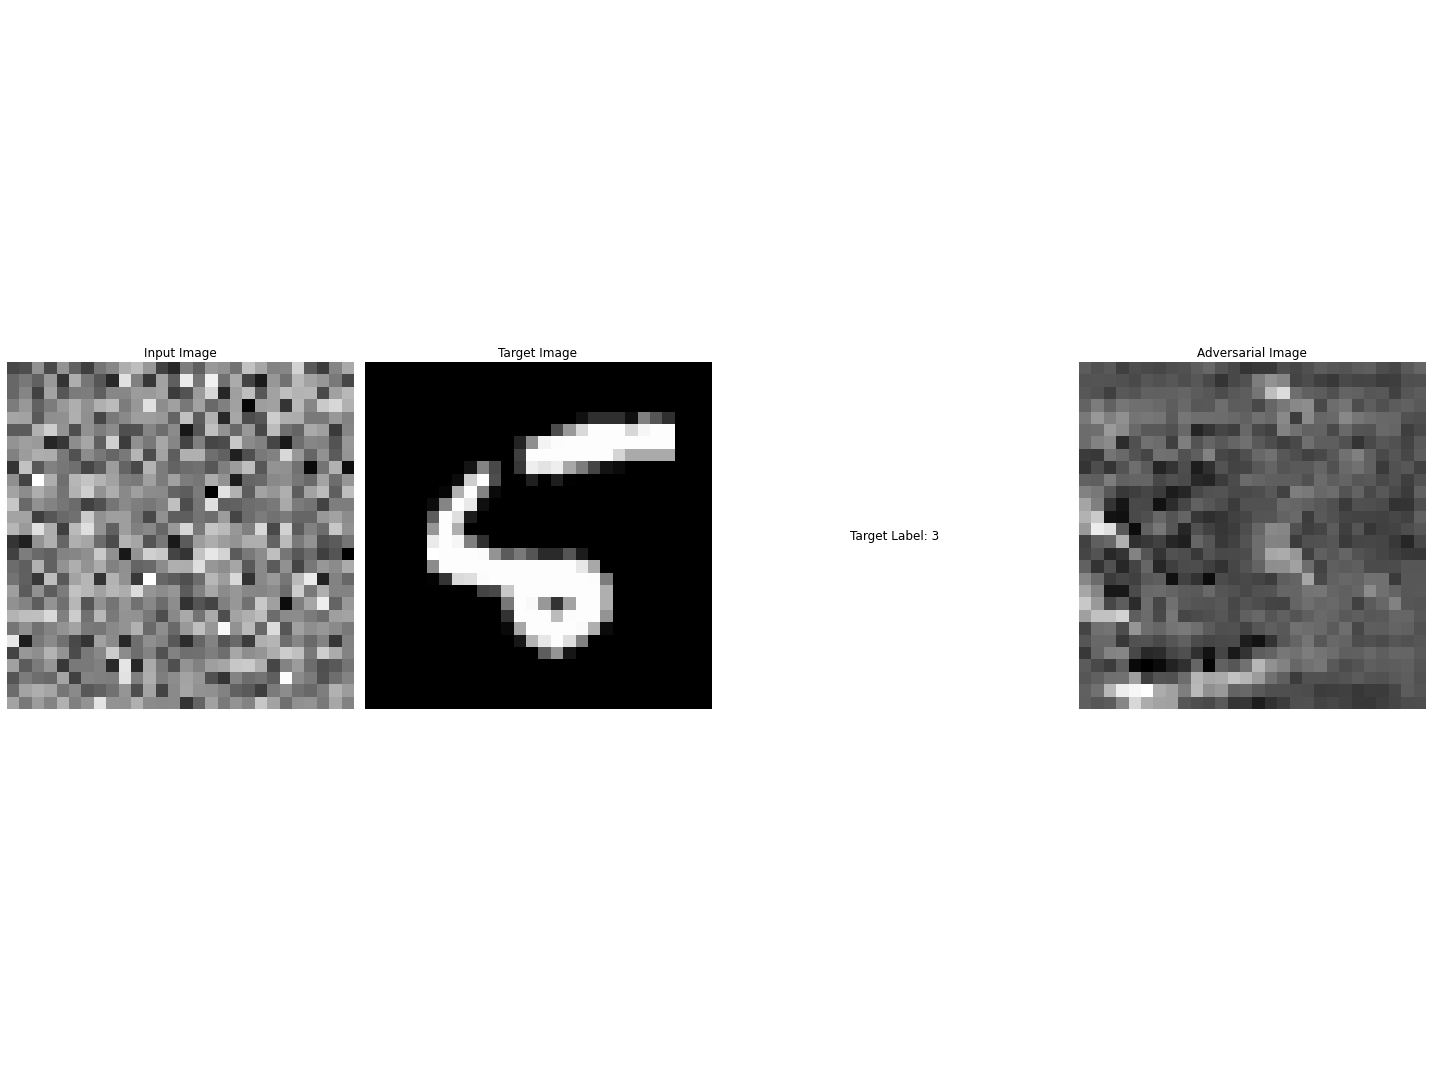

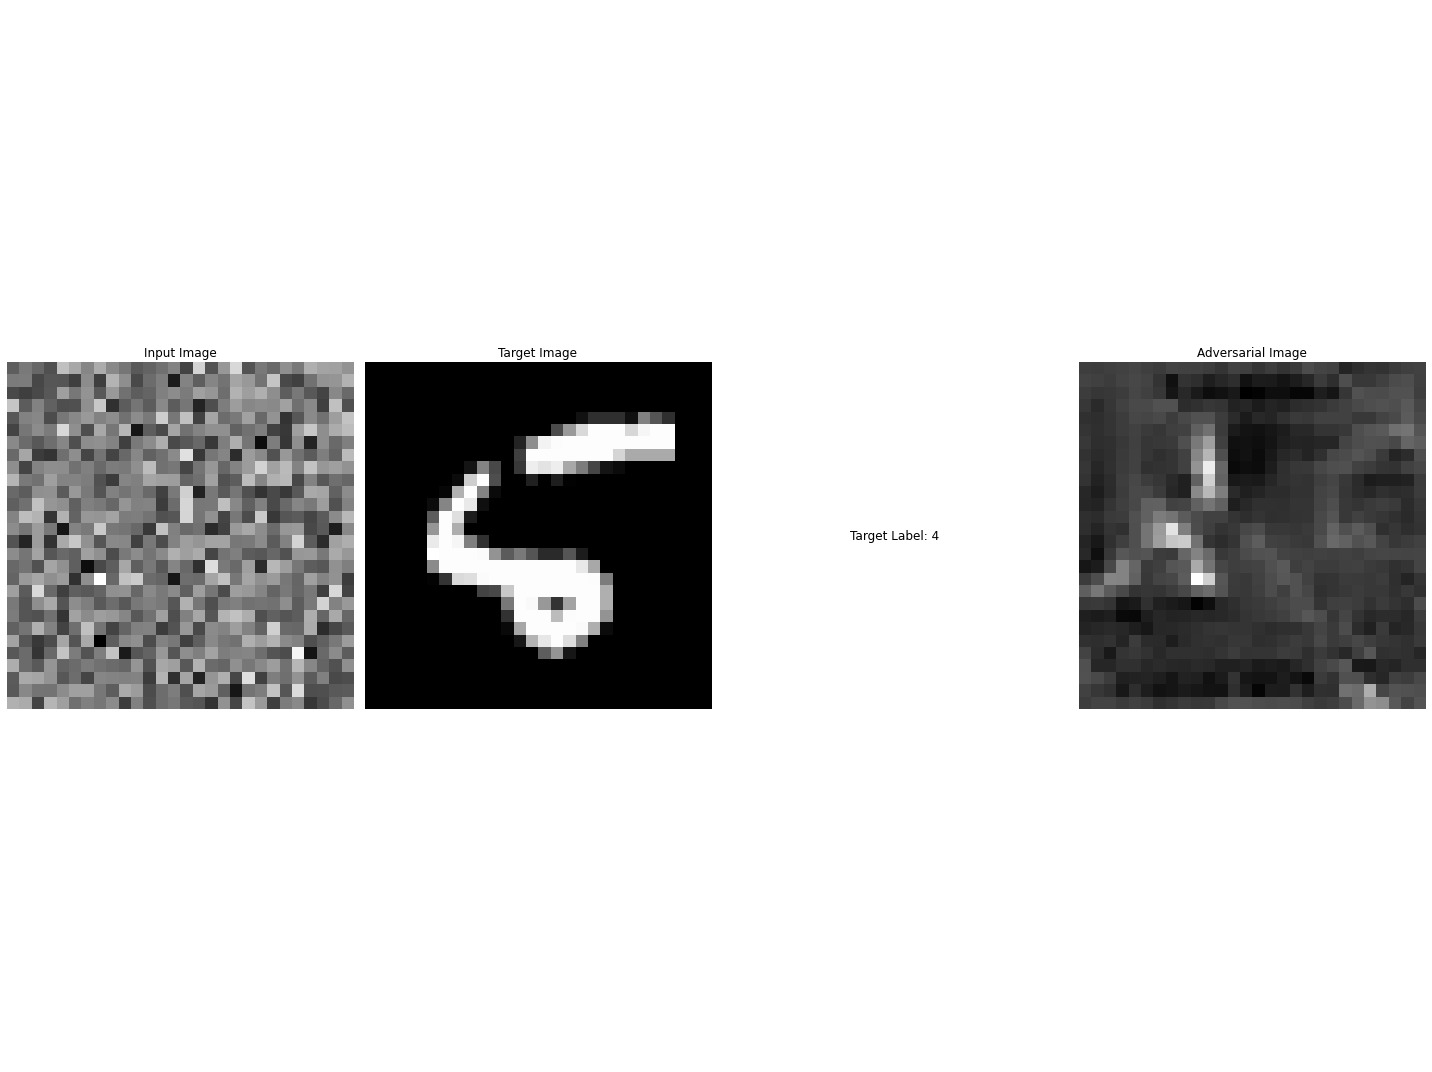

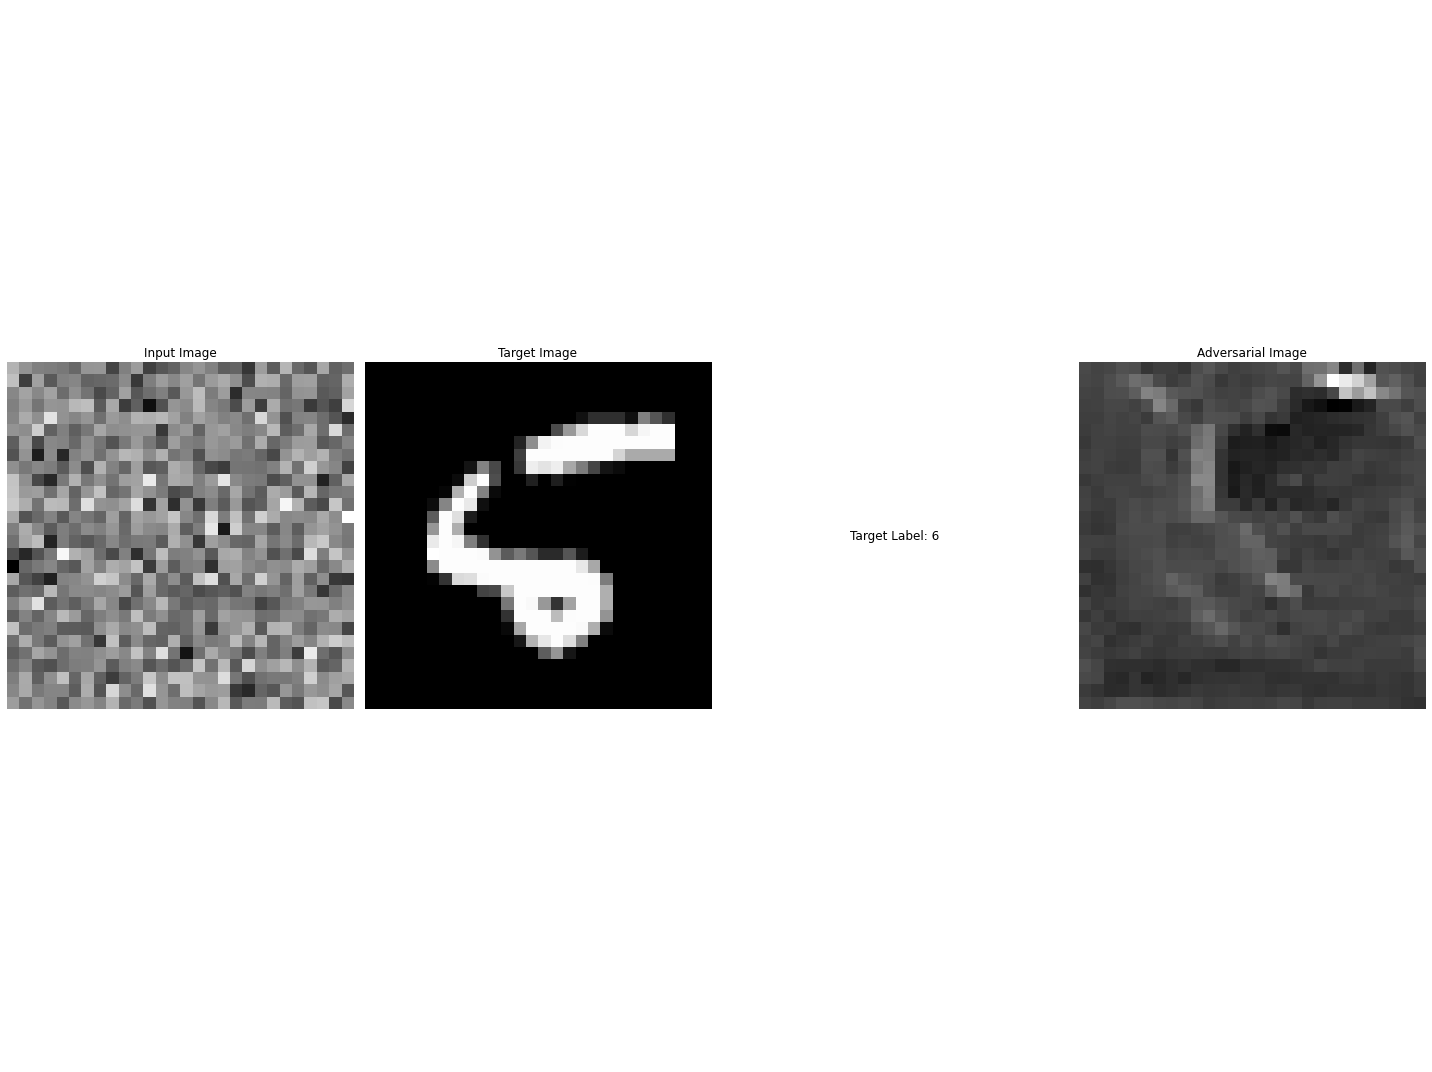

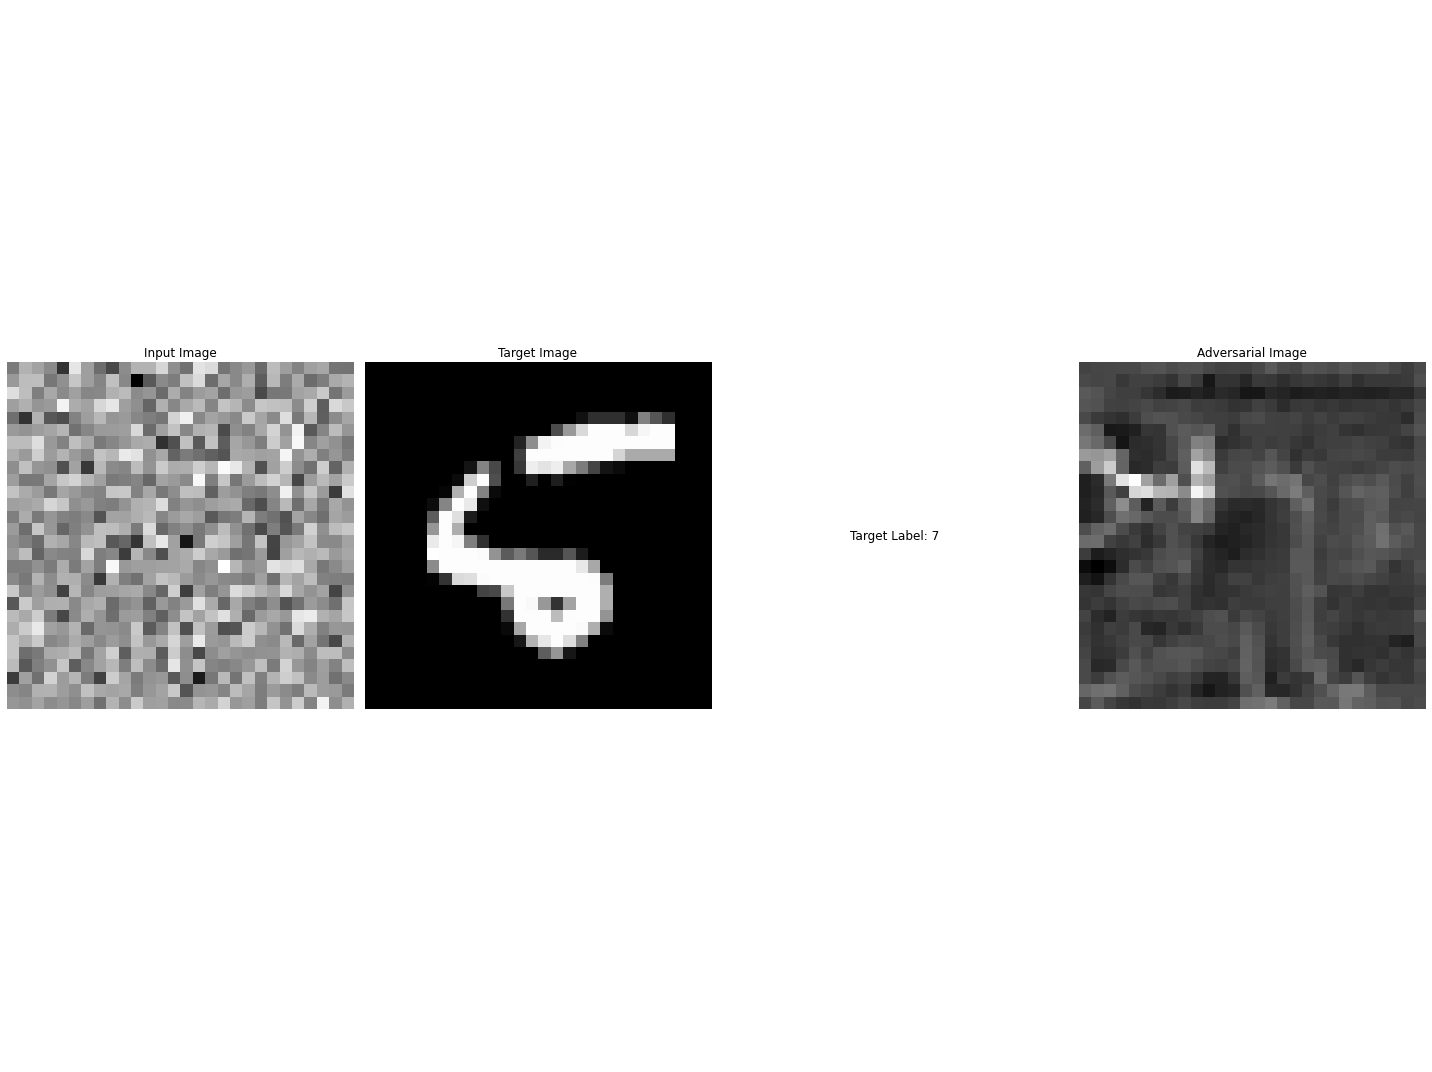

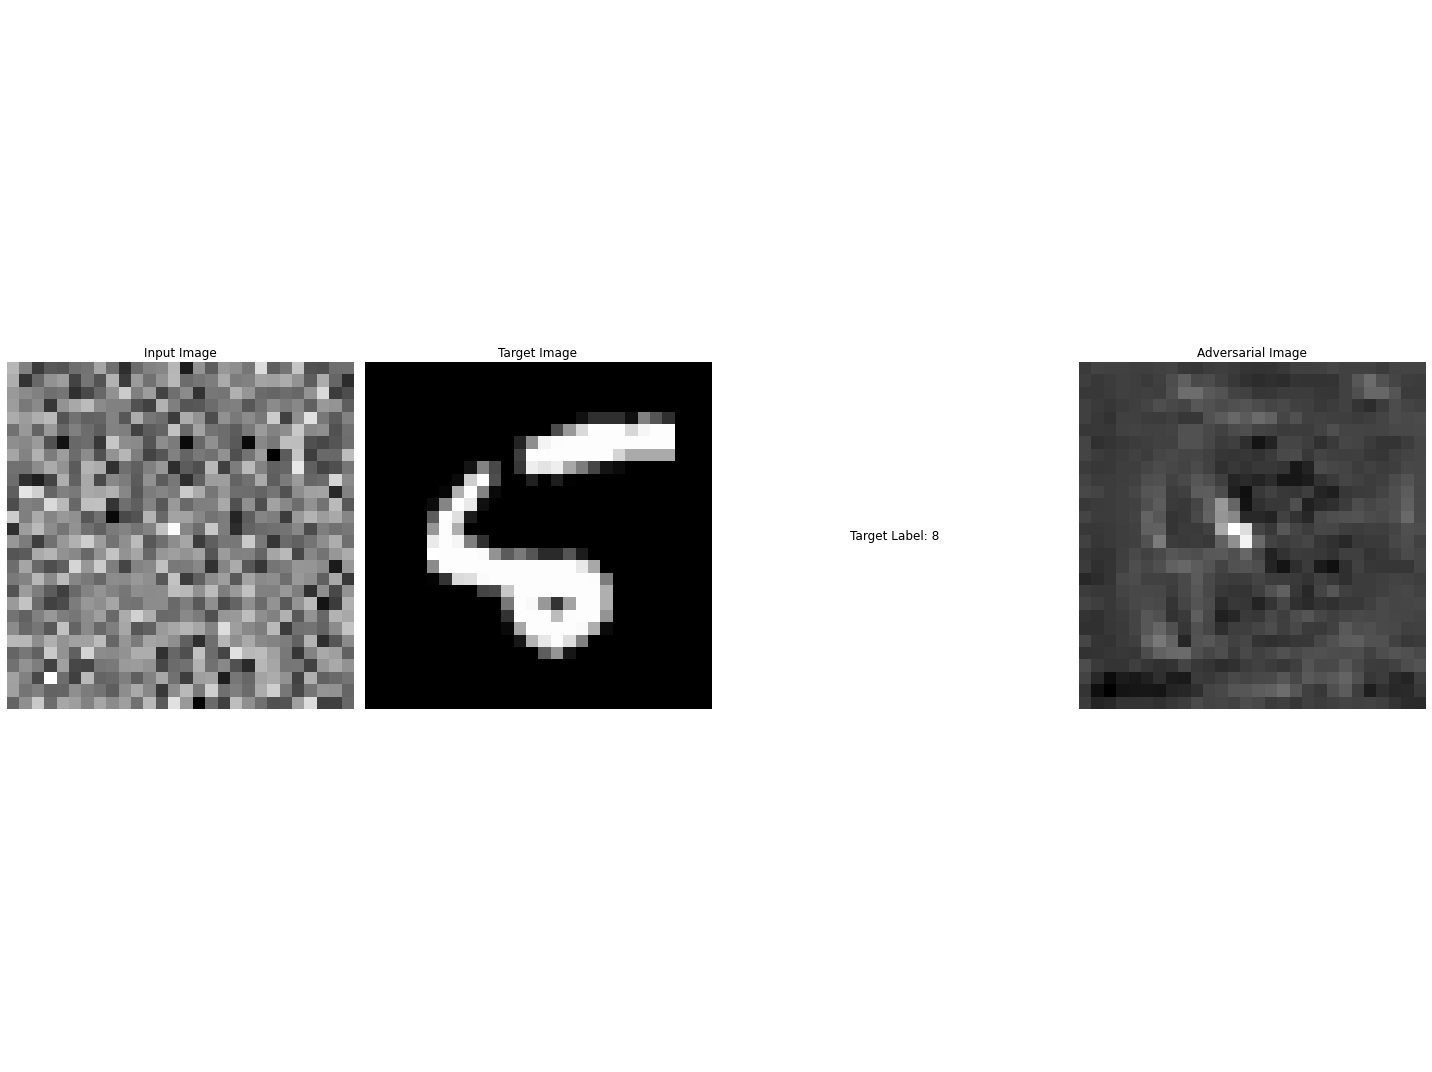

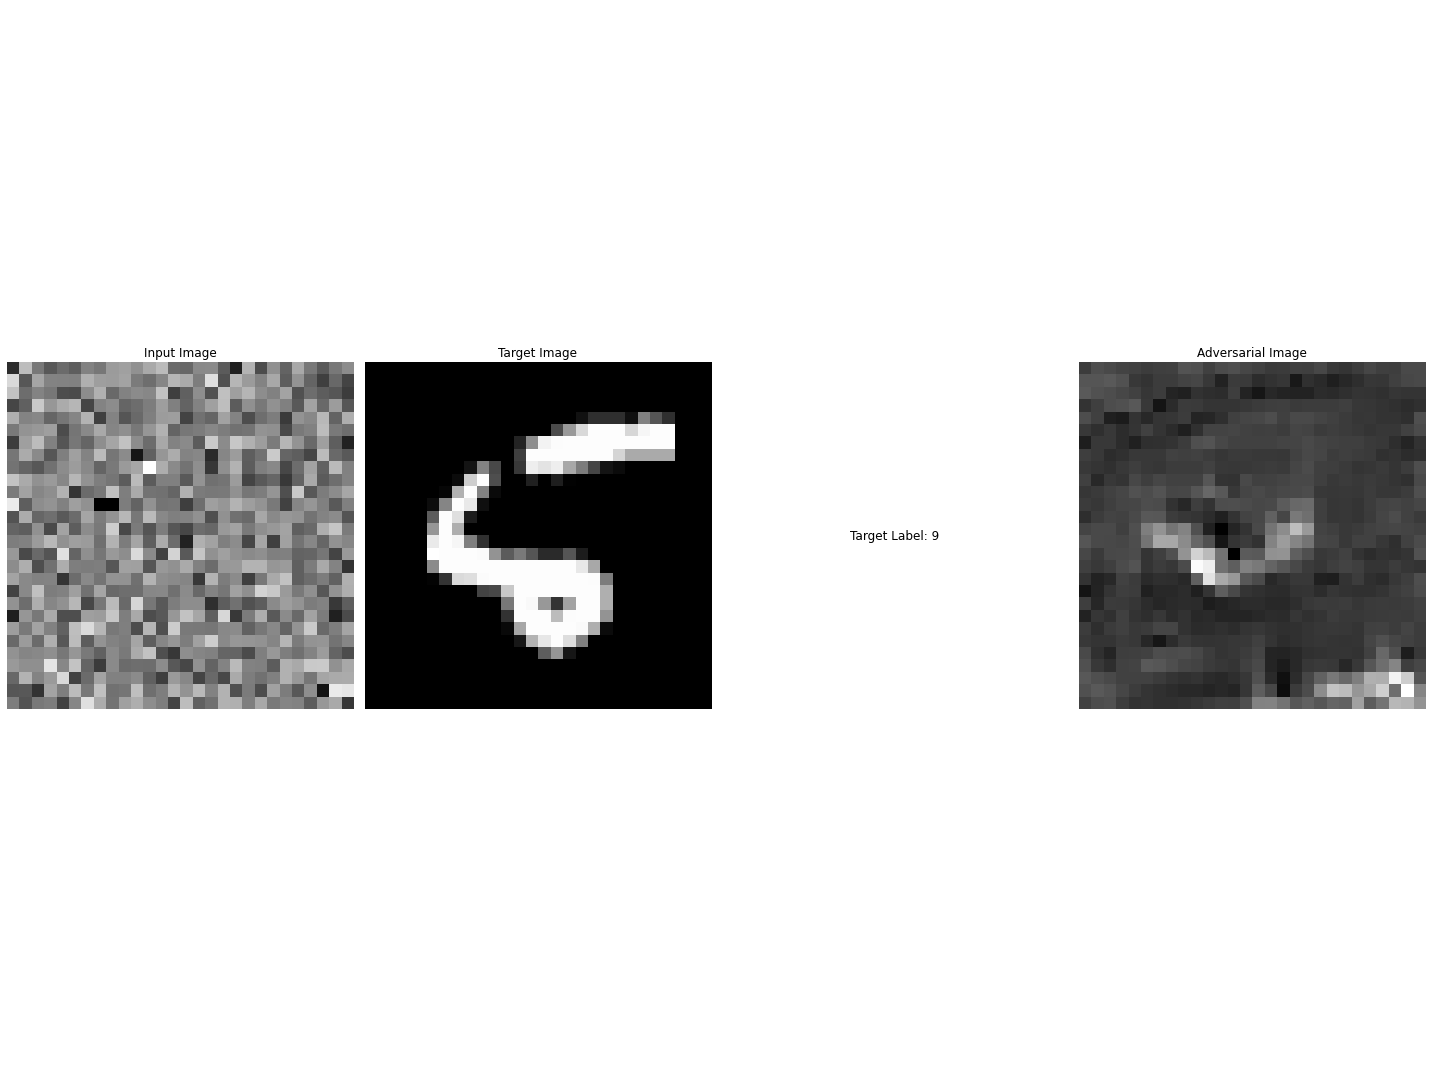

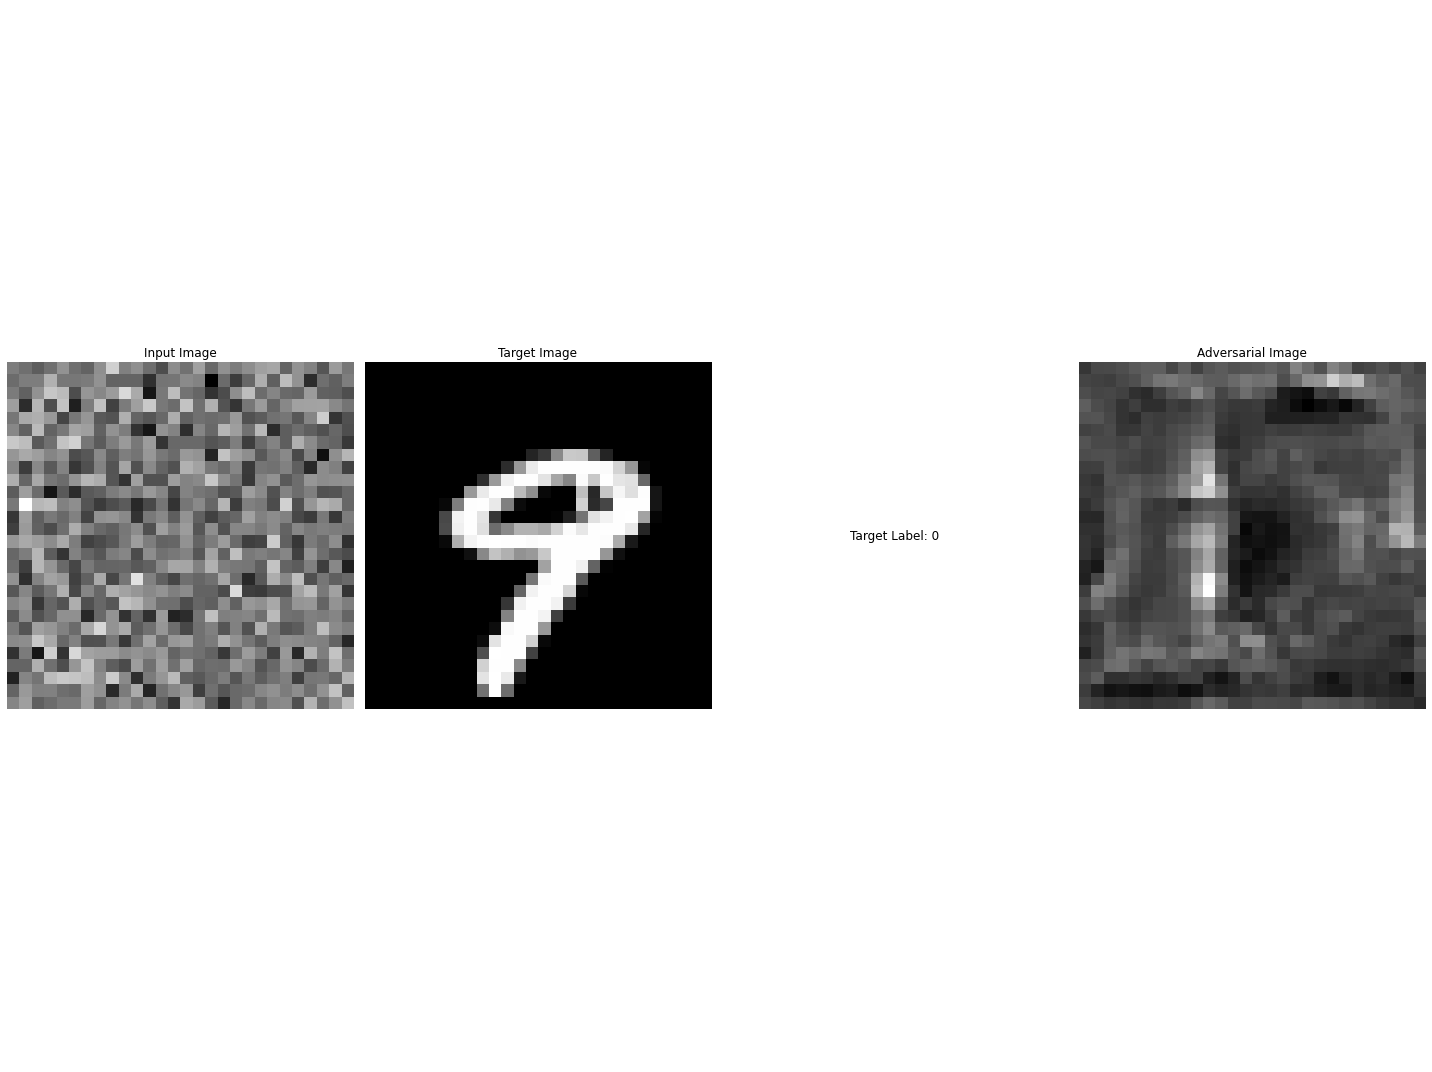

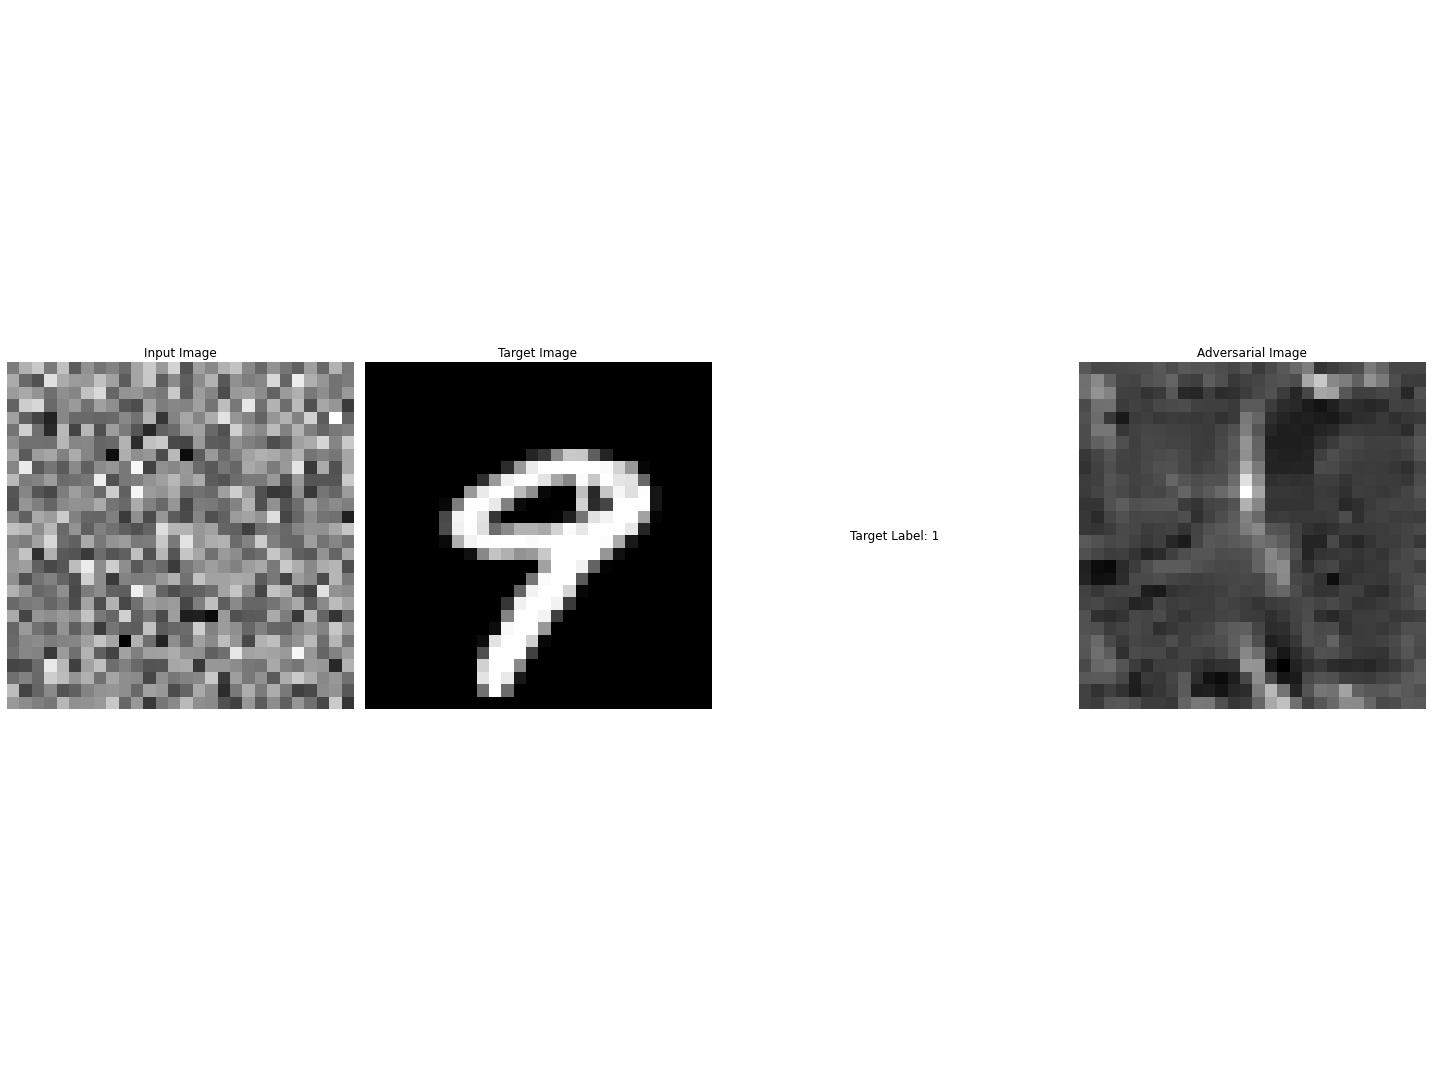

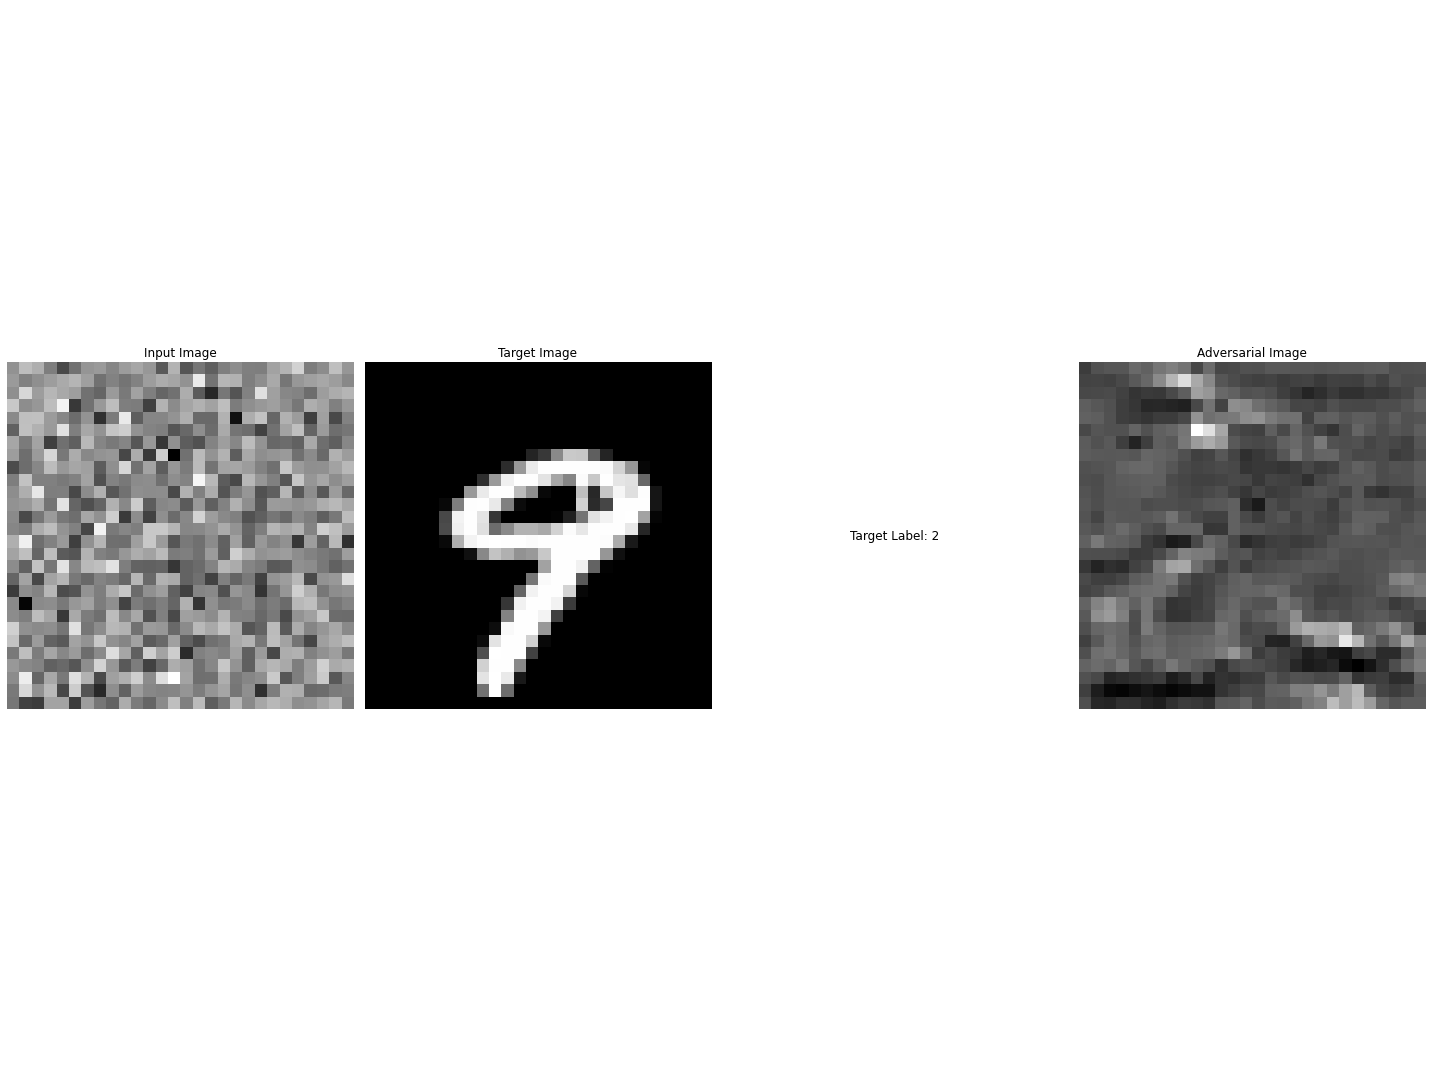

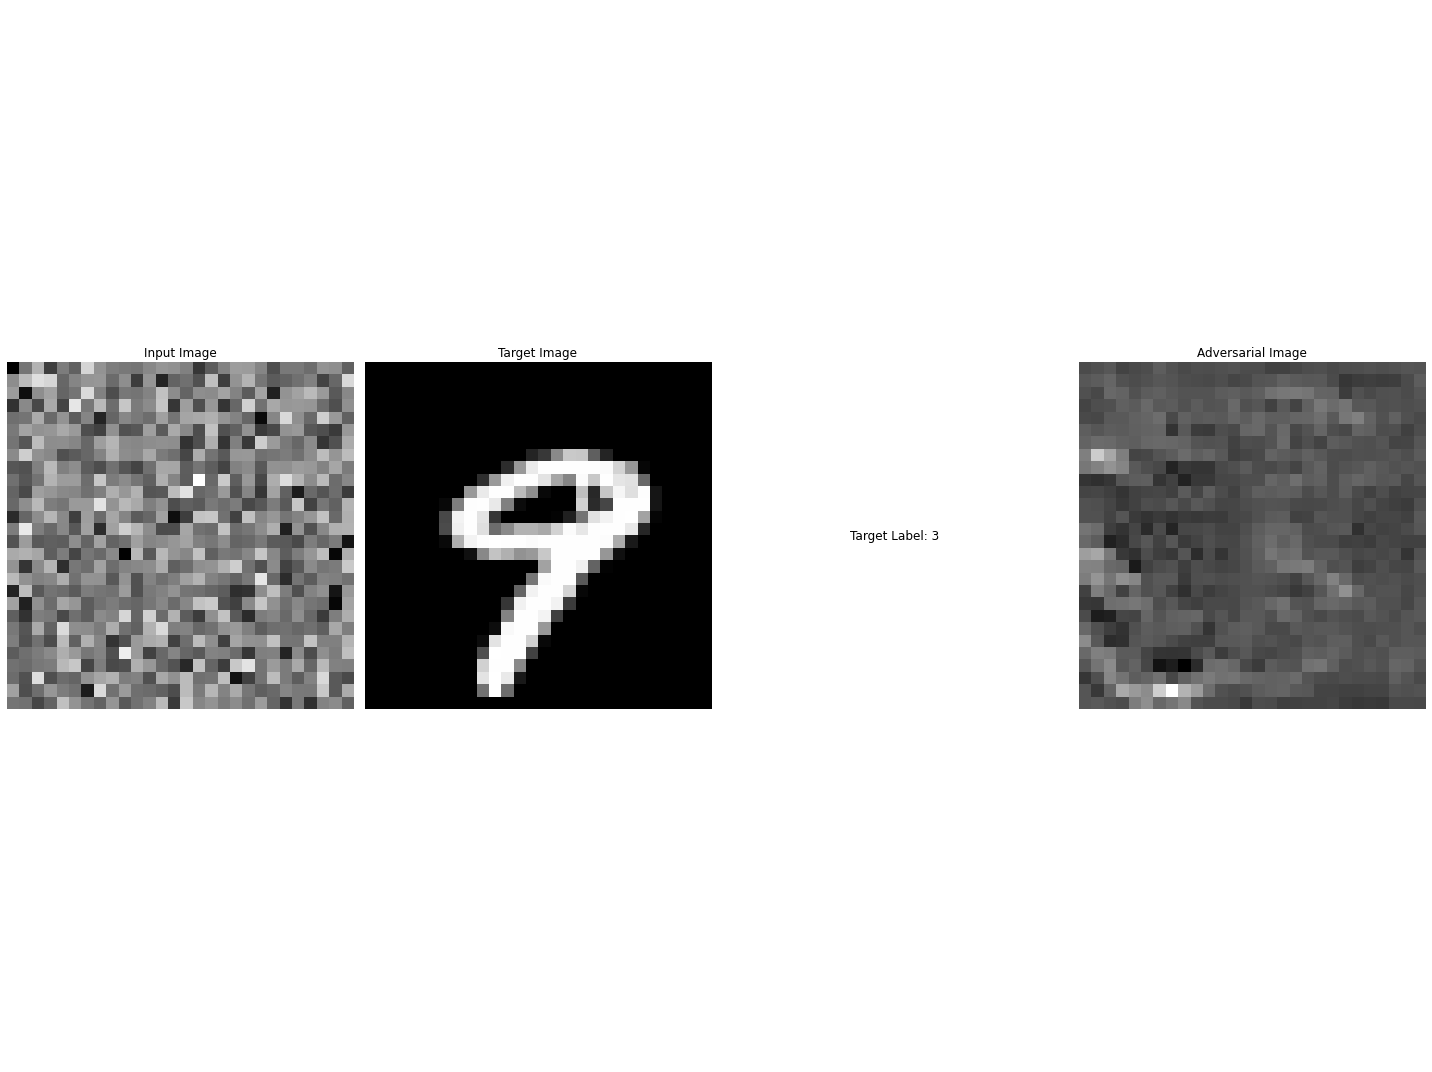

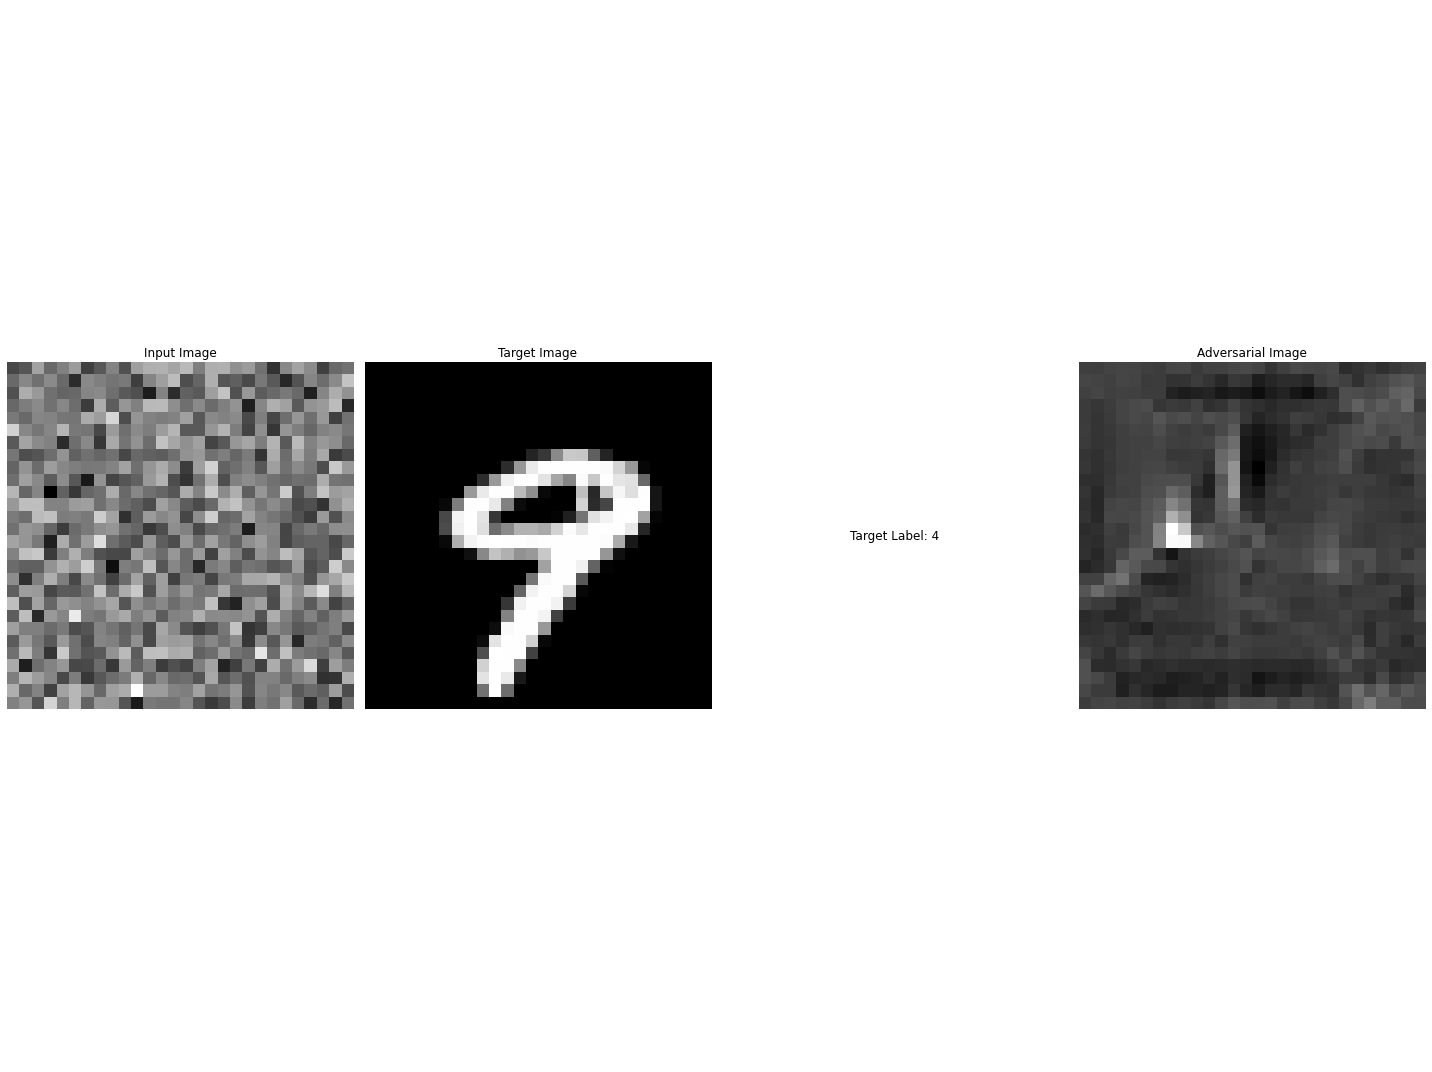

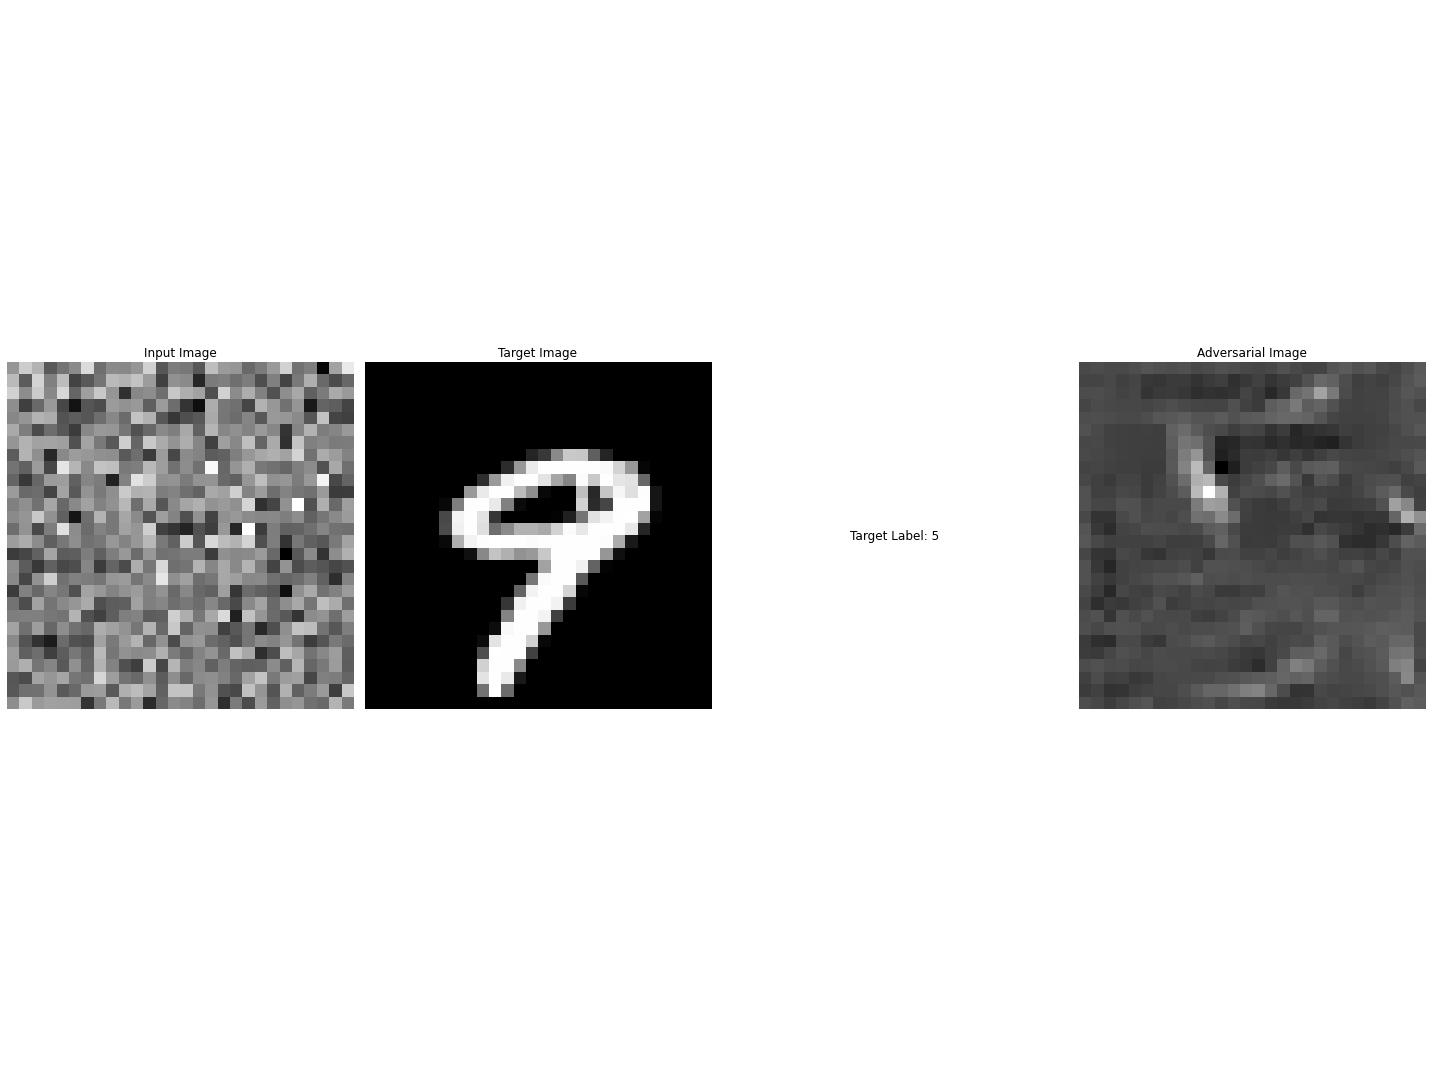

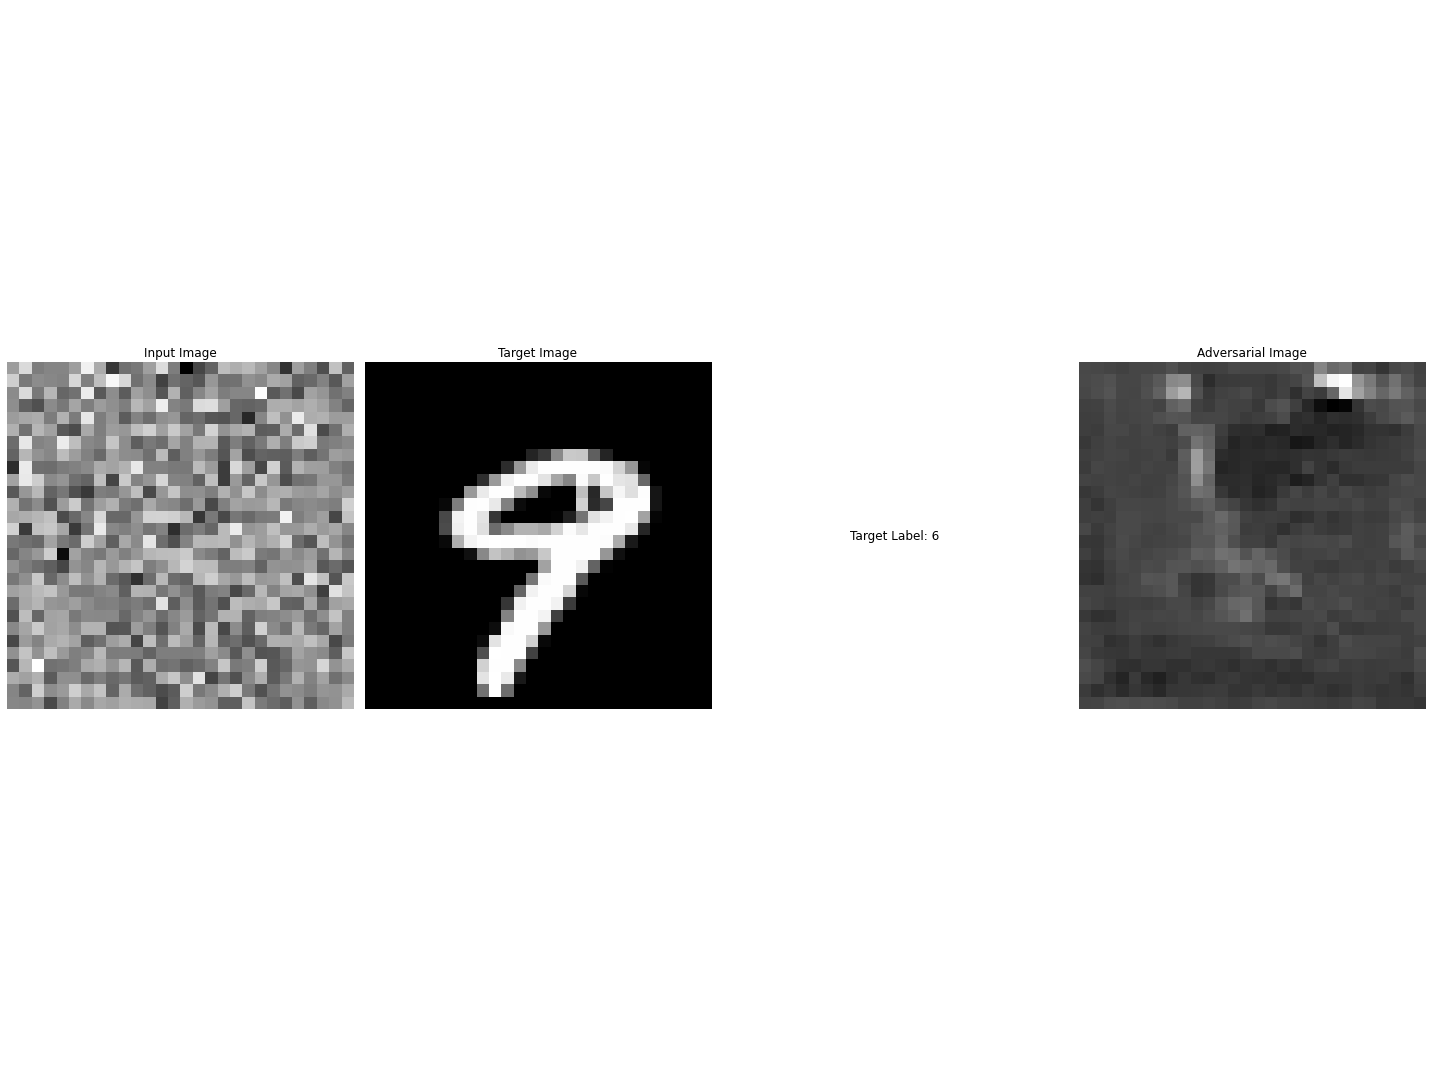

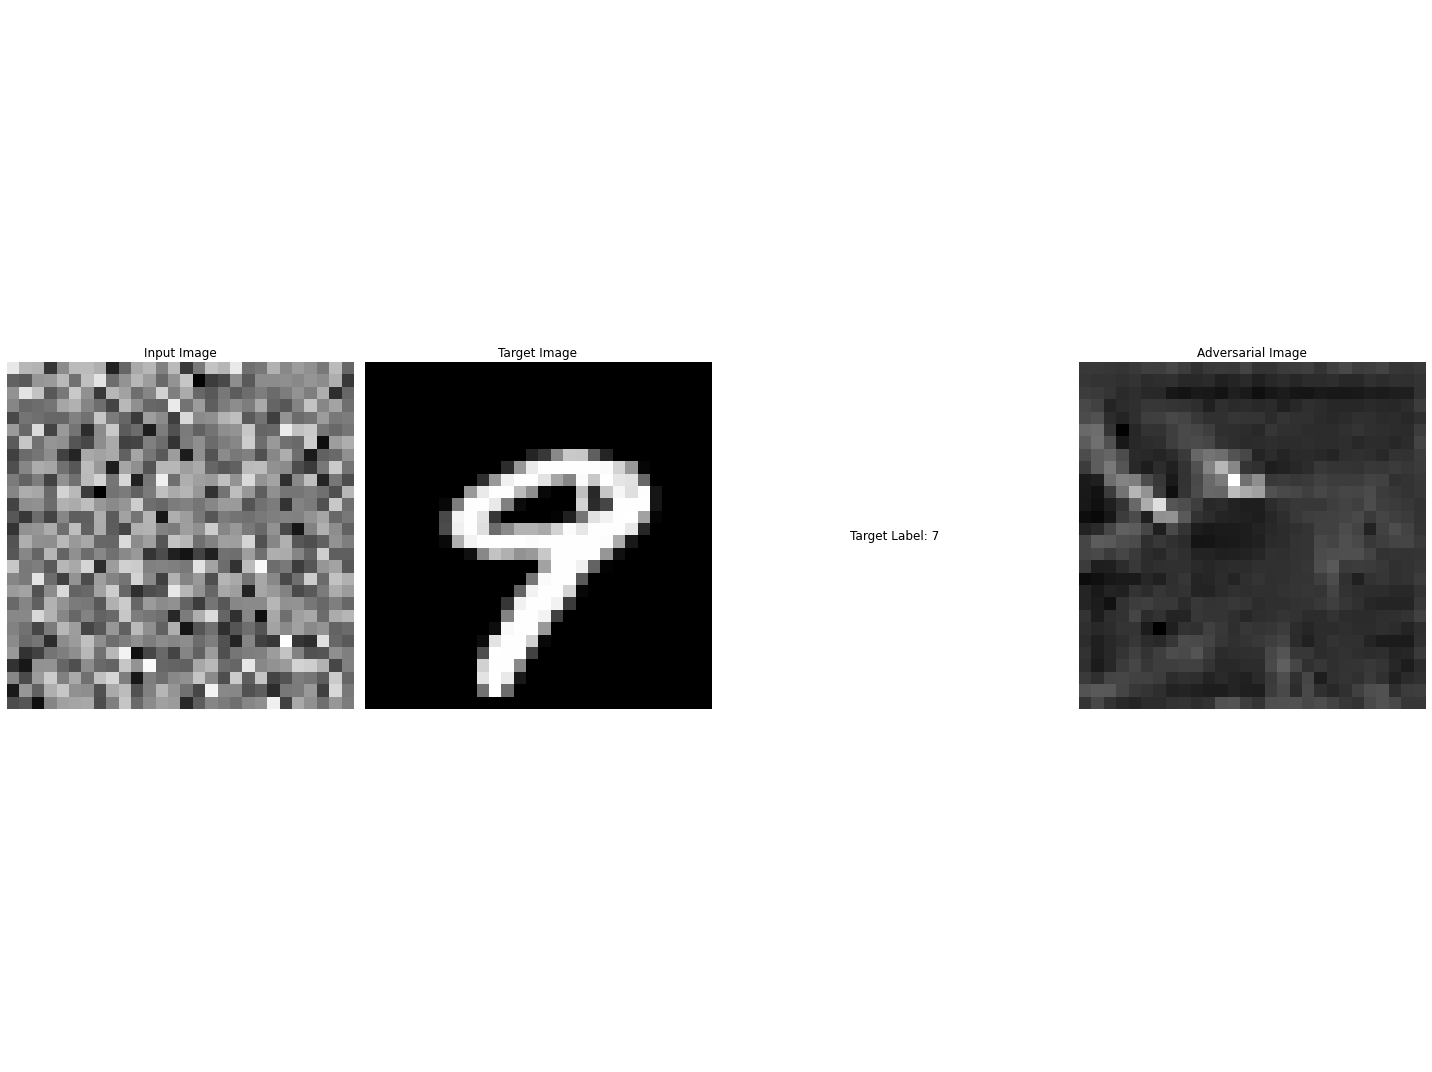

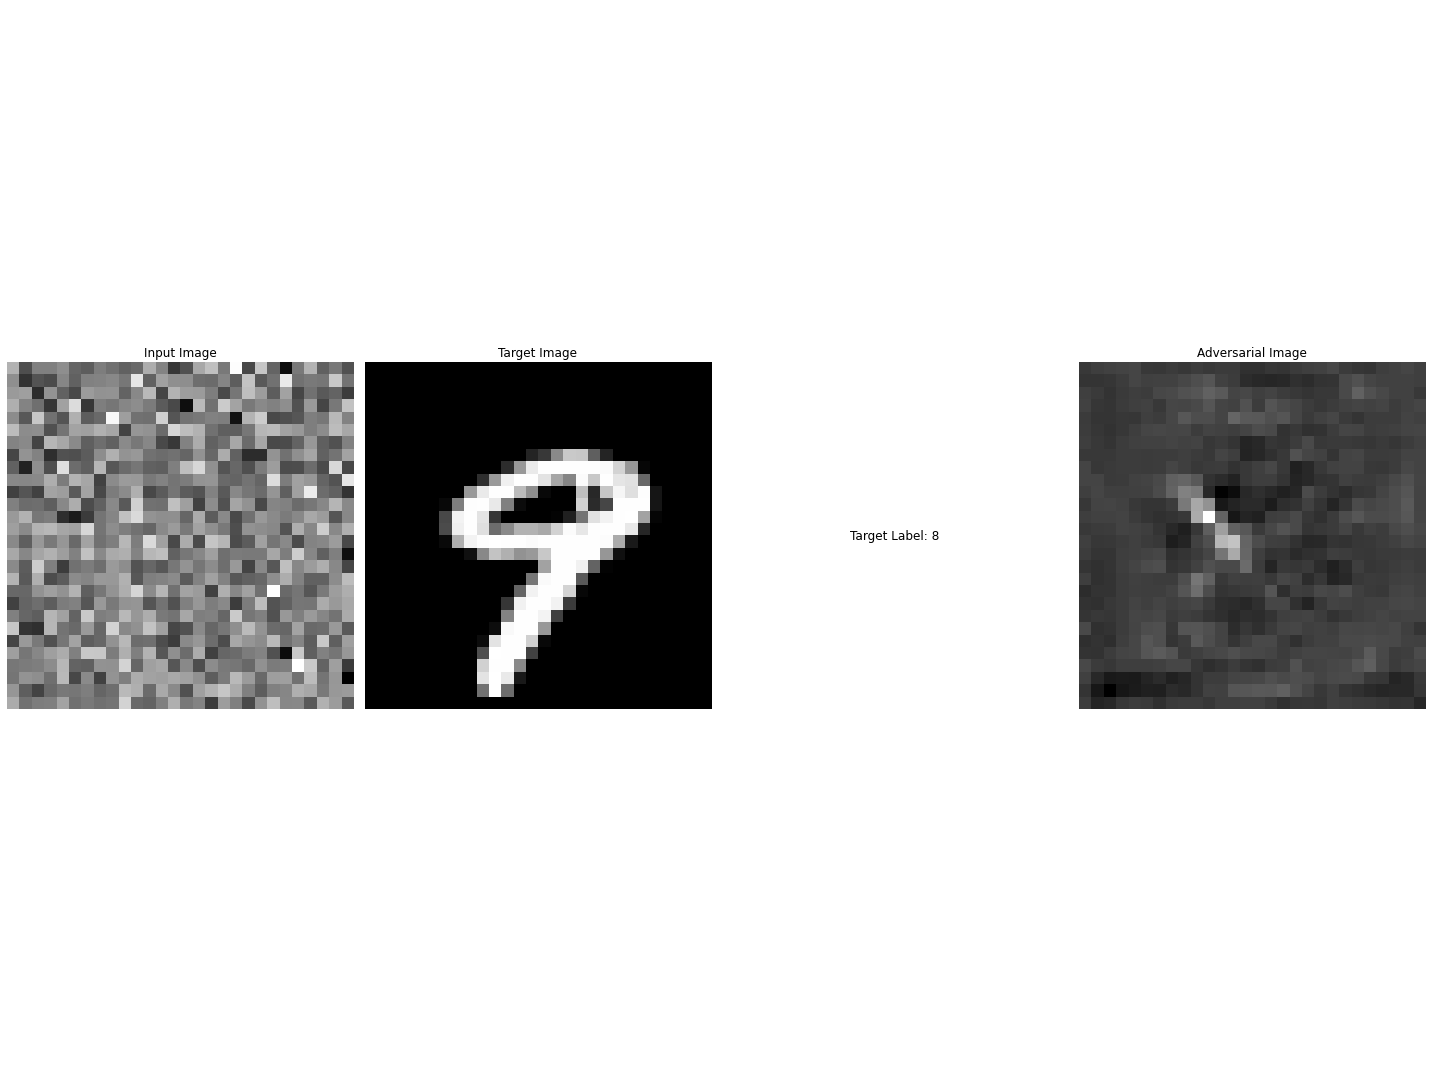

In [205]:

def generate_noise_image(height=28, width=28, mean=128, std=1):
    noise = np.random.normal(loc=mean, scale=std, size=(1, 1, height, width))
    noise_image = torch.tensor(noise, dtype=torch.float32) / 255.0
    return noise_image

def generate_custom_attack(neural_net, input_image, target_image, target_label, reg_coeff=0.0001, lr=0.01, num_steps=100):
    neural_net.eval()
    adv_tensor = input_image.clone().detach().requires_grad_(True)
    
    for step in range(num_steps):
        predictions = neural_net(adv_tensor)
        similarity_loss = F.mse_loss(adv_tensor, target_image)
        total_loss = predictions[0, target_label] - reg_coeff * similarity_loss
        neural_net.zero_grad()
        total_loss.backward()
        adv_tensor.data += lr * adv_tensor.grad.data
        adv_tensor.grad.data.zero_()
    
    adv_tensor.data = torch.clamp(adv_tensor.data, 0, 1)
    return adv_tensor


def display_attack_results(input_image, target_image, target_label, adv_image):
    plt.figure(figsize=(20, 15))
    plt.subplot(1, 4, 1)
    plt.imshow(input_image.squeeze().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(target_image.squeeze().numpy(), cmap='gray')
    plt.title('Target Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.text(0.5, 0.5, f'Target Label: {target_label}', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(adv_image.detach().squeeze().numpy(), cmap='gray')
    plt.title('Adversarial Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def run_attack_for_all_combinations(neural_net, data_loader, step_size=0.01, num_steps=100):
    for orig_label in range(10): 
        target_image, label = data_loader.dataset[orig_label]
        target_image = target_image.unsqueeze(0)
        for target_label in range(10): 
            if label == target_label:
                continue  
            input_image = generate_noise_image()
            adv_image = generate_custom_attack(neural_net, input_image, target_image, target_label, lr=step_size, num_steps=num_steps)
            display_attack_results(input_image, target_image, target_label, adv_image)


run_attack_for_all_combinations(model, test_loader, step_size=0.01, num_steps=100)
